# Error analysis on consistency
- inspect cases where w/o an anchor model goes wrong, while with an anchor the model gave correct predictions

In [1]:
import json
import pandas as pd 
from collections import Counter, defaultdict 
from utils_path import dataset_to_respath
from inflection import singularize, pluralize 

pd.set_option('display.max.columns', 100)
pd.set_option('display.max.colwidth', 500)

def get_dataset_to_respath(dataset_to_respath, print_flag=False):
    # remote path 
    source_dir = 'spartan:~/cogsci/DAP/'
    target_dir = '../../'
    dataset_to_localpath = defaultdict()
    dataset_rename = {
        'hypernymsuite-BLESS': 'BLESS', 'lm_diagnostic_extended-singular': 'DIAG', 'clsb-singular':'CLSB', 'hypernymsuite-LEDS': 'LEDS', 'hypernymsuite-EVAL': 'EVAL', 'hypernymsuite-SHWARTZ': 
        "SHWARTZ"
    }
    dataset_name_to_relpath = defaultdict()
    for dataset, path in dataset_to_respath.items():
        path = path.replace(".tsv", ".csv")
        source_path = source_dir + path 
        dataset_l1 = dataset.split("-")[0]
        dataset_l2 = dataset.split("-")[1] 
        target_path = target_dir + path
        
        scp_string = f"!scp {source_path} {target_path}"
        if print_flag:
            print(scp_string)
            print()
#         print(target_path)
        dataset_to_localpath[dataset_rename[dataset]] = target_path 
        dataset_name_to_relpath[dataset_rename[dataset]] = "/".join(dataset.split('-'))
#     print(dataset_to_localpath)
    return dataset_to_localpath, dataset_name_to_relpath

dataset_to_localpath, dataset_name_to_relpath = get_dataset_to_respath(dataset_to_respath)
print(json.dumps(dataset_to_localpath, indent=4))
# print(dataset_name_to_relpath)

def read_anchors(path_pl, anchor_source, debug=False):
    '''
    read the anchor files mined from singualr and plural
    
    args: 
        anchor_soure: using the anchors mined from singular probe or plural probe
        
    return: 
        dic_sub_to_anchors_singular: both sub_label and subj_anchors are singular 
        dic_sub_to_anchors_plural: both sub_label and subj_anchors are plural 
    '''
#     dfsg = pd.read_csv(path_sg)
#     dfsg['subj_anchors'] = dfsg['subj_anchors'].apply(lambda x: eval(x))
    
#     dfpl = pd.read_csv(path_pl)
#     dfpl['subj_anchors'] = dfpl['subj_anchors'].apply(lambda x: eval(x))
#     df = pd.merge(dfsg, dfpl, on = 'uuid', suffixes=('_sg', '_pl'))
# if anchor_source == 'plural':
#         #convert the singular anchors into singular format
#         df['subj_anchors_sg'] = df['subj_anchors_pl'].progress_apply(lambda x: [singularize(word) for word in x])
#     elif anchor_source == 'singular':
#         #convert the plural anchors into singular format
#         df['subj_anchors_pl'] = df['subj_anchors_sg'].progress_apply(lambda x: [pluralize(word) for word in x])

    df = pd.read_csv(path_pl)
    
    if debug: df = df.head(5)
    df['subj_anchors_sg'] = df['subj_anchors_sg'].apply(lambda x: eval(x))
    df['subj_anchors_pl'] = df['subj_anchors_pl'].apply(lambda x: eval(x))
        
    dic_sub_to_anchors_singular = dict(zip(df['sub_label_sg'], df['subj_anchors_sg']))
    dic_sub_to_anchors_plural = dict(zip(df['sub_label_pl'], df['subj_anchors_pl']))
    
    return dic_sub_to_anchors_singular, dic_sub_to_anchors_plural



 

{
    "BLESS": "../../log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False.HYPERNYMSUITE.csv",
    "DIAG": "../../log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv",
    "CLSB": "../../log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_False_cpt_False.CLSB.csv",
    "LEDS": "../../log/bert-large-uncased/hypernymsuite/LEDS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_5_anchor_scorer_probAvg_filter_obj_True_fil

In [2]:
from utils_path import dataset_to_respath
dataset_to_localpath, dataset_name_to_relpath = get_dataset_to_respath(dataset_to_respath)

# for dataset, data_path in dataset_to_localpath.items():
#     dic_sub_to_anchors_singular,dic_sub_to_anchors_plural = read_anchors(data_path, data_path, anchor_source='plural', debug=False)


def concept_evaluation(label, pred):
    '''
    
    label: a list with the singualr and plural labels (e.g., ['tool', 'tools'])
    pred: the top K prediction list 

    return:
        1 if label share with pred else 0  
    '''
    if not isinstance(label, list):
        # label = eval(label)
        label = [label]
        
    if not isinstance(pred, list):
        print(type(pred), pred)
        pred = eval(pred)

    shared = set(label).intersection(set(pred))
    return 1 if len(shared)>0 else 0 
    

## Pair Consistency

In [3]:

from scipy import stats 
dataset_to_respath={
    "CLSB": "../../log/bert-large-uncased/clsb/singular/consistency/",
    "BLESS": "../../log/bert-large-uncased/hypernymsuite/BLESS/consistency/",
    "EVAL": "../../log/bert-large-uncased/hypernymsuite/EVAL/consistency/",
    "LEDS": "../../log/bert-large-uncased/hypernymsuite/LEDS/consistency/",
    "DIAG": "../../log/bert-large-uncased/lm_diagnostic_extended/singular/consistency/",
    "SHWARTZ": "../../log/bert-large-uncased/hypernymsuite/SHWARTZ/consistency/"
}


out_cols_pl = ['sub_label_singular', 'obj_label_singular',
               'obj_mask_sentence_pl_1', 'obj_mask_sentence_pl_2',
       'obj_mask_sentence_pl_3', 'obj_mask_sentence_pl_4',
       'obj_mask_sentence_pl_5', 'obj_mask_sentence_pl_6', 
       'p1_pl_1','p1_pl_2',  'p1_pl_3', 
       'p1_pl_4', 'p1_pl_5', 'p1_pl_6', 'p1_pl', 'subj_anchors_pl',
       'mask_sentences_plural_1', 'mask_sentences_plural_2',
       'mask_sentences_plural_3', 'mask_sentences_plural_4',
       'mask_sentences_plural_5', 'mask_sentences_plural_6', 
                'sub_label_plural', 'obj_label_plural', 'uuid', 'relation',
       ]
#  'obj_mask_sentence_pl_1', 'obj_mask_sentence_pl_2',
#        'obj_mask_sentence_pl_3', 'obj_mask_sentence_pl_4',
#        'obj_mask_sentence_pl_5', 'obj_mask_sentence_pl_6', 


out_cols_sg = ['sub_label_singular', 'obj_label_singular',
       'obj_mask_sentence_sg_1', 'obj_mask_sentence_sg_2', 'obj_mask_sentence_sg_3', 
       'p1_sg_1','p1_sg_2',  'p1_sg_3', 'p1_sg', 'subj_anchors_sg',
       'mask_sentences_singular_1', 'mask_sentences_singular_2', 'mask_sentences_singular_3',
       'sub_label_plural', 'obj_label_plural', 'uuid', 'relation',
              ]

min_pvalue = 0.05
df_res_all = []
col_gains = []
for mask_type in [['lsp_sap', 'lsp_dap'], ['def_sap', 'def_dap']]: 
# for mask_type in [['lsp_sap', 'lsp_dap']]: #, ]: #, 
    print(mask_type)
    pattern_num = 6 if 'lsp' in mask_type[0] else 3
    metric = 'p1_pl' if 'lsp' in mask_type[0] else 'p1_sg'
    out_cols = out_cols_pl if 'lsp' in mask_type[0] else out_cols_sg
    
    for dataset, path in dataset_to_respath.items():
        #if dataset!='CLSB': continue 
        dic_sub_to_anchors_singular, dic_sub_to_anchors_plural = read_anchors(dataset_to_localpath[dataset] , anchor_source='plural', debug=False)
        
        suffix1 = f'IsA.{mask_type[0]}.csv'
        suffix2 = f'IsA.{mask_type[1]}.csv'

        df1 = pd.read_csv(path+suffix1).sort_values(by='uuid')
        #display(df1)
        
#         df1['subj_anchors_sg'] = df1['sub_label_singular'].apply(lambda x: dic_sub_to_anchors_singular.get(x))
#         df1['subj_anchors_pl'] = df1['sub_label_plural'].apply(lambda x: dic_sub_to_anchors_plural.get(x))
#         display(df1)
        
#         df2 = pd.read_csv(path+suffix2).sort_values(by='uuid')
       
#         statistic, pvalue = stats.ttest_rel(df1[metric], df2[metric])
#         reject_np = True if pvalue < min_pvalue else False
#         print(dataset, reject_np) #, statistic, pvalue, len(df1.index), len(df2.index))
        
#         df2['subj_anchors_sg'] = df2['sub_label_singular'].apply(lambda x: dic_sub_to_anchors_singular.get(x))
#         df2['subj_anchors_pl'] = df2['sub_label_plural'].apply(lambda x: dic_sub_to_anchors_plural.get(x))
        
#         df1[metric+'_anchor'] = df2[metric]
#         df2[metric+'_no_anchor'] = df1[metric]
            
#         #display(df1.columns)
#         #display(df1[['sub_label_plural', 'obj_label_plural','p1_sgpl', 'uuid' ]])
#         #display(df2[['sub_label_plural', 'obj_label_plural','p1_sgpl', 'uuid' ]])
#         dfg=df1.query(f"{metric}==0")#[['sub_label_plural', 'obj_label_plural', 'subj_anchors_pl']] #, 'subj_anchors']]
       
#         group_cols = ['sub_label_plural', 'obj_label_plural'] if 'lsp' in mask_type[0] else ['sub_label_singular', 'obj_label_singular']
#         for name, group in dfg.groupby(group_cols):
#             #display(group.col)
#             df2g =df2.query(f"{group_cols[0]}=='{name[0]}' and {group_cols[1]}=='{name[1]}' and {metric}==1")
#             if len(df2g.index)>0:
#                 df1q = df1.query(f"{group_cols[0]}=='{name[0]}' and {group_cols[1]}=='{name[1]}'")[out_cols]
#                 df2q = df2g[out_cols]
#                 display(pd.concat([df1q, df2q]))
#         cols= ['p1_pl_1', 'p1_pl_2', 'p1_pl_3', 'p1_pl_4', 'p1_pl_5', 'p1_pl_6'] if 'lsp' in mask_type[0] else ['p1_sg_1', 'p1_sg_2', 'p1_sg_3']
        
#         for col in cols:
#             grain_ratio = 0
#             for y1, y2 in zip(df1[col], df2[col]):
#                 if y1==0 and y2==1: grain_ratio +=1
#             grain_ratio = grain_ratio/len(df1.query(f"{col}==0").index)
#             #print(col, grain_ratio)
#             col_gains.append({'dataset': dataset, 'mask_type': mask_type[0], 'col':col, 'gains_from_anchor': grain_ratio})
# #         display("-"*40)
# #     print("-"*80)
# col_gains = pd.DataFrame(col_gains)
# display(col_gains)

['lsp_sap', 'lsp_dap']
['def_sap', 'def_dap']


## Group Consistency

In [4]:

from scipy import stats 
dataset_to_respath={
    "CLSB": "../../log/bert-large-uncased/clsb/singular/consistency_group/",
    "BLESS": "../../log/bert-large-uncased/hypernymsuite/BLESS/consistency_group/",
    "EVAL": "../../log/bert-large-uncased/hypernymsuite/EVAL/consistency_group/",
    "LEDS": "../../log/bert-large-uncased/hypernymsuite/LEDS/consistency_group/",
    "DIAG": "../../log/bert-large-uncased/lm_diagnostic_extended/singular/consistency_group/",
    "SHWARTZ": "../../log/bert-large-uncased/hypernymsuite/SHWARTZ/consistency_group/"
}


out_cols_pl = ['sub_label_singular', 'obj_label_singular',
               'obj_mask_sentence_pl_1', 'obj_mask_sentence_pl_2',
       'obj_mask_sentence_pl_3', 'obj_mask_sentence_pl_4',
       'obj_mask_sentence_pl_5', 'obj_mask_sentence_pl_6', 
       'p1_pl_1','p1_pl_2',  'p1_pl_3', 
       'p1_pl_4', 'p1_pl_5', 'p1_pl_6', 'p1_pl', 'subj_anchors_pl',
       'mask_sentences_plural_1', 'mask_sentences_plural_2',
       'mask_sentences_plural_3', 'mask_sentences_plural_4',
       'mask_sentences_plural_5', 'mask_sentences_plural_6', 
                'sub_label_plural', 'obj_label_plural', 'uuid', 'relation',
       ]
#  'obj_mask_sentence_pl_1', 'obj_mask_sentence_pl_2',
#        'obj_mask_sentence_pl_3', 'obj_mask_sentence_pl_4',
#        'obj_mask_sentence_pl_5', 'obj_mask_sentence_pl_6', 


out_cols_sg = ['sub_label_singular', 'obj_label_singular',
       'obj_mask_sentence_sg_1', 'obj_mask_sentence_sg_2', 'obj_mask_sentence_sg_3', 
       'p1_sg_1','p1_sg_2',  'p1_sg_3', 'p1_sg', 'subj_anchors_sg',
       'mask_sentences_singular_1', 'mask_sentences_singular_2', 'mask_sentences_singular_3',
       'sub_label_plural', 'obj_label_plural', 'uuid', 'relation',
              ]


def evaluate(df, pattern_num, mask_type, dataset):
    df_res=[]
    for k in [10]:
        # for i, (pred_col_sg, pred_col_pl) in enumerate(zip(pred_col_sg, pred_col_pl), start=1):
        for i in range(1, pattern_num+1):
            df[f'p1_sg_{i}'] = df[['obj_label_singular', f'obj_mask_sentence_sg_{i}']].apply(lambda x: concept_evaluation(x[0], eval(x[1])[:k]), axis=1 )
            df[f'p1_pl_{i}'] = df[['obj_label_plural', f'obj_mask_sentence_pl_{i}']].apply(lambda x: concept_evaluation(x[0], eval(x[1])[:k]), axis=1 )

        pred_col_sg_p1 = [x for x in df.columns if 'p1_sg_' in x ]
        pred_col_pl_p1 = [x for x in df.columns if 'p1_pl_' in x ]


        df['p1_sg'] = df[pred_col_sg_p1].apply(lambda x: int(all(ele == 1 for ele in x)), axis=1)
        df['p1_pl'] = df[pred_col_pl_p1].apply(lambda x: int(all(ele == 1 for ele in x)), axis=1)

        df['p1_sgpl'] = df[['p1_sg', 'p1_pl']].apply(lambda x: 1 if x[0]==1 and x[1]==1 else 0, axis=1)

        acc_sg = round(df['p1_sg'].sum()/len(df.index) * 100, 1)
        acc_pl = round(df['p1_pl'].sum()/len(df.index)* 100, 1) 
        acc_sgpl = round(df['p1_sgpl'].sum()/len(df.index)* 100, 1) 
        
        acc_consistency = acc_pl if 'lsp' in mask_type else acc_sg 
        df_res.append({"dataset":dataset, "mask_type":mask_type, "K":k, 'Consistency': acc_consistency})
        #df_res.append({"K":k, 'Singular': acc_sg, 'Plural': acc_pl, 'Paired Singular-Plural': acc_sgpl})
    print(df_res)
    return  df, df_res 
    

min_pvalue = 0.05
df_res_all = []
col_gains = []
vocab_hyper = set()
vocab_hyper_wrong_all = set()
vocab_hyper_all = set()
# for mask_type in [['lsp_sap', 'lsp_dap'], ['def_sap', 'def_dap']]: 
for mask_type in [['lsp_sap', 'lsp_dap']]: #, ]: #, 
    print(mask_type)
    pattern_num = 6 if 'lsp' in mask_type[0] else 3
    metric = 'p1_pl' if 'lsp' in mask_type[0] else 'p1_sg'
    out_cols = out_cols_pl if 'lsp' in mask_type[0] else out_cols_sg
    
    for dataset, path in dataset_to_respath.items():
        if dataset!='CLSB': continue 
        dic_sub_to_anchors_singular, dic_sub_to_anchors_plural = read_anchors(dataset_to_localpath[dataset] , anchor_source='plural', debug=False)
        
        suffix1 = f'IsA.{mask_type[0]}.csv'
        suffix2 = f'IsA.{mask_type[1]}.csv'

        df1 = pd.read_csv(path+suffix1).sort_values(by='uuid')
        df1['subj_anchors_sg'] = df1['sub_label_singular'].apply(lambda x: dic_sub_to_anchors_singular.get(x))
        df1['subj_anchors_pl'] = df1['sub_label_plural'].apply(lambda x: dic_sub_to_anchors_plural.get(x))
        df1['obj_label_singular'] = df1['obj_label_singular'].apply(lambda x: eval(x)[0])
        vocab_hyper_all.update(set(df1['obj_label_singular']))
        
        df2 = pd.read_csv(path+suffix2).sort_values(by='uuid')
        
        statistic, pvalue = stats.ttest_rel(df1[metric], df2[metric])
        reject_np = True if pvalue < min_pvalue else False
        print(dataset, reject_np) #, statistic, pvalue, len(df1.index), len(df2.index))
        
        df2['subj_anchors_sg'] = df2['sub_label_singular'].apply(lambda x: dic_sub_to_anchors_singular.get(x))
        df2['subj_anchors_pl'] = df2['sub_label_plural'].apply(lambda x: dic_sub_to_anchors_plural.get(x))
        df2['obj_label_singular'] = df2['obj_label_singular'].apply(lambda x: eval(x)[0])
        
        df1[metric+'_anchor'] = df2[metric]
        df2[metric+'_no_anchor'] = df1[metric]
            
        dfg=df1.query(f"{metric}==0")#[['sub_label_plural', 'obj_label_plural', 'subj_anchors_pl']] #, 'subj_anchors']]
        vocab_hyper_wrong_all.update(set(dfg['obj_label_singular']))
            
        
        
        group_cols = ['sub_label_plural', 'obj_label_plural'] if 'lsp' in mask_type[0] else ['sub_label_singular', 'obj_label_singular']
        for name, group in dfg.groupby(group_cols):
            #display(group.col)
            df2g =df2.query(f"{group_cols[0]}=='{name[0]}' and {group_cols[1]}=='{name[1]}' and {metric}==1")
            vocab_hyper.update(set(df2g['obj_label_singular']))
            if len(df2g.index)>0:
                df1q = df1.query(f"{group_cols[0]}=='{name[0]}' and {group_cols[1]}=='{name[1]}'")[out_cols]
                df2q = df2g[out_cols]
                display(pd.concat([df1q, df2q]))
                
        cols= ['p1_pl_1', 'p1_pl_2', 'p1_pl_3', 'p1_pl_4', 'p1_pl_5', 'p1_pl_6'] if 'lsp' in mask_type[0] else ['p1_sg_1', 'p1_sg_2', 'p1_sg_3']
        
        for col in cols:
            grain_ratio = 0
            for y1, y2 in zip(df1[col], df2[col]):
                if y1==0 and y2==1: grain_ratio +=1
            grain_ratio = grain_ratio/len(df1.query(f"{col}==0").index)
            #print(col, grain_ratio)
            col_gains.append({'dataset': dataset, 'mask_type': mask_type[0], 'col':col, 'gains_from_anchor': grain_ratio})
#         display("-"*40)
#     print("-"*80)
col_gains = pd.DataFrame(col_gains)
display(col_gains)
# print(vocab_hyper)

['lsp_sap', 'lsp_dap']
CLSB True


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
54,bean,food,"['vegetable', 'fruit', 'grain', 'food', 'seed', 'crop', 'thing', 'staple', 'nuts', 'item']","['grain', 'vegetable', 'fruit', 'bean', 'corn', 'peanut', 'rice', 'wheat', 'maize', 'seed']","['yes', 'vegetable', 'grain', 'bean', 'corn', 'tomato', 'yeah', 'nuts', 'peanut', 'coffee']","['vegetable', 'seed', 'fruit', 'green', 'grain', 'nuts', 'pea', 'staple', 'food', 'pulse']","['vegetable', 'fruit', 'grain', 'food', 'green', 'seed', 'thing', 'herb', 'ingredient', 'nuts']","['thing', 'vegetable', 'food', 'item', 'stuff', 'fruit', 'crop', 'product', 'ingredient', 'dish']",1,0,0,1,1,1,0,"[corns, squashes, peas, rices, maize]",[MASK] such as beans.,"[MASK], including beans.","[MASK], especially beans.",beans or other [MASK].,beans and other [MASK].,such [MASK] as beans.,beans,foods,55,IsA
54,bean,food,"['grain', 'vegetable', 'crop', 'seed', 'food', 'fruit', 'cereal', 'squash', 'staple', 'grocery']","['grain', 'agriculture', 'vegetable', 'crop', 'squash', 'corn', 'fruit', 'food', 'seed', 'maize']","['grain', 'agriculture', 'vegetable', 'crop', 'squash', 'food', 'corn', 'seed', 'fruit', 'agricultural']","['vegetable', 'seed', 'grain', 'fruit', 'crop', 'staple', 'nuts', 'food', 'green', 'pulse']","['vegetable', 'grain', 'fruit', 'crop', 'staple', 'seed', 'food', 'nuts', 'green', 'ingredient']","['thing', 'crop', 'food', 'vegetable', 'item', 'product', 'grain', 'staple', 'ingredient', 'plant']",1,1,1,1,1,1,1,"[corns, squashes, peas, rices, maize]","['[MASK] such as beans and corns.', '[MASK] such as beans and squashes.', '[MASK] such as beans and peas.', '[MASK] such as beans and rices.', '[MASK] such as beans and maize.']","['[MASK], including beans and corns.', '[MASK], including beans and squashes.', '[MASK], including beans and peas.', '[MASK], including beans and rices.', '[MASK], including beans and maize.']","['[MASK], especially beans and corns.', '[MASK], especially beans and squashes.', '[MASK], especially beans and peas.', '[MASK], especially beans and rices.', '[MASK], especially beans and maize.']","['beans, corns or other [MASK].', 'beans, squashes or other [MASK].', 'beans, peas or other [MASK].', 'beans, rices or other [MASK].', 'beans, maize or other [MASK].']","['beans, corns and other [MASK].', 'beans, squashes and other [MASK].', 'beans, peas and other [MASK].', 'beans, rices and other [MASK].', 'beans, maize and other [MASK].']","['such [MASK] as beans and corns.', 'such [MASK] as beans and squashes.', 'such [MASK] as beans and peas.', 'such [MASK] as beans and rices.', 'such [MASK] as beans and maize.']",beans,foods,55,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
67,beer,drink,"['product', 'beverage', 'drink', 'food', 'item', 'thing', 'ingredient', 'alcohol', 'brand', 'liquid']","['beer', 'alcohol', 'brand', 'wine', 'food', 'beverage', 'brewery', 'brewer', 'pub', 'coffee']","['beer', 'alcohol', 'drink', 'pub', 'wine', 'food', 'yes', 'beverage', 'coffee', 'spirit']","['beverage', 'drink', 'food', 'product', 'spirit', 'liquid', 'wine', 'ingredient', 'alcohol', 'liquor']","['beverage', 'drink', 'product', 'food', 'ingredient', 'thing', 'wine', 'item', 'liquid', 'store']","['thing', 'product', 'item', 'drink', 'beverage', 'term', 'work', 'stuff', 'good', 'commodity']",1,0,1,1,1,1,0,"[wines, spirits, yeses, ales, girls]",[MASK] such as beers.,"[MASK], including beers.","[MASK], especially beers.",beers or other [MASK].,beers and other [MASK].,such [MASK] as beers.,beers,drinks,68,IsA
67,beer,drink,"['beverage', 'drink', 'spirit', 'alcohol', 'product', 'beer', 'wine', 'thing', 'snack', 'item']","['alcohol', 'beverage', 'beer', 'drink', 'wine', 'spirit', 'food', 'brew', 'ale', 'party']","['alcohol', 'beer', 'beverage', 'drink', 'spirit', 'yeah', 'wine', 'yes', 'woman', 'liquor']","['beverage', 'drink', 'spirit', 'wine', 'stuff', 'liquid', 'woman', 'people', 'product', 'shit']","['beverage', 'drink', 'product', 'wine', 'shit', 'spirit', 'thing', 'stuff', 'liquid', 'food']","['thing', 'drink', 'product', 'beverage', 'item', 'good', 'brand', 'beer', 'stuff', 'food']",1,1,1,1,1,1,1,"[wines, spirits, yeses, ales, girls]","['[MASK] such as beers and wines.', '[MASK] such as beers and spirits.', '[MASK] such as beers and yeses.', '[MASK] such as beers and ales.', '[MASK] such as beers and girls.']","['[MASK], including beers and wines.', '[MASK], including beers and spirits.', '[MASK], including beers and yeses.', '[MASK], including beers and ales.', '[MASK], including beers and girls.']","['[MASK], especially beers and wines.', '[MASK], especially beers and spirits.', '[MASK], especially beers and yeses.', '[MASK], especially beers and ales.', '[MASK], especially beers and girls.']","['beers, wines or other [MASK].', 'beers, spirits or other [MASK].', 'beers, yeses or other [MASK].', 'beers, ales or other [MASK].', 'beers, girls or other [MASK].']","['beers, wines and other [MASK].', 'beers, spirits and other [MASK].', 'beers, yeses and other [MASK].', 'beers, ales and other [MASK].', 'beers, girls and other [MASK].']","['such [MASK] as beers and wines.', 'such [MASK] as beers and spirits.', 'such [MASK] as beers and yeses.', 'such [MASK] as beers and ales.', 'such [MASK] as beers and girls.']",beers,drinks,68,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
76,belt,accessory,"['accessory', 'equipment', 'item', 'thing', 'weapon', 'object', 'jewelry', 'clothing', 'jewellery', 'device']","['weapon', 'accessory', 'clothing', 'equipment', 'glove', 'belt', 'armor', 'pant', 'shoe', 'ring']","['yes', 'yeah', 'pant', 'belt', 'leather', 'weapon', 'chain', 'ring', 'shoe', 'gun']","['accessory', 'equipment', 'weapon', 'jewelry', 'thing', 'jewellery', 'item', 'object', 'tool', 'device']","['accessory', 'equipment', 'item', 'thing', 'jewelry', 'object', 'gear', 'jewellery', 'weapon', 'tool']","['thing', 'item', 'accessory', 'device', 'object', 'equipment', 'weapon', 'feature', 'stuff', 'place']",1,1,0,1,1,1,0,"[rings, shoes, yeses, obviouslies, knives]",[MASK] such as belts.,"[MASK], including belts.","[MASK], especially belts.",belts or other [MASK].,belts and other [MASK].,such [MASK] as belts.,belts,accessories,77,IsA
76,belt,accessory,"['accessory', 'weapon', 'item', 'equipment', 'thing', 'jewelry', 'object', 'tool', 'clothing', 'jewellery']","['weapon', 'shoe', 'equipment', 'accessory', 'clothing', 'ring', 'title', 'medal', 'weaponry', 'jewelry']","['weapon', 'jewelry', 'shoe', 'ring', 'medal', 'accessory', 'clothing', 'luggage', 'leather', 'pant']","['accessory', 'thing', 'item', 'weapon', 'equipment', 'jewelry', 'insignia', 'mark', 'object', 'tool']","['accessory', 'item', 'thing', 'weapon', 'equipment', 'jewelry', 'ornament', 'tool', 'object', 'insignia']","['thing', 'item', 'accessory', 'weapon', 'feature', 'object', 'device', 'equipment', 'stuff', 'material']",1,1,1,1,1,1,1,"[rings, shoes, yeses, obviouslies, knives]","['[MASK] such as belts and rings.', '[MASK] such as belts and shoes.', '[MASK] such as belts and yeses.', '[MASK] such as belts and obviouslies.', '[MASK] such as belts and knives.']","['[MASK], including belts and rings.', '[MASK], including belts and shoes.', '[MASK], including belts and yeses.', '[MASK], including belts and obviouslies.', '[MASK], including belts and knives.']","['[MASK], especially belts and rings.', '[MASK], especially belts and shoes.', '[MASK], especially belts and yeses.', '[MASK], especially belts and obviouslies.', '[MASK], especially belts and knives.']","['belts, rings or other [MASK].', 'belts, shoes or other [MASK].', 'belts, yeses or other [MASK].', 'belts, obviouslies or other [MASK].', 'belts, knives or other [MASK].']","['belts, rings and other [MASK].', 'belts, shoes and other [MASK].', 'belts, yeses and other [MASK].', 'belts, obviouslies and other [MASK].', 'belts, knives and other [MASK].']","['such [MASK] as belts and rings.', 'such [MASK] as belts and shoes.', 'such [MASK] as belts and yeses.', 'such [MASK] as belts and obviouslies.', 'such [MASK] as belts and knives.']",belts,accessories,77,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
78,bin,container,"['object', 'structure', 'container', 'area', 'thing', 'feature', 'item', 'place', 'location', 'facility']","['storage', 'container', 'store', 'box', 'equipment', 'bin', 'vehicle', 'packaging', 'shelf', 'building']","['container', 'storage', 'trash', 'shelf', 'box', 'bag', 'can', 'warehouse', 'rubbish', 'garbage']","['container', 'object', 'place', 'area', 'structure', 'storage', 'location', 'facility', 'item', 'thing']","['thing', 'container', 'object', 'place', 'item', 'area', 'facility', 'structure', 'material', 'device']","['thing', 'place', 'object', 'area', 'structure', 'example', 'function', 'space', 'feature', 'concept']",1,1,1,1,1,0,0,"[boxes, shelves, containers, crates, toilets]",[MASK] such as bins.,"[MASK], including bins.","[MASK], especially bins.",bins or other [MASK].,bins and other [MASK].,such [MASK] as bins.,bins,containers,79,IsA
78,bin,container,"['container', 'object', 'item', 'structure', 'storage', 'box', 'toilet', 'equipment', 'facility', 'thing']","['storage', 'container', 'toilet', 'sanitation', 'box', 'packaging', 'equipment', 'crate', 'trash', 'furniture']","['container', 'storage', 'toilet', 'sanitation', 'trash', 'rubbish', 'packaging', 'box', 'refuse', 'garbage']","['container', 'object', 'structure', 'area', 'item', 'place', 'storage', 'debris', 'thing', 'equipment']","['container', 'item', 'object', 'thing', 'debris', 'equipment', 'rubbish', 'facility', 'material', 'area']","['thing', 'place', 'item', 'area', 'object', 'structure', 'device', 'facility', 'container', 'system']",1,1,1,1,1,1,1,"[boxes, shelves, containers, crates, toilets]","['[MASK] such as bins and boxes.', '[MASK] such as bins and shelves.', '[MASK] such as bins and containers.', '[MASK] such as bins and crates.', '[MASK] such as bins and toilets.']","['[MASK], including bins and boxes.', '[MASK], including bins and shelves.', '[MASK], including bins and containers.', '[MASK], including bins and crates.', '[MASK], including bins and toilets.']","['[MASK], especially bins and boxes.', '[MASK], especially bins and shelves.', '[MASK], especially bins and containers.', '[MASK], especially bins and crates.', '[MASK], especially bins and toilets.']","['bins, boxes or other [MASK].', 'bins, shelves or other [MASK].', 'bins, containers or other [MASK].', 'bins, crates or other [MASK].', 'bins, toilets or other [MASK].']","['bins, boxes and other [MASK].', 'bins, shelves and other [MASK].', 'bins, containers and other [MASK].', 'bins, crates and other [MASK].', 'bins, toilets and other [MASK].']","['such [MASK] as bins and boxes.', 'such [MASK] as bins and shelves.', 'such [MASK] as bins and containers.', 'such [MASK] as bins and crates.', 'such [MASK] as bins and toilets.']",bins,containers,79,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
88,boat,vehicle,"['equipment', 'item', 'thing', 'vehicle', 'object', 'structure', 'vessel', 'tool', 'ship', 'accessory']","['ship', 'transport', 'transportation', 'vehicle', 'vessel', 'aircraft', 'equipment', 'land', 'building', 'marine']","['ship', 'transportation', 'vehicle', 'vessel', 'transport', 'car', 'water', 'boat', 'aircraft', 'animal']","['vessel', 'vehicle', 'equipment', 'ship', 'gear', 'craft', 'transportation', 'transport', 'aircraft', 'animal']","['vessel', 'equipment', 'vehicle', 'gear', 'ship', 'craft', 'thing', 'implement', 'good', 'item']","['thing', 'object', 'item', 'structure', 'device', 'equipment', 'building', 'vessel', 'stuff', 'place']",1,1,1,1,1,0,0,"[ships, yeses, aircrafts, trailers, cars]",[MASK] such as boats.,"[MASK], including boats.","[MASK], especially boats.",boats or other [MASK].,boats and other [MASK].,such [MASK] as boats.,boats,vehicles,89,IsA
88,boat,vehicle,"['vehicle', 'equipment', 'item', 'ship', 'vessel', 'thing', 'aircraft', 'object', 'craft', 'structure']","['ship', 'vehicle', 'transportation', 'vessel', 'transport', 'trailer', 'equipment', 'car', 'aircraft', 'marine']","['ship', 'transportation', 'vehicle', 'transport', 'vessel', 'car', 'automobile', 'aircraft', 'warship', 'trailer']","['vehicle', 'vessel', 'equipment', 'ship', 'craft', 'aircraft', 'gear', 'trailer', 'object', 'structure']","['vehicle', 'equipment', 'vessel', 'item', 'gear', 'good', 'ship', 'aircraft', 'craft', 'thing']","['thing', 'item', 'vehicle', 'equipment', 'object', 'product', 'vessel', 'ship', 'structure', 'part']",1,1,1,1,1,1,1,"[ships, yeses, aircrafts, trailers, cars]","['[MASK] such as boats and ships.', '[MASK] such as boats and yeses.', '[MASK] such as boats and aircrafts.', '[MASK] such as boats and trailers.', '[MASK] such as boats and cars.']","['[MASK], including boats and ships.', '[MASK], including boats and yeses.', '[MASK], including boats and aircrafts.', '[MASK], including boats and trailers.', '[MASK], including boats and cars.']","['[MASK], especially boats and ships.', '[MASK], especially boats and yeses.', '[MASK], especially boats and aircrafts.', '[MASK], especially boats and trailers.', '[MASK], especially boats and cars.']","['boats, ships or other [MASK].', 'boats, yeses or other [MASK].', 'boats, aircrafts or other [MASK].', 'boats, trailers or other [MASK].', 'boats, cars or other [MASK].']","['boats, ships and other [MASK].', 'boats, yeses and other [MASK].', 'boats, aircrafts and other [MASK].', 'boats, trailers and other [MASK].', 'boats, cars and other [MASK].']","['such [MASK] as boats and ships.', 'such [MASK] as boats and yeses.', 'such [MASK] as boats and aircrafts.', 'such [MASK] as boats and trailers.', 'such [MASK] as boats and cars.']",boats,vehicles,89,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
89,bolts,tool,"['tool', 'device', 'weapon', 'staple', 'explosive', 'mechanism', 'object', 'thing', 'material', 'nail']","['nail', 'nuts', 'steel', 'explosive', 'spring', 'metal', 'joint', 'tool', 'wood', 'bolt']","['yeah', 'yes', 'bolt', 'nail', 'gun', 'nuts', 'weapon', 'ward', 'bullet', 'crossbow']","['tool', 'staple', 'device', 'nuts', 'thing', 'mechanism', 'explosive', 'nail', 'part', 'object']","['tool', 'staple', 'thing', 'device', 'explosive', 'part', 'object', 'weapon', 'component', 'material']","['thing', 'device', 'item', 'stuff', 'object', 'weapon', 'tool', 'mechanism', 'system', 'part']",1,1,0,1,1,1,0,"[nutses, nails, yeses, actuallies, apparentlies]",[MASK] such as bolts.,"[MASK], including bolts.","[MASK], especially bolts.",bolts or other [MASK].,bolts and other [MASK].,such [MASK] as bolts.,bolts,tools,90,IsA
89,bolts,tool,"['tool', 'weapon', 'staple', 'device', 'nail', 'mechanism', 'explosive', 'object', 'thing', 'item']","['nail', 'tool', 'explosive', 'nuts', 'weapon', 'construction', 'mechanism', 'joint', 'lock', 'metal']","['nail', 'nuts', 'steel', 'yeah', 'yes', 'metal', 'bolt', 'tool', 'lock', 'weapon']","['staple', 'tool', 'thing', 'device', 'injury', 'nail', 'object', 'debris', 'nuts', 'damage']","['tool', 'thing', 'staple', 'injury', 'device', 'item', 'problem', 'hazard', 'object', 'part']","['thing', 'item', 'device', 'tool', 'feature', 'object', 'part', 'component', 'material', 'weapon']",1,1,1,1,1,1,1,"[nutses, nails, yeses, actuallies, apparentlies]","['[MASK] such as bolts and nutses.', '[MASK] such as bolts and nails.', '[MASK] such as bolts and yeses.', '[MASK] such as bolts and actuallies.', '[MASK] such as bolts and apparentlies.']","['[MASK], including bolts and nutses.', '[MASK], including bolts and nails.', '[MASK], including bolts and yeses.', '[MASK], including bolts and actuallies.', '[MASK], including bolts and apparentlies.']","['[MASK], especially bolts and nutses.', '[MASK], especially bolts and nails.', '[MASK], especially bolts and yeses.', '[MASK], especially bolts and actuallies.', '[MASK], especially bolts and apparentlies.']","['bolts, nutses or other [MASK].', 'bolts, nails or other [MASK].', 'bolts, yeses or other [MASK].', 'bolts, actuallies or other [MASK].', 'bolts, apparentlies or other [MASK].']","['bolts, nutses and other [MASK].', 'bolts, nails and other [MASK].', 'bolts, yeses and other [MASK].', 'bolts, actuallies and other [MASK].', 'bolts, apparentlies and other [MASK].']","['such [MASK] as bolts and nutses.', 'such [MASK] as bolts and nails.', 'such [MASK] as bolts and yeses.', 'such [MASK] as bolts and actuallies.', 'such [MASK] as bolts and apparentlies.']",bolts,tools,90,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
94,bottle,container,"['item', 'object', 'thing', 'container', 'material', 'equipment', 'tool', 'good', 'accessory', 'furniture']","['container', 'food', 'water', 'can', 'liquid', 'furniture', 'glass', 'item', 'tool', 'object']","['yes', 'glass', 'yeah', 'water', 'oh', 'wine', 'thing', 'drug', 'beer', 'liquid']","['container', 'liquid', 'thing', 'item', 'object', 'jar', 'stuff', 'can', 'supply', 'tool']","['thing', 'item', 'object', 'liquid', 'container', 'stuff', 'supply', 'good', 'material', 'possession']","['thing', 'item', 'object', 'stuff', 'material', 'device', 'container', 'structure', 'case', 'example']",1,1,0,1,1,1,0,"[cans, jars, glasses, yeses, maybes]",[MASK] such as bottles.,"[MASK], including bottles.","[MASK], especially bottles.",bottles or other [MASK].,bottles and other [MASK].,such [MASK] as bottles.,bottles,containers,95,IsA
94,bottle,container,"['item', 'object', 'container', 'thing', 'jar', 'material', 'equipment', 'tool', 'good', 'accessory']","['container', 'jar', 'can', 'food', 'item', 'glass', 'liquid', 'water', 'tool', 'good']","['glass', 'jar', 'thing', 'container', 'food', 'trash', 'liquid', 'can', 'yes', 'stuff']","['container', 'thing', 'item', 'object', 'liquid', 'stuff', 'jar', 'can', 'instrument', 'accessory']","['thing', 'item', 'container', 'object', 'stuff', 'liquid', 'good', 'supply', 'material', 'jar']","['thing', 'item', 'object', 'stuff', 'material', 'container', 'good', 'product', 'device', 'equipment']",1,1,1,1,1,1,1,"[cans, jars, glasses, yeses, maybes]","['[MASK] such as bottles and cans.', '[MASK] such as bottles and jars.', '[MASK] such as bottles and glasses.', '[MASK] such as bottles and yeses.', '[MASK] such as bottles and maybes.']","['[MASK], including bottles and cans.', '[MASK], including bottles and jars.', '[MASK], including bottles and glasses.', '[MASK], including bottles and yeses.', '[MASK], including bottles and maybes.']","['[MASK], especially bottles and cans.', '[MASK], especially bottles and jars.', '[MASK], especially bottles and glasses.', '[MASK], especially bottles and yeses.', '[MASK], especially bottles and maybes.']","['bottles, cans or other [MASK].', 'bottles, jars or other [MASK].', 'bottles, glasses or other [MASK].', 'bottles, yeses or other [MASK].', 'bottles, maybes or other [MASK].']","['bottles, cans and other [MASK].', 'bottles, jars and other [MASK].', 'bottles, glasses and other [MASK].', 'bottles, yeses and other [MASK].', 'bottles, maybes and other [MASK].']","['such [MASK] as bottles and cans.', 'such [MASK] as bottles and jars.', 'such [MASK] as bottles and glasses.', 'such [MASK] as bottles and yeses.', 'such [MASK] as bottles and maybes.']",bottles,containers,95,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
95,bouquet,gift,"['item', 'flower', 'thing', 'product', 'gift', 'accessory', 'object', 'decoration', 'good', 'material']","['flower', 'bouquet', 'floral', 'rose', 'fruit', 'gift', 'plant', 'bloom', 'arrangement', 'garden']","['flower', 'gift', 'rose', 'bouquet', 'floral', 'jewelry', 'bloom', 'wedding', 'fruit', 'present']","['flower', 'gift', 'decoration', 'arrangement', 'ornament', 'item', 'present', 'fruit', 'thing', 'bloom']","['flower', 'gift', 'item', 'thing', 'decoration', 'arrangement', 'object', 'product', 'ornament', 'accessory']","['thing', 'item', 'product', 'stuff', 'object', 'work', 'example', 'material', 'piece', 'good']",1,1,1,1,1,0,0,"[flowers, roses, blooms, balloons, candles]",[MASK] such as bouquets.,"[MASK], including bouquets.","[MASK], especially bouquets.",bouquets or other [MASK].,bouquets and other [MASK].,such [MASK] as bouquets.,bouquets,gifts,96,IsA
95,bouquet,gift,"['gift', 'item', 'flower', 'accessory', 'thing', 'object', 'product', 'decoration', 'present', 'good']","['flower', 'gift', 'balloon', 'decoration', 'candle', 'bouquet', 'floral', 'present', 'arrangement', 'bloom']","['flower', 'gift', 'balloon', 'decoration', 'candle', 'floral', 'jewelry', 'bloom', 'ornament', 'present']","['flower', 'gift', 'decoration', 'item', 'thing', 'object', 'ornament', 'accessory', 'product', 'arrangement']","['flower', 'item', 'gift', 'thing', 'decoration', 'object', 'product', 'accessory', 'ornament', 'plant']","['thing', 'item', 'product', 'object', 'stuff', 'good', 'material', 'accessory', 'gift', 'piece']",1,1,1,1,1,1,1,"[flowers, roses, blooms, balloons, candles]","['[MASK] such as bouquets and flowers.', '[MASK] such as bouquets and roses.', '[MASK] such as bouquets and blooms.', '[MASK] such as bouquets and balloons.', '[MASK] such as bouquets and candles.']","['[MASK], including bouquets and flowers.', '[MASK], including bouquets and roses.', '[MASK], including bouquets and blooms.', '[MASK], including bouquets and balloons.', '[MASK], including bouquets and candles.']","['[MASK], especially bouquets and flowers.', '[MASK], especially bouquets and roses.', '[MASK], especially bouquets and blooms.', '[MASK], especially bouquets and balloons.', '[MASK], especially bouquets and candles.']","['bouquets, flowers or other [MASK].', 'bouquets, roses or other [MASK].', 'bouquets, blooms or other [MASK].', 'bouquets, balloons or other [MASK].', 'bouquets, candles or other [MASK].']","['bouquets, flowers and other [MASK].', 'bouquets, roses and other [MASK].', 'bouquets, blooms and other [MASK].', 'bouquets, balloons and other [MASK].', 'bouquets, candles and other [MASK].']","['such [MASK] as bouquets and flowers.', 'such [MASK] as bouquets and roses.', 'such [MASK] as bouquets and blooms.', 'such [MASK] as bouquets and balloons.', 'such [MASK] as bouquets and candles.']",bouquets,gifts,96,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
105,brandy,beverage,"['product', 'sweet', 'item', 'food', 'drink', 'brand', 'good', 'thing', 'beverage', 'snack']","['chocolate', 'fruit', 'sweet', 'coffee', 'product', 'candy', 'drink', 'cosmetic', 'milk', 'tea']","['yes', 'chocolate', 'sweet', 'candy', 'fruit', 'coffee', 'oh', 'cake', 'yeah', 'flower']","['fruit', 'drink', 'sweet', 'beverage', 'product', 'thing', 'liquid', 'candy', 'food', 'ingredient']","['fruit', 'thing', 'recipe', 'sweet', 'spice', 'herb', 'product', 'food', 'ingredient', 'drink']","['thing', 'product', 'item', 'example', 'stuff', 'good', 'drink', 'food', 'term', 'work']",1,0,0,1,0,0,0,"[yeses, cakes, wines, champagnes, preserves]",[MASK] such as brandies.,"[MASK], including brandies.","[MASK], especially brandies.",brandies or other [MASK].,brandies and other [MASK].,such [MASK] as brandies.,brandies,beverages,106,IsA
105,brandy,beverage,"['product', 'drink', 'sweet', 'beverage', 'food', 'cake', 'item', 'snack', 'champagne', 'fruit']","['champagne', 'sweet', 'beverage', 'wine', 'drink', 'fruit', 'food', 'cake', 'spirit', 'product']","['sweet', 'food', 'wine', 'champagne', 'cake', 'fruit', 'beverage', 'drink', 'spirit', 'bake']","['beverage', 'drink', 'product', 'sweet', 'cake', 'wine', 'fruit', 'spirit', 'preserve', 'snack']","['product', 'beverage', 'drink', 'sweet', 'wine', 'food', 'cake', 'fruit', 'good', 'ingredient']","['thing', 'product', 'item', 'drink', 'food', 'good', 'sweet', 'beverage', 'brand', 'ingredient']",1,1,1,1,1,1,1,"[yeses, cakes, wines, champagnes, preserves]","['[MASK] such as brandies and yeses.', '[MASK] such as brandies and cakes.', '[MASK] such as brandies and wines.', '[MASK] such as brandies and champagnes.', '[MASK] such as brandies and preserves.']","['[MASK], including brandies and yeses.', '[MASK], including brandies and cakes.', '[MASK], including brandies and wines.', '[MASK], including brandies and champagnes.', '[MASK], including brandies and preserves.']","['[MASK], especially brandies and yeses.', '[MASK], especially brandies and cakes.', '[MASK], especially brandies and wines.', '[MASK], especially brandies and champagnes.', '[MASK], especially brandies and preserves.']","['brandies, yeses or other [MASK].', 'brandies, cakes or other [MASK].', 'brandies, wines or other [MASK].', 'brandies, champagnes or other [MASK].', 'brandies, preserves or other [MASK].']","['brandies, yeses and other [MASK].', 'brandies, cakes and other [MASK].', 'brandies, wines and other [MASK].', 'brandies, champagnes and other [MASK].', 'brandies, preserves and other [MASK].']","['such [MASK] as brandies and yeses.', 'such [MASK] as brandies and cakes.', 'such [MASK] as brandies and wines.', 'such [MASK] as brandies and champagnes.', 'such [MASK] as brandies and preserves.']",brandies,beverages,106,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
102,brandy,drink,"['product', 'sweet', 'item', 'food', 'drink', 'brand', 'good', 'thing', 'beverage', 'snack']","['chocolate', 'fruit', 'sweet', 'coffee', 'product', 'candy', 'drink', 'cosmetic', 'milk', 'tea']","['yes', 'chocolate', 'sweet', 'candy', 'fruit', 'coffee', 'oh', 'cake', 'yeah', 'flower']","['fruit', 'drink', 'sweet', 'beverage', 'product', 'thing', 'liquid', 'candy', 'food', 'ingredient']","['fruit', 'thing', 'recipe', 'sweet', 'spice', 'herb', 'product', 'food', 'ingredient', 'drink']","['thing', 'product', 'item', 'example', 'stuff', 'good', 'drink', 'food', 'term', 'work']",1,1,0,1,1,1,0,"[yeses, cakes, wines, champagnes, preserves]",[MASK] such as brandies.,"[MASK], including brandies.","[MASK], especially brandies.",brandies or other [MASK].,brandies and other [MASK].,such [MASK] as brandies.,brandies,drinks,103,IsA
102,brandy,drink,"['product', 'drink', 'sweet', 'beverage', 'food', 'cake', 'item', 'snack', 'champagne', 'fruit']","['champagne', 'sweet', 'beverage', 'wine', 'drink', 'fruit', 'food', 'cake', 'spirit', 'product']","['sweet', 'food', 'wine', 'champagne', 'cake', 'fruit', 'beverage', 'drink', 'spirit', 'bake']","['beverage', 'drink', 'product', 'sweet', 'cake', 'wine', 'fruit', 'spirit', 'preserve', 'snack']","['product', 'beverage', 'drink', 'sweet', 'wine', 'food', 'cake', 'fruit', 'good', 'ingredient']","['thing', 'product', 'item', 'drink', 'food', 'good', 'sweet', 'beverage', 'brand', 'ingredient']",1,1,1,1,1,1,1,"[yeses, cakes, wines, champagnes, preserves]","['[MASK] such as brandies and yeses.', '[MASK] such as brandies and cakes.', '[MASK] such as brandies and wines.', '[MASK] such as brandies and champagnes.', '[MASK] such as brandies and preserves.']","['[MASK], including brandies and yeses.', '[MASK], including brandies and cakes.', '[MASK], including brandies and wines.', '[MASK], including brandies and champagnes.', '[MASK], including brandies and preserves.']","['[MASK], especially brandies and yeses.', '[MASK], especially brandies and cakes.', '[MASK], especially brandies and wines.', '[MASK], especially brandies and champagnes.', '[MASK], especially brandies and preserves.']","['brandies, yeses or other [MASK].', 'brandies, cakes or other [MASK].', 'brandies, wines or other [MASK].', 'brandies, champagnes or other [MASK].', 'brandies, preserves or other [MASK].']","['brandies, yeses and other [MASK].', 'brandies, cakes and other [MASK].', 'brandies, wines and other [MASK].', 'brandies, champagnes and other [MASK].', 'brandies, preserves and other [MASK].']","['such [MASK] as brandies and yeses.', 'such [MASK] as brandies and cakes.', 'such [MASK] as brandies and wines.', 'such [MASK] as brandies and champagnes.', 'such [MASK] as brandies and preserves.']",brandies,drinks,103,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
106,brick,material,"['material', 'object', 'thing', 'structure', 'building', 'item', 'product', 'good', 'construction', 'furniture']","['building', 'concrete', 'brick', 'construction', 'cement', 'material', 'wood', 'masonry', 'stone', 'house']","['brick', 'building', 'wall', 'concrete', 'build', 'house', 'yeah', 'cement', 'construction', 'yes']","['debris', 'material', 'thing', 'object', 'structure', 'stone', 'furniture', 'building', 'item', 'rubble']","['material', 'thing', 'building', 'object', 'debris', 'structure', 'stone', 'item', 'shape', 'stuff']","['thing', 'object', 'material', 'building', 'structure', 'item', 'stuff', 'construction', 'wall', 'place']",1,1,0,1,1,1,0,"[mortars, concrete, stones, tiles, maybes]",[MASK] such as bricks.,"[MASK], including bricks.","[MASK], especially bricks.",bricks or other [MASK].,bricks and other [MASK].,such [MASK] as bricks.,bricks,materials,107,IsA
106,brick,material,"['material', 'building', 'shape', 'object', 'structure', 'construction', 'stone', 'thing', 'item', 'symbol']","['building', 'construction', 'material', 'masonry', 'build', 'concrete', 'brick', 'mortar', 'cement', 'stone']","['building', 'build', 'construction', 'material', 'masonry', 'concrete', 'brick', 'mortar', 'cement', 'wall']","['material', 'structure', 'debris', 'thing', 'stone', 'object', 'stuff', 'product', 'building', 'tile']","['material', 'stuff', 'thing', 'product', 'object', 'stone', 'item', 'structure', 'debris', 'building']","['thing', 'material', 'product', 'item', 'object', 'stuff', 'structure', 'building', 'construction', 'work']",1,1,1,1,1,1,1,"[mortars, concrete, stones, tiles, maybes]","['[MASK] such as bricks and mortars.', '[MASK] such as bricks and concrete.', '[MASK] such as bricks and stones.', '[MASK] such as bricks and tiles.', '[MASK] such as bricks and maybes.']","['[MASK], including bricks and mortars.', '[MASK], including bricks and concrete.', '[MASK], including bricks and stones.', '[MASK], including bricks and tiles.', '[MASK], including bricks and maybes.']","['[MASK], especially bricks and mortars.', '[MASK], especially bricks and concrete.', '[MASK], especially bricks and stones.', '[MASK], especially bricks and tiles.', '[MASK], especially bricks and maybes.']","['bricks, mortars or other [MASK].', 'bricks, concrete or other [MASK].', 'bricks, stones or other [MASK].', 'bricks, tiles or other [MASK].', 'bricks, maybes or other [MASK].']","['bricks, mortars and other [MASK].', 'bricks, concrete and other [MASK].', 'bricks, stones and other [MASK].', 'bricks, tiles and other [MASK].', 'bricks, maybes and other [MASK].']","['such [MASK] as bricks and mortars.', 'such [MASK] as bricks and concrete.', 'such [MASK] as bricks and stones.', 'such [MASK] as bricks and tiles.', 'such [MASK] as bricks and maybes.']",bricks,materials,107,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
146,camel,mammal,"['animal', 'livestock', 'vehicle', 'mammal', 'horse', 'beast', 'creature', 'pet', 'nomadic', 'camel']","['animal', 'livestock', 'camel', 'horse', 'mammal', 'cattle', 'africa', 'transport', 'horsemen', 'vehicle']","['animal', 'livestock', 'camel', 'horse', 'mammal', 'cattle', 'africa', 'nomadic', 'horsemen', 'beast']","['animal', 'livestock', 'beast', 'vehicle', 'horse', 'dog', 'elephant', 'mammal', 'pet', 'camel']","['animal', 'beast', 'livestock', 'mammal', 'creature', 'vehicle', 'horse', 'species', 'pet', 'thing']","['animal', 'thing', 'vehicle', 'people', 'creature', 'beast', 'livestock', 'horse', 'place', 'species']",1,1,1,1,1,0,0,"[horses, goats, cattle, elephants, sheep]",[MASK] such as camels.,"[MASK], including camels.","[MASK], especially camels.",camels or other [MASK].,camels and other [MASK].,such [MASK] as camels.,camels,mammals,147,IsA
146,camel,mammal,"['animal', 'livestock', 'mammal', 'cattle', 'vehicle', 'horse', 'beast', 'wildlife', 'transportation', 'sheep']","['livestock', 'animal', 'cattle', 'mammal', 'transportation', 'wildlife', 'horse', 'agriculture', 'vehicle', 'transport']","['animal', 'livestock', 'cattle', 'mammal', 'horse', 'wildlife', 'sheep', 'agriculture', 'goat', 'elephant']","['animal', 'livestock', 'vehicle', 'beast', 'mammal', 'cattle', 'horse', 'pet', 'goat', 'species']","['animal', 'livestock', 'mammal', 'cattle', 'beast', 'species', 'wildlife', 'vehicle', 'herd', 'horse']","['animal', 'thing', 'livestock', 'creature', 'beast', 'species', 'mammal', 'vehicle', 'commodity', 'product']",1,1,1,1,1,1,1,"[horses, goats, cattle, elephants, sheep]","['[MASK] such as camels and horses.', '[MASK] such as camels and goats.', '[MASK] such as camels and cattle.', '[MASK] such as camels and elephants.', '[MASK] such as camels and sheep.']","['[MASK], including camels and horses.', '[MASK], including camels and goats.', '[MASK], including camels and cattle.', '[MASK], including camels and elephants.', '[MASK], including camels and sheep.']","['[MASK], especially camels and horses.', '[MASK], especially camels and goats.', '[MASK], especially camels and cattle.', '[MASK], especially camels and elephants.', '[MASK], especially camels and sheep.']","['camels, horses or other [MASK].', 'camels, goats or other [MASK].', 'camels, cattle or other [MASK].', 'camels, elephants or other [MASK].', 'camels, sheep or other [MASK].']","['camels, horses and other [MASK].', 'camels, goats and other [MASK].', 'camels, cattle and other [MASK].', 'camels, elephants and other [MASK].', 'camels, sheep and other [MASK].']","['such [MASK] as camels and horses.', 'such [MASK] as camels and goats.', 'such [MASK] as camels and cattle.', 'such [MASK] as camels and elephants.', 'such [MASK] as camels and sheep.']",camels,mammals,147,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
158,caravan,vehicle,"['vehicle', 'good', 'transport', 'transportation', 'cargo', 'item', 'thing', 'caravan', 'object', 'service']","['transport', 'transportation', 'caravan', 'vehicle', 'travel', 'trade', 'good', 'cargo', 'wagon', 'truck']","['transport', 'trade', 'transportation', 'travel', 'caravan', 'traffic', 'commerce', 'good', 'merchant', 'wagon']","['vehicle', 'transportation', 'transport', 'good', 'wagon', 'traffic', 'cart', 'truck', 'carrier', 'vessel']","['good', 'vehicle', 'transport', 'transportation', 'cargo', 'traffic', 'business', 'trade', 'service', 'activity']","['thing', 'transportation', 'good', 'vehicle', 'transport', 'item', 'place', 'cargo', 'case', 'event']",1,1,0,1,1,1,0,"[wagons, trucks, carts, horses, tents]",[MASK] such as caravans.,"[MASK], including caravans.","[MASK], especially caravans.",caravans or other [MASK].,caravans and other [MASK].,such [MASK] as caravans.,caravans,vehicles,159,IsA
158,caravan,vehicle,"['vehicle', 'good', 'transport', 'transportation', 'cargo', 'item', 'equipment', 'wagon', 'caravan', 'structure']","['transport', 'transportation', 'vehicle', 'caravan', 'good', 'wagon', 'cargo', 'truck', 'travel', 'tent']","['transport', 'transportation', 'vehicle', 'good', 'trade', 'caravan', 'travel', 'wagon', 'traffic', 'truck']","['vehicle', 'structure', 'wagon', 'transport', 'livestock', 'transportation', 'good', 'equipment', 'cart', 'carriage']","['vehicle', 'good', 'equipment', 'cargo', 'transport', 'wagon', 'livestock', 'transportation', 'item', 'animal']","['thing', 'good', 'item', 'vehicle', 'object', 'cargo', 'transport', 'product', 'transportation', 'equipment']",1,1,1,1,1,1,1,"[wagons, trucks, carts, horses, tents]","['[MASK] such as caravans and wagons.', '[MASK] such as caravans and trucks.', '[MASK] such as caravans and carts.', '[MASK] such as caravans and horses.', '[MASK] such as caravans and tents.']","['[MASK], including caravans and wagons.', '[MASK], including caravans and trucks.', '[MASK], including caravans and carts.', '[MASK], including caravans and horses.', '[MASK], including caravans and tents.']","['[MASK], especially caravans and wagons.', '[MASK], especially caravans and trucks.', '[MASK], especially caravans and carts.', '[MASK], especially caravans and horses.', '[MASK], especially caravans and tents.']","['caravans, wagons or other [MASK].', 'caravans, trucks or other [MASK].', 'caravans, carts or other [MASK].', 'caravans, horses or other [MASK].', 'caravans, tents or other [MASK].']","['caravans, wagons and other [MASK].', 'caravans, trucks and other [MASK].', 'caravans, carts and other [MASK].', 'caravans, horses and other [MASK].', 'caravans, tents and other [MASK].']","['such [MASK] as caravans and wagons.', 'such [MASK] as caravans and trucks.', 'such [MASK] as caravans and carts.', 'such [MASK] as caravans and horses.', 'such [MASK] as caravans and tents.']",caravans,vehicles,159,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
204,chestnut,tree,"['fruit', 'vegetable', 'chestnut', 'crop', 'meat', 'livestock', 'animal', 'nuts', 'apple', 'berry']","['chestnut', 'tree', 'fruit', 'forest', 'vegetable', 'wood', 'orchard', 'pasture', 'crop', 'livestock']","['chestnut', 'tree', 'fruit', 'vegetable', 'horse', 'wood', 'meat', 'animal', 'livestock', 'apple']","['fruit', 'vegetable', 'nuts', 'chestnut', 'crop', 'grape', 'apple', 'tree', 'green', 'animal']","['vegetable', 'fruit', 'animal', 'livestock', 'crop', 'breed', 'variety', 'grain', 'green', 'product']","['thing', 'fruit', 'vegetable', 'crop', 'animal', 'tree', 'product', 'variety', 'food', 'species']",0,1,1,1,0,1,0,"[apples, horses, oaks, grapes, goats]",[MASK] such as chestnuts.,"[MASK], including chestnuts.","[MASK], especially chestnuts.",chestnuts or other [MASK].,chestnuts and other [MASK].,such [MASK] as chestnuts.,chestnuts,trees,205,IsA
204,chestnut,tree,"['animal', 'fruit', 'breed', 'tree', 'oak', 'livestock', 'horse', 'wood', 'vegetable', 'crop']","['fruit', 'livestock', 'oak', 'tree', 'forest', 'horse', 'animal', 'agriculture', 'orchard', 'wood']","['fruit', 'animal', 'tree', 'livestock', 'horse', 'oak', 'orchard', 'agriculture', 'wood', 'forest']","['livestock', 'animal', 'fruit', 'nuts', 'tree', 'breed', 'horse', 'vegetable', 'berry', 'cattle']","['livestock', 'fruit', 'tree', 'vegetable', 'animal', 'nuts', 'shrub', 'breed', 'crop', 'cattle']","['thing', 'livestock', 'animal', 'crop', 'horse', 'fruit', 'tree', 'product', 'species', 'breed']",1,1,1,1,1,1,1,"[apples, horses, oaks, grapes, goats]","['[MASK] such as chestnuts and apples.', '[MASK] such as chestnuts and horses.', '[MASK] such as chestnuts and oaks.', '[MASK] such as chestnuts and grapes.', '[MASK] such as chestnuts and goats.']","['[MASK], including chestnuts and apples.', '[MASK], including chestnuts and horses.', '[MASK], including chestnuts and oaks.', '[MASK], including chestnuts and grapes.', '[MASK], including chestnuts and goats.']","['[MASK], especially chestnuts and apples.', '[MASK], especially chestnuts and horses.', '[MASK], especially chestnuts and oaks.', '[MASK], especially chestnuts and grapes.', '[MASK], especially chestnuts and goats.']","['chestnuts, apples or other [MASK].', 'chestnuts, horses or other [MASK].', 'chestnuts, oaks or other [MASK].', 'chestnuts, grapes or other [MASK].', 'chestnuts, goats or other [MASK].']","['chestnuts, apples and other [MASK].', 'chestnuts, horses and other [MASK].', 'chestnuts, oaks and other [MASK].', 'chestnuts, grapes and other [MASK].', 'chestnuts, goats and other [MASK].']","['such [MASK] as chestnuts and apples.', 'such [MASK] as chestnuts and horses.', 'such [MASK] as chestnuts and oaks.', 'such [MASK] as chestnuts and grapes.', 'such [MASK] as chestnuts and goats.']",chestnuts,trees,205,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
211,chipmunk,mammal,"['animal', 'toy', 'pet', 'child', 'rodent', 'creature', 'bird', 'character', 'cartoon', 'kid']","['animal', 'child', 'rodent', 'bird', 'pet', 'squirrel', 'toy', 'rabbit', 'kid', 'duck']","['child', 'animal', 'squirrel', 'rodent', 'kid', 'bird', 'toy', 'bear', 'pet', 'rabbit']","['animal', 'rodent', 'pet', 'bird', 'squirrel', 'dog', 'creature', 'monkey', 'cat', 'mouse']","['animal', 'story', 'bird', 'creature', 'toy', 'pet', 'character', 'cat', 'thing', 'tale']","['animal', 'thing', 'toy', 'child', 'character', 'creature', 'pet', 'people', 'species', 'kid']",0,0,0,0,0,0,0,"[rabbits, mice, squirrels, bears, humans]",[MASK] such as chipmunks.,"[MASK], including chipmunks.","[MASK], especially chipmunks.",chipmunks or other [MASK].,chipmunks and other [MASK].,such [MASK] as chipmunks.,chipmunks,mammals,212,IsA
211,chipmunk,mammal,"['animal', 'rodent', 'pet', 'creature', 'toy', 'bird', 'squirrel', 'mammal', 'child', 'wildlife']","['animal', 'rodent', 'squirrel', 'child', 'mammal', 'pet', 'bird', 'wildlife', 'cat', 'rabbit']","['animal', 'rodent', 'pet', 'child', 'squirrel', 'bird', 'wildlife', 'cat', 'mammal', 'rabbit']","['animal', 'rodent', 'pet', 'bird', 'wildlife', 'mammal', 'dog', 'squirrel', 'cat', 'creature']","['animal', 'rodent', 'wildlife', 'bird', 'mammal', 'pet', 'squirrel', 'creature', 'cat', 'species']","['animal', 'thing', 'creature', 'pet', 'species', 'toy', 'people', 'mammal', 'wildlife', 'rodent']",1,1,1,1,1,1,1,"[rabbits, mice, squirrels, bears, humans]","['[MASK] such as chipmunks and rabbits.', '[MASK] such as chipmunks and mice.', '[MASK] such as chipmunks and squirrels.', '[MASK] such as chipmunks and bears.', '[MASK] such as chipmunks and humans.']","['[MASK], including chipmunks and rabbits.', '[MASK], including chipmunks and mice.', '[MASK], including chipmunks and squirrels.', '[MASK], including chipmunks and bears.', '[MASK], including chipmunks and humans.']","['[MASK], especially chipmunks and rabbits.', '[MASK], especially chipmunks and mice.', '[MASK], especially chipmunks and squirrels.', '[MASK], especially chipmunks and bears.', '[MASK], especially chipmunks and humans.']","['chipmunks, rabbits or other [MASK].', 'chipmunks, mice or other [MASK].', 'chipmunks, squirrels or other [MASK].', 'chipmunks, bears or other [MASK].', 'chipmunks, humans or other [MASK].']","['chipmunks, rabbits and other [MASK].', 'chipmunks, mice and other [MASK].', 'chipmunks, squirrels and other [MASK].', 'chipmunks, bears and other [MASK].', 'chipmunks, humans and other [MASK].']","['such [MASK] as chipmunks and rabbits.', 'such [MASK] as chipmunks and mice.', 'such [MASK] as chipmunks and squirrels.', 'such [MASK] as chipmunks and bears.', 'such [MASK] as chipmunks and humans.']",chipmunks,mammals,212,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
218,chocolate,sweet,"['item', 'product', 'sweet', 'food', 'good', 'thing', 'gift', 'candy', 'chocolate', 'toy']","['chocolate', 'food', 'sweet', 'candy', 'fruit', 'gift', 'cosmetic', 'product', 'toy', 'beverage']","['chocolate', 'sweet', 'candy', 'food', 'fruit', 'jewelry', 'gift', 'toy', 'child', 'present']","['sweet', 'food', 'fruit', 'beverage', 'candy', 'snack', 'chocolate', 'gift', 'item', 'product']","['food', 'product', 'item', 'sweet', 'good', 'beverage', 'fruit', 'snack', 'gift', 'thing']","['thing', 'item', 'product', 'good', 'food', 'stuff', 'commodity', 'object', 'material', 'work']",1,1,1,1,1,0,0,"[candies, yeses, cakes, sweets, nutses]",[MASK] such as chocolates.,"[MASK], including chocolates.","[MASK], especially chocolates.",chocolates or other [MASK].,chocolates and other [MASK].,such [MASK] as chocolates.,chocolates,sweets,219,IsA
218,chocolate,sweet,"['sweet', 'product', 'food', 'item', 'candy', 'good', 'chocolate', 'gift', 'fruit', 'snack']","['chocolate', 'sweet', 'food', 'candy', 'fruit', 'gift', 'product', 'dessert', 'beverage', 'snack']","['sweet', 'chocolate', 'food', 'candy', 'fruit', 'gift', 'product', 'jewelry', 'toy', 'dessert']","['sweet', 'food', 'fruit', 'product', 'candy', 'beverage', 'snack', 'treat', 'item', 'chocolate']","['food', 'product', 'sweet', 'item', 'snack', 'fruit', 'beverage', 'good', 'candy', 'gift']","['thing', 'product', 'item', 'good', 'food', 'sweet', 'commodity', 'ingredient', 'treat', 'stuff']",1,1,1,1,1,1,1,"[candies, yeses, cakes, sweets, nutses]","['[MASK] such as chocolates and candies.', '[MASK] such as chocolates and yeses.', '[MASK] such as chocolates and cakes.', '[MASK] such as chocolates and sweets.', '[MASK] such as chocolates and nutses.']","['[MASK], including chocolates and candies.', '[MASK], including chocolates and yeses.', '[MASK], including chocolates and cakes.', '[MASK], including chocolates and sweets.', '[MASK], including chocolates and nutses.']","['[MASK], especially chocolates and candies.', '[MASK], especially chocolates and yeses.', '[MASK], especially chocolates and cakes.', '[MASK], especially chocolates and sweets.', '[MASK], especially chocolates and nutses.']","['chocolates, candies or other [MASK].', 'chocolates, yeses or other [MASK].', 'chocolates, cakes or other [MASK].', 'chocolates, sweets or other [MASK].', 'chocolates, nutses or other [MASK].']","['chocolates, candies and other [MASK].', 'chocolates, yeses and other [MASK].', 'chocolates, cakes and other [MASK].', 'chocolates, sweets and other [MASK].', 'chocolates, nutses and other [MASK].']","['such [MASK] as chocolates and candies.', 'such [MASK] as chocolates and yeses.', 'such [MASK] as chocolates and cakes.', 'such [MASK] as chocolates and sweets.', 'such [MASK] as chocolates and nutses.']",chocolates,sweets,219,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
223,clamp,tool,"['device', 'tool', 'restraint', 'mechanism', 'knot', 'hook', 'clip', 'instrument', 'pin', 'staple']","['bolt', 'nail', 'lock', 'anchor', 'clip', 'hinge', 'seal', 'ring', 'hook', 'chain']","['nail', 'lock', 'bolt', 'handcuff', 'anchor', 'chain', 'clip', 'ring', 'nuts', 'hinge']","['hook', 'device', 'tool', 'restraint', 'strap', 'staple', 'nail', 'object', 'lock', 'instrument']","['tool', 'device', 'hook', 'implement', 'staple', 'instrument', 'object', 'thing', 'accessory', 'nail']","['thing', 'tool', 'device', 'object', 'structure', 'item', 'instrument', 'example', 'mechanism', 'system']",1,0,0,1,1,1,0,"[clips, nutses, bolts, hooks, nails]",[MASK] such as clamps.,"[MASK], including clamps.","[MASK], especially clamps.",clamps or other [MASK].,clamps and other [MASK].,such [MASK] as clamps.,clamps,tools,224,IsA
223,clamp,tool,"['tool', 'device', 'staple', 'hook', 'clip', 'bolt', 'nail', 'restraint', 'pin', 'mechanism']","['nail', 'bolt', 'hook', 'tool', 'clip', 'lock', 'hinge', 'nuts', 'strap', 'anchor']","['nail', 'bolt', 'tool', 'hook', 'clip', 'lock', 'hinge', 'nuts', 'staple', 'pin']","['device', 'tool', 'staple', 'hook', 'nail', 'thing', 'object', 'clip', 'bolt', 'nuts']","['tool', 'staple', 'device', 'accessory', 'thing', 'nail', 'implement', 'hook', 'instrument', 'object']","['thing', 'tool', 'item', 'device', 'instrument', 'object', 'feature', 'part', 'mechanism', 'material']",1,1,1,1,1,1,1,"[clips, nutses, bolts, hooks, nails]","['[MASK] such as clamps and clips.', '[MASK] such as clamps and nutses.', '[MASK] such as clamps and bolts.', '[MASK] such as clamps and hooks.', '[MASK] such as clamps and nails.']","['[MASK], including clamps and clips.', '[MASK], including clamps and nutses.', '[MASK], including clamps and bolts.', '[MASK], including clamps and hooks.', '[MASK], including clamps and nails.']","['[MASK], especially clamps and clips.', '[MASK], especially clamps and nutses.', '[MASK], especially clamps and bolts.', '[MASK], especially clamps and hooks.', '[MASK], especially clamps and nails.']","['clamps, clips or other [MASK].', 'clamps, nutses or other [MASK].', 'clamps, bolts or other [MASK].', 'clamps, hooks or other [MASK].', 'clamps, nails or other [MASK].']","['clamps, clips and other [MASK].', 'clamps, nutses and other [MASK].', 'clamps, bolts and other [MASK].', 'clamps, hooks and other [MASK].', 'clamps, nails and other [MASK].']","['such [MASK] as clamps and clips.', 'such [MASK] as clamps and nutses.', 'such [MASK] as clamps and bolts.', 'such [MASK] as clamps and hooks.', 'such [MASK] as clamps and nails.']",clamps,tools,224,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
221,clam,animal,"['fish', 'seafood', 'shell', 'animal', 'invertebrate', 'crab', 'food', 'snail', 'mollusk', 'egg']","['fish', 'shell', 'crab', 'seafood', 'invertebrate', 'oyster', 'snail', 'egg', 'mollusk', 'worm']","['shell', 'crab', 'fish', 'seafood', 'snail', 'oyster', 'worm', 'lobster', 'egg', 'animal']","['fish', 'seafood', 'shell', 'snail', 'worm', 'crab', 'animal', 'invertebrate', 'egg', 'mollusk']","['fish', 'seafood', 'shell', 'vegetable', 'animal', 'thing', 'fruit', 'invertebrate', 'food', 'insect']","['thing', 'animal', 'fish', 'species', 'seafood', 'food', 'shell', 'creature', 'vegetable', 'stuff']",1,0,1,1,1,1,0,"[crabs, snails, shrimps, fishes, shells]",[MASK] such as clams.,"[MASK], including clams.","[MASK], especially clams.",clams or other [MASK].,clams and other [MASK].,such [MASK] as clams.,clams,animals,222,IsA
221,clam,animal,"['invertebrate', 'fish', 'shell', 'seafood', 'animal', 'mollusk', 'crab', 'snail', 'creature', 'reptile']","['invertebrate', 'fish', 'shell', 'seafood', 'animal', 'mollusk', 'crab', 'reptile', 'snail', 'fauna']","['shell', 'invertebrate', 'fish', 'seafood', 'animal', 'crab', 'mollusk', 'snail', 'reptile', 'shrimp']","['fish', 'invertebrate', 'shell', 'animal', 'seafood', 'snail', 'mollusk', 'crab', 'worm', 'insect']","['invertebrate', 'shell', 'animal', 'fish', 'seafood', 'insect', 'snail', 'reptile', 'creature', 'species']","['animal', 'thing', 'species', 'invertebrate', 'creature', 'fish', 'seafood', 'food', 'shell', 'item']",1,1,1,1,1,1,1,"[crabs, snails, shrimps, fishes, shells]","['[MASK] such as clams and crabs.', '[MASK] such as clams and snails.', '[MASK] such as clams and shrimps.', '[MASK] such as clams and fishes.', '[MASK] such as clams and shells.']","['[MASK], including clams and crabs.', '[MASK], including clams and snails.', '[MASK], including clams and shrimps.', '[MASK], including clams and fishes.', '[MASK], including clams and shells.']","['[MASK], especially clams and crabs.', '[MASK], especially clams and snails.', '[MASK], especially clams and shrimps.', '[MASK], especially clams and fishes.', '[MASK], especially clams and shells.']","['clams, crabs or other [MASK].', 'clams, snails or other [MASK].', 'clams, shrimps or other [MASK].', 'clams, fishes or other [MASK].', 'clams, shells or other [MASK].']","['clams, crabs and other [MASK].', 'clams, snails and other [MASK].', 'clams, shrimps and other [MASK].', 'clams, fishes and other [MASK].', 'clams, shells and other [MASK].']","['such [MASK] as clams and crabs.', 'such [MASK] as clams and snails.', 'such [MASK] as clams and shrimps.', 'such [MASK] as clams and fishes.', 'such [MASK] as clams and shells.']",clams,animals,222,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
230,cockerel,animal,"['bird', 'poultry', 'animal', 'chicken', 'pet', 'livestock', 'insect', 'reptile', 'fish', 'pigeon']","['bird', 'poultry', 'chicken', 'duck', 'pigeon', 'reptile', 'crow', 'chick', 'game', 'lizard']","['bird', 'chicken', 'crow', 'pigeon', 'poultry', 'duck', 'chick', 'raven', 'falcon', 'hawk']","['bird', 'animal', 'pet', 'falcon', 'pigeon', 'poultry', 'reptile', 'chicken', 'creature', 'snake']","['bird', 'animal', 'pet', 'creature', 'pigeon', 'insect', 'poultry', 'reptile', 'fish', 'thing']","['thing', 'animal', 'bird', 'creature', 'species', 'fish', 'pet', 'food', 'predator', 'livestock']",1,0,0,1,1,1,0,"[pigeons, ducks, crows, chickens, birds]",[MASK] such as cockerels.,"[MASK], including cockerels.","[MASK], especially cockerels.",cockerels or other [MASK].,cockerels and other [MASK].,such [MASK] as cockerels.,cockerels,animals,231,IsA
230,cockerel,animal,"['bird', 'animal', 'poultry', 'chicken', 'livestock', 'pet', 'insect', 'wildlife', 'pigeon', 'predator']","['bird', 'poultry', 'chicken', 'duck', 'crow', 'wildlife', 'animal', 'pigeon', 'livestock', 'fauna']","['bird', 'poultry', 'chicken', 'duck', 'pigeon', 'animal', 'crow', 'wildlife', 'livestock', 'geese']","['bird', 'animal', 'pigeon', 'poultry', 'duck', 'species', 'crow', 'beast', 'pet', 'chicken']","['bird', 'animal', 'pigeon', 'species', 'duck', 'poultry', 'raven', 'insect', 'creature', 'mammal']","['animal', 'bird', 'thing', 'species', 'creature', 'pet', 'insect', 'predator', 'wildlife', 'livestock']",1,1,1,1,1,1,1,"[pigeons, ducks, crows, chickens, birds]","['[MASK] such as cockerels and pigeons.', '[MASK] such as cockerels and ducks.', '[MASK] such as cockerels and crows.', '[MASK] such as cockerels and chickens.', '[MASK] such as cockerels and birds.']","['[MASK], including cockerels and pigeons.', '[MASK], including cockerels and ducks.', '[MASK], including cockerels and crows.', '[MASK], including cockerels and chickens.', '[MASK], including cockerels and birds.']","['[MASK], especially cockerels and pigeons.', '[MASK], especially cockerels and ducks.', '[MASK], especially cockerels and crows.', '[MASK], especially cockerels and chickens.', '[MASK], especially cockerels and birds.']","['cockerels, pigeons or other [MASK].', 'cockerels, ducks or other [MASK].', 'cockerels, crows or other [MASK].', 'cockerels, chickens or other [MASK].', 'cockerels, birds or other [MASK].']","['cockerels, pigeons and other [MASK].', 'cockerels, ducks and other [MASK].', 'cockerels, crows and other [MASK].', 'cockerels, chickens and other [MASK].', 'cockerels, birds and other [MASK].']","['such [MASK] as cockerels and pigeons.', 'such [MASK] as cockerels and ducks.', 'such [MASK] as cockerels and crows.', 'such [MASK] as cockerels and chickens.', 'such [MASK] as cockerels and birds.']",cockerels,animals,231,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
238,cod,fish,"['instrument', 'name', 'brand', 'fish', 'ship', 'type', 'product', 'label', 'word', 'derivative']","['fish', 'cod', 'salmon', 'fishery', 'herr', 'cattle', 'ship', 'seafood', 'boat', 'food']","['fish', 'cod', 'seafood', 'herr', 'salmon', 'meat', 'lobster', 'tuna', 'fishery', 'vegetable']","['fish', 'seafood', 'cod', 'vegetable', 'dish', 'food', 'meat', 'herr', 'tuna', 'species']","['fish', 'seafood', 'dish', 'vegetable', 'food', 'thing', 'fruit', 'ingredient', 'recipe', 'spice']","['thing', 'name', 'word', 'term', 'item', 'example', 'product', 'instrument', 'place', 'feature']",1,1,1,1,1,0,0,"[herrs, fishes, salmons, tunas, eels]",[MASK] such as cods.,"[MASK], including cods.","[MASK], especially cods.",cods or other [MASK].,cods and other [MASK].,such [MASK] as cods.,cods,fishes,239,IsA
238,cod,fish,"['fish', 'seafood', 'instrument', 'dish', 'animal', 'word', 'food', 'wine', 'spice', 'catch']","['fish', 'seafood', 'fishery', 'fishing', 'herr', 'salmon', 'cod', 'tuna', 'fisherman', 'meat']","['fish', 'seafood', 'fishery', 'fishing', 'fisherman', 'herr', 'cod', 'wine', 'beer', 'catch']","['fish', 'seafood', 'species', 'invertebrate', 'variant', 'animal', 'dish', 'shark', 'vegetable', 'variation']","['fish', 'seafood', 'species', 'vegetable', 'animal', 'food', 'recipe', 'invertebrate', 'dish', 'reptile']","['fish', 'thing', 'seafood', 'species', 'animal', 'food', 'word', 'dish', 'product', 'item']",1,1,1,1,1,1,1,"[herrs, fishes, salmons, tunas, eels]","['[MASK] such as cods and herrs.', '[MASK] such as cods and fishes.', '[MASK] such as cods and salmons.', '[MASK] such as cods and tunas.', '[MASK] such as cods and eels.']","['[MASK], including cods and herrs.', '[MASK], including cods and fishes.', '[MASK], including cods and salmons.', '[MASK], including cods and tunas.', '[MASK], including cods and eels.']","['[MASK], especially cods and herrs.', '[MASK], especially cods and fishes.', '[MASK], especially cods and salmons.', '[MASK], especially cods and tunas.', '[MASK], especially cods and eels.']","['cods, herrs or other [MASK].', 'cods, fishes or other [MASK].', 'cods, salmons or other [MASK].', 'cods, tunas or other [MASK].', 'cods, eels or other [MASK].']","['cods, herrs and other [MASK].', 'cods, fishes and other [MASK].', 'cods, salmons and other [MASK].', 'cods, tunas and other [MASK].', 'cods, eels and other [MASK].']","['such [MASK] as cods and herrs.', 'such [MASK] as cods and fishes.', 'such [MASK] as cods and salmons.', 'such [MASK] as cods and tunas.', 'such [MASK] as cods and eels.']",cods,fishes,239,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
250,corkscrew,tool,"['tool', 'object', 'item', 'weapon', 'thing', 'device', 'implement', 'accessory', 'instrument', 'prop']","['cork', 'nail', 'bottle', 'lock', 'knife', 'hook', 'rock', 'tool', 'handle', 'club']","['cork', 'knife', 'bottle', 'rock', 'nail', 'snap', 'lock', 'knot', 'thorn', 'hook']","['tool', 'hook', 'implement', 'device', 'lock', 'thing', 'object', 'staple', 'weapon', 'knife']","['tool', 'thing', 'implement', 'object', 'device', 'weapon', 'item', 'staple', 'accessory', 'ornament']","['thing', 'item', 'object', 'device', 'example', 'weapon', 'tool', 'feature', 'instrument', 'effect']",1,1,0,1,1,1,0,"[maybes, locks, chains, yeses, knives]",[MASK] such as corkscrews.,"[MASK], including corkscrews.","[MASK], especially corkscrews.",corkscrews or other [MASK].,corkscrews and other [MASK].,such [MASK] as corkscrews.,corkscrews,tools,251,IsA
250,corkscrew,tool,"['tool', 'weapon', 'thing', 'item', 'lock', 'object', 'device', 'implement', 'key', 'shape']","['knife', 'lock', 'tool', 'weapon', 'chain', 'key', 'hook', 'cork', 'handle', 'surprise']","['lock', 'knife', 'weapon', 'tool', 'yes', 'question', 'key', 'surprise', 'word', 'lot']","['tool', 'thing', 'implement', 'device', 'lock', 'weapon', 'staple', 'hook', 'object', 'trap']","['tool', 'thing', 'implement', 'staple', 'weapon', 'device', 'item', 'lock', 'stuff', 'object']","['thing', 'item', 'tool', 'feature', 'device', 'weapon', 'object', 'word', 'instrument', 'example']",1,1,1,1,1,1,1,"[maybes, locks, chains, yeses, knives]","['[MASK] such as corkscrews and maybes.', '[MASK] such as corkscrews and locks.', '[MASK] such as corkscrews and chains.', '[MASK] such as corkscrews and yeses.', '[MASK] such as corkscrews and knives.']","['[MASK], including corkscrews and maybes.', '[MASK], including corkscrews and locks.', '[MASK], including corkscrews and chains.', '[MASK], including corkscrews and yeses.', '[MASK], including corkscrews and knives.']","['[MASK], especially corkscrews and maybes.', '[MASK], especially corkscrews and locks.', '[MASK], especially corkscrews and chains.', '[MASK], especially corkscrews and yeses.', '[MASK], especially corkscrews and knives.']","['corkscrews, maybes or other [MASK].', 'corkscrews, locks or other [MASK].', 'corkscrews, chains or other [MASK].', 'corkscrews, yeses or other [MASK].', 'corkscrews, knives or other [MASK].']","['corkscrews, maybes and other [MASK].', 'corkscrews, locks and other [MASK].', 'corkscrews, chains and other [MASK].', 'corkscrews, yeses and other [MASK].', 'corkscrews, knives and other [MASK].']","['such [MASK] as corkscrews and maybes.', 'such [MASK] as corkscrews and locks.', 'such [MASK] as corkscrews and chains.', 'such [MASK] as corkscrews and yeses.', 'such [MASK] as corkscrews and knives.']",corkscrews,tools,251,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
265,crayfish,animal,"['fish', 'seafood', 'food', 'animal', 'invertebrate', 'pet', 'meat', 'dish', 'reptile', 'insect']","['fish', 'seafood', 'fishery', 'invertebrate', 'shark', 'reptile', 'shrimp', 'fishing', 'lobster', 'crab']","['fish', 'seafood', 'lobster', 'shrimp', 'shark', 'crab', 'tuna', 'octopus', 'fishery', 'fishing']","['fish', 'seafood', 'squid', 'shrimp', 'invertebrate', 'crab', 'snail', 'animal', 'insect', 'reptile']","['seafood', 'fish', 'food', 'animal', 'invertebrate', 'insect', 'reptile', 'vegetable', 'species', 'pet']","['thing', 'fish', 'animal', 'seafood', 'species', 'food', 'item', 'dish', 'product', 'creature']",1,0,0,1,1,1,0,"[shrimps, crabs, squids, octopuses, lobsters]",[MASK] such as crayfish.,"[MASK], including crayfish.","[MASK], especially crayfish.",crayfish or other [MASK].,crayfish and other [MASK].,such [MASK] as crayfish.,crayfish,animals,266,IsA
265,crayfish,animal,"['fish', 'seafood', 'invertebrate', 'animal', 'food', 'creature', 'pet', 'crab', 'predator', 'reptile']","['fish', 'seafood', 'invertebrate', 'octopus', 'crab', 'fishery', 'fishing', 'lobster', 'reptile', 'animal']","['fish', 'seafood', 'invertebrate', 'octopus', 'fishery', 'fishing', 'crab', 'lobster', 'animal', 'shrimp']","['fish', 'seafood', 'invertebrate', 'crab', 'squid', 'animal', 'species', 'shrimp', 'octopus', 'predator']","['fish', 'seafood', 'invertebrate', 'animal', 'species', 'squid', 'crab', 'creature', 'shrimp', 'insect']","['fish', 'animal', 'seafood', 'thing', 'species', 'food', 'creature', 'invertebrate', 'item', 'predator']",1,1,1,1,1,1,1,"[shrimps, crabs, squids, octopuses, lobsters]","['[MASK] such as crayfish and shrimps.', '[MASK] such as crayfish and crabs.', '[MASK] such as crayfish and squids.', '[MASK] such as crayfish and octopuses.', '[MASK] such as crayfish and lobsters.']","['[MASK], including crayfish and shrimps.', '[MASK], including crayfish and crabs.', '[MASK], including crayfish and squids.', '[MASK], including crayfish and octopuses.', '[MASK], including crayfish and lobsters.']","['[MASK], especially crayfish and shrimps.', '[MASK], especially crayfish and crabs.', '[MASK], especially crayfish and squids.', '[MASK], especially crayfish and octopuses.', '[MASK], especially crayfish and lobsters.']","['crayfish, shrimps or other [MASK].', 'crayfish, crabs or other [MASK].', 'crayfish, squids or other [MASK].', 'crayfish, octopuses or other [MASK].', 'crayfish, lobsters or other [MASK].']","['crayfish, shrimps and other [MASK].', 'crayfish, crabs and other [MASK].', 'crayfish, squids and other [MASK].', 'crayfish, octopuses and other [MASK].', 'crayfish, lobsters and other [MASK].']","['such [MASK] as crayfish and shrimps.', 'such [MASK] as crayfish and crabs.', 'such [MASK] as crayfish and squids.', 'such [MASK] as crayfish and octopuses.', 'such [MASK] as crayfish and lobsters.']",crayfish,animals,266,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
329,doughnut,snack,"['sweet', 'item', 'snack', 'product', 'food', 'candy', 'treat', 'thing', 'good', 'staple']","['sweet', 'food', 'bakery', 'snack', 'candy', 'coffee', 'chocolate', 'breakfast', 'dessert', 'cookie']","['sweet', 'candy', 'chocolate', 'coffee', 'bakery', 'cookie', 'cake', 'peanut', 'food', 'cigarette']","['snack', 'sweet', 'candy', 'cookie', 'food', 'treat', 'biscuit', 'beverage', 'cake', 'item']","['snack', 'sweet', 'food', 'item', 'product', 'staple', 'candy', 'beverage', 'treat', 'biscuit']","['thing', 'item', 'product', 'food', 'stuff', 'snack', 'good', 'treat', 'commodity', 'place']",1,1,0,1,1,1,0,"[coffees, cookies, yeses, pancakes, cakes]",[MASK] such as doughnuts.,"[MASK], including doughnuts.","[MASK], especially doughnuts.",doughnuts or other [MASK].,doughnuts and other [MASK].,such [MASK] as doughnuts.,doughnuts,snacks,330,IsA
329,doughnut,snack,"['sweet', 'snack', 'food', 'product', 'item', 'treat', 'candy', 'dessert', 'cake', 'cookie']","['sweet', 'food', 'snack', 'bakery', 'dessert', 'pancake', 'breakfast', 'coffee', 'candy', 'cookie']","['sweet', 'food', 'bakery', 'candy', 'pancake', 'cake', 'coffee', 'snack', 'bake', 'cookie']","['snack', 'sweet', 'food', 'treat', 'cookie', 'beverage', 'cake', 'candy', 'biscuit', 'product']","['snack', 'sweet', 'food', 'item', 'product', 'staple', 'beverage', 'treat', 'cake', 'candy']","['thing', 'item', 'product', 'food', 'snack', 'sweet', 'treat', 'good', 'stuff', 'dish']",1,1,1,1,1,1,1,"[coffees, cookies, yeses, pancakes, cakes]","['[MASK] such as doughnuts and coffees.', '[MASK] such as doughnuts and cookies.', '[MASK] such as doughnuts and yeses.', '[MASK] such as doughnuts and pancakes.', '[MASK] such as doughnuts and cakes.']","['[MASK], including doughnuts and coffees.', '[MASK], including doughnuts and cookies.', '[MASK], including doughnuts and yeses.', '[MASK], including doughnuts and pancakes.', '[MASK], including doughnuts and cakes.']","['[MASK], especially doughnuts and coffees.', '[MASK], especially doughnuts and cookies.', '[MASK], especially doughnuts and yeses.', '[MASK], especially doughnuts and pancakes.', '[MASK], especially doughnuts and cakes.']","['doughnuts, coffees or other [MASK].', 'doughnuts, cookies or other [MASK].', 'doughnuts, yeses or other [MASK].', 'doughnuts, pancakes or other [MASK].', 'doughnuts, cakes or other [MASK].']","['doughnuts, coffees and other [MASK].', 'doughnuts, cookies and other [MASK].', 'doughnuts, yeses and other [MASK].', 'doughnuts, pancakes and other [MASK].', 'doughnuts, cakes and other [MASK].']","['such [MASK] as doughnuts and coffees.', 'such [MASK] as doughnuts and cookies.', 'such [MASK] as doughnuts and yeses.', 'such [MASK] as doughnuts and pancakes.', 'such [MASK] as doughnuts and cakes.']",doughnuts,snacks,330,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
334,dragonfly,animal,"['insect', 'invertebrate', 'bird', 'animal', 'butterfly', 'creature', 'fly', 'reptile', 'beetle', 'thing']","['insect', 'butterfly', 'beetle', 'bird', 'invertebrate', 'reptile', 'fly', 'dragon', 'lizard', 'wasp']","['insect', 'butterfly', 'beetle', 'bird', 'fly', 'dragon', 'invertebrate', 'wasp', 'reptile', 'moth']","['insect', 'invertebrate', 'beetle', 'butterfly', 'fly', 'bird', 'animal', 'creature', 'bug', 'reptile']","['insect', 'invertebrate', 'animal', 'bird', 'reptile', 'creature', 'species', 'butterfly', 'thing', 'beetle']","['thing', 'insect', 'species', 'animal', 'creature', 'people', 'fly', 'group', 'bird', 'invertebrate']",1,0,0,1,1,1,0,"[butterflies, beetles, moths, spiders, bees]",[MASK] such as dragonflies.,"[MASK], including dragonflies.","[MASK], especially dragonflies.",dragonflies or other [MASK].,dragonflies and other [MASK].,such [MASK] as dragonflies.,dragonflies,animals,335,IsA
334,dragonfly,animal,"['insect', 'invertebrate', 'animal', 'bird', 'butterfly', 'creature', 'beetle', 'fauna', 'spider', 'reptile']","['insect', 'invertebrate', 'butterfly', 'bird', 'beetle', 'animal', 'reptile', 'fauna', 'spider', 'bee']","['insect', 'invertebrate', 'butterfly', 'beetle', 'bird', 'animal', 'reptile', 'fauna', 'bee', 'spider']","['insect', 'invertebrate', 'animal', 'beetle', 'creature', 'bird', 'butterfly', 'fly', 'species', 'reptile']","['insect', 'invertebrate', 'animal', 'bird', 'creature', 'beetle', 'reptile', 'species', 'butterfly', 'spider']","['insect', 'thing', 'animal', 'creature', 'species', 'invertebrate', 'group', 'organism', 'bird', 'predator']",1,1,1,1,1,1,1,"[butterflies, beetles, moths, spiders, bees]","['[MASK] such as dragonflies and butterflies.', '[MASK] such as dragonflies and beetles.', '[MASK] such as dragonflies and moths.', '[MASK] such as dragonflies and spiders.', '[MASK] such as dragonflies and bees.']","['[MASK], including dragonflies and butterflies.', '[MASK], including dragonflies and beetles.', '[MASK], including dragonflies and moths.', '[MASK], including dragonflies and spiders.', '[MASK], including dragonflies and bees.']","['[MASK], especially dragonflies and butterflies.', '[MASK], especially dragonflies and beetles.', '[MASK], especially dragonflies and moths.', '[MASK], especially dragonflies and spiders.', '[MASK], especially dragonflies and bees.']","['dragonflies, butterflies or other [MASK].', 'dragonflies, beetles or other [MASK].', 'dragonflies, moths or other [MASK].', 'dragonflies, spiders or other [MASK].', 'dragonflies, bees or other [MASK].']","['dragonflies, butterflies and other [MASK].', 'dragonflies, beetles and other [MASK].', 'dragonflies, moths and other [MASK].', 'dragonflies, spiders and other [MASK].', 'dragonflies, bees and other [MASK].']","['such [MASK] as dragonflies and butterflies.', 'such [MASK] as dragonflies and beetles.', 'such [MASK] as dragonflies and moths.', 'such [MASK] as dragonflies and spiders.', 'such [MASK] as dragonflies and bees.']",dragonflies,animals,335,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
343,eagle,predator,"['bird', 'animal', 'creature', 'wildlife', 'mammal', 'species', 'predator', 'reptile', 'insect', 'butterfly']","['bird', 'owl', 'mammal', 'reptile', 'animal', 'human', 'falcon', 'hawk', 'wildlife', 'predator']","['bird', 'owl', 'falcon', 'hawk', 'predator', 'animal', 'crow', 'wildlife', 'bear', 'raven']","['bird', 'animal', 'falcon', 'hawk', 'raven', 'owl', 'wildlife', 'species', 'creature', 'reptile']","['bird', 'story', 'animal', 'poem', 'creature', 'tale', 'legend', 'mammal', 'reptile', 'thing']","['thing', 'animal', 'bird', 'species', 'creature', 'people', 'predator', 'example', 'group', 'wildlife']",1,1,1,0,0,1,0,"[hawks, owls, ravens, bears, falcons]",[MASK] such as eagles.,"[MASK], including eagles.","[MASK], especially eagles.",eagles or other [MASK].,eagles and other [MASK].,such [MASK] as eagles.,eagles,predators,344,IsA
343,eagle,predator,"['bird', 'animal', 'predator', 'falcon', 'mammal', 'hawk', 'wildlife', 'owl', 'creature', 'bear']","['bird', 'falcon', 'owl', 'bear', 'predator', 'hawk', 'wildlife', 'mammal', 'animal', 'reptile']","['bird', 'falcon', 'bear', 'owl', 'predator', 'animal', 'hawk', 'wildlife', 'mammal', 'raven']","['bird', 'falcon', 'hawk', 'owl', 'raven', 'species', 'predator', 'animal', 'reptile', 'crow']","['bird', 'species', 'falcon', 'animal', 'hawk', 'reptile', 'mammal', 'wildlife', 'owl', 'predator']","['animal', 'bird', 'species', 'thing', 'predator', 'creature', 'wildlife', 'hawk', 'mammal', 'people']",1,1,1,1,1,1,1,"[hawks, owls, ravens, bears, falcons]","['[MASK] such as eagles and hawks.', '[MASK] such as eagles and owls.', '[MASK] such as eagles and ravens.', '[MASK] such as eagles and bears.', '[MASK] such as eagles and falcons.']","['[MASK], including eagles and hawks.', '[MASK], including eagles and owls.', '[MASK], including eagles and ravens.', '[MASK], including eagles and bears.', '[MASK], including eagles and falcons.']","['[MASK], especially eagles and hawks.', '[MASK], especially eagles and owls.', '[MASK], especially eagles and ravens.', '[MASK], especially eagles and bears.', '[MASK], especially eagles and falcons.']","['eagles, hawks or other [MASK].', 'eagles, owls or other [MASK].', 'eagles, ravens or other [MASK].', 'eagles, bears or other [MASK].', 'eagles, falcons or other [MASK].']","['eagles, hawks and other [MASK].', 'eagles, owls and other [MASK].', 'eagles, ravens and other [MASK].', 'eagles, bears and other [MASK].', 'eagles, falcons and other [MASK].']","['such [MASK] as eagles and hawks.', 'such [MASK] as eagles and owls.', 'such [MASK] as eagles and ravens.', 'such [MASK] as eagles and bears.', 'such [MASK] as eagles and falcons.']",eagles,predators,344,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
347,earmuffs,accessory,"['item', 'accessory', 'thing', 'object', 'product', 'equipment', 'clothing', 'material', 'device', 'jewelry']","['ear', 'clothing', 'jewelry', 'accessory', 'earring', 'hat', 'jewellery', 'clothes', 'pillow', 'glove']","['ear', 'jewelry', 'hat', 'earring', 'clothes', 'feather', 'pillow', 'clothing', 'yes', 'oh']","['accessory', 'thing', 'jewelry', 'protection', 'item', 'decoration', 'cover', 'device', 'equipment', 'ornament']","['accessory', 'thing', 'item', 'jewelry', 'decoration', 'ornament', 'object', 'device', 'instrument', 'equipment']","['thing', 'item', 'product', 'device', 'object', 'accessory', 'stuff', 'material', 'equipment', 'effect']",1,1,0,1,1,1,0,"[maybes, yeses, hats, earrings, ears]",[MASK] such as earmuffs.,"[MASK], including earmuffs.","[MASK], especially earmuffs.",earmuffs or other [MASK].,earmuffs and other [MASK].,such [MASK] as earmuffs.,earmuffs,accessories,348,IsA
347,earmuffs,accessory,"['item', 'accessory', 'thing', 'object', 'jewelry', 'clothing', 'jewellery', 'product', 'equipment', 'toy']","['accessory', 'jewelry', 'clothing', 'jewellery', 'toy', 'earring', 'hat', 'clothes', 'ear', 'item']","['jewelry', 'clothing', 'accessory', 'hat', 'thing', 'yeah', 'earring', 'jewellery', 'clothes', 'oh']","['accessory', 'thing', 'jewelry', 'ornament', 'item', 'decoration', 'device', 'jewellery', 'earring', 'stuff']","['thing', 'accessory', 'item', 'stuff', 'jewelry', 'ornament', 'object', 'jewellery', 'device', 'decoration']","['thing', 'item', 'product', 'accessory', 'stuff', 'good', 'object', 'material', 'effect', 'device']",1,1,1,1,1,1,1,"[maybes, yeses, hats, earrings, ears]","['[MASK] such as earmuffs and maybes.', '[MASK] such as earmuffs and yeses.', '[MASK] such as earmuffs and hats.', '[MASK] such as earmuffs and earrings.', '[MASK] such as earmuffs and ears.']","['[MASK], including earmuffs and maybes.', '[MASK], including earmuffs and yeses.', '[MASK], including earmuffs and hats.', '[MASK], including earmuffs and earrings.', '[MASK], including earmuffs and ears.']","['[MASK], especially earmuffs and maybes.', '[MASK], especially earmuffs and yeses.', '[MASK], especially earmuffs and hats.', '[MASK], especially earmuffs and earrings.', '[MASK], especially earmuffs and ears.']","['earmuffs, maybes or other [MASK].', 'earmuffs, yeses or other [MASK].', 'earmuffs, hats or other [MASK].', 'earmuffs, earrings or other [MASK].', 'earmuffs, ears or other [MASK].']","['earmuffs, maybes and other [MASK].', 'earmuffs, yeses and other [MASK].', 'earmuffs, hats and other [MASK].', 'earmuffs, earrings and other [MASK].', 'earmuffs, ears and other [MASK].']","['such [MASK] as earmuffs and maybes.', 'such [MASK] as earmuffs and yeses.', 'such [MASK] as earmuffs and hats.', 'such [MASK] as earmuffs and earrings.', 'such [MASK] as earmuffs and ears.']",earmuffs,accessories,348,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
365,falcon,animal,"['bird', 'animal', 'predator', 'hawk', 'creature', 'eagle', 'mammal', 'wildlife', 'owl', 'bat']","['bird', 'eagle', 'hawk', 'owl', 'falcon', 'predator', 'mammal', 'crow', 'reptile', 'snake']","['bird', 'eagle', 'hawk', 'owl', 'falcon', 'crow', 'raven', 'hunter', 'snake', 'predator']","['bird', 'hawk', 'owl', 'eagle', 'raven', 'snake', 'predator', 'species', 'animal', 'reptile']","['bird', 'reptile', 'animal', 'species', 'creature', 'mammal', 'hawk', 'snake', 'wildlife', 'predator']","['thing', 'animal', 'bird', 'species', 'creature', 'predator', 'people', 'example', 'wildlife', 'aircraft']",1,0,0,1,1,1,0,"[eagles, hawks, owls, foxes, ravens]",[MASK] such as falcons.,"[MASK], including falcons.","[MASK], especially falcons.",falcons or other [MASK].,falcons and other [MASK].,such [MASK] as falcons.,falcons,animals,366,IsA
365,falcon,animal,"['bird', 'animal', 'predator', 'hawk', 'eagle', 'owl', 'mammal', 'bat', 'wildlife', 'creature']","['bird', 'eagle', 'owl', 'hawk', 'predator', 'mammal', 'wildlife', 'animal', 'reptile', 'raven']","['bird', 'eagle', 'hawk', 'owl', 'predator', 'animal', 'wildlife', 'raven', 'crow', 'fox']","['bird', 'hawk', 'owl', 'eagle', 'species', 'raven', 'predator', 'crow', 'animal', 'rodent']","['bird', 'species', 'hawk', 'owl', 'eagle', 'animal', 'predator', 'rodent', 'reptile', 'raven']","['animal', 'bird', 'species', 'predator', 'thing', 'creature', 'hawk', 'wildlife', 'type', 'mammal']",1,1,1,1,1,1,1,"[eagles, hawks, owls, foxes, ravens]","['[MASK] such as falcons and eagles.', '[MASK] such as falcons and hawks.', '[MASK] such as falcons and owls.', '[MASK] such as falcons and foxes.', '[MASK] such as falcons and ravens.']","['[MASK], including falcons and eagles.', '[MASK], including falcons and hawks.', '[MASK], including falcons and owls.', '[MASK], including falcons and foxes.', '[MASK], including falcons and ravens.']","['[MASK], especially falcons and eagles.', '[MASK], especially falcons and hawks.', '[MASK], especially falcons and owls.', '[MASK], especially falcons and foxes.', '[MASK], especially falcons and ravens.']","['falcons, eagles or other [MASK].', 'falcons, hawks or other [MASK].', 'falcons, owls or other [MASK].', 'falcons, foxes or other [MASK].', 'falcons, ravens or other [MASK].']","['falcons, eagles and other [MASK].', 'falcons, hawks and other [MASK].', 'falcons, owls and other [MASK].', 'falcons, foxes and other [MASK].', 'falcons, ravens and other [MASK].']","['such [MASK] as falcons and eagles.', 'such [MASK] as falcons and hawks.', 'such [MASK] as falcons and owls.', 'such [MASK] as falcons and foxes.', 'such [MASK] as falcons and ravens.']",falcons,animals,366,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
371,finger,digit,"['thing', 'bone', 'structure', 'part', 'hand', 'feature', 'digit', 'organ', 'area', 'object']","['nail', 'hand', 'toe', 'bone', 'fingernail', 'yes', 'arm', 'limb', 'skin', 'claw']","['yes', 'yeah', 'hand', 'okay', 'sure', 'nail', 'um', 'oh', 'uh', 'yep']","['organ', 'part', 'hand', 'bone', 'toe', 'thing', 'digit', 'object', 'structure', 'nail']","['thing', 'part', 'hand', 'organ', 'toe', 'place', 'digit', 'bone', 'limb', 'area']","['thing', 'hand', 'place', 'part', 'stuff', 'one', 'bone', 'digit', 'point', 'people']",1,0,0,1,1,1,0,"[toes, yeses, actuallies, hands, thumbs]",[MASK] such as fingers.,"[MASK], including fingers.","[MASK], especially fingers.",fingers or other [MASK].,fingers and other [MASK].,such [MASK] as fingers.,fingers,digits,372,IsA
371,finger,digit,"['bone', 'digit', 'structure', 'toe', 'hand', 'limb', 'nail', 'part', 'feature', 'thing']","['hand', 'toe', 'nail', 'fingernail', 'bone', 'digit', 'limb', 'fingerprint', 'arm', 'foot']","['hand', 'nail', 'toe', 'fingernail', 'yes', 'yeah', 'digit', 'skin', 'bone', 'um']","['bone', 'part', 'digit', 'toe', 'organ', 'area', 'structure', 'thing', 'nail', 'abnormality']","['part', 'thing', 'organ', 'bone', 'area', 'digit', 'toe', 'hand', 'limb', 'point']","['thing', 'part', 'feature', 'area', 'item', 'bone', 'place', 'function', 'object', 'digit']",1,1,1,1,1,1,1,"[toes, yeses, actuallies, hands, thumbs]","['[MASK] such as fingers and toes.', '[MASK] such as fingers and yeses.', '[MASK] such as fingers and actuallies.', '[MASK] such as fingers and hands.', '[MASK] such as fingers and thumbs.']","['[MASK], including fingers and toes.', '[MASK], including fingers and yeses.', '[MASK], including fingers and actuallies.', '[MASK], including fingers and hands.', '[MASK], including fingers and thumbs.']","['[MASK], especially fingers and toes.', '[MASK], especially fingers and yeses.', '[MASK], especially fingers and actuallies.', '[MASK], especially fingers and hands.', '[MASK], especially fingers and thumbs.']","['fingers, toes or other [MASK].', 'fingers, yeses or other [MASK].', 'fingers, actuallies or other [MASK].', 'fingers, hands or other [MASK].', 'fingers, thumbs or other [MASK].']","['fingers, toes and other [MASK].', 'fingers, yeses and other [MASK].', 'fingers, actuallies and other [MASK].', 'fingers, hands and other [MASK].', 'fingers, thumbs and other [MASK].']","['such [MASK] as fingers and toes.', 'such [MASK] as fingers and yeses.', 'such [MASK] as fingers and actuallies.', 'such [MASK] as fingers and hands.', 'such [MASK] as fingers and thumbs.']",fingers,digits,372,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
396,frisbee,game,"['sport', 'game', 'activity', 'prize', 'thing', 'item', 'toy', 'softball', 'equipment', 'baseball']","['sport', 'baseball', 'golf', 'softball', 'soccer', 'football', 'tennis', 'lacrosse', 'basketball', 'game']","['baseball', 'golf', 'softball', 'sport', 'soccer', 'lacrosse', 'football', 'basketball', 'tennis', 'hockey']","['sport', 'game', 'ball', 'softball', 'activity', 'throw', 'firework', 'lacrosse', 'soccer', 'club']","['sport', 'game', 'activity', 'thing', 'snack', 'toy', 'tournament', 'competition', 'prize', 'ball']","['thing', 'game', 'item', 'sport', 'activity', 'stuff', 'event', 'play', 'ball', 'object']",1,1,0,1,1,1,0,"[soccer, baseballs, softballs, golf, volleyballs]",[MASK] such as frisbees.,"[MASK], including frisbees.","[MASK], especially frisbees.",frisbees or other [MASK].,frisbees and other [MASK].,such [MASK] as frisbees.,frisbees,games,397,IsA
396,frisbee,game,"['sport', 'game', 'baseball', 'activity', 'softball', 'recreation', 'team', 'toy', 'equipment', 'prize']","['sport', 'softball', 'soccer', 'game', 'baseball', 'recreation', 'golf', 'football', 'activity', 'recreational']","['sport', 'baseball', 'softball', 'golf', 'soccer', 'recreation', 'game', 'football', 'athletics', 'basketball']","['sport', 'game', 'activity', 'ball', 'softball', 'competition', 'baseball', 'event', 'club', 'tournament']","['sport', 'game', 'activity', 'recreation', 'softball', 'event', 'tournament', 'competition', 'ball', 'toy']","['thing', 'sport', 'game', 'activity', 'event', 'item', 'softball', 'ball', 'stuff', 'product']",1,1,1,1,1,1,1,"[soccer, baseballs, softballs, golf, volleyballs]","['[MASK] such as frisbees and soccer.', '[MASK] such as frisbees and baseballs.', '[MASK] such as frisbees and softballs.', '[MASK] such as frisbees and golf.', '[MASK] such as frisbees and volleyballs.']","['[MASK], including frisbees and soccer.', '[MASK], including frisbees and baseballs.', '[MASK], including frisbees and softballs.', '[MASK], including frisbees and golf.', '[MASK], including frisbees and volleyballs.']","['[MASK], especially frisbees and soccer.', '[MASK], especially frisbees and baseballs.', '[MASK], especially frisbees and softballs.', '[MASK], especially frisbees and golf.', '[MASK], especially frisbees and volleyballs.']","['frisbees, soccer or other [MASK].', 'frisbees, baseballs or other [MASK].', 'frisbees, softballs or other [MASK].', 'frisbees, golf or other [MASK].', 'frisbees, volleyballs or other [MASK].']","['frisbees, soccer and other [MASK].', 'frisbees, baseballs and other [MASK].', 'frisbees, softballs and other [MASK].', 'frisbees, golf and other [MASK].', 'frisbees, volleyballs and other [MASK].']","['such [MASK] as frisbees and soccer.', 'such [MASK] as frisbees and baseballs.', 'such [MASK] as frisbees and softballs.', 'such [MASK] as frisbees and golf.', 'such [MASK] as frisbees and volleyballs.']",frisbees,games,397,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
398,garlic,vegetable,"['herb', 'spice', 'ingredient', 'food', 'vegetable', 'plant', 'thing', 'scent', 'fruit', 'item']","['herb', 'garlic', 'spice', 'vegetable', 'flower', 'pepper', 'fruit', 'onion', 'plant', 'tomato']","['herb', 'spice', 'garlic', 'flower', 'plant', 'vegetable', 'onion', 'pepper', 'tomato', 'incense']","['object', 'item', 'thing', 'animal', 'accessory', 'instrument', 'material', 'herb', 'food', 'plant']","['thing', 'material', 'item', 'animal', 'instrument', 'object', 'herb', 'plant', 'article', 'book']","['thing', 'vegetable', 'food', 'ingredient', 'product', 'herb', 'item', 'stuff', 'substance', 'spice']",1,1,1,0,0,1,0,"[onions, herbs, peppers, spices, tomatoes]",[MASK] such as garlics.,"[MASK], including garlics.","[MASK], especially garlics.",garlics or other [MASK].,garlics and other [MASK].,such [MASK] as garlics.,garlics,vegetables,399,IsA
398,garlic,vegetable,"['spice', 'herb', 'ingredient', 'vegetable', 'food', 'garlic', 'pepper', 'onion', 'green', 'plant']","['herb', 'spice', 'garlic', 'vegetable', 'tomato', 'onion', 'ingredient', 'pepper', 'green', 'meat']","['herb', 'spice', 'vegetable', 'garlic', 'tomato', 'onion', 'ingredient', 'food', 'green', 'pepper']","['herb', 'ingredient', 'vegetable', 'spice', 'green', 'fruit', 'food', 'seed', 'plant', 'product']","['ingredient', 'herb', 'vegetable', 'spice', 'green', 'fruit', 'food', 'plant', 'oil', 'product']","['thing', 'ingredient', 'vegetable', 'herb', 'food', 'item', 'spice', 'product', 'stuff', 'dish']",1,1,1,1,1,1,1,"[onions, herbs, peppers, spices, tomatoes]","['[MASK] such as garlics and onions.', '[MASK] such as garlics and herbs.', '[MASK] such as garlics and peppers.', '[MASK] such as garlics and spices.', '[MASK] such as garlics and tomatoes.']","['[MASK], including garlics and onions.', '[MASK], including garlics and herbs.', '[MASK], including garlics and peppers.', '[MASK], including garlics and spices.', '[MASK], including garlics and tomatoes.']","['[MASK], especially garlics and onions.', '[MASK], especially garlics and herbs.', '[MASK], especially garlics and peppers.', '[MASK], especially garlics and spices.', '[MASK], especially garlics and tomatoes.']","['garlics, onions or other [MASK].', 'garlics, herbs or other [MASK].', 'garlics, peppers or other [MASK].', 'garlics, spices or other [MASK].', 'garlics, tomatoes or other [MASK].']","['garlics, onions and other [MASK].', 'garlics, herbs and other [MASK].', 'garlics, peppers and other [MASK].', 'garlics, spices and other [MASK].', 'garlics, tomatoes and other [MASK].']","['such [MASK] as garlics and onions.', 'such [MASK] as garlics and herbs.', 'such [MASK] as garlics and peppers.', 'such [MASK] as garlics and spices.', 'such [MASK] as garlics and tomatoes.']",garlics,vegetables,399,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
412,gin,spirit,"['drink', 'gin', 'beverage', 'spirit', 'alcohol', 'beer', 'product', 'liquor', 'liquid', 'thing']","['gin', 'alcohol', 'beer', 'drink', 'tea', 'whiskey', 'spirit', 'liquor', 'beverage', 'whisky']","['gin', 'drink', 'beer', 'alcohol', 'liquor', 'spirit', 'scotch', 'tea', 'whiskey', 'coffee']","['gin', 'drink', 'beverage', 'spirit', 'liquor', 'beer', 'scotch', 'alcohol', 'liquid', 'vodka']","['drink', 'beverage', 'gin', 'spirit', 'liquor', 'liquid', 'beer', 'good', 'thing', 'product']","['drink', 'thing', 'beverage', 'product', 'item', 'beer', 'liquid', 'gin', 'example', 'brand']",1,1,1,1,1,0,0,"[vodka, whiskies, whiskeys, beers, scotches]",[MASK] such as gins.,"[MASK], including gins.","[MASK], especially gins.",gins or other [MASK].,gins and other [MASK].,such [MASK] as gins.,gins,spirits,413,IsA
412,gin,spirit,"['drink', 'spirit', 'beverage', 'gin', 'alcohol', 'beer', 'liquor', 'whisky', 'whiskey', 'vodka']","['gin', 'alcohol', 'spirit', 'beer', 'whiskey', 'beverage', 'drink', 'liquor', 'whisky', 'vodka']","['alcohol', 'gin', 'spirit', 'drink', 'beer', 'beverage', 'liquor', 'whisky', 'whiskey', 'scotch']","['beverage', 'spirit', 'drink', 'gin', 'liquor', 'beer', 'liquid', 'vodka', 'alcohol', 'scotch']","['beverage', 'drink', 'spirit', 'beer', 'gin', 'liquor', 'wine', 'product', 'liquid', 'alcohol']","['drink', 'beverage', 'thing', 'beer', 'product', 'brand', 'gin', 'spirit', 'liquid', 'item']",1,1,1,1,1,1,1,"[vodka, whiskies, whiskeys, beers, scotches]","['[MASK] such as gins and vodka.', '[MASK] such as gins and whiskies.', '[MASK] such as gins and whiskeys.', '[MASK] such as gins and beers.', '[MASK] such as gins and scotches.']","['[MASK], including gins and vodka.', '[MASK], including gins and whiskies.', '[MASK], including gins and whiskeys.', '[MASK], including gins and beers.', '[MASK], including gins and scotches.']","['[MASK], especially gins and vodka.', '[MASK], especially gins and whiskies.', '[MASK], especially gins and whiskeys.', '[MASK], especially gins and beers.', '[MASK], especially gins and scotches.']","['gins, vodka or other [MASK].', 'gins, whiskies or other [MASK].', 'gins, whiskeys or other [MASK].', 'gins, beers or other [MASK].', 'gins, scotches or other [MASK].']","['gins, vodka and other [MASK].', 'gins, whiskies and other [MASK].', 'gins, whiskeys and other [MASK].', 'gins, beers and other [MASK].', 'gins, scotches and other [MASK].']","['such [MASK] as gins and vodka.', 'such [MASK] as gins and whiskies.', 'such [MASK] as gins and whiskeys.', 'such [MASK] as gins and beers.', 'such [MASK] as gins and scotches.']",gins,spirits,413,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
426,goldfish,animal,"['fish', 'invertebrate', 'seafood', 'animal', 'insect', 'creature', 'food', 'predator', 'bird', 'reptile']","['fish', 'invertebrate', 'insect', 'seafood', 'bird', 'shark', 'fishery', 'fishing', 'reptile', 'aquatic']","['fish', 'seafood', 'fishing', 'invertebrate', 'shark', 'fishery', 'insect', 'bird', 'fisherman', 'aquatic']","['fish', 'invertebrate', 'seafood', 'insect', 'animal', 'predator', 'species', 'carp', 'bird', 'creature']","['fish', 'invertebrate', 'insect', 'animal', 'seafood', 'reptile', 'species', 'creature', 'bird', 'organism']","['fish', 'thing', 'animal', 'species', 'creature', 'insect', 'seafood', 'food', 'people', 'predator']",1,0,0,1,1,1,0,"[crabs, shrimps, carps, fishes, snails]",[MASK] such as goldfishes.,"[MASK], including goldfishes.","[MASK], especially goldfishes.",goldfishes or other [MASK].,goldfishes and other [MASK].,such [MASK] as goldfishes.,goldfishes,animals,427,IsA
426,goldfish,animal,"['fish', 'invertebrate', 'seafood', 'animal', 'insect', 'reptile', 'fauna', 'food', 'creature', 'predator']","['fish', 'invertebrate', 'seafood', 'reptile', 'insect', 'fishery', 'aquatic', 'fishing', 'fauna', 'animal']","['fish', 'seafood', 'invertebrate', 'fishing', 'fishery', 'aquatic', 'animal', 'insect', 'fauna', 'reptile']","['fish', 'invertebrate', 'seafood', 'animal', 'carp', 'insect', 'reptile', 'species', 'creature', 'crab']","['fish', 'invertebrate', 'animal', 'seafood', 'insect', 'species', 'reptile', 'carp', 'creature', 'organism']","['animal', 'thing', 'fish', 'species', 'creature', 'invertebrate', 'food', 'seafood', 'insect', 'predator']",1,1,1,1,1,1,1,"[crabs, shrimps, carps, fishes, snails]","['[MASK] such as goldfishes and crabs.', '[MASK] such as goldfishes and shrimps.', '[MASK] such as goldfishes and carps.', '[MASK] such as goldfishes and fishes.', '[MASK] such as goldfishes and snails.']","['[MASK], including goldfishes and crabs.', '[MASK], including goldfishes and shrimps.', '[MASK], including goldfishes and carps.', '[MASK], including goldfishes and fishes.', '[MASK], including goldfishes and snails.']","['[MASK], especially goldfishes and crabs.', '[MASK], especially goldfishes and shrimps.', '[MASK], especially goldfishes and carps.', '[MASK], especially goldfishes and fishes.', '[MASK], especially goldfishes and snails.']","['goldfishes, crabs or other [MASK].', 'goldfishes, shrimps or other [MASK].', 'goldfishes, carps or other [MASK].', 'goldfishes, fishes or other [MASK].', 'goldfishes, snails or other [MASK].']","['goldfishes, crabs and other [MASK].', 'goldfishes, shrimps and other [MASK].', 'goldfishes, carps and other [MASK].', 'goldfishes, fishes and other [MASK].', 'goldfishes, snails and other [MASK].']","['such [MASK] as goldfishes and crabs.', 'such [MASK] as goldfishes and shrimps.', 'such [MASK] as goldfishes and carps.', 'such [MASK] as goldfishes and fishes.', 'such [MASK] as goldfishes and snails.']",goldfishes,animals,427,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
440,grasshopper,animal,"['insect', 'bug', 'invertebrate', 'beetle', 'pest', 'animal', 'creature', 'bird', 'fly', 'parasite']","['insect', 'bug', 'beetle', 'invertebrate', 'bird', 'butterfly', 'fly', 'wasp', 'moth', 'bee']","['insect', 'bug', 'beetle', 'fly', 'invertebrate', 'bird', 'butterfly', 'wasp', 'bee', 'moth']","['insect', 'bug', 'beetle', 'invertebrate', 'animal', 'fly', 'pest', 'creature', 'bird', 'larvae']","['insect', 'invertebrate', 'bug', 'beetle', 'animal', 'bird', 'creature', 'species', 'larvae', 'pest']","['insect', 'thing', 'animal', 'species', 'creature', 'invertebrate', 'bug', 'people', 'beetle', 'group']",1,0,0,1,1,1,0,"[beetles, flies, bees, butterflies, moths]",[MASK] such as grasshoppers.,"[MASK], including grasshoppers.","[MASK], especially grasshoppers.",grasshoppers or other [MASK].,grasshoppers and other [MASK].,such [MASK] as grasshoppers.,grasshoppers,animals,441,IsA
440,grasshopper,animal,"['insect', 'invertebrate', 'beetle', 'animal', 'bug', 'bird', 'butterfly', 'moth', 'fauna', 'pest']","['insect', 'invertebrate', 'beetle', 'bug', 'bird', 'butterfly', 'fauna', 'animal', 'fly', 'bee']","['insect', 'invertebrate', 'beetle', 'bird', 'bug', 'animal', 'butterfly', 'fauna', 'fly', 'moth']","['insect', 'invertebrate', 'animal', 'beetle', 'bug', 'fly', 'bird', 'creature', 'moth', 'species']","['insect', 'invertebrate', 'animal', 'beetle', 'bird', 'bug', 'species', 'creature', 'fly', 'moth']","['insect', 'thing', 'animal', 'species', 'invertebrate', 'creature', 'organism', 'bug', 'beetle', 'group']",1,1,1,1,1,1,1,"[beetles, flies, bees, butterflies, moths]","['[MASK] such as grasshoppers and beetles.', '[MASK] such as grasshoppers and flies.', '[MASK] such as grasshoppers and bees.', '[MASK] such as grasshoppers and butterflies.', '[MASK] such as grasshoppers and moths.']","['[MASK], including grasshoppers and beetles.', '[MASK], including grasshoppers and flies.', '[MASK], including grasshoppers and bees.', '[MASK], including grasshoppers and butterflies.', '[MASK], including grasshoppers and moths.']","['[MASK], especially grasshoppers and beetles.', '[MASK], especially grasshoppers and flies.', '[MASK], especially grasshoppers and bees.', '[MASK], especially grasshoppers and butterflies.', '[MASK], especially grasshoppers and moths.']","['grasshoppers, beetles or other [MASK].', 'grasshoppers, flies or other [MASK].', 'grasshoppers, bees or other [MASK].', 'grasshoppers, butterflies or other [MASK].', 'grasshoppers, moths or other [MASK].']","['grasshoppers, beetles and other [MASK].', 'grasshoppers, flies and other [MASK].', 'grasshoppers, bees and other [MASK].', 'grasshoppers, butterflies and other [MASK].', 'grasshoppers, moths and other [MASK].']","['such [MASK] as grasshoppers and beetles.', 'such [MASK] as grasshoppers and flies.', 'such [MASK] as grasshoppers and bees.', 'such [MASK] as grasshoppers and butterflies.', 'such [MASK] as grasshoppers and moths.']",grasshoppers,animals,441,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
473,hoe,tool,"['tool', 'item', 'equipment', 'thing', 'accessory', 'object', 'material', 'appliance', 'supply', 'instrument']","['tool', 'equipment', 'furniture', 'supply', 'clothing', 'wood', 'container', 'food', 'store', 'clothes']","['tool', 'animal', 'dog', 'yes', 'yeah', 'clothes', 'bicycle', 'truck', 'man', 'leather']","['tool', 'item', 'implement', 'accessory', 'equipment', 'gear', 'thing', 'device', 'object', 'instrument']","['story', 'thing', 'poem', 'animal', 'tale', 'book', 'writings', 'item', 'article', 'work']","['thing', 'item', 'tool', 'object', 'equipment', 'place', 'example', 'device', 'work', 'stuff']",1,1,1,1,0,1,0,"[tools, dogs, bags, baskets, boxes]",[MASK] such as hoes.,"[MASK], including hoes.","[MASK], especially hoes.",hoes or other [MASK].,hoes and other [MASK].,such [MASK] as hoes.,hoes,tools,474,IsA
473,hoe,tool,"['tool', 'equipment', 'item', 'animal', 'object', 'accessory', 'pet', 'implement', 'livestock', 'container']","['tool', 'equipment', 'dog', 'livestock', 'pet', 'basket', 'furniture', 'supply', 'box', 'bag']","['tool', 'dog', 'basket', 'equipment', 'livestock', 'pet', 'furniture', 'box', 'bag', 'gear']","['item', 'dog', 'tool', 'equipment', 'container', 'pet', 'object', 'animal', 'implement', 'thing']","['item', 'tool', 'pet', 'dog', 'animal', 'thing', 'equipment', 'supply', 'object', 'good']","['thing', 'item', 'tool', 'equipment', 'object', 'stuff', 'device', 'accessory', 'animal', 'good']",1,1,1,1,1,1,1,"[tools, dogs, bags, baskets, boxes]","['[MASK] such as hoes and tools.', '[MASK] such as hoes and dogs.', '[MASK] such as hoes and bags.', '[MASK] such as hoes and baskets.', '[MASK] such as hoes and boxes.']","['[MASK], including hoes and tools.', '[MASK], including hoes and dogs.', '[MASK], including hoes and bags.', '[MASK], including hoes and baskets.', '[MASK], including hoes and boxes.']","['[MASK], especially hoes and tools.', '[MASK], especially hoes and dogs.', '[MASK], especially hoes and bags.', '[MASK], especially hoes and baskets.', '[MASK], especially hoes and boxes.']","['hoes, tools or other [MASK].', 'hoes, dogs or other [MASK].', 'hoes, bags or other [MASK].', 'hoes, baskets or other [MASK].', 'hoes, boxes or other [MASK].']","['hoes, tools and other [MASK].', 'hoes, dogs and other [MASK].', 'hoes, bags and other [MASK].', 'hoes, baskets and other [MASK].', 'hoes, boxes and other [MASK].']","['such [MASK] as hoes and tools.', 'such [MASK] as hoes and dogs.', 'such [MASK] as hoes and bags.', 'such [MASK] as hoes and baskets.', 'such [MASK] as hoes and boxes.']",hoes,tools,474,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
474,hook,tool,"['tool', 'thing', 'device', 'item', 'object', 'weapon', 'accessory', 'instrument', 'technique', 'feature']","['weapon', 'tool', 'nail', 'knife', 'hook', 'tooth', 'club', 'fish', 'claw', 'spear']","['knife', 'weapon', 'nail', 'tooth', 'hook', 'sword', 'claw', 'blade', 'yes', 'club']","['tool', 'thing', 'implement', 'device', 'object', 'weapon', 'accessory', 'instrument', 'staple', 'item']","['thing', 'implement', 'accessory', 'material', 'writings', 'tool', 'poem', 'object', 'instrument', 'device']","['thing', 'item', 'tool', 'device', 'object', 'feature', 'function', 'use', 'weapon', 'instrument']",1,1,0,1,1,1,0,"[knives, claws, ropes, chains, clips]",[MASK] such as hooks.,"[MASK], including hooks.","[MASK], especially hooks.",hooks or other [MASK].,hooks and other [MASK].,such [MASK] as hooks.,hooks,tools,475,IsA
474,hook,tool,"['tool', 'weapon', 'item', 'feature', 'thing', 'content', 'chain', 'clip', 'implement', 'device']","['weapon', 'tool', 'video', 'tooth', 'music', 'claw', 'rope', 'chain', 'fang', 'knife']","['weapon', 'tool', 'claw', 'tooth', 'fang', 'chain', 'knife', 'music', 'video', 'jewelry']","['tool', 'device', 'thing', 'weapon', 'tooth', 'implement', 'object', 'item', 'accessory', 'staple']","['tool', 'thing', 'weapon', 'item', 'material', 'implement', 'tooth', 'content', 'object', 'instrument']","['thing', 'item', 'tool', 'weapon', 'device', 'feature', 'object', 'instrument', 'use', 'accessory']",1,1,1,1,1,1,1,"[knives, claws, ropes, chains, clips]","['[MASK] such as hooks and knives.', '[MASK] such as hooks and claws.', '[MASK] such as hooks and ropes.', '[MASK] such as hooks and chains.', '[MASK] such as hooks and clips.']","['[MASK], including hooks and knives.', '[MASK], including hooks and claws.', '[MASK], including hooks and ropes.', '[MASK], including hooks and chains.', '[MASK], including hooks and clips.']","['[MASK], especially hooks and knives.', '[MASK], especially hooks and claws.', '[MASK], especially hooks and ropes.', '[MASK], especially hooks and chains.', '[MASK], especially hooks and clips.']","['hooks, knives or other [MASK].', 'hooks, claws or other [MASK].', 'hooks, ropes or other [MASK].', 'hooks, chains or other [MASK].', 'hooks, clips or other [MASK].']","['hooks, knives and other [MASK].', 'hooks, claws and other [MASK].', 'hooks, ropes and other [MASK].', 'hooks, chains and other [MASK].', 'hooks, clips and other [MASK].']","['such [MASK] as hooks and knives.', 'such [MASK] as hooks and claws.', 'such [MASK] as hooks and ropes.', 'such [MASK] as hooks and chains.', 'such [MASK] as hooks and clips.']",hooks,tools,475,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
515,jelly,food,"['candy', 'sweet', 'fruit', 'snack', 'food', 'item', 'product', 'thing', 'ingredient', 'nuts']","['fruit', 'candy', 'peanut', 'nuts', 'sweet', 'seed', 'grain', 'food', 'sugar', 'chocolate']","['fruit', 'sweet', 'candy', 'nuts', 'peanut', 'berry', 'chocolate', 'egg', 'yes', 'gum']","['candy', 'sweet', 'fruit', 'seed', 'snack', 'nuts', 'liquid', 'cake', 'ball', 'biscuit']","['sweet', 'fruit', 'snack', 'food', 'candy', 'liquid', 'product', 'ingredient', 'seed', 'thing']","['thing', 'item', 'food', 'stuff', 'product', 'fruit', 'good', 'material', 'object', 'example']",1,1,0,0,1,1,0,"[nutses, candies, yeses, peanuts, cookies]",[MASK] such as jellies.,"[MASK], including jellies.","[MASK], especially jellies.",jellies or other [MASK].,jellies and other [MASK].,such [MASK] as jellies.,jellies,foods,516,IsA
515,jelly,food,"['sweet', 'candy', 'snack', 'fruit', 'food', 'product', 'item', 'nuts', 'peanut', 'cookie']","['candy', 'sweet', 'fruit', 'snack', 'food', 'nuts', 'peanut', 'chocolate', 'cookie', 'dessert']","['sweet', 'candy', 'fruit', 'nuts', 'peanut', 'food', 'snack', 'cookie', 'chocolate', 'grain']","['fruit', 'sweet', 'candy', 'nuts', 'snack', 'seed', 'peanut', 'cake', 'product', 'food']","['fruit', 'sweet', 'snack', 'candy', 'food', 'nuts', 'product', 'seed', 'item', 'peanut']","['thing', 'item', 'product', 'food', 'sweet', 'good', 'snack', 'ingredient', 'stuff', 'fruit']",1,1,1,1,1,1,1,"[nutses, candies, yeses, peanuts, cookies]","['[MASK] such as jellies and nutses.', '[MASK] such as jellies and candies.', '[MASK] such as jellies and yeses.', '[MASK] such as jellies and peanuts.', '[MASK] such as jellies and cookies.']","['[MASK], including jellies and nutses.', '[MASK], including jellies and candies.', '[MASK], including jellies and yeses.', '[MASK], including jellies and peanuts.', '[MASK], including jellies and cookies.']","['[MASK], especially jellies and nutses.', '[MASK], especially jellies and candies.', '[MASK], especially jellies and yeses.', '[MASK], especially jellies and peanuts.', '[MASK], especially jellies and cookies.']","['jellies, nutses or other [MASK].', 'jellies, candies or other [MASK].', 'jellies, yeses or other [MASK].', 'jellies, peanuts or other [MASK].', 'jellies, cookies or other [MASK].']","['jellies, nutses and other [MASK].', 'jellies, candies and other [MASK].', 'jellies, yeses and other [MASK].', 'jellies, peanuts and other [MASK].', 'jellies, cookies and other [MASK].']","['such [MASK] as jellies and nutses.', 'such [MASK] as jellies and candies.', 'such [MASK] as jellies and yeses.', 'such [MASK] as jellies and peanuts.', 'such [MASK] as jellies and cookies.']",jellies,foods,516,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
536,ladybird,animal,"['bird', 'insect', 'butterfly', 'animal', 'species', 'creature', 'invertebrate', 'flower', 'mammal', 'moth']","['bird', 'butterfly', 'crow', 'pigeon', 'beetle', 'insect', 'duck', 'reptile', 'mammal', 'moth']","['bird', 'crow', 'butterfly', 'pigeon', 'raven', 'duck', 'jay', 'yes', 'insect', 'beetle']","['bird', 'species', 'crow', 'raven', 'butterfly', 'pigeon', 'insect', 'duck', 'falcon', 'swallow']","['bird', 'story', 'poem', 'song', 'tale', 'animal', 'insect', 'butterfly', 'creature', 'species']","['bird', 'species', 'thing', 'insect', 'animal', 'butterfly', 'creature', 'group', 'people', 'example']",1,0,0,0,1,1,0,"[birds, crows, ravens, swallows, butterflies]",[MASK] such as ladybirds.,"[MASK], including ladybirds.","[MASK], especially ladybirds.",ladybirds or other [MASK].,ladybirds and other [MASK].,such [MASK] as ladybirds.,ladybirds,animals,537,IsA
536,ladybird,animal,"['bird', 'insect', 'animal', 'butterfly', 'species', 'crow', 'invertebrate', 'mammal', 'creature', 'fauna']","['bird', 'butterfly', 'crow', 'insect', 'animal', 'invertebrate', 'wildlife', 'raven', 'reptile', 'fauna']","['bird', 'butterfly', 'crow', 'raven', 'insect', 'animal', 'pigeon', 'fauna', 'wildlife', 'invertebrate']","['bird', 'insect', 'crow', 'raven', 'species', 'falcon', 'animal', 'swallow', 'crane', 'creature']","['bird', 'species', 'insect', 'animal', 'invertebrate', 'crow', 'reptile', 'falcon', 'butterfly', 'raven']","['bird', 'species', 'thing', 'animal', 'insect', 'creature', 'group', 'butterfly', 'wildlife', 'people']",1,1,1,1,1,1,1,"[birds, crows, ravens, swallows, butterflies]","['[MASK] such as ladybirds and birds.', '[MASK] such as ladybirds and crows.', '[MASK] such as ladybirds and ravens.', '[MASK] such as ladybirds and swallows.', '[MASK] such as ladybirds and butterflies.']","['[MASK], including ladybirds and birds.', '[MASK], including ladybirds and crows.', '[MASK], including ladybirds and ravens.', '[MASK], including ladybirds and swallows.', '[MASK], including ladybirds and butterflies.']","['[MASK], especially ladybirds and birds.', '[MASK], especially ladybirds and crows.', '[MASK], especially ladybirds and ravens.', '[MASK], especially ladybirds and swallows.', '[MASK], especially ladybirds and butterflies.']","['ladybirds, birds or other [MASK].', 'ladybirds, crows or other [MASK].', 'ladybirds, ravens or other [MASK].', 'ladybirds, swallows or other [MASK].', 'ladybirds, butterflies or other [MASK].']","['ladybirds, birds and other [MASK].', 'ladybirds, crows and other [MASK].', 'ladybirds, ravens and other [MASK].', 'ladybirds, swallows and other [MASK].', 'ladybirds, butterflies and other [MASK].']","['such [MASK] as ladybirds and birds.', 'such [MASK] as ladybirds and crows.', 'such [MASK] as ladybirds and ravens.', 'such [MASK] as ladybirds and swallows.', 'such [MASK] as ladybirds and butterflies.']",ladybirds,animals,537,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
544,leek,vegetable,"['vegetable', 'plant', 'fish', 'fruit', 'berry', 'mushroom', 'herb', 'insect', 'thing', 'animal']","['fish', 'berry', 'mushroom', 'snail', 'pepper', 'onion', 'flower', 'egg', 'tree', 'fruit']","['mushroom', 'berry', 'fish', 'snail', 'fungi', 'beetle', 'frog', 'algae', 'bird', 'onion']","['vegetable', 'herb', 'seed', 'plant', 'fruit', 'mushroom', 'thing', 'berry', 'insect', 'fish']","['plant', 'bird', 'poem', 'story', 'vegetable', 'animal', 'book', 'cat', 'place', 'fish']","['thing', 'species', 'vegetable', 'plant', 'fruit', 'item', 'food', 'example', 'stuff', 'place']",1,0,0,1,1,1,0,"[onions, mushrooms, berries, snails, johns]",[MASK] such as leeks.,"[MASK], including leeks.","[MASK], especially leeks.",leeks or other [MASK].,leeks and other [MASK].,such [MASK] as leeks.,leeks,vegetables,545,IsA
544,leek,vegetable,"['vegetable', 'fruit', 'mushroom', 'fish', 'snail', 'reptile', 'invertebrate', 'insect', 'berry', 'animal']","['vegetable', 'fruit', 'berry', 'mushroom', 'invertebrate', 'onion', 'snail', 'fish', 'tomato', 'insect']","['onion', 'vegetable', 'mushroom', 'berry', 'fruit', 'fish', 'snail', 'reptile', 'potato', 'tomato']","['vegetable', 'green', 'snail', 'fruit', 'mushroom', 'mark', 'herb', 'reptile', 'berry', 'nuts']","['vegetable', 'fruit', 'herb', 'invertebrate', 'snail', 'mushroom', 'insect', 'writer', 'plant', 'berry']","['thing', 'vegetable', 'item', 'fruit', 'species', 'snail', 'food', 'animal', 'plant', 'ingredient']",1,1,1,1,1,1,1,"[onions, mushrooms, berries, snails, johns]","['[MASK] such as leeks and onions.', '[MASK] such as leeks and mushrooms.', '[MASK] such as leeks and berries.', '[MASK] such as leeks and snails.', '[MASK] such as leeks and johns.']","['[MASK], including leeks and onions.', '[MASK], including leeks and mushrooms.', '[MASK], including leeks and berries.', '[MASK], including leeks and snails.', '[MASK], including leeks and johns.']","['[MASK], especially leeks and onions.', '[MASK], especially leeks and mushrooms.', '[MASK], especially leeks and berries.', '[MASK], especially leeks and snails.', '[MASK], especially leeks and johns.']","['leeks, onions or other [MASK].', 'leeks, mushrooms or other [MASK].', 'leeks, berries or other [MASK].', 'leeks, snails or other [MASK].', 'leeks, johns or other [MASK].']","['leeks, onions and other [MASK].', 'leeks, mushrooms and other [MASK].', 'leeks, berries and other [MASK].', 'leeks, snails and other [MASK].', 'leeks, johns and other [MASK].']","['such [MASK] as leeks and onions.', 'such [MASK] as leeks and mushrooms.', 'such [MASK] as leeks and berries.', 'such [MASK] as leeks and snails.', 'such [MASK] as leeks and johns.']",leeks,vegetables,545,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
553,leopard,mammal,"['animal', 'predator', 'mammal', 'cat', 'lion', 'dog', 'tiger', 'wildlife', 'snake', 'wolf']","['lion', 'mammal', 'tiger', 'animal', 'leopard', 'cat', 'predator', 'dog', 'wildlife', 'wolf']","['lion', 'tiger', 'cat', 'animal', 'dog', 'predator', 'wolf', 'panther', 'leopard', 'jaguar']","['predator', 'cat', 'dog', 'animal', 'lion', 'snake', 'mammal', 'tiger', 'cougar', 'wolf']","['animal', 'mammal', 'wildlife', 'cat', 'predator', 'species', 'lion', 'reptile', 'dog', 'snake']","['animal', 'thing', 'predator', 'creature', 'species', 'dog', 'people', 'wolf', 'cat', 'beast']",1,1,0,1,1,0,0,"[lions, tigers, wolves, bears, panthers]",[MASK] such as leopards.,"[MASK], including leopards.","[MASK], especially leopards.",leopards or other [MASK].,leopards and other [MASK].,such [MASK] as leopards.,leopards,mammals,554,IsA
553,leopard,mammal,"['animal', 'predator', 'mammal', 'cat', 'lion', 'wildlife', 'tiger', 'panther', 'dog', 'snake']","['animal', 'predator', 'tiger', 'lion', 'mammal', 'cat', 'wildlife', 'leopard', 'panther', 'dog']","['animal', 'lion', 'cat', 'tiger', 'predator', 'wildlife', 'mammal', 'panther', 'leopard', 'bear']","['predator', 'animal', 'cat', 'lion', 'dog', 'snake', 'tiger', 'cougar', 'mammal', 'wildlife']","['animal', 'predator', 'wildlife', 'cat', 'mammal', 'lion', 'species', 'tiger', 'snake', 'dog']","['animal', 'predator', 'thing', 'creature', 'species', 'mammal', 'beast', 'wildlife', 'cat', 'lion']",1,1,1,1,1,1,1,"[lions, tigers, wolves, bears, panthers]","['[MASK] such as leopards and lions.', '[MASK] such as leopards and tigers.', '[MASK] such as leopards and wolves.', '[MASK] such as leopards and bears.', '[MASK] such as leopards and panthers.']","['[MASK], including leopards and lions.', '[MASK], including leopards and tigers.', '[MASK], including leopards and wolves.', '[MASK], including leopards and bears.', '[MASK], including leopards and panthers.']","['[MASK], especially leopards and lions.', '[MASK], especially leopards and tigers.', '[MASK], especially leopards and wolves.', '[MASK], especially leopards and bears.', '[MASK], especially leopards and panthers.']","['leopards, lions or other [MASK].', 'leopards, tigers or other [MASK].', 'leopards, wolves or other [MASK].', 'leopards, bears or other [MASK].', 'leopards, panthers or other [MASK].']","['leopards, lions and other [MASK].', 'leopards, tigers and other [MASK].', 'leopards, wolves and other [MASK].', 'leopards, bears and other [MASK].', 'leopards, panthers and other [MASK].']","['such [MASK] as leopards and lions.', 'such [MASK] as leopards and tigers.', 'such [MASK] as leopards and wolves.', 'such [MASK] as leopards and bears.', 'such [MASK] as leopards and panthers.']",leopards,mammals,554,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
558,lily,plant,"['flower', 'plant', 'bloom', 'petal', 'rose', 'fruit', 'blossom', 'color', 'flora', 'butterfly']","['flower', 'rose', 'bloom', 'water', 'petal', 'iris', 'blossom', 'leave', 'lily', 'jasmine']","['flower', 'rose', 'bloom', 'petal', 'blossom', 'lily', 'jasmine', 'garden', 'water', 'butterfly']","['flower', 'plant', 'rose', 'fruit', 'herb', 'petal', 'blossom', 'bloom', 'berry', 'seed']","['flower', 'plant', 'herb', 'fruit', 'vegetable', 'rose', 'bloom', 'seed', 'thing', 'petal']","['flower', 'thing', 'plant', 'species', 'fruit', 'stuff', 'rose', 'example', 'bloom', 'name']",1,0,0,1,1,1,0,"[roses, rises, yeses, jasmines, flowers]",[MASK] such as lilies.,"[MASK], including lilies.","[MASK], especially lilies.",lilies or other [MASK].,lilies and other [MASK].,such [MASK] as lilies.,lilies,plants,559,IsA
558,lily,plant,"['flower', 'plant', 'bloom', 'rose', 'petal', 'blossom', 'fruit', 'herb', 'decoration', 'color']","['flower', 'bloom', 'rose', 'petal', 'flora', 'blossom', 'water', 'leave', 'plant', 'jasmine']","['flower', 'rose', 'bloom', 'petal', 'garden', 'plant', 'blossom', 'flora', 'jasmine', 'water']","['flower', 'plant', 'fruit', 'bloom', 'rose', 'herb', 'blossom', 'petal', 'thing', 'berry']","['flower', 'plant', 'herb', 'fruit', 'bloom', 'rose', 'vegetable', 'blossom', 'thing', 'petal']","['flower', 'thing', 'plant', 'rose', 'bloom', 'species', 'color', 'fruit', 'herb', 'flora']",1,1,1,1,1,1,1,"[roses, rises, yeses, jasmines, flowers]","['[MASK] such as lilies and roses.', '[MASK] such as lilies and rises.', '[MASK] such as lilies and yeses.', '[MASK] such as lilies and jasmines.', '[MASK] such as lilies and flowers.']","['[MASK], including lilies and roses.', '[MASK], including lilies and rises.', '[MASK], including lilies and yeses.', '[MASK], including lilies and jasmines.', '[MASK], including lilies and flowers.']","['[MASK], especially lilies and roses.', '[MASK], especially lilies and rises.', '[MASK], especially lilies and yeses.', '[MASK], especially lilies and jasmines.', '[MASK], especially lilies and flowers.']","['lilies, roses or other [MASK].', 'lilies, rises or other [MASK].', 'lilies, yeses or other [MASK].', 'lilies, jasmines or other [MASK].', 'lilies, flowers or other [MASK].']","['lilies, roses and other [MASK].', 'lilies, rises and other [MASK].', 'lilies, yeses and other [MASK].', 'lilies, jasmines and other [MASK].', 'lilies, flowers and other [MASK].']","['such [MASK] as lilies and roses.', 'such [MASK] as lilies and rises.', 'such [MASK] as lilies and yeses.', 'such [MASK] as lilies and jasmines.', 'such [MASK] as lilies and flowers.']",lilies,plants,559,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
566,lion,mammal,"['animal', 'wildlife', 'predator', 'mammal', 'creature', 'pet', 'snake', 'reptile', 'bird', 'beast']","['animal', 'mammal', 'wildlife', 'reptile', 'tiger', 'predator', 'snake', 'bear', 'human', 'dog']","['tiger', 'animal', 'bear', 'wolf', 'wildlife', 'cat', 'snake', 'dog', 'predator', 'panther']","['animal', 'wildlife', 'snake', 'dog', 'reptile', 'pet', 'predator', 'cat', 'tiger', 'mammal']","['animal', 'mammal', 'reptile', 'wildlife', 'cat', 'bird', 'tiger', 'creature', 'species', 'beast']","['animal', 'thing', 'people', 'creature', 'predator', 'species', 'dog', 'beast', 'wildlife', 'mammal']",1,1,0,1,1,1,0,"[tigers, bears, yeses, wolves, elephants]",[MASK] such as lions.,"[MASK], including lions.","[MASK], especially lions.",lions or other [MASK].,lions and other [MASK].,such [MASK] as lions.,lions,mammals,567,IsA
566,lion,mammal,"['animal', 'wildlife', 'mammal', 'predator', 'creature', 'beast', 'pet', 'cat', 'tiger', 'snake']","['animal', 'wildlife', 'mammal', 'tiger', 'reptile', 'predator', 'bear', 'fauna', 'cat', 'wolf']","['animal', 'wildlife', 'tiger', 'mammal', 'bear', 'cat', 'predator', 'wolf', 'reptile', 'dog']","['animal', 'tiger', 'predator', 'snake', 'mammal', 'wildlife', 'dog', 'cat', 'beast', 'pet']","['animal', 'wildlife', 'mammal', 'species', 'reptile', 'predator', 'tiger', 'cat', 'creature', 'snake']","['animal', 'thing', 'creature', 'predator', 'species', 'beast', 'mammal', 'wildlife', 'people', 'monster']",1,1,1,1,1,1,1,"[tigers, bears, yeses, wolves, elephants]","['[MASK] such as lions and tigers.', '[MASK] such as lions and bears.', '[MASK] such as lions and yeses.', '[MASK] such as lions and wolves.', '[MASK] such as lions and elephants.']","['[MASK], including lions and tigers.', '[MASK], including lions and bears.', '[MASK], including lions and yeses.', '[MASK], including lions and wolves.', '[MASK], including lions and elephants.']","['[MASK], especially lions and tigers.', '[MASK], especially lions and bears.', '[MASK], especially lions and yeses.', '[MASK], especially lions and wolves.', '[MASK], especially lions and elephants.']","['lions, tigers or other [MASK].', 'lions, bears or other [MASK].', 'lions, yeses or other [MASK].', 'lions, wolves or other [MASK].', 'lions, elephants or other [MASK].']","['lions, tigers and other [MASK].', 'lions, bears and other [MASK].', 'lions, yeses and other [MASK].', 'lions, wolves and other [MASK].', 'lions, elephants and other [MASK].']","['such [MASK] as lions and tigers.', 'such [MASK] as lions and bears.', 'such [MASK] as lions and yeses.', 'such [MASK] as lions and wolves.', 'such [MASK] as lions and elephants.']",lions,mammals,567,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
564,lion,predator,"['animal', 'wildlife', 'predator', 'mammal', 'creature', 'pet', 'snake', 'reptile', 'bird', 'beast']","['animal', 'mammal', 'wildlife', 'reptile', 'tiger', 'predator', 'snake', 'bear', 'human', 'dog']","['tiger', 'animal', 'bear', 'wolf', 'wildlife', 'cat', 'snake', 'dog', 'predator', 'panther']","['animal', 'wildlife', 'snake', 'dog', 'reptile', 'pet', 'predator', 'cat', 'tiger', 'mammal']","['animal', 'mammal', 'reptile', 'wildlife', 'cat', 'bird', 'tiger', 'creature', 'species', 'beast']","['animal', 'thing', 'people', 'creature', 'predator', 'species', 'dog', 'beast', 'wildlife', 'mammal']",1,1,1,1,0,1,0,"[tigers, bears, yeses, wolves, elephants]",[MASK] such as lions.,"[MASK], including lions.","[MASK], especially lions.",lions or other [MASK].,lions and other [MASK].,such [MASK] as lions.,lions,predators,565,IsA
564,lion,predator,"['animal', 'wildlife', 'mammal', 'predator', 'creature', 'beast', 'pet', 'cat', 'tiger', 'snake']","['animal', 'wildlife', 'mammal', 'tiger', 'reptile', 'predator', 'bear', 'fauna', 'cat', 'wolf']","['animal', 'wildlife', 'tiger', 'mammal', 'bear', 'cat', 'predator', 'wolf', 'reptile', 'dog']","['animal', 'tiger', 'predator', 'snake', 'mammal', 'wildlife', 'dog', 'cat', 'beast', 'pet']","['animal', 'wildlife', 'mammal', 'species', 'reptile', 'predator', 'tiger', 'cat', 'creature', 'snake']","['animal', 'thing', 'creature', 'predator', 'species', 'beast', 'mammal', 'wildlife', 'people', 'monster']",1,1,1,1,1,1,1,"[tigers, bears, yeses, wolves, elephants]","['[MASK] such as lions and tigers.', '[MASK] such as lions and bears.', '[MASK] such as lions and yeses.', '[MASK] such as lions and wolves.', '[MASK] such as lions and elephants.']","['[MASK], including lions and tigers.', '[MASK], including lions and bears.', '[MASK], including lions and yeses.', '[MASK], including lions and wolves.', '[MASK], including lions and elephants.']","['[MASK], especially lions and tigers.', '[MASK], especially lions and bears.', '[MASK], especially lions and yeses.', '[MASK], especially lions and wolves.', '[MASK], especially lions and elephants.']","['lions, tigers or other [MASK].', 'lions, bears or other [MASK].', 'lions, yeses or other [MASK].', 'lions, wolves or other [MASK].', 'lions, elephants or other [MASK].']","['lions, tigers and other [MASK].', 'lions, bears and other [MASK].', 'lions, yeses and other [MASK].', 'lions, wolves and other [MASK].', 'lions, elephants and other [MASK].']","['such [MASK] as lions and tigers.', 'such [MASK] as lions and bears.', 'such [MASK] as lions and yeses.', 'such [MASK] as lions and wolves.', 'such [MASK] as lions and elephants.']",lions,predators,565,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
572,lobster,animal,"['seafood', 'fish', 'invertebrate', 'animal', 'creature', 'food', 'shell', 'crab', 'predator', 'lobster']","['fish', 'seafood', 'lobster', 'crab', 'invertebrate', 'shell', 'snail', 'reptile', 'shrimp', 'shark']","['seafood', 'fish', 'lobster', 'crab', 'invertebrate', 'shell', 'animal', 'shark', 'fishing', 'snail']","['seafood', 'fish', 'invertebrate', 'crab', 'animal', 'snail', 'insect', 'creature', 'species', 'predator']","['seafood', 'fish', 'invertebrate', 'animal', 'creature', 'species', 'insect', 'crab', 'reptile', 'food']","['thing', 'animal', 'species', 'fish', 'seafood', 'food', 'creature', 'invertebrate', 'item', 'object']",1,0,1,1,1,1,0,"[crabs, shrimps, snails, fishes, spiders]",[MASK] such as lobsters.,"[MASK], including lobsters.","[MASK], especially lobsters.",lobsters or other [MASK].,lobsters and other [MASK].,such [MASK] as lobsters.,lobsters,animals,573,IsA
572,lobster,animal,"['invertebrate', 'seafood', 'animal', 'fish', 'creature', 'reptile', 'insect', 'shell', 'crab', 'predator']","['invertebrate', 'fish', 'seafood', 'reptile', 'crab', 'animal', 'insect', 'shell', 'snail', 'lobster']","['invertebrate', 'seafood', 'fish', 'animal', 'reptile', 'crab', 'insect', 'shell', 'snail', 'lobster']","['invertebrate', 'seafood', 'animal', 'fish', 'crab', 'reptile', 'creature', 'insect', 'snail', 'spider']","['invertebrate', 'animal', 'seafood', 'fish', 'insect', 'creature', 'reptile', 'crab', 'species', 'shell']","['thing', 'animal', 'invertebrate', 'species', 'creature', 'food', 'seafood', 'fish', 'insect', 'organism']",1,1,1,1,1,1,1,"[crabs, shrimps, snails, fishes, spiders]","['[MASK] such as lobsters and crabs.', '[MASK] such as lobsters and shrimps.', '[MASK] such as lobsters and snails.', '[MASK] such as lobsters and fishes.', '[MASK] such as lobsters and spiders.']","['[MASK], including lobsters and crabs.', '[MASK], including lobsters and shrimps.', '[MASK], including lobsters and snails.', '[MASK], including lobsters and fishes.', '[MASK], including lobsters and spiders.']","['[MASK], especially lobsters and crabs.', '[MASK], especially lobsters and shrimps.', '[MASK], especially lobsters and snails.', '[MASK], especially lobsters and fishes.', '[MASK], especially lobsters and spiders.']","['lobsters, crabs or other [MASK].', 'lobsters, shrimps or other [MASK].', 'lobsters, snails or other [MASK].', 'lobsters, fishes or other [MASK].', 'lobsters, spiders or other [MASK].']","['lobsters, crabs and other [MASK].', 'lobsters, shrimps and other [MASK].', 'lobsters, snails and other [MASK].', 'lobsters, fishes and other [MASK].', 'lobsters, spiders and other [MASK].']","['such [MASK] as lobsters and crabs.', 'such [MASK] as lobsters and shrimps.', 'such [MASK] as lobsters and snails.', 'such [MASK] as lobsters and fishes.', 'such [MASK] as lobsters and spiders.']",lobsters,animals,573,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
574,locust,pest,"['insect', 'bug', 'pest', 'animal', 'predator', 'disease', 'creature', 'bird', 'parasite', 'plant']","['insect', 'bug', 'bird', 'animal', 'pest', 'seed', 'ant', 'reptile', 'wasp', 'beetle']","['insect', 'bug', 'animal', 'bird', 'snake', 'wasp', 'ant', 'predator', 'pest', 'fly']","['insect', 'pest', 'bug', 'animal', 'parasite', 'bird', 'predator', 'rodent', 'seed', 'disease']","['insect', 'animal', 'bird', 'disease', 'plant', 'creature', 'parasite', 'thing', 'seed', 'reptile']","['thing', 'insect', 'animal', 'creature', 'pest', 'species', 'bug', 'people', 'organism', 'disease']",1,1,1,1,0,1,0,"[bees, insects, flies, ants, beetles]",[MASK] such as locusts.,"[MASK], including locusts.","[MASK], especially locusts.",locusts or other [MASK].,locusts and other [MASK].,such [MASK] as locusts.,locusts,pests,575,IsA
574,locust,pest,"['insect', 'pest', 'animal', 'predator', 'bug', 'bird', 'creature', 'organism', 'invertebrate', 'parasite']","['insect', 'animal', 'bug', 'bird', 'invertebrate', 'pest', 'wildlife', 'fauna', 'predator', 'bee']","['insect', 'animal', 'bug', 'bird', 'wildlife', 'predator', 'pest', 'invertebrate', 'fauna', 'bee']","['insect', 'animal', 'pest', 'predator', 'bug', 'parasite', 'invertebrate', 'bird', 'bee', 'organism']","['insect', 'animal', 'invertebrate', 'bird', 'bug', 'bee', 'pest', 'wildlife', 'creature', 'organism']","['insect', 'thing', 'animal', 'pest', 'creature', 'predator', 'species', 'bug', 'organism', 'vector']",1,1,1,1,1,1,1,"[bees, insects, flies, ants, beetles]","['[MASK] such as locusts and bees.', '[MASK] such as locusts and insects.', '[MASK] such as locusts and flies.', '[MASK] such as locusts and ants.', '[MASK] such as locusts and beetles.']","['[MASK], including locusts and bees.', '[MASK], including locusts and insects.', '[MASK], including locusts and flies.', '[MASK], including locusts and ants.', '[MASK], including locusts and beetles.']","['[MASK], especially locusts and bees.', '[MASK], especially locusts and insects.', '[MASK], especially locusts and flies.', '[MASK], especially locusts and ants.', '[MASK], especially locusts and beetles.']","['locusts, bees or other [MASK].', 'locusts, insects or other [MASK].', 'locusts, flies or other [MASK].', 'locusts, ants or other [MASK].', 'locusts, beetles or other [MASK].']","['locusts, bees and other [MASK].', 'locusts, insects and other [MASK].', 'locusts, flies and other [MASK].', 'locusts, ants and other [MASK].', 'locusts, beetles and other [MASK].']","['such [MASK] as locusts and bees.', 'such [MASK] as locusts and insects.', 'such [MASK] as locusts and flies.', 'such [MASK] as locusts and ants.', 'such [MASK] as locusts and beetles.']",locusts,pests,575,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
628,mouse,pet,"['animal', 'rodent', 'pet', 'mammal', 'creature', 'insect', 'livestock', 'reptile', 'thing', 'predator']","['rodent', 'animal', 'mammal', 'reptile', 'human', 'rat', 'cat', 'bird', 'invertebrate', 'livestock']","['rodent', 'animal', 'rat', 'cat', 'human', 'squirrel', 'pet', 'mammal', 'dog', 'wildlife']","['rodent', 'animal', 'pet', 'rat', 'insect', 'cat', 'mammal', 'livestock', 'reptile', 'creature']","['animal', 'rodent', 'mammal', 'reptile', 'cat', 'bird', 'creature', 'rat', 'pet', 'insect']","['animal', 'thing', 'creature', 'people', 'rodent', 'mammal', 'species', 'pet', 'insect', 'human']",1,0,1,1,1,1,0,"[rats, yeses, birds, rabbits, cats]",[MASK] such as mice.,"[MASK], including mice.","[MASK], especially mice.",mice or other [MASK].,mice and other [MASK].,such [MASK] as mice.,mice,pets,629,IsA
628,mouse,pet,"['animal', 'rodent', 'mammal', 'pet', 'creature', 'insect', 'livestock', 'wildlife', 'cat', 'reptile']","['animal', 'rodent', 'mammal', 'pet', 'reptile', 'livestock', 'wildlife', 'cat', 'fauna', 'insect']","['animal', 'rodent', 'mammal', 'pet', 'cat', 'wildlife', 'livestock', 'rat', 'fauna', 'insect']","['animal', 'rodent', 'mammal', 'pet', 'rat', 'cat', 'livestock', 'dog', 'creature', 'insect']","['animal', 'rodent', 'mammal', 'pet', 'cat', 'creature', 'species', 'reptile', 'insect', 'livestock']","['animal', 'thing', 'creature', 'mammal', 'species', 'rodent', 'pet', 'people', 'insect', 'predator']",1,1,1,1,1,1,1,"[rats, yeses, birds, rabbits, cats]","['[MASK] such as mice and rats.', '[MASK] such as mice and yeses.', '[MASK] such as mice and birds.', '[MASK] such as mice and rabbits.', '[MASK] such as mice and cats.']","['[MASK], including mice and rats.', '[MASK], including mice and yeses.', '[MASK], including mice and birds.', '[MASK], including mice and rabbits.', '[MASK], including mice and cats.']","['[MASK], especially mice and rats.', '[MASK], especially mice and yeses.', '[MASK], especially mice and birds.', '[MASK], especially mice and rabbits.', '[MASK], especially mice and cats.']","['mice, rats or other [MASK].', 'mice, yeses or other [MASK].', 'mice, birds or other [MASK].', 'mice, rabbits or other [MASK].', 'mice, cats or other [MASK].']","['mice, rats and other [MASK].', 'mice, yeses and other [MASK].', 'mice, birds and other [MASK].', 'mice, rabbits and other [MASK].', 'mice, cats and other [MASK].']","['such [MASK] as mice and rats.', 'such [MASK] as mice and yeses.', 'such [MASK] as mice and birds.', 'such [MASK] as mice and rabbits.', 'such [MASK] as mice and cats.']",mice,pets,629,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
611,moose,mammal,"['animal', 'mammal', 'bird', 'dog', 'creature', 'wildlife', 'livestock', 'fish', 'horse', 'pet']","['animal', 'wildlife', 'mammal', 'elk', 'game', 'bear', 'bird', 'livestock', 'deer', 'tree']","['bear', 'animal', 'wolf', 'yes', 'wildlife', 'squirrel', 'deer', 'human', 'tree', 'elk']","['animal', 'game', 'wildlife', 'deer', 'pet', 'creature', 'beast', 'livestock', 'fish', 'dog']","['story', 'animal', 'tale', 'poem', 'book', 'creature', 'bird', 'mammal', 'game', 'thing']","['animal', 'thing', 'species', 'creature', 'people', 'example', 'noun', 'mammal', 'wildlife', 'character']",1,1,0,0,1,1,0,"[deer, bears, elk, yeses, buffalos]",[MASK] such as moose.,"[MASK], including moose.","[MASK], especially moose.",moose or other [MASK].,moose and other [MASK].,such [MASK] as moose.,moose,mammals,612,IsA
611,moose,mammal,"['animal', 'mammal', 'livestock', 'wildlife', 'predator', 'game', 'deer', 'fauna', 'fish', 'creature']","['animal', 'wildlife', 'mammal', 'elk', 'game', 'livestock', 'deer', 'bear', 'hunt', 'fauna']","['animal', 'wildlife', 'elk', 'mammal', 'bear', 'livestock', 'deer', 'game', 'squirrel', 'hunt']","['animal', 'game', 'wildlife', 'mammal', 'livestock', 'species', 'deer', 'predator', 'beast', 'snake']","['animal', 'wildlife', 'mammal', 'game', 'species', 'livestock', 'bird', 'creature', 'fauna', 'deer']","['animal', 'species', 'thing', 'wildlife', 'mammal', 'creature', 'predator', 'livestock', 'beast', 'game']",1,1,1,1,1,1,1,"[deer, bears, elk, yeses, buffalos]","['[MASK] such as moose and deer.', '[MASK] such as moose and bears.', '[MASK] such as moose and elk.', '[MASK] such as moose and yeses.', '[MASK] such as moose and buffalos.']","['[MASK], including moose and deer.', '[MASK], including moose and bears.', '[MASK], including moose and elk.', '[MASK], including moose and yeses.', '[MASK], including moose and buffalos.']","['[MASK], especially moose and deer.', '[MASK], especially moose and bears.', '[MASK], especially moose and elk.', '[MASK], especially moose and yeses.', '[MASK], especially moose and buffalos.']","['moose, deer or other [MASK].', 'moose, bears or other [MASK].', 'moose, elk or other [MASK].', 'moose, yeses or other [MASK].', 'moose, buffalos or other [MASK].']","['moose, deer and other [MASK].', 'moose, bears and other [MASK].', 'moose, elk and other [MASK].', 'moose, yeses and other [MASK].', 'moose, buffalos and other [MASK].']","['such [MASK] as moose and deer.', 'such [MASK] as moose and bears.', 'such [MASK] as moose and elk.', 'such [MASK] as moose and yeses.', 'such [MASK] as moose and buffalos.']",moose,mammals,612,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
619,mosquito,animal,"['insect', 'parasite', 'disease', 'bug', 'predator', 'animal', 'organism', 'pest', 'virus', 'fly']","['insect', 'parasite', 'malaria', 'fly', 'mosquito', 'bug', 'virus', 'disease', 'predator', 'spider']","['insect', 'parasite', 'bug', 'fly', 'malaria', 'mosquito', 'disease', 'spider', 'virus', 'predator']","['insect', 'parasite', 'bug', 'fly', 'disease', 'predator', 'pest', 'organism', 'animal', 'vector']","['insect', 'parasite', 'bug', 'fly', 'disease', 'organism', 'invertebrate', 'predator', 'animal', 'pest']","['thing', 'insect', 'parasite', 'disease', 'animal', 'bug', 'people', 'creature', 'pest', 'species']",1,0,0,1,1,1,0,"[flies, malaria, wasps, spiders, beetles]",[MASK] such as mosquitoes.,"[MASK], including mosquitoes.","[MASK], especially mosquitoes.",mosquitoes or other [MASK].,mosquitoes and other [MASK].,such [MASK] as mosquitoes.,mosquitoes,animals,620,IsA
619,mosquito,animal,"['insect', 'parasite', 'predator', 'animal', 'disease', 'bug', 'organism', 'pest', 'vector', 'invertebrate']","['insect', 'parasite', 'disease', 'invertebrate', 'malaria', 'animal', 'predator', 'bug', 'fly', 'vector']","['insect', 'parasite', 'animal', 'disease', 'malaria', 'predator', 'bug', 'invertebrate', 'vector', 'fly']","['insect', 'parasite', 'fly', 'animal', 'organism', 'bug', 'predator', 'disease', 'infection', 'pest']","['insect', 'parasite', 'disease', 'fly', 'animal', 'organism', 'bug', 'invertebrate', 'infection', 'predator']","['insect', 'thing', 'parasite', 'animal', 'predator', 'disease', 'pest', 'creature', 'organism', 'species']",1,1,1,1,1,1,1,"[flies, malaria, wasps, spiders, beetles]","['[MASK] such as mosquitoes and flies.', '[MASK] such as mosquitoes and malaria.', '[MASK] such as mosquitoes and wasps.', '[MASK] such as mosquitoes and spiders.', '[MASK] such as mosquitoes and beetles.']","['[MASK], including mosquitoes and flies.', '[MASK], including mosquitoes and malaria.', '[MASK], including mosquitoes and wasps.', '[MASK], including mosquitoes and spiders.', '[MASK], including mosquitoes and beetles.']","['[MASK], especially mosquitoes and flies.', '[MASK], especially mosquitoes and malaria.', '[MASK], especially mosquitoes and wasps.', '[MASK], especially mosquitoes and spiders.', '[MASK], especially mosquitoes and beetles.']","['mosquitoes, flies or other [MASK].', 'mosquitoes, malaria or other [MASK].', 'mosquitoes, wasps or other [MASK].', 'mosquitoes, spiders or other [MASK].', 'mosquitoes, beetles or other [MASK].']","['mosquitoes, flies and other [MASK].', 'mosquitoes, malaria and other [MASK].', 'mosquitoes, wasps and other [MASK].', 'mosquitoes, spiders and other [MASK].', 'mosquitoes, beetles and other [MASK].']","['such [MASK] as mosquitoes and flies.', 'such [MASK] as mosquitoes and malaria.', 'such [MASK] as mosquitoes and wasps.', 'such [MASK] as mosquitoes and spiders.', 'such [MASK] as mosquitoes and beetles.']",mosquitoes,animals,620,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
635,mussel,animal,"['seafood', 'fish', 'shell', 'invertebrate', 'mollusk', 'animal', 'food', 'snail', 'oyster', 'freshwater']","['fish', 'seafood', 'shell', 'fishery', 'oyster', 'marine', 'fishing', 'freshwater', 'invertebrate', 'water']","['fish', 'seafood', 'shell', 'fishery', 'fishing', 'oyster', 'marine', 'freshwater', 'water', 'mollusk']","['fish', 'seafood', 'invertebrate', 'snail', 'shell', 'mollusk', 'animal', 'species', 'worm', 'crab']","['fish', 'invertebrate', 'seafood', 'animal', 'shell', 'species', 'snail', 'mollusk', 'organism', 'reptile']","['thing', 'fish', 'species', 'animal', 'seafood', 'food', 'invertebrate', 'item', 'object', 'creature']",1,0,0,1,1,1,0,"[snails, crabs, shrimps, shells, eels]",[MASK] such as mussels.,"[MASK], including mussels.","[MASK], especially mussels.",mussels or other [MASK].,mussels and other [MASK].,such [MASK] as mussels.,mussels,animals,636,IsA
635,mussel,animal,"['fish', 'seafood', 'invertebrate', 'animal', 'shell', 'mollusk', 'snail', 'reptile', 'crab', 'food']","['fish', 'seafood', 'invertebrate', 'shell', 'fishery', 'marine', 'mollusk', 'animal', 'fishing', 'freshwater']","['fish', 'seafood', 'shell', 'invertebrate', 'fishery', 'animal', 'mollusk', 'marine', 'fishing', 'freshwater']","['fish', 'seafood', 'invertebrate', 'snail', 'animal', 'mollusk', 'shell', 'species', 'reptile', 'crab']","['fish', 'invertebrate', 'seafood', 'animal', 'shell', 'species', 'snail', 'mollusk', 'reptile', 'organism']","['thing', 'animal', 'species', 'fish', 'invertebrate', 'seafood', 'creature', 'food', 'item', 'organism']",1,1,1,1,1,1,1,"[snails, crabs, shrimps, shells, eels]","['[MASK] such as mussels and snails.', '[MASK] such as mussels and crabs.', '[MASK] such as mussels and shrimps.', '[MASK] such as mussels and shells.', '[MASK] such as mussels and eels.']","['[MASK], including mussels and snails.', '[MASK], including mussels and crabs.', '[MASK], including mussels and shrimps.', '[MASK], including mussels and shells.', '[MASK], including mussels and eels.']","['[MASK], especially mussels and snails.', '[MASK], especially mussels and crabs.', '[MASK], especially mussels and shrimps.', '[MASK], especially mussels and shells.', '[MASK], especially mussels and eels.']","['mussels, snails or other [MASK].', 'mussels, crabs or other [MASK].', 'mussels, shrimps or other [MASK].', 'mussels, shells or other [MASK].', 'mussels, eels or other [MASK].']","['mussels, snails and other [MASK].', 'mussels, crabs and other [MASK].', 'mussels, shrimps and other [MASK].', 'mussels, shells and other [MASK].', 'mussels, eels and other [MASK].']","['such [MASK] as mussels and snails.', 'such [MASK] as mussels and crabs.', 'such [MASK] as mussels and shrimps.', 'such [MASK] as mussels and shells.', 'such [MASK] as mussels and eels.']",mussels,animals,636,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
641,needle,tool,"['thing', 'instrument', 'tool', 'weapon', 'item', 'device', 'object', 'drug', 'equipment', 'medicine']","['weapon', 'knife', 'gun', 'tool', 'needle', 'nail', 'medicine', 'bullet', 'poison', 'drug']","['yes', 'needle', 'knife', 'yeah', 'gun', 'weapon', 'drug', 'oh', 'snake', 'hell']","['instrument', 'tool', 'thing', 'device', 'implement', 'drug', 'weapon', 'staple', 'fluid', 'tube']","['instrument', 'thing', 'tool', 'implement', 'staple', 'drug', 'device', 'tube', 'supply', 'weapon']","['thing', 'stuff', 'device', 'item', 'weapon', 'instrument', 'tool', 'object', 'shit', 'place']",1,1,0,1,1,1,0,"[yeses, pins, threads, tubes, actuallies]",[MASK] such as needles.,"[MASK], including needles.","[MASK], especially needles.",needles or other [MASK].,needles and other [MASK].,such [MASK] as needles.,needles,tools,642,IsA
641,needle,tool,"['tool', 'instrument', 'thing', 'device', 'item', 'weapon', 'equipment', 'supply', 'object', 'pin']","['thread', 'needle', 'medicine', 'tool', 'weapon', 'drug', 'surgery', 'instrument', 'medication', 'tube']","['needle', 'thread', 'drug', 'medicine', 'yes', 'tool', 'yeah', 'weapon', 'thing', 'tube']","['instrument', 'tool', 'device', 'thing', 'staple', 'implement', 'object', 'equipment', 'appliance', 'tube']","['instrument', 'thing', 'tool', 'device', 'staple', 'supply', 'item', 'implement', 'equipment', 'stuff']","['thing', 'item', 'device', 'instrument', 'stuff', 'tool', 'object', 'machine', 'material', 'weapon']",1,1,1,1,1,1,1,"[yeses, pins, threads, tubes, actuallies]","['[MASK] such as needles and yeses.', '[MASK] such as needles and pins.', '[MASK] such as needles and threads.', '[MASK] such as needles and tubes.', '[MASK] such as needles and actuallies.']","['[MASK], including needles and yeses.', '[MASK], including needles and pins.', '[MASK], including needles and threads.', '[MASK], including needles and tubes.', '[MASK], including needles and actuallies.']","['[MASK], especially needles and yeses.', '[MASK], especially needles and pins.', '[MASK], especially needles and threads.', '[MASK], especially needles and tubes.', '[MASK], especially needles and actuallies.']","['needles, yeses or other [MASK].', 'needles, pins or other [MASK].', 'needles, threads or other [MASK].', 'needles, tubes or other [MASK].', 'needles, actuallies or other [MASK].']","['needles, yeses and other [MASK].', 'needles, pins and other [MASK].', 'needles, threads and other [MASK].', 'needles, tubes and other [MASK].', 'needles, actuallies and other [MASK].']","['such [MASK] as needles and yeses.', 'such [MASK] as needles and pins.', 'such [MASK] as needles and threads.', 'such [MASK] as needles and tubes.', 'such [MASK] as needles and actuallies.']",needles,tools,642,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
668,owl,predator,"['bird', 'animal', 'predator', 'mammal', 'creature', 'wildlife', 'insect', 'bat', 'reptile', 'snake']","['bird', 'mammal', 'animal', 'reptile', 'predator', 'wildlife', 'cat', 'snake', 'rodent', 'bat']","['bird', 'animal', 'predator', 'mammal', 'wildlife', 'cat', 'human', 'hawk', 'reptile', 'snake']","['bird', 'predator', 'animal', 'hawk', 'cat', 'bat', 'snake', 'reptile', 'falcon', 'rodent']","['bird', 'animal', 'reptile', 'mammal', 'insect', 'creature', 'species', 'thing', 'wildlife', 'cat']","['thing', 'animal', 'creature', 'species', 'predator', 'people', 'bird', 'object', 'insect', 'mammal']",1,1,1,1,0,1,0,"[hawks, bats, ravens, eagles, foxes]",[MASK] such as owls.,"[MASK], including owls.","[MASK], especially owls.",owls or other [MASK].,owls and other [MASK].,such [MASK] as owls.,owls,predators,669,IsA
668,owl,predator,"['bird', 'predator', 'animal', 'mammal', 'wildlife', 'bat', 'falcon', 'eagle', 'hawk', 'creature']","['bird', 'mammal', 'predator', 'wildlife', 'animal', 'reptile', 'eagle', 'hawk', 'falcon', 'bat']","['bird', 'animal', 'predator', 'wildlife', 'mammal', 'eagle', 'hawk', 'falcon', 'fauna', 'cat']","['bird', 'predator', 'hawk', 'falcon', 'species', 'animal', 'bat', 'raven', 'eagle', 'mammal']","['bird', 'species', 'animal', 'wildlife', 'predator', 'falcon', 'mammal', 'hawk', 'reptile', 'snake']","['predator', 'animal', 'thing', 'species', 'creature', 'bird', 'mammal', 'insect', 'threat', 'wildlife']",1,1,1,1,1,1,1,"[hawks, bats, ravens, eagles, foxes]","['[MASK] such as owls and hawks.', '[MASK] such as owls and bats.', '[MASK] such as owls and ravens.', '[MASK] such as owls and eagles.', '[MASK] such as owls and foxes.']","['[MASK], including owls and hawks.', '[MASK], including owls and bats.', '[MASK], including owls and ravens.', '[MASK], including owls and eagles.', '[MASK], including owls and foxes.']","['[MASK], especially owls and hawks.', '[MASK], especially owls and bats.', '[MASK], especially owls and ravens.', '[MASK], especially owls and eagles.', '[MASK], especially owls and foxes.']","['owls, hawks or other [MASK].', 'owls, bats or other [MASK].', 'owls, ravens or other [MASK].', 'owls, eagles or other [MASK].', 'owls, foxes or other [MASK].']","['owls, hawks and other [MASK].', 'owls, bats and other [MASK].', 'owls, ravens and other [MASK].', 'owls, eagles and other [MASK].', 'owls, foxes and other [MASK].']","['such [MASK] as owls and hawks.', 'such [MASK] as owls and bats.', 'such [MASK] as owls and ravens.', 'such [MASK] as owls and eagles.', 'such [MASK] as owls and foxes.']",owls,predators,669,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
671,ox,mammal,"['animal', 'livestock', 'beast', 'horse', 'thing', 'creature', 'cattle', 'mammal', 'cow', 'meat']","['cattle', 'animal', 'horse', 'livestock', 'elephant', 'sheep', 'mammal', 'bison', 'cow', 'ox']","['animal', 'livestock', 'cattle', 'horse', 'cow', 'meat', 'beast', 'mammal', 'human', 'ox']","['animal', 'livestock', 'beast', 'cattle', 'horse', 'creature', 'cow', 'mammal', 'vehicle', 'thing']","['animal', 'beast', 'thing', 'creature', 'livestock', 'mammal', 'horse', 'cattle', 'meat', 'bird']","['animal', 'thing', 'beast', 'livestock', 'creature', 'cattle', 'horse', 'people', 'species', 'vehicle']",1,1,1,1,1,0,0,"[horses, sheep, cows, goats, bulls]",[MASK] such as oxes.,"[MASK], including oxes.","[MASK], especially oxes.",oxes or other [MASK].,oxes and other [MASK].,such [MASK] as oxes.,oxes,mammals,672,IsA
671,ox,mammal,"['animal', 'livestock', 'cattle', 'horse', 'mammal', 'beast', 'vehicle', 'herd', 'cow', 'creature']","['livestock', 'animal', 'cattle', 'horse', 'herd', 'agriculture', 'mammal', 'meat', 'sheep', 'dairy']","['livestock', 'animal', 'cattle', 'horse', 'herd', 'agriculture', 'meat', 'mammal', 'beast', 'human']","['animal', 'livestock', 'beast', 'cattle', 'horse', 'vehicle', 'mammal', 'pet', 'herd', 'cow']","['animal', 'livestock', 'cattle', 'beast', 'mammal', 'herd', 'horse', 'cow', 'creature', 'species']","['animal', 'thing', 'livestock', 'beast', 'creature', 'mammal', 'species', 'cattle', 'horse', 'breed']",1,1,1,1,1,1,1,"[horses, sheep, cows, goats, bulls]","['[MASK] such as oxes and horses.', '[MASK] such as oxes and sheep.', '[MASK] such as oxes and cows.', '[MASK] such as oxes and goats.', '[MASK] such as oxes and bulls.']","['[MASK], including oxes and horses.', '[MASK], including oxes and sheep.', '[MASK], including oxes and cows.', '[MASK], including oxes and goats.', '[MASK], including oxes and bulls.']","['[MASK], especially oxes and horses.', '[MASK], especially oxes and sheep.', '[MASK], especially oxes and cows.', '[MASK], especially oxes and goats.', '[MASK], especially oxes and bulls.']","['oxes, horses or other [MASK].', 'oxes, sheep or other [MASK].', 'oxes, cows or other [MASK].', 'oxes, goats or other [MASK].', 'oxes, bulls or other [MASK].']","['oxes, horses and other [MASK].', 'oxes, sheep and other [MASK].', 'oxes, cows and other [MASK].', 'oxes, goats and other [MASK].', 'oxes, bulls and other [MASK].']","['such [MASK] as oxes and horses.', 'such [MASK] as oxes and sheep.', 'such [MASK] as oxes and cows.', 'such [MASK] as oxes and goats.', 'such [MASK] as oxes and bulls.']",oxes,mammals,672,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
678,panther,cat,"['animal', 'creature', 'predator', 'snake', 'reptile', 'monster', 'beast', 'demon', 'cat', 'wildlife']","['animal', 'snake', 'reptile', 'predator', 'cat', 'wolf', 'tiger', 'lion', 'bear', 'dog']","['shifter', 'predator', 'animal', 'vampire', 'demon', 'werewolf', 'tiger', 'human', 'wolf', 'yes']","['snake', 'animal', 'dog', 'predator', 'shifter', 'creature', 'monster', 'cat', 'demon', 'vampire']","['animal', 'reptile', 'creature', 'predator', 'snake', 'mammal', 'shifter', 'wildlife', 'species', 'cat']","['animal', 'thing', 'creature', 'predator', 'people', 'monster', 'beast', 'species', 'demon', 'cat']",1,1,0,1,1,1,0,"[tigers, lions, yeses, bears, yeahs]",[MASK] such as panthers.,"[MASK], including panthers.","[MASK], especially panthers.",panthers or other [MASK].,panthers and other [MASK].,such [MASK] as panthers.,panthers,cats,679,IsA
678,panther,cat,"['animal', 'predator', 'creature', 'snake', 'cat', 'reptile', 'beast', 'mammal', 'wildlife', 'tiger']","['animal', 'reptile', 'predator', 'cat', 'snake', 'tiger', 'lion', 'wildlife', 'mammal', 'bear']","['animal', 'cat', 'tiger', 'predator', 'yes', 'lion', 'bear', 'snake', 'yeah', 'wolf']","['snake', 'animal', 'cat', 'reptile', 'predator', 'dog', 'creature', 'tiger', 'lion', 'bird']","['animal', 'snake', 'reptile', 'predator', 'cat', 'creature', 'wildlife', 'species', 'bird', 'mammal']","['animal', 'creature', 'thing', 'predator', 'beast', 'species', 'monster', 'cat', 'mammal', 'demon']",1,1,1,1,1,1,1,"[tigers, lions, yeses, bears, yeahs]","['[MASK] such as panthers and tigers.', '[MASK] such as panthers and lions.', '[MASK] such as panthers and yeses.', '[MASK] such as panthers and bears.', '[MASK] such as panthers and yeahs.']","['[MASK], including panthers and tigers.', '[MASK], including panthers and lions.', '[MASK], including panthers and yeses.', '[MASK], including panthers and bears.', '[MASK], including panthers and yeahs.']","['[MASK], especially panthers and tigers.', '[MASK], especially panthers and lions.', '[MASK], especially panthers and yeses.', '[MASK], especially panthers and bears.', '[MASK], especially panthers and yeahs.']","['panthers, tigers or other [MASK].', 'panthers, lions or other [MASK].', 'panthers, yeses or other [MASK].', 'panthers, bears or other [MASK].', 'panthers, yeahs or other [MASK].']","['panthers, tigers and other [MASK].', 'panthers, lions and other [MASK].', 'panthers, yeses and other [MASK].', 'panthers, bears and other [MASK].', 'panthers, yeahs and other [MASK].']","['such [MASK] as panthers and tigers.', 'such [MASK] as panthers and lions.', 'such [MASK] as panthers and yeses.', 'such [MASK] as panthers and bears.', 'such [MASK] as panthers and yeahs.']",panthers,cats,679,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
685,parakeet,animal,"['bird', 'animal', 'pet', 'wildlife', 'duck', 'mammal', 'species', 'insect', 'reptile', 'butterfly']","['bird', 'duck', 'parrot', 'reptile', 'wildlife', 'lizard', 'pigeon', 'penguin', 'falcon', 'butterfly']","['bird', 'duck', 'parrot', 'pigeon', 'wildlife', 'falcon', 'animal', 'crow', 'pet', 'chicken']","['bird', 'pet', 'falcon', 'animal', 'duck', 'pigeon', 'species', 'wildlife', 'insect', 'poultry']","['bird', 'animal', 'wildlife', 'pet', 'species', 'insect', 'reptile', 'falcon', 'pigeon', 'duck']","['bird', 'animal', 'thing', 'species', 'creature', 'people', 'insect', 'wildlife', 'pet', 'example']",1,0,1,1,1,1,0,"[falcons, ducks, pigeons, crows, birds]",[MASK] such as parakeets.,"[MASK], including parakeets.","[MASK], especially parakeets.",parakeets or other [MASK].,parakeets and other [MASK].,such [MASK] as parakeets.,parakeets,animals,686,IsA
685,parakeet,animal,"['bird', 'animal', 'wildlife', 'pet', 'mammal', 'falcon', 'duck', 'insect', 'species', 'fauna']","['bird', 'wildlife', 'reptile', 'duck', 'animal', 'fauna', 'mammal', 'pet', 'crow', 'pigeon']","['bird', 'wildlife', 'animal', 'duck', 'pet', 'pigeon', 'crow', 'falcon', 'reptile', 'fauna']","['bird', 'species', 'falcon', 'animal', 'pet', 'duck', 'wildlife', 'pigeon', 'hawk', 'crow']","['bird', 'species', 'animal', 'wildlife', 'falcon', 'duck', 'pigeon', 'mammal', 'pet', 'crow']","['bird', 'animal', 'species', 'thing', 'creature', 'wildlife', 'insect', 'pet', 'mammal', 'predator']",1,1,1,1,1,1,1,"[falcons, ducks, pigeons, crows, birds]","['[MASK] such as parakeets and falcons.', '[MASK] such as parakeets and ducks.', '[MASK] such as parakeets and pigeons.', '[MASK] such as parakeets and crows.', '[MASK] such as parakeets and birds.']","['[MASK], including parakeets and falcons.', '[MASK], including parakeets and ducks.', '[MASK], including parakeets and pigeons.', '[MASK], including parakeets and crows.', '[MASK], including parakeets and birds.']","['[MASK], especially parakeets and falcons.', '[MASK], especially parakeets and ducks.', '[MASK], especially parakeets and pigeons.', '[MASK], especially parakeets and crows.', '[MASK], especially parakeets and birds.']","['parakeets, falcons or other [MASK].', 'parakeets, ducks or other [MASK].', 'parakeets, pigeons or other [MASK].', 'parakeets, crows or other [MASK].', 'parakeets, birds or other [MASK].']","['parakeets, falcons and other [MASK].', 'parakeets, ducks and other [MASK].', 'parakeets, pigeons and other [MASK].', 'parakeets, crows and other [MASK].', 'parakeets, birds and other [MASK].']","['such [MASK] as parakeets and falcons.', 'such [MASK] as parakeets and ducks.', 'such [MASK] as parakeets and pigeons.', 'such [MASK] as parakeets and crows.', 'such [MASK] as parakeets and birds.']",parakeets,animals,686,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
683,parakeet,pet,"['bird', 'animal', 'pet', 'wildlife', 'duck', 'mammal', 'species', 'insect', 'reptile', 'butterfly']","['bird', 'duck', 'parrot', 'reptile', 'wildlife', 'lizard', 'pigeon', 'penguin', 'falcon', 'butterfly']","['bird', 'duck', 'parrot', 'pigeon', 'wildlife', 'falcon', 'animal', 'crow', 'pet', 'chicken']","['bird', 'pet', 'falcon', 'animal', 'duck', 'pigeon', 'species', 'wildlife', 'insect', 'poultry']","['bird', 'animal', 'wildlife', 'pet', 'species', 'insect', 'reptile', 'falcon', 'pigeon', 'duck']","['bird', 'animal', 'thing', 'species', 'creature', 'people', 'insect', 'wildlife', 'pet', 'example']",1,0,1,1,1,1,0,"[falcons, ducks, pigeons, crows, birds]",[MASK] such as parakeets.,"[MASK], including parakeets.","[MASK], especially parakeets.",parakeets or other [MASK].,parakeets and other [MASK].,such [MASK] as parakeets.,parakeets,pets,684,IsA
683,parakeet,pet,"['bird', 'animal', 'wildlife', 'pet', 'mammal', 'falcon', 'duck', 'insect', 'species', 'fauna']","['bird', 'wildlife', 'reptile', 'duck', 'animal', 'fauna', 'mammal', 'pet', 'crow', 'pigeon']","['bird', 'wildlife', 'animal', 'duck', 'pet', 'pigeon', 'crow', 'falcon', 'reptile', 'fauna']","['bird', 'species', 'falcon', 'animal', 'pet', 'duck', 'wildlife', 'pigeon', 'hawk', 'crow']","['bird', 'species', 'animal', 'wildlife', 'falcon', 'duck', 'pigeon', 'mammal', 'pet', 'crow']","['bird', 'animal', 'species', 'thing', 'creature', 'wildlife', 'insect', 'pet', 'mammal', 'predator']",1,1,1,1,1,1,1,"[falcons, ducks, pigeons, crows, birds]","['[MASK] such as parakeets and falcons.', '[MASK] such as parakeets and ducks.', '[MASK] such as parakeets and pigeons.', '[MASK] such as parakeets and crows.', '[MASK] such as parakeets and birds.']","['[MASK], including parakeets and falcons.', '[MASK], including parakeets and ducks.', '[MASK], including parakeets and pigeons.', '[MASK], including parakeets and crows.', '[MASK], including parakeets and birds.']","['[MASK], especially parakeets and falcons.', '[MASK], especially parakeets and ducks.', '[MASK], especially parakeets and pigeons.', '[MASK], especially parakeets and crows.', '[MASK], especially parakeets and birds.']","['parakeets, falcons or other [MASK].', 'parakeets, ducks or other [MASK].', 'parakeets, pigeons or other [MASK].', 'parakeets, crows or other [MASK].', 'parakeets, birds or other [MASK].']","['parakeets, falcons and other [MASK].', 'parakeets, ducks and other [MASK].', 'parakeets, pigeons and other [MASK].', 'parakeets, crows and other [MASK].', 'parakeets, birds and other [MASK].']","['such [MASK] as parakeets and falcons.', 'such [MASK] as parakeets and ducks.', 'such [MASK] as parakeets and pigeons.', 'such [MASK] as parakeets and crows.', 'such [MASK] as parakeets and birds.']",parakeets,pets,684,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
703,peas,seed,"['vegetable', 'seed', 'fruit', 'food', 'grain', 'plant', 'animal', 'crop', 'thing', 'insect']","['vegetable', 'seed', 'fruit', 'grain', 'grass', 'berry', 'pea', 'plant', 'bean', 'crop']","['yes', 'vegetable', 'yeah', 'bean', 'nuts', 'pea', 'berry', 'fruit', 'animal', 'tomato']","['vegetable', 'seed', 'fruit', 'grain', 'green', 'nuts', 'berry', 'food', 'crop', 'plant']","['vegetable', 'seed', 'fruit', 'grain', 'plant', 'food', 'herb', 'thing', 'green', 'crop']","['thing', 'vegetable', 'food', 'stuff', 'fruit', 'item', 'plant', 'animal', 'crop', 'ingredient']",1,1,0,1,1,0,0,"[beans, tomatoes, nutses, potatoes, corns]",[MASK] such as peas.,"[MASK], including peas.","[MASK], especially peas.",peas or other [MASK].,peas and other [MASK].,such [MASK] as peas.,peas,seeds,704,IsA
703,peas,seed,"['vegetable', 'seed', 'grain', 'fruit', 'crop', 'cereal', 'food', 'ingredient', 'bean', 'green']","['vegetable', 'grain', 'seed', 'corn', 'bean', 'potato', 'fruit', 'crop', 'pea', 'green']","['vegetable', 'seed', 'grain', 'corn', 'potato', 'nuts', 'bean', 'fruit', 'green', 'crop']","['vegetable', 'seed', 'fruit', 'green', 'grain', 'nuts', 'crop', 'bean', 'food', 'staple']","['vegetable', 'seed', 'grain', 'fruit', 'green', 'crop', 'food', 'staple', 'ingredient', 'plant']","['thing', 'vegetable', 'food', 'crop', 'item', 'ingredient', 'plant', 'seed', 'fruit', 'product']",1,1,1,1,1,1,1,"[beans, tomatoes, nutses, potatoes, corns]","['[MASK] such as peas and beans.', '[MASK] such as peas and tomatoes.', '[MASK] such as peas and nutses.', '[MASK] such as peas and potatoes.', '[MASK] such as peas and corns.']","['[MASK], including peas and beans.', '[MASK], including peas and tomatoes.', '[MASK], including peas and nutses.', '[MASK], including peas and potatoes.', '[MASK], including peas and corns.']","['[MASK], especially peas and beans.', '[MASK], especially peas and tomatoes.', '[MASK], especially peas and nutses.', '[MASK], especially peas and potatoes.', '[MASK], especially peas and corns.']","['peas, beans or other [MASK].', 'peas, tomatoes or other [MASK].', 'peas, nutses or other [MASK].', 'peas, potatoes or other [MASK].', 'peas, corns or other [MASK].']","['peas, beans and other [MASK].', 'peas, tomatoes and other [MASK].', 'peas, nutses and other [MASK].', 'peas, potatoes and other [MASK].', 'peas, corns and other [MASK].']","['such [MASK] as peas and beans.', 'such [MASK] as peas and tomatoes.', 'such [MASK] as peas and nutses.', 'such [MASK] as peas and potatoes.', 'such [MASK] as peas and corns.']",peas,seeds,704,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
704,peeler,tool,"['tool', 'appliance', 'instrument', 'machine', 'item', 'device', 'implement', 'equipment', 'thing', 'product']","['scissors', 'tool', 'knife', 'tomato', 'onion', 'tree', 'paper', 'tractor', 'machine', 'slice']","['tomato', 'scissors', 'onion', 'yes', 'knife', 'apple', 'yeah', 'peel', 'spider', 'tree']","['tool', 'scissors', 'implement', 'knife', 'instrument', 'device', 'appliance', 'hook', 'brush', 'accessory']","['tool', 'implement', 'instrument', 'thing', 'device', 'item', 'appliance', 'accessory', 'product', 'use']","['thing', 'device', 'tool', 'item', 'machine', 'instrument', 'appliance', 'work', 'product', 'equipment']",1,1,0,1,1,1,0,"[knives, scissors, yeses, maybes, forks]",[MASK] such as peelers.,"[MASK], including peelers.","[MASK], especially peelers.",peelers or other [MASK].,peelers and other [MASK].,such [MASK] as peelers.,peelers,tools,705,IsA
704,peeler,tool,"['tool', 'appliance', 'implement', 'instrument', 'item', 'device', 'machine', 'knife', 'scissors', 'equipment']","['tool', 'scissors', 'knife', 'fork', 'appliance', 'implement', 'instrument', 'vegetable', 'dish', 'brush']","['knife', 'scissors', 'tool', 'yes', 'yeah', 'tomato', 'onion', 'fork', 'vegetable', 'slice']","['tool', 'implement', 'knife', 'instrument', 'scissors', 'device', 'thing', 'item', 'blade', 'type']","['tool', 'implement', 'instrument', 'thing', 'knife', 'accessory', 'item', 'appliance', 'device', 'possibility']","['thing', 'item', 'tool', 'device', 'instrument', 'appliance', 'machine', 'equipment', 'product', 'implement']",1,1,1,1,1,1,1,"[knives, scissors, yeses, maybes, forks]","['[MASK] such as peelers and knives.', '[MASK] such as peelers and scissors.', '[MASK] such as peelers and yeses.', '[MASK] such as peelers and maybes.', '[MASK] such as peelers and forks.']","['[MASK], including peelers and knives.', '[MASK], including peelers and scissors.', '[MASK], including peelers and yeses.', '[MASK], including peelers and maybes.', '[MASK], including peelers and forks.']","['[MASK], especially peelers and knives.', '[MASK], especially peelers and scissors.', '[MASK], especially peelers and yeses.', '[MASK], especially peelers and maybes.', '[MASK], especially peelers and forks.']","['peelers, knives or other [MASK].', 'peelers, scissors or other [MASK].', 'peelers, yeses or other [MASK].', 'peelers, maybes or other [MASK].', 'peelers, forks or other [MASK].']","['peelers, knives and other [MASK].', 'peelers, scissors and other [MASK].', 'peelers, yeses and other [MASK].', 'peelers, maybes and other [MASK].', 'peelers, forks and other [MASK].']","['such [MASK] as peelers and knives.', 'such [MASK] as peelers and scissors.', 'such [MASK] as peelers and yeses.', 'such [MASK] as peelers and maybes.', 'such [MASK] as peelers and forks.']",peelers,tools,705,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
713,penknife,tool,"['item', 'tool', 'object', 'thing', 'accessory', 'device', 'material', 'instrument', 'equipment', 'implement']","['tool', 'fish', 'tooth', 'shell', 'wood', 'pottery', 'animal', 'nail', 'net', 'weapon']","['tool', 'nail', 'tooth', 'scissors', 'knife', 'jewelry', 'coin', 'weapon', 'metal', 'needle']","['tool', 'implement', 'weapon', 'knife', 'object', 'accessory', 'instrument', 'device', 'jewelry', 'thing']","['poem', 'story', 'writings', 'work', 'book', 'paper', 'publication', 'material', 'artist', 'essay']","['thing', 'item', 'object', 'device', 'tool', 'example', 'material', 'instrument', 'use', 'feature']",1,1,1,1,0,1,0,"[knives, needles, coins, scissors, daggers]",[MASK] such as penknives.,"[MASK], including penknives.","[MASK], especially penknives.",penknives or other [MASK].,penknives and other [MASK].,such [MASK] as penknives.,penknives,tools,714,IsA
713,penknife,tool,"['tool', 'item', 'weapon', 'object', 'thing', 'implement', 'accessory', 'instrument', 'equipment', 'needle']","['tool', 'weapon', 'coin', 'knife', 'scissors', 'artifact', 'antiquity', 'needle', 'object', 'currency']","['tool', 'weapon', 'knife', 'coin', 'currency', 'scissors', 'metal', 'money', 'coinage', 'jewelry']","['tool', 'implement', 'weapon', 'knife', 'instrument', 'object', 'jewellery', 'item', 'thing', 'scissors']","['tool', 'implement', 'weapon', 'item', 'instrument', 'object', 'thing', 'accessory', 'knife', 'artifact']","['thing', 'item', 'tool', 'weapon', 'object', 'instrument', 'accessory', 'device', 'material', 'stuff']",1,1,1,1,1,1,1,"[knives, needles, coins, scissors, daggers]","['[MASK] such as penknives and knives.', '[MASK] such as penknives and needles.', '[MASK] such as penknives and coins.', '[MASK] such as penknives and scissors.', '[MASK] such as penknives and daggers.']","['[MASK], including penknives and knives.', '[MASK], including penknives and needles.', '[MASK], including penknives and coins.', '[MASK], including penknives and scissors.', '[MASK], including penknives and daggers.']","['[MASK], especially penknives and knives.', '[MASK], especially penknives and needles.', '[MASK], especially penknives and coins.', '[MASK], especially penknives and scissors.', '[MASK], especially penknives and daggers.']","['penknives, knives or other [MASK].', 'penknives, needles or other [MASK].', 'penknives, coins or other [MASK].', 'penknives, scissors or other [MASK].', 'penknives, daggers or other [MASK].']","['penknives, knives and other [MASK].', 'penknives, needles and other [MASK].', 'penknives, coins and other [MASK].', 'penknives, scissors and other [MASK].', 'penknives, daggers and other [MASK].']","['such [MASK] as penknives and knives.', 'such [MASK] as penknives and needles.', 'such [MASK] as penknives and coins.', 'such [MASK] as penknives and scissors.', 'such [MASK] as penknives and daggers.']",penknives,tools,714,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
714,penknife,weapon,"['item', 'tool', 'object', 'thing', 'accessory', 'device', 'material', 'instrument', 'equipment', 'implement']","['tool', 'fish', 'tooth', 'shell', 'wood', 'pottery', 'animal', 'nail', 'net', 'weapon']","['tool', 'nail', 'tooth', 'scissors', 'knife', 'jewelry', 'coin', 'weapon', 'metal', 'needle']","['tool', 'implement', 'weapon', 'knife', 'object', 'accessory', 'instrument', 'device', 'jewelry', 'thing']","['poem', 'story', 'writings', 'work', 'book', 'paper', 'publication', 'material', 'artist', 'essay']","['thing', 'item', 'object', 'device', 'tool', 'example', 'material', 'instrument', 'use', 'feature']",0,1,1,1,0,0,0,"[knives, needles, coins, scissors, daggers]",[MASK] such as penknives.,"[MASK], including penknives.","[MASK], especially penknives.",penknives or other [MASK].,penknives and other [MASK].,such [MASK] as penknives.,penknives,weapons,715,IsA
714,penknife,weapon,"['tool', 'item', 'weapon', 'object', 'thing', 'implement', 'accessory', 'instrument', 'equipment', 'needle']","['tool', 'weapon', 'coin', 'knife', 'scissors', 'artifact', 'antiquity', 'needle', 'object', 'currency']","['tool', 'weapon', 'knife', 'coin', 'currency', 'scissors', 'metal', 'money', 'coinage', 'jewelry']","['tool', 'implement', 'weapon', 'knife', 'instrument', 'object', 'jewellery', 'item', 'thing', 'scissors']","['tool', 'implement', 'weapon', 'item', 'instrument', 'object', 'thing', 'accessory', 'knife', 'artifact']","['thing', 'item', 'tool', 'weapon', 'object', 'instrument', 'accessory', 'device', 'material', 'stuff']",1,1,1,1,1,1,1,"[knives, needles, coins, scissors, daggers]","['[MASK] such as penknives and knives.', '[MASK] such as penknives and needles.', '[MASK] such as penknives and coins.', '[MASK] such as penknives and scissors.', '[MASK] such as penknives and daggers.']","['[MASK], including penknives and knives.', '[MASK], including penknives and needles.', '[MASK], including penknives and coins.', '[MASK], including penknives and scissors.', '[MASK], including penknives and daggers.']","['[MASK], especially penknives and knives.', '[MASK], especially penknives and needles.', '[MASK], especially penknives and coins.', '[MASK], especially penknives and scissors.', '[MASK], especially penknives and daggers.']","['penknives, knives or other [MASK].', 'penknives, needles or other [MASK].', 'penknives, coins or other [MASK].', 'penknives, scissors or other [MASK].', 'penknives, daggers or other [MASK].']","['penknives, knives and other [MASK].', 'penknives, needles and other [MASK].', 'penknives, coins and other [MASK].', 'penknives, scissors and other [MASK].', 'penknives, daggers and other [MASK].']","['such [MASK] as penknives and knives.', 'such [MASK] as penknives and needles.', 'such [MASK] as penknives and coins.', 'such [MASK] as penknives and scissors.', 'such [MASK] as penknives and daggers.']",penknives,weapons,715,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
781,raccoon,mammal,"['animal', 'wildlife', 'predator', 'mammal', 'rodent', 'pet', 'livestock', 'creature', 'cat', 'bird']","['animal', 'wildlife', 'mammal', 'cat', 'rodent', 'predator', 'dog', 'bird', 'livestock', 'pet']","['animal', 'cat', 'dog', 'wolf', 'wildlife', 'squirrel', 'bear', 'predator', 'rodent', 'coyote']","['rodent', 'animal', 'cat', 'dog', 'predator', 'wildlife', 'snake', 'mammal', 'squirrel', 'pet']","['animal', 'wildlife', 'rodent', 'mammal', 'cat', 'predator', 'species', 'bird', 'snake', 'dog']","['animal', 'thing', 'predator', 'species', 'creature', 'dog', 'mammal', 'wildlife', 'people', 'prey']",1,1,0,1,1,1,0,"[foxes, yeses, coyotes, cats, bears]",[MASK] such as raccoons.,"[MASK], including raccoons.","[MASK], especially raccoons.",raccoons or other [MASK].,raccoons and other [MASK].,such [MASK] as raccoons.,raccoons,mammals,782,IsA
781,raccoon,mammal,"['animal', 'predator', 'mammal', 'wildlife', 'rodent', 'cat', 'pet', 'dog', 'livestock', 'creature']","['animal', 'wildlife', 'mammal', 'predator', 'cat', 'rodent', 'dog', 'livestock', 'pet', 'fauna']","['animal', 'wildlife', 'cat', 'predator', 'dog', 'mammal', 'rodent', 'pet', 'bear', 'coyote']","['animal', 'predator', 'dog', 'cat', 'rodent', 'wildlife', 'mammal', 'snake', 'pet', 'species']","['animal', 'wildlife', 'mammal', 'predator', 'cat', 'rodent', 'dog', 'species', 'snake', 'pet']","['animal', 'predator', 'thing', 'creature', 'species', 'mammal', 'wildlife', 'dog', 'people', 'pet']",1,1,1,1,1,1,1,"[foxes, yeses, coyotes, cats, bears]","['[MASK] such as raccoons and foxes.', '[MASK] such as raccoons and yeses.', '[MASK] such as raccoons and coyotes.', '[MASK] such as raccoons and cats.', '[MASK] such as raccoons and bears.']","['[MASK], including raccoons and foxes.', '[MASK], including raccoons and yeses.', '[MASK], including raccoons and coyotes.', '[MASK], including raccoons and cats.', '[MASK], including raccoons and bears.']","['[MASK], especially raccoons and foxes.', '[MASK], especially raccoons and yeses.', '[MASK], especially raccoons and coyotes.', '[MASK], especially raccoons and cats.', '[MASK], especially raccoons and bears.']","['raccoons, foxes or other [MASK].', 'raccoons, yeses or other [MASK].', 'raccoons, coyotes or other [MASK].', 'raccoons, cats or other [MASK].', 'raccoons, bears or other [MASK].']","['raccoons, foxes and other [MASK].', 'raccoons, yeses and other [MASK].', 'raccoons, coyotes and other [MASK].', 'raccoons, cats and other [MASK].', 'raccoons, bears and other [MASK].']","['such [MASK] as raccoons and foxes.', 'such [MASK] as raccoons and yeses.', 'such [MASK] as raccoons and coyotes.', 'such [MASK] as raccoons and cats.', 'such [MASK] as raccoons and bears.']",raccoons,mammals,782,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
793,raspberry,berry,"['fruit', 'berry', 'sweet', 'food', 'spice', 'candy', 'snack', 'flower', 'flavor', 'herb']","['berry', 'fruit', 'strawberry', 'flower', 'grape', 'herb', 'blackberry', 'pear', 'nectar', 'vegetable']","['berry', 'fruit', 'grape', 'flower', 'tobacco', 'strawberry', 'candy', 'chocolate', 'sweet', 'yes']","['fruit', 'berry', 'sweet', 'liquid', 'spice', 'nectar', 'beverage', 'food', 'honey', 'flower']","['fruit', 'sweet', 'berry', 'spice', 'thing', 'food', 'liquid', 'vegetable', 'sound', 'herb']","['thing', 'fruit', 'food', 'sound', 'item', 'vegetable', 'product', 'ingredient', 'sweet', 'word']",1,1,1,1,1,0,0,"[berries, yeses, grapes, apples, maybes]",[MASK] such as raspberries.,"[MASK], including raspberries.","[MASK], especially raspberries.",raspberries or other [MASK].,raspberries and other [MASK].,such [MASK] as raspberries.,raspberries,berries,794,IsA
793,raspberry,berry,"['fruit', 'sound', 'berry', 'word', 'noise', 'note', 'song', 'thing', 'snack', 'phrase']","['berry', 'fruit', 'laughter', 'sound', 'music', 'word', 'strawberry', 'honey', 'sweet', 'flower']","['berry', 'fruit', 'word', 'mmm', 'yes', 'sound', 'sweet', 'hmm', 'laughter', 'honey']","['fruit', 'sound', 'berry', 'word', 'noise', 'note', 'song', 'nuts', 'thought', 'name']","['fruit', 'sound', 'berry', 'vegetable', 'thought', 'note', 'noise', 'word', 'nuts', 'feeling']","['thing', 'fruit', 'sound', 'berry', 'food', 'word', 'crop', 'item', 'product', 'vegetable']",1,1,1,1,1,1,1,"[berries, yeses, grapes, apples, maybes]","['[MASK] such as raspberries and berries.', '[MASK] such as raspberries and yeses.', '[MASK] such as raspberries and grapes.', '[MASK] such as raspberries and apples.', '[MASK] such as raspberries and maybes.']","['[MASK], including raspberries and berries.', '[MASK], including raspberries and yeses.', '[MASK], including raspberries and grapes.', '[MASK], including raspberries and apples.', '[MASK], including raspberries and maybes.']","['[MASK], especially raspberries and berries.', '[MASK], especially raspberries and yeses.', '[MASK], especially raspberries and grapes.', '[MASK], especially raspberries and apples.', '[MASK], especially raspberries and maybes.']","['raspberries, berries or other [MASK].', 'raspberries, yeses or other [MASK].', 'raspberries, grapes or other [MASK].', 'raspberries, apples or other [MASK].', 'raspberries, maybes or other [MASK].']","['raspberries, berries and other [MASK].', 'raspberries, yeses and other [MASK].', 'raspberries, grapes and other [MASK].', 'raspberries, apples and other [MASK].', 'raspberries, maybes and other [MASK].']","['such [MASK] as raspberries and berries.', 'such [MASK] as raspberries and yeses.', 'such [MASK] as raspberries and grapes.', 'such [MASK] as raspberries and apples.', 'such [MASK] as raspberries and maybes.']",raspberries,berries,794,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
795,rat,mammal,"['animal', 'rodent', 'mammal', 'creature', 'predator', 'thing', 'pet', 'insect', 'reptile', 'parasite']","['mammal', 'animal', 'rodent', 'human', 'reptile', 'cat', 'mouse', 'dog', 'insect', 'wildlife']","['animal', 'rodent', 'human', 'mouse', 'yes', 'cat', 'vampire', 'dog', 'yeah', 'monster']","['animal', 'rodent', 'creature', 'mouse', 'insect', 'dog', 'predator', 'cat', 'pet', 'thing']","['animal', 'rodent', 'mammal', 'creature', 'insect', 'cat', 'thing', 'mouse', 'reptile', 'disease']","['thing', 'animal', 'people', 'creature', 'species', 'human', 'mammal', 'predator', 'rodent', 'insect']",1,1,0,0,1,1,0,"[mice, yeses, maybes, dogs, probablies]",[MASK] such as rats.,"[MASK], including rats.","[MASK], especially rats.",rats or other [MASK].,rats and other [MASK].,such [MASK] as rats.,rats,mammals,796,IsA
795,rat,mammal,"['animal', 'rodent', 'mammal', 'creature', 'thing', 'predator', 'pet', 'insect', 'object', 'livestock']","['animal', 'rodent', 'mammal', 'human', 'cat', 'invertebrate', 'mouse', 'livestock', 'thing', 'pet']","['animal', 'rodent', 'mammal', 'human', 'cat', 'mouse', 'pet', 'thing', 'bug', 'yes']","['animal', 'rodent', 'thing', 'cat', 'pet', 'dog', 'creature', 'mammal', 'mouse', 'livestock']","['rodent', 'animal', 'mammal', 'thing', 'cat', 'stuff', 'creature', 'insect', 'pet', 'dog']","['thing', 'animal', 'creature', 'species', 'people', 'mammal', 'example', 'stuff', 'rodent', 'predator']",1,1,1,1,1,1,1,"[mice, yeses, maybes, dogs, probablies]","['[MASK] such as rats and mice.', '[MASK] such as rats and yeses.', '[MASK] such as rats and maybes.', '[MASK] such as rats and dogs.', '[MASK] such as rats and probablies.']","['[MASK], including rats and mice.', '[MASK], including rats and yeses.', '[MASK], including rats and maybes.', '[MASK], including rats and dogs.', '[MASK], including rats and probablies.']","['[MASK], especially rats and mice.', '[MASK], especially rats and yeses.', '[MASK], especially rats and maybes.', '[MASK], especially rats and dogs.', '[MASK], especially rats and probablies.']","['rats, mice or other [MASK].', 'rats, yeses or other [MASK].', 'rats, maybes or other [MASK].', 'rats, dogs or other [MASK].', 'rats, probablies or other [MASK].']","['rats, mice and other [MASK].', 'rats, yeses and other [MASK].', 'rats, maybes and other [MASK].', 'rats, dogs and other [MASK].', 'rats, probablies and other [MASK].']","['such [MASK] as rats and mice.', 'such [MASK] as rats and yeses.', 'such [MASK] as rats and maybes.', 'such [MASK] as rats and dogs.', 'such [MASK] as rats and probablies.']",rats,mammals,796,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
801,rattlesnake,predator,"['snake', 'reptile', 'animal', 'bird', 'wildlife', 'lizard', 'predator', 'insect', 'rattle', 'cobra']","['snake', 'reptile', 'lizard', 'wildlife', 'rattle', 'cobra', 'bird', 'tiger', 'predator', 'animal']","['snake', 'reptile', 'lizard', 'rattle', 'wildlife', 'cobra', 'bird', 'tiger', 'animal', 'insect']","['snake', 'reptile', 'lizard', 'insect', 'bird', 'rattle', 'predator', 'animal', 'rodent', 'wildlife']","['snake', 'reptile', 'lizard', 'insect', 'bird', 'wildlife', 'animal', 'rodent', 'predator', 'species']","['animal', 'snake', 'thing', 'predator', 'species', 'insect', 'reptile', 'creature', 'wildlife', 'threat']",1,1,0,1,1,1,0,"[snakes, lizards, frogs, especiallies, yeses]",[MASK] such as rattlesnakes.,"[MASK], including rattlesnakes.","[MASK], especially rattlesnakes.",rattlesnakes or other [MASK].,rattlesnakes and other [MASK].,such [MASK] as rattlesnakes.,rattlesnakes,predators,802,IsA
801,rattlesnake,predator,"['snake', 'reptile', 'animal', 'lizard', 'wildlife', 'bird', 'predator', 'insect', 'rodent', 'fauna']","['snake', 'reptile', 'lizard', 'wildlife', 'animal', 'bird', 'rattle', 'predator', 'cougar', 'deer']","['snake', 'reptile', 'lizard', 'wildlife', 'animal', 'bird', 'rattle', 'insect', 'predator', 'fauna']","['snake', 'reptile', 'lizard', 'animal', 'insect', 'bird', 'predator', 'rodent', 'wildlife', 'species']","['snake', 'reptile', 'lizard', 'insect', 'bird', 'animal', 'wildlife', 'rodent', 'predator', 'species']","['animal', 'snake', 'thing', 'reptile', 'species', 'predator', 'creature', 'insect', 'wildlife', 'threat']",1,1,1,1,1,1,1,"[snakes, lizards, frogs, especiallies, yeses]","['[MASK] such as rattlesnakes and snakes.', '[MASK] such as rattlesnakes and lizards.', '[MASK] such as rattlesnakes and frogs.', '[MASK] such as rattlesnakes and especiallies.', '[MASK] such as rattlesnakes and yeses.']","['[MASK], including rattlesnakes and snakes.', '[MASK], including rattlesnakes and lizards.', '[MASK], including rattlesnakes and frogs.', '[MASK], including rattlesnakes and especiallies.', '[MASK], including rattlesnakes and yeses.']","['[MASK], especially rattlesnakes and snakes.', '[MASK], especially rattlesnakes and lizards.', '[MASK], especially rattlesnakes and frogs.', '[MASK], especially rattlesnakes and especiallies.', '[MASK], especially rattlesnakes and yeses.']","['rattlesnakes, snakes or other [MASK].', 'rattlesnakes, lizards or other [MASK].', 'rattlesnakes, frogs or other [MASK].', 'rattlesnakes, especiallies or other [MASK].', 'rattlesnakes, yeses or other [MASK].']","['rattlesnakes, snakes and other [MASK].', 'rattlesnakes, lizards and other [MASK].', 'rattlesnakes, frogs and other [MASK].', 'rattlesnakes, especiallies and other [MASK].', 'rattlesnakes, yeses and other [MASK].']","['such [MASK] as rattlesnakes and snakes.', 'such [MASK] as rattlesnakes and lizards.', 'such [MASK] as rattlesnakes and frogs.', 'such [MASK] as rattlesnakes and especiallies.', 'such [MASK] as rattlesnakes and yeses.']",rattlesnakes,predators,802,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
836,sandpaper,tool,"['material', 'tool', 'item', 'product', 'thing', 'substance', 'fiber', 'object', 'implement', 'paper']","['paper', 'nail', 'sand', 'graffiti', 'paint', 'fingernail', 'chalk', 'tool', 'clothing', 'erase']","['sand', 'nail', 'paper', 'dirt', 'tar', 'needle', 'fingernail', 'stone', 'scratch', 'grit']","['tool', 'debris', 'chemical', 'implement', 'tack', 'brush', 'glue', 'needle', 'fiber', 'stone']","['tool', 'material', 'implement', 'chemical', 'thing', 'brush', 'product', 'paint', 'item', 'use']","['thing', 'material', 'stuff', 'item', 'work', 'product', 'tool', 'use', 'example', 'place']",1,1,0,1,1,1,0,"[sand, nails, maybes, yeses, papers]",[MASK] such as sandpaper.,"[MASK], including sandpaper.","[MASK], especially sandpaper.",sandpaper or other [MASK].,sandpaper and other [MASK].,such [MASK] as sandpaper.,sandpaper,tools,837,IsA
836,sandpaper,tool,"['material', 'tool', 'item', 'product', 'thing', 'object', 'sand', 'paper', 'nail', 'substance']","['nail', 'tool', 'paper', 'sand', 'material', 'graffiti', 'paint', 'textile', 'fingernail', 'surface']","['sand', 'tool', 'nail', 'paper', 'material', 'textile', 'needle', 'surface', 'clothing', 'fiber']","['tool', 'debris', 'thing', 'material', 'sand', 'stuff', 'object', 'implement', 'item', 'fiber']","['thing', 'material', 'tool', 'item', 'debris', 'product', 'chemical', 'implement', 'object', 'stuff']","['thing', 'material', 'product', 'item', 'use', 'tool', 'stuff', 'substance', 'object', 'application']",1,1,1,1,1,1,1,"[sand, nails, maybes, yeses, papers]","['[MASK] such as sandpaper and sand.', '[MASK] such as sandpaper and nails.', '[MASK] such as sandpaper and maybes.', '[MASK] such as sandpaper and yeses.', '[MASK] such as sandpaper and papers.']","['[MASK], including sandpaper and sand.', '[MASK], including sandpaper and nails.', '[MASK], including sandpaper and maybes.', '[MASK], including sandpaper and yeses.', '[MASK], including sandpaper and papers.']","['[MASK], especially sandpaper and sand.', '[MASK], especially sandpaper and nails.', '[MASK], especially sandpaper and maybes.', '[MASK], especially sandpaper and yeses.', '[MASK], especially sandpaper and papers.']","['sandpaper, sand or other [MASK].', 'sandpaper, nails or other [MASK].', 'sandpaper, maybes or other [MASK].', 'sandpaper, yeses or other [MASK].', 'sandpaper, papers or other [MASK].']","['sandpaper, sand and other [MASK].', 'sandpaper, nails and other [MASK].', 'sandpaper, maybes and other [MASK].', 'sandpaper, yeses and other [MASK].', 'sandpaper, papers and other [MASK].']","['such [MASK] as sandpaper and sand.', 'such [MASK] as sandpaper and nails.', 'such [MASK] as sandpaper and maybes.', 'such [MASK] as sandpaper and yeses.', 'such [MASK] as sandpaper and papers.']",sandpaper,tools,837,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
837,sandwich,snack,"['food', 'item', 'snack', 'thing', 'meal', 'dish', 'product', 'grocery', 'lunch', 'breakfast']","['food', 'lunch', 'meal', 'dinner', 'breakfast', 'snack', 'dish', 'grocery', 'meat', 'sandwich']","['lunch', 'food', 'yes', 'oh', 'eat', 'dinner', 'yeah', 'sandwich', 'breakfast', 'pizza']","['snack', 'meal', 'food', 'dish', 'beverage', 'item', 'drink', 'lunch', 'sweet', 'fry']","['snack', 'food', 'meal', 'dish', 'item', 'thing', 'beverage', 'drink', 'sweet', 'staple']","['thing', 'item', 'food', 'dish', 'stuff', 'place', 'product', 'meal', 'work', 'snack']",1,1,0,1,1,1,0,"[soups, yeses, actuallies, teas, pizzas]",[MASK] such as sandwiches.,"[MASK], including sandwiches.","[MASK], especially sandwiches.",sandwiches or other [MASK].,sandwiches and other [MASK].,such [MASK] as sandwiches.,sandwiches,snacks,838,IsA
837,sandwich,snack,"['food', 'snack', 'meal', 'item', 'pizza', 'dish', 'grocery', 'lunch', 'thing', 'product']","['food', 'lunch', 'meal', 'dinner', 'breakfast', 'snack', 'pizza', 'grocery', 'tea', 'meat']","['food', 'lunch', 'meal', 'pizza', 'tea', 'dinner', 'breakfast', 'yes', 'grocery', 'snack']","['snack', 'meal', 'dish', 'food', 'beverage', 'drink', 'item', 'sweet', 'pizza', 'tea']","['snack', 'meal', 'food', 'dish', 'item', 'thing', 'beverage', 'staple', 'grocery', 'product']","['thing', 'item', 'food', 'dish', 'product', 'meal', 'snack', 'stuff', 'fare', 'place']",1,1,1,1,1,1,1,"[soups, yeses, actuallies, teas, pizzas]","['[MASK] such as sandwiches and soups.', '[MASK] such as sandwiches and yeses.', '[MASK] such as sandwiches and actuallies.', '[MASK] such as sandwiches and teas.', '[MASK] such as sandwiches and pizzas.']","['[MASK], including sandwiches and soups.', '[MASK], including sandwiches and yeses.', '[MASK], including sandwiches and actuallies.', '[MASK], including sandwiches and teas.', '[MASK], including sandwiches and pizzas.']","['[MASK], especially sandwiches and soups.', '[MASK], especially sandwiches and yeses.', '[MASK], especially sandwiches and actuallies.', '[MASK], especially sandwiches and teas.', '[MASK], especially sandwiches and pizzas.']","['sandwiches, soups or other [MASK].', 'sandwiches, yeses or other [MASK].', 'sandwiches, actuallies or other [MASK].', 'sandwiches, teas or other [MASK].', 'sandwiches, pizzas or other [MASK].']","['sandwiches, soups and other [MASK].', 'sandwiches, yeses and other [MASK].', 'sandwiches, actuallies and other [MASK].', 'sandwiches, teas and other [MASK].', 'sandwiches, pizzas and other [MASK].']","['such [MASK] as sandwiches and soups.', 'such [MASK] as sandwiches and yeses.', 'such [MASK] as sandwiches and actuallies.', 'such [MASK] as sandwiches and teas.', 'such [MASK] as sandwiches and pizzas.']",sandwiches,snacks,838,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
849,scarf,accessory,"['accessory', 'item', 'clothing', 'thing', 'textile', 'garment', 'material', 'clothes', 'fabric', 'product']","['clothing', 'clothes', 'accessory', 'hat', 'fabric', 'textile', 'jewellery', 'jewelry', 'cloth', 'silk']","['clothes', 'hat', 'clothing', 'yes', 'dress', 'tie', 'fabric', 'jewelry', 'ribbon', 'silk']","['accessory', 'clothing', 'thing', 'hat', 'jewelry', 'garment', 'clothes', 'item', 'decoration', 'jewellery']","['accessory', 'thing', 'item', 'clothing', 'garment', 'jewelry', 'clothes', 'textile', 'decoration', 'material']","['thing', 'item', 'stuff', 'product', 'accessory', 'material', 'object', 'clothes', 'work', 'clothing']",1,1,0,1,1,1,0,"[hats, ribbons, yeses, ties, maybes]",[MASK] such as scarves.,"[MASK], including scarves.","[MASK], especially scarves.",scarves or other [MASK].,scarves and other [MASK].,such [MASK] as scarves.,scarves,accessories,850,IsA
849,scarf,accessory,"['accessory', 'item', 'clothing', 'thing', 'clothes', 'garment', 'textile', 'jewelry', 'gift', 'decoration']","['clothing', 'accessory', 'clothes', 'jewelry', 'jewellery', 'hat', 'fabric', 'gift', 'textile', 'ribbon']","['clothing', 'clothes', 'accessory', 'jewelry', 'hat', 'ribbon', 'textile', 'tie', 'jewellery', 'fabric']","['accessory', 'thing', 'clothing', 'jewelry', 'hat', 'jewellery', 'decoration', 'item', 'tie', 'garment']","['accessory', 'thing', 'jewelry', 'item', 'jewellery', 'clothing', 'stuff', 'decoration', 'garment', 'ornament']","['thing', 'item', 'product', 'accessory', 'material', 'stuff', 'garment', 'clothing', 'good', 'clothes']",1,1,1,1,1,1,1,"[hats, ribbons, yeses, ties, maybes]","['[MASK] such as scarves and hats.', '[MASK] such as scarves and ribbons.', '[MASK] such as scarves and yeses.', '[MASK] such as scarves and ties.', '[MASK] such as scarves and maybes.']","['[MASK], including scarves and hats.', '[MASK], including scarves and ribbons.', '[MASK], including scarves and yeses.', '[MASK], including scarves and ties.', '[MASK], including scarves and maybes.']","['[MASK], especially scarves and hats.', '[MASK], especially scarves and ribbons.', '[MASK], especially scarves and yeses.', '[MASK], especially scarves and ties.', '[MASK], especially scarves and maybes.']","['scarves, hats or other [MASK].', 'scarves, ribbons or other [MASK].', 'scarves, yeses or other [MASK].', 'scarves, ties or other [MASK].', 'scarves, maybes or other [MASK].']","['scarves, hats and other [MASK].', 'scarves, ribbons and other [MASK].', 'scarves, yeses and other [MASK].', 'scarves, ties and other [MASK].', 'scarves, maybes and other [MASK].']","['such [MASK] as scarves and hats.', 'such [MASK] as scarves and ribbons.', 'such [MASK] as scarves and yeses.', 'such [MASK] as scarves and ties.', 'such [MASK] as scarves and maybes.']",scarves,accessories,850,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
851,scorpion,animal,"['insect', 'spider', 'snake', 'reptile', 'scorpion', 'animal', 'predator', 'lizard', 'creature', 'invertebrate']","['spider', 'snake', 'scorpion', 'insect', 'reptile', 'lizard', 'wasp', 'ant', 'beetle', 'bug']","['spider', 'snake', 'scorpion', 'insect', 'bug', 'wasp', 'lizard', 'reptile', 'beetle', 'ant']","['insect', 'snake', 'spider', 'reptile', 'lizard', 'wasp', 'scorpion', 'bug', 'predator', 'beetle']","['insect', 'snake', 'reptile', 'spider', 'invertebrate', 'animal', 'lizard', 'creature', 'parasite', 'predator']","['thing', 'insect', 'animal', 'spider', 'creature', 'species', 'predator', 'snake', 'reptile', 'threat']",1,0,0,0,1,1,0,"[spiders, snakes, bees, yeses, wasps]",[MASK] such as scorpions.,"[MASK], including scorpions.","[MASK], especially scorpions.",scorpions or other [MASK].,scorpions and other [MASK].,such [MASK] as scorpions.,scorpions,animals,852,IsA
851,scorpion,animal,"['insect', 'spider', 'animal', 'snake', 'predator', 'reptile', 'invertebrate', 'creature', 'scorpion', 'lizard']","['insect', 'spider', 'snake', 'reptile', 'scorpion', 'invertebrate', 'wasp', 'lizard', 'animal', 'predator']","['insect', 'spider', 'snake', 'reptile', 'invertebrate', 'scorpion', 'wasp', 'animal', 'predator', 'bug']","['insect', 'snake', 'spider', 'wasp', 'lizard', 'reptile', 'predator', 'bug', 'animal', 'beetle']","['insect', 'spider', 'snake', 'wasp', 'reptile', 'animal', 'lizard', 'invertebrate', 'bug', 'beetle']","['insect', 'thing', 'animal', 'creature', 'predator', 'species', 'spider', 'reptile', 'snake', 'invertebrate']",1,1,1,1,1,1,1,"[spiders, snakes, bees, yeses, wasps]","['[MASK] such as scorpions and spiders.', '[MASK] such as scorpions and snakes.', '[MASK] such as scorpions and bees.', '[MASK] such as scorpions and yeses.', '[MASK] such as scorpions and wasps.']","['[MASK], including scorpions and spiders.', '[MASK], including scorpions and snakes.', '[MASK], including scorpions and bees.', '[MASK], including scorpions and yeses.', '[MASK], including scorpions and wasps.']","['[MASK], especially scorpions and spiders.', '[MASK], especially scorpions and snakes.', '[MASK], especially scorpions and bees.', '[MASK], especially scorpions and yeses.', '[MASK], especially scorpions and wasps.']","['scorpions, spiders or other [MASK].', 'scorpions, snakes or other [MASK].', 'scorpions, bees or other [MASK].', 'scorpions, yeses or other [MASK].', 'scorpions, wasps or other [MASK].']","['scorpions, spiders and other [MASK].', 'scorpions, snakes and other [MASK].', 'scorpions, bees and other [MASK].', 'scorpions, yeses and other [MASK].', 'scorpions, wasps and other [MASK].']","['such [MASK] as scorpions and spiders.', 'such [MASK] as scorpions and snakes.', 'such [MASK] as scorpions and bees.', 'such [MASK] as scorpions and yeses.', 'such [MASK] as scorpions and wasps.']",scorpions,animals,852,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
866,seaweed,algae,"['plant', 'invertebrate', 'algae', 'organism', 'animal', 'flora', 'insect', 'food', 'thing', 'vegetable']","['algae', 'invertebrate', 'plant', 'animal', 'coral', 'fish', 'insect', 'shell', 'flora', 'marine']","['algae', 'plant', 'invertebrate', 'animal', 'flora', 'insect', 'botany', 'shell', 'coral', 'flower']","['plant', 'algae', 'organism', 'invertebrate', 'animal', 'insect', 'vegetation', 'debris', 'weed', 'vegetable']","['plant', 'invertebrate', 'algae', 'organism', 'insect', 'animal', 'food', 'vegetable', 'fungi', 'mineral']","['thing', 'stuff', 'plant', 'animal', 'species', 'organism', 'object', 'material', 'invertebrate', 'substance']",1,1,1,1,1,0,0,"[algaes, corals, weeds, shells, ferns]",[MASK] such as seaweeds.,"[MASK], including seaweeds.","[MASK], especially seaweeds.",seaweeds or other [MASK].,seaweeds and other [MASK].,such [MASK] as seaweeds.,seaweeds,algaes,867,IsA
866,seaweed,algae,"['plant', 'invertebrate', 'algae', 'flora', 'animal', 'organism', 'insect', 'weed', 'food', 'vegetation']","['invertebrate', 'algae', 'plant', 'flora', 'animal', 'fern', 'weed', 'coral', 'fish', 'vegetation']","['plant', 'algae', 'invertebrate', 'flora', 'animal', 'botany', 'fern', 'shell', 'coral', 'weed']","['plant', 'algae', 'organism', 'invertebrate', 'animal', 'debris', 'insect', 'vegetation', 'object', 'shell']","['plant', 'invertebrate', 'algae', 'organism', 'animal', 'insect', 'shell', 'debris', 'vegetation', 'food']","['thing', 'plant', 'organism', 'animal', 'invertebrate', 'species', 'stuff', 'material', 'algae', 'flora']",1,1,1,1,1,1,1,"[algaes, corals, weeds, shells, ferns]","['[MASK] such as seaweeds and algaes.', '[MASK] such as seaweeds and corals.', '[MASK] such as seaweeds and weeds.', '[MASK] such as seaweeds and shells.', '[MASK] such as seaweeds and ferns.']","['[MASK], including seaweeds and algaes.', '[MASK], including seaweeds and corals.', '[MASK], including seaweeds and weeds.', '[MASK], including seaweeds and shells.', '[MASK], including seaweeds and ferns.']","['[MASK], especially seaweeds and algaes.', '[MASK], especially seaweeds and corals.', '[MASK], especially seaweeds and weeds.', '[MASK], especially seaweeds and shells.', '[MASK], especially seaweeds and ferns.']","['seaweeds, algaes or other [MASK].', 'seaweeds, corals or other [MASK].', 'seaweeds, weeds or other [MASK].', 'seaweeds, shells or other [MASK].', 'seaweeds, ferns or other [MASK].']","['seaweeds, algaes and other [MASK].', 'seaweeds, corals and other [MASK].', 'seaweeds, weeds and other [MASK].', 'seaweeds, shells and other [MASK].', 'seaweeds, ferns and other [MASK].']","['such [MASK] as seaweeds and algaes.', 'such [MASK] as seaweeds and corals.', 'such [MASK] as seaweeds and weeds.', 'such [MASK] as seaweeds and shells.', 'such [MASK] as seaweeds and ferns.']",seaweeds,algaes,867,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
874,shield,weapon,"['item', 'weapon', 'object', 'thing', 'material', 'tool', 'equipment', 'armor', 'accessory', 'device']","['weapon', 'armor', 'gun', 'artillery', 'armour', 'horse', 'infantry', 'helmet', 'soldier', 'rifle']","['yes', 'weapon', 'yeah', 'man', 'armor', 'soldier', 'gun', 'human', 'woman', 'guard']","['weapon', 'equipment', 'accessory', 'armour', 'armor', 'ornament', 'object', 'weaponry', 'decoration', 'tool']","['paper', 'poem', 'story', 'work', 'writings', 'book', 'material', 'thing', 'illustration', 'essay']","['thing', 'weapon', 'item', 'object', 'device', 'material', 'tool', 'structure', 'armor', 'feature']",1,1,1,1,0,1,0,"[spears, helmets, maybes, swords, weapons]",[MASK] such as shields.,"[MASK], including shields.","[MASK], especially shields.",shields or other [MASK].,shields and other [MASK].,such [MASK] as shields.,shields,weapons,875,IsA
874,shield,weapon,"['weapon', 'equipment', 'armor', 'item', 'tool', 'weaponry', 'symbol', 'armour', 'object', 'concept']","['weapon', 'armor', 'weaponry', 'armour', 'equipment', 'helmet', 'armament', 'arm', 'clothing', 'firearm']","['weapon', 'armor', 'weaponry', 'helmet', 'yes', 'yeah', 'armour', 'arm', 'wall', 'thing']","['weapon', 'equipment', 'possibility', 'thought', 'thing', 'weaponry', 'accessory', 'tool', 'feeling', 'gear']","['weapon', 'equipment', 'possibility', 'accessory', 'weaponry', 'thing', 'tool', 'thought', 'armor', 'item']","['thing', 'weapon', 'item', 'material', 'equipment', 'object', 'stuff', 'accessory', 'tool', 'part']",1,1,1,1,1,1,1,"[spears, helmets, maybes, swords, weapons]","['[MASK] such as shields and spears.', '[MASK] such as shields and helmets.', '[MASK] such as shields and maybes.', '[MASK] such as shields and swords.', '[MASK] such as shields and weapons.']","['[MASK], including shields and spears.', '[MASK], including shields and helmets.', '[MASK], including shields and maybes.', '[MASK], including shields and swords.', '[MASK], including shields and weapons.']","['[MASK], especially shields and spears.', '[MASK], especially shields and helmets.', '[MASK], especially shields and maybes.', '[MASK], especially shields and swords.', '[MASK], especially shields and weapons.']","['shields, spears or other [MASK].', 'shields, helmets or other [MASK].', 'shields, maybes or other [MASK].', 'shields, swords or other [MASK].', 'shields, weapons or other [MASK].']","['shields, spears and other [MASK].', 'shields, helmets and other [MASK].', 'shields, maybes and other [MASK].', 'shields, swords and other [MASK].', 'shields, weapons and other [MASK].']","['such [MASK] as shields and spears.', 'such [MASK] as shields and helmets.', 'such [MASK] as shields and maybes.', 'such [MASK] as shields and swords.', 'such [MASK] as shields and weapons.']",shields,weapons,875,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
880,shrimp,animal,"['seafood', 'fish', 'invertebrate', 'animal', 'food', 'shrimp', 'creature', 'vegetable', 'insect', 'worm']","['fish', 'seafood', 'shrimp', 'invertebrate', 'crab', 'fishery', 'fishing', 'marine', 'worm', 'shark']","['fish', 'seafood', 'shrimp', 'fishing', 'crab', 'fishery', 'fisherman', 'invertebrate', 'marine', 'food']","['fish', 'seafood', 'shrimp', 'invertebrate', 'animal', 'worm', 'crab', 'insect', 'species', 'snail']","['seafood', 'fish', 'invertebrate', 'animal', 'species', 'food', 'vegetable', 'shrimp', 'insect', 'organism']","['thing', 'species', 'animal', 'seafood', 'fish', 'food', 'vegetable', 'stuff', 'creature', 'item']",1,0,0,1,1,1,0,"[crabs, fishes, snails, tunas, lobsters]",[MASK] such as shrimps.,"[MASK], including shrimps.","[MASK], especially shrimps.",shrimps or other [MASK].,shrimps and other [MASK].,such [MASK] as shrimps.,shrimps,animals,881,IsA
880,shrimp,animal,"['seafood', 'fish', 'invertebrate', 'animal', 'creature', 'food', 'reptile', 'shrimp', 'insect', 'shell']","['fish', 'seafood', 'invertebrate', 'crab', 'fishery', 'shrimp', 'reptile', 'shell', 'animal', 'fishing']","['seafood', 'fish', 'invertebrate', 'fishery', 'fishing', 'crab', 'shrimp', 'animal', 'shell', 'reptile']","['seafood', 'fish', 'invertebrate', 'animal', 'crab', 'creature', 'species', 'shrimp', 'snail', 'organism']","['seafood', 'fish', 'invertebrate', 'animal', 'species', 'creature', 'insect', 'food', 'reptile', 'organism']","['thing', 'animal', 'food', 'seafood', 'species', 'fish', 'invertebrate', 'creature', 'organism', 'item']",1,1,1,1,1,1,1,"[crabs, fishes, snails, tunas, lobsters]","['[MASK] such as shrimps and crabs.', '[MASK] such as shrimps and fishes.', '[MASK] such as shrimps and snails.', '[MASK] such as shrimps and tunas.', '[MASK] such as shrimps and lobsters.']","['[MASK], including shrimps and crabs.', '[MASK], including shrimps and fishes.', '[MASK], including shrimps and snails.', '[MASK], including shrimps and tunas.', '[MASK], including shrimps and lobsters.']","['[MASK], especially shrimps and crabs.', '[MASK], especially shrimps and fishes.', '[MASK], especially shrimps and snails.', '[MASK], especially shrimps and tunas.', '[MASK], especially shrimps and lobsters.']","['shrimps, crabs or other [MASK].', 'shrimps, fishes or other [MASK].', 'shrimps, snails or other [MASK].', 'shrimps, tunas or other [MASK].', 'shrimps, lobsters or other [MASK].']","['shrimps, crabs and other [MASK].', 'shrimps, fishes and other [MASK].', 'shrimps, snails and other [MASK].', 'shrimps, tunas and other [MASK].', 'shrimps, lobsters and other [MASK].']","['such [MASK] as shrimps and crabs.', 'such [MASK] as shrimps and fishes.', 'such [MASK] as shrimps and snails.', 'such [MASK] as shrimps and tunas.', 'such [MASK] as shrimps and lobsters.']",shrimps,animals,881,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
883,skateboard,toy,"['equipment', 'toy', 'accessory', 'item', 'product', 'sport', 'thing', 'tool', 'technology', 'clothing']","['sport', 'clothing', 'transportation', 'skate', 'toy', 'bicycle', 'equipment', 'accessory', 'shoe', 'apparel']","['skate', 'sport', 'clothing', 'surf', 'skater', 'shoe', 'bicycle', 'fashion', 'transportation', 'toy']","['equipment', 'toy', 'gear', 'vehicle', 'accessory', 'clothing', 'shoe', 'apparel', 'bicycle', 'sport']","['equipment', 'toy', 'accessory', 'gear', 'sport', 'apparel', 'clothing', 'medium', 'tool', 'product']","['thing', 'item', 'product', 'medium', 'object', 'activity', 'equipment', 'subject', 'topic', 'stuff']",1,1,1,1,1,0,0,"[bicycles, surf, bikes, skates, motorcycles]",[MASK] such as skateboards.,"[MASK], including skateboards.","[MASK], especially skateboards.",skateboards or other [MASK].,skateboards and other [MASK].,such [MASK] as skateboards.,skateboards,toys,884,IsA
883,skateboard,toy,"['equipment', 'toy', 'accessory', 'sport', 'vehicle', 'clothing', 'bicycle', 'gear', 'item', 'product']","['sport', 'transportation', 'motorcycle', 'bicycle', 'skate', 'clothing', 'toy', 'equipment', 'accessory', 'surf']","['skate', 'sport', 'motorcycle', 'bicycle', 'transportation', 'clothing', 'surf', 'bike', 'toy', 'shoe']","['equipment', 'vehicle', 'gear', 'toy', 'accessory', 'bicycle', 'sport', 'boat', 'transportation', 'shoe']","['equipment', 'toy', 'gear', 'accessory', 'vehicle', 'sport', 'thing', 'bicycle', 'item', 'apparel']","['thing', 'item', 'product', 'equipment', 'accessory', 'toy', 'good', 'material', 'sport', 'medium']",1,1,1,1,1,1,1,"[bicycles, surf, bikes, skates, motorcycles]","['[MASK] such as skateboards and bicycles.', '[MASK] such as skateboards and surf.', '[MASK] such as skateboards and bikes.', '[MASK] such as skateboards and skates.', '[MASK] such as skateboards and motorcycles.']","['[MASK], including skateboards and bicycles.', '[MASK], including skateboards and surf.', '[MASK], including skateboards and bikes.', '[MASK], including skateboards and skates.', '[MASK], including skateboards and motorcycles.']","['[MASK], especially skateboards and bicycles.', '[MASK], especially skateboards and surf.', '[MASK], especially skateboards and bikes.', '[MASK], especially skateboards and skates.', '[MASK], especially skateboards and motorcycles.']","['skateboards, bicycles or other [MASK].', 'skateboards, surf or other [MASK].', 'skateboards, bikes or other [MASK].', 'skateboards, skates or other [MASK].', 'skateboards, motorcycles or other [MASK].']","['skateboards, bicycles and other [MASK].', 'skateboards, surf and other [MASK].', 'skateboards, bikes and other [MASK].', 'skateboards, skates and other [MASK].', 'skateboards, motorcycles and other [MASK].']","['such [MASK] as skateboards and bicycles.', 'such [MASK] as skateboards and surf.', 'such [MASK] as skateboards and bikes.', 'such [MASK] as skateboards and skates.', 'such [MASK] as skateboards and motorcycles.']",skateboards,toys,884,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
885,skunk,mammal,"['animal', 'pet', 'creature', 'dog', 'insect', 'rodent', 'wildlife', 'thing', 'predator', 'cat']","['animal', 'dog', 'rodent', 'wildlife', 'mammal', 'snake', 'cat', 'pet', 'squirrel', 'insect']","['animal', 'dog', 'squirrel', 'bear', 'snake', 'coyote', 'wolf', 'rodent', 'wildlife', 'bug']","['rodent', 'animal', 'dog', 'snake', 'cat', 'wildlife', 'pet', 'creature', 'predator', 'squirrel']","['animal', 'creature', 'rodent', 'wildlife', 'thing', 'insect', 'cat', 'mammal', 'pet', 'dog']","['animal', 'thing', 'creature', 'people', 'species', 'dog', 'predator', 'monster', 'pet', 'insect']",0,1,0,0,1,0,0,"[snakes, foxes, coyotes, dogs, cats]",[MASK] such as skunks.,"[MASK], including skunks.","[MASK], especially skunks.",skunks or other [MASK].,skunks and other [MASK].,such [MASK] as skunks.,skunks,mammals,886,IsA
885,skunk,mammal,"['animal', 'predator', 'pet', 'rodent', 'creature', 'wildlife', 'mammal', 'coyote', 'dog', 'snake']","['animal', 'wildlife', 'mammal', 'rodent', 'predator', 'dog', 'cat', 'pet', 'snake', 'coyote']","['animal', 'wildlife', 'dog', 'rodent', 'cat', 'pet', 'predator', 'mammal', 'snake', 'coyote']","['animal', 'snake', 'rodent', 'predator', 'dog', 'cat', 'wildlife', 'pet', 'mammal', 'creature']","['animal', 'rodent', 'wildlife', 'snake', 'dog', 'cat', 'predator', 'mammal', 'pet', 'creature']","['animal', 'thing', 'creature', 'predator', 'species', 'mammal', 'pet', 'people', 'wildlife', 'dog']",1,1,1,1,1,1,1,"[snakes, foxes, coyotes, dogs, cats]","['[MASK] such as skunks and snakes.', '[MASK] such as skunks and foxes.', '[MASK] such as skunks and coyotes.', '[MASK] such as skunks and dogs.', '[MASK] such as skunks and cats.']","['[MASK], including skunks and snakes.', '[MASK], including skunks and foxes.', '[MASK], including skunks and coyotes.', '[MASK], including skunks and dogs.', '[MASK], including skunks and cats.']","['[MASK], especially skunks and snakes.', '[MASK], especially skunks and foxes.', '[MASK], especially skunks and coyotes.', '[MASK], especially skunks and dogs.', '[MASK], especially skunks and cats.']","['skunks, snakes or other [MASK].', 'skunks, foxes or other [MASK].', 'skunks, coyotes or other [MASK].', 'skunks, dogs or other [MASK].', 'skunks, cats or other [MASK].']","['skunks, snakes and other [MASK].', 'skunks, foxes and other [MASK].', 'skunks, coyotes and other [MASK].', 'skunks, dogs and other [MASK].', 'skunks, cats and other [MASK].']","['such [MASK] as skunks and snakes.', 'such [MASK] as skunks and foxes.', 'such [MASK] as skunks and coyotes.', 'such [MASK] as skunks and dogs.', 'such [MASK] as skunks and cats.']",skunks,mammals,886,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
901,spanner,tool,"['tool', 'weapon', 'instrument', 'device', 'knife', 'implement', 'machine', 'item', 'equipment', 'scissors']","['scissors', 'knife', 'weapon', 'gun', 'blade', 'rifle', 'tool', 'club', 'sword', 'hammer']","['scissors', 'knife', 'archer', 'blade', 'shooter', 'pitcher', 'runner', 'guitarist', 'maker', 'fisherman']","['tool', 'scissors', 'implement', 'knife', 'device', 'instrument', 'type', 'maker', 'sort', 'blade']","['story', 'poem', 'book', 'writings', 'tale', 'puzzle', 'work', 'essay', 'play', 'game']","['thing', 'tool', 'instrument', 'device', 'machine', 'weapon', 'item', 'work', 'example', 'object']",1,1,0,1,0,1,0,"[scissors, knives, drills, ropes, blades]",[MASK] such as spanners.,"[MASK], including spanners.","[MASK], especially spanners.",spanners or other [MASK].,spanners and other [MASK].,such [MASK] as spanners.,spanners,tools,902,IsA
901,spanner,tool,"['tool', 'weapon', 'drill', 'knife', 'implement', 'equipment', 'instrument', 'blade', 'exercise', 'scissors']","['tool', 'knife', 'scissors', 'blade', 'weapon', 'rope', 'drill', 'equipment', 'training', 'explosive']","['tool', 'knife', 'drill', 'scissors', 'blade', 'weapon', 'rope', 'sport', 'gymnastics', 'training']","['tool', 'knife', 'exercise', 'implement', 'blade', 'weapon', 'scissors', 'instrument', 'device', 'technique']","['tool', 'implement', 'exercise', 'knife', 'instrument', 'weapon', 'equipment', 'device', 'accessory', 'item']","['thing', 'tool', 'item', 'instrument', 'device', 'weapon', 'equipment', 'exercise', 'machine', 'product']",1,1,1,1,1,1,1,"[scissors, knives, drills, ropes, blades]","['[MASK] such as spanners and scissors.', '[MASK] such as spanners and knives.', '[MASK] such as spanners and drills.', '[MASK] such as spanners and ropes.', '[MASK] such as spanners and blades.']","['[MASK], including spanners and scissors.', '[MASK], including spanners and knives.', '[MASK], including spanners and drills.', '[MASK], including spanners and ropes.', '[MASK], including spanners and blades.']","['[MASK], especially spanners and scissors.', '[MASK], especially spanners and knives.', '[MASK], especially spanners and drills.', '[MASK], especially spanners and ropes.', '[MASK], especially spanners and blades.']","['spanners, scissors or other [MASK].', 'spanners, knives or other [MASK].', 'spanners, drills or other [MASK].', 'spanners, ropes or other [MASK].', 'spanners, blades or other [MASK].']","['spanners, scissors and other [MASK].', 'spanners, knives and other [MASK].', 'spanners, drills and other [MASK].', 'spanners, ropes and other [MASK].', 'spanners, blades and other [MASK].']","['such [MASK] as spanners and scissors.', 'such [MASK] as spanners and knives.', 'such [MASK] as spanners and drills.', 'such [MASK] as spanners and ropes.', 'such [MASK] as spanners and blades.']",spanners,tools,902,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
918,squirrel,mammal,"['animal', 'wildlife', 'rodent', 'mammal', 'pet', 'predator', 'creature', 'bird', 'livestock', 'fauna']","['animal', 'mammal', 'rodent', 'wildlife', 'bird', 'fauna', 'reptile', 'cat', 'pet', 'predator']","['animal', 'wildlife', 'rodent', 'bird', 'pet', 'tree', 'mammal', 'predator', 'cat', 'squirrel']","['bird', 'animal', 'rodent', 'wildlife', 'snake', 'cat', 'pet', 'deer', 'rabbit', 'livestock']","['animal', 'wildlife', 'bird', 'rodent', 'mammal', 'snake', 'pet', 'reptile', 'species', 'cat']","['animal', 'thing', 'creature', 'species', 'people', 'predator', 'wildlife', 'pet', 'mammal', 'prey']",1,1,1,0,1,1,0,"[rabbits, birds, yeses, foxes, maybes]",[MASK] such as squirrels.,"[MASK], including squirrels.","[MASK], especially squirrels.",squirrels or other [MASK].,squirrels and other [MASK].,such [MASK] as squirrels.,squirrels,mammals,919,IsA
918,squirrel,mammal,"['animal', 'mammal', 'wildlife', 'rodent', 'pet', 'fauna', 'predator', 'creature', 'bird', 'insect']","['animal', 'mammal', 'wildlife', 'rodent', 'fauna', 'bird', 'predator', 'pet', 'game', 'reptile']","['animal', 'wildlife', 'mammal', 'rodent', 'fauna', 'bird', 'pet', 'predator', 'insect', 'game']","['animal', 'wildlife', 'rodent', 'bird', 'pet', 'mammal', 'cat', 'snake', 'species', 'insect']","['animal', 'wildlife', 'rodent', 'bird', 'mammal', 'pet', 'species', 'insect', 'snake', 'cat']","['animal', 'thing', 'creature', 'species', 'mammal', 'predator', 'wildlife', 'pet', 'rodent', 'prey']",1,1,1,1,1,1,1,"[rabbits, birds, yeses, foxes, maybes]","['[MASK] such as squirrels and rabbits.', '[MASK] such as squirrels and birds.', '[MASK] such as squirrels and yeses.', '[MASK] such as squirrels and foxes.', '[MASK] such as squirrels and maybes.']","['[MASK], including squirrels and rabbits.', '[MASK], including squirrels and birds.', '[MASK], including squirrels and yeses.', '[MASK], including squirrels and foxes.', '[MASK], including squirrels and maybes.']","['[MASK], especially squirrels and rabbits.', '[MASK], especially squirrels and birds.', '[MASK], especially squirrels and yeses.', '[MASK], especially squirrels and foxes.', '[MASK], especially squirrels and maybes.']","['squirrels, rabbits or other [MASK].', 'squirrels, birds or other [MASK].', 'squirrels, yeses or other [MASK].', 'squirrels, foxes or other [MASK].', 'squirrels, maybes or other [MASK].']","['squirrels, rabbits and other [MASK].', 'squirrels, birds and other [MASK].', 'squirrels, yeses and other [MASK].', 'squirrels, foxes and other [MASK].', 'squirrels, maybes and other [MASK].']","['such [MASK] as squirrels and rabbits.', 'such [MASK] as squirrels and birds.', 'such [MASK] as squirrels and yeses.', 'such [MASK] as squirrels and foxes.', 'such [MASK] as squirrels and maybes.']",squirrels,mammals,919,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
922,starling,animal,"['artist', 'musician', 'band', 'music', 'film', 'group', 'song', 'instrument', 'star', 'people']","['bird', 'flower', 'music', 'fish', 'musician', 'artist', 'animal', 'child', 'tree', 'sport']","['bird', 'flower', 'butterfly', 'star', 'beetle', 'human', 'insect', 'pigeon', 'fish', 'moth']","['bird', 'fruit', 'fish', 'flower', 'variety', 'type', 'animal', 'seed', 'thing', 'insect']","['story', 'poem', 'book', 'work', 'artist', 'writer', 'writings', 'paper', 'place', 'poet']","['thing', 'people', 'name', 'place', 'example', 'species', 'animal', 'term', 'work', 'know']",0,1,0,1,0,1,0,"[johns, humans, peters, roberts, fishes]",[MASK] such as starls.,"[MASK], including starls.","[MASK], especially starls.",starls or other [MASK].,starls and other [MASK].,such [MASK] as starls.,starls,animals,923,IsA
922,starling,animal,"['animal', 'artist', 'fish', 'architect', 'creature', 'writer', 'invertebrate', 'bird', 'author', 'insect']","['human', 'fish', 'animal', 'invertebrate', 'insect', 'reptile', 'artist', 'bird', 'alien', 'fauna']","['human', 'fish', 'bird', 'artist', 'animal', 'seafood', 'invertebrate', 'musician', 'insect', 'writer']","['animal', 'name', 'creature', 'invertebrate', 'fish', 'species', 'writer', 'source', 'people', 'race']","['animal', 'writer', 'author', 'book', 'invertebrate', 'story', 'artist', 'work', 'species', 'race']","['species', 'animal', 'name', 'people', 'thing', 'creature', 'race', 'fish', 'artist', 'place']",1,1,1,1,1,1,1,"[johns, humans, peters, roberts, fishes]","['[MASK] such as starls and johns.', '[MASK] such as starls and humans.', '[MASK] such as starls and peters.', '[MASK] such as starls and roberts.', '[MASK] such as starls and fishes.']","['[MASK], including starls and johns.', '[MASK], including starls and humans.', '[MASK], including starls and peters.', '[MASK], including starls and roberts.', '[MASK], including starls and fishes.']","['[MASK], especially starls and johns.', '[MASK], especially starls and humans.', '[MASK], especially starls and peters.', '[MASK], especially starls and roberts.', '[MASK], especially starls and fishes.']","['starls, johns or other [MASK].', 'starls, humans or other [MASK].', 'starls, peters or other [MASK].', 'starls, roberts or other [MASK].', 'starls, fishes or other [MASK].']","['starls, johns and other [MASK].', 'starls, humans and other [MASK].', 'starls, peters and other [MASK].', 'starls, roberts and other [MASK].', 'starls, fishes and other [MASK].']","['such [MASK] as starls and johns.', 'such [MASK] as starls and humans.', 'such [MASK] as starls and peters.', 'such [MASK] as starls and roberts.', 'such [MASK] as starls and fishes.']",starls,animals,923,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
925,stick,weapon,"['tool', 'object', 'weapon', 'item', 'thing', 'instrument', 'equipment', 'accessory', 'implement', 'toy']","['weapon', 'tool', 'club', 'knife', 'gun', 'wood', 'blade', 'furniture', 'nail', 'toy']","['yes', 'yeah', 'rock', 'tree', 'stick', 'tool', 'wood', 'nail', 'oh', 'grass']","['object', 'tool', 'thing', 'implement', 'item', 'weapon', 'instrument', 'toy', 'twig', 'accessory']","['thing', 'object', 'toy', 'tool', 'implement', 'stuff', 'item', 'weapon', 'instrument', 'material']","['thing', 'item', 'object', 'tool', 'weapon', 'material', 'device', 'stuff', 'instrument', 'equipment']",1,1,0,1,1,1,0,"[stones, rocks, actuallies, yeses, maybes]",[MASK] such as sticks.,"[MASK], including sticks.","[MASK], especially sticks.",sticks or other [MASK].,sticks and other [MASK].,such [MASK] as sticks.,sticks,weapons,926,IsA
925,stick,weapon,"['tool', 'object', 'item', 'weapon', 'thing', 'prop', 'toy', 'instrument', 'equipment', 'symbol']","['weapon', 'tool', 'rock', 'club', 'furniture', 'toy', 'wood', 'object', 'game', 'stone']","['tool', 'weapon', 'rock', 'wood', 'yes', 'food', 'thing', 'object', 'furniture', 'stone']","['object', 'thing', 'item', 'tool', 'implement', 'debris', 'weapon', 'instrument', 'material', 'accessory']","['thing', 'item', 'object', 'tool', 'implement', 'stuff', 'instrument', 'material', 'weapon', 'toy']","['thing', 'item', 'weapon', 'material', 'object', 'tool', 'stuff', 'instrument', 'device', 'prop']",1,1,1,1,1,1,1,"[stones, rocks, actuallies, yeses, maybes]","['[MASK] such as sticks and stones.', '[MASK] such as sticks and rocks.', '[MASK] such as sticks and actuallies.', '[MASK] such as sticks and yeses.', '[MASK] such as sticks and maybes.']","['[MASK], including sticks and stones.', '[MASK], including sticks and rocks.', '[MASK], including sticks and actuallies.', '[MASK], including sticks and yeses.', '[MASK], including sticks and maybes.']","['[MASK], especially sticks and stones.', '[MASK], especially sticks and rocks.', '[MASK], especially sticks and actuallies.', '[MASK], especially sticks and yeses.', '[MASK], especially sticks and maybes.']","['sticks, stones or other [MASK].', 'sticks, rocks or other [MASK].', 'sticks, actuallies or other [MASK].', 'sticks, yeses or other [MASK].', 'sticks, maybes or other [MASK].']","['sticks, stones and other [MASK].', 'sticks, rocks and other [MASK].', 'sticks, actuallies and other [MASK].', 'sticks, yeses and other [MASK].', 'sticks, maybes and other [MASK].']","['such [MASK] as sticks and stones.', 'such [MASK] as sticks and rocks.', 'such [MASK] as sticks and actuallies.', 'such [MASK] as sticks and yeses.', 'such [MASK] as sticks and maybes.']",sticks,weapons,926,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
937,sugar,ingredient,"['ingredient', 'food', 'substance', 'item', 'thing', 'product', 'liquid', 'sugar', 'medication', 'chemical']","['sugar', 'food', 'grain', 'fruit', 'beverage', 'drink', 'alcohol', 'milk', 'water', 'spice']","['sugar', 'food', 'fruit', 'sweet', 'grain', 'beverage', 'spice', 'drink', 'flavor', 'liquid']","['ingredient', 'liquid', 'beverage', 'substance', 'food', 'drink', 'sugar', 'syrup', 'product', 'spice']","['ingredient', 'food', 'beverage', 'liquid', 'product', 'drink', 'thing', 'spice', 'substance', 'grain']","['thing', 'ingredient', 'item', 'product', 'substance', 'food', 'stuff', 'liquid', 'commodity', 'drink']",1,0,0,1,1,1,0,"[spices, honeys, oils, syrups, creams]",[MASK] such as sugars.,"[MASK], including sugars.","[MASK], especially sugars.",sugars or other [MASK].,sugars and other [MASK].,such [MASK] as sugars.,sugars,ingredients,938,IsA
937,sugar,ingredient,"['ingredient', 'food', 'product', 'substance', 'beverage', 'item', 'spice', 'drink', 'commodity', 'liquid']","['sugar', 'food', 'ingredient', 'beverage', 'spice', 'product', 'milk', 'coffee', 'drink', 'fruit']","['food', 'sugar', 'ingredient', 'spice', 'beverage', 'fruit', 'product', 'drink', 'sweet', 'grain']","['ingredient', 'product', 'liquid', 'beverage', 'substance', 'food', 'spice', 'drink', 'oil', 'chemical']","['ingredient', 'product', 'food', 'beverage', 'liquid', 'substance', 'spice', 'oil', 'drink', 'chemical']","['thing', 'ingredient', 'product', 'item', 'food', 'substance', 'commodity', 'stuff', 'drink', 'good']",1,1,1,1,1,1,1,"[spices, honeys, oils, syrups, creams]","['[MASK] such as sugars and spices.', '[MASK] such as sugars and honeys.', '[MASK] such as sugars and oils.', '[MASK] such as sugars and syrups.', '[MASK] such as sugars and creams.']","['[MASK], including sugars and spices.', '[MASK], including sugars and honeys.', '[MASK], including sugars and oils.', '[MASK], including sugars and syrups.', '[MASK], including sugars and creams.']","['[MASK], especially sugars and spices.', '[MASK], especially sugars and honeys.', '[MASK], especially sugars and oils.', '[MASK], especially sugars and syrups.', '[MASK], especially sugars and creams.']","['sugars, spices or other [MASK].', 'sugars, honeys or other [MASK].', 'sugars, oils or other [MASK].', 'sugars, syrups or other [MASK].', 'sugars, creams or other [MASK].']","['sugars, spices and other [MASK].', 'sugars, honeys and other [MASK].', 'sugars, oils and other [MASK].', 'sugars, syrups and other [MASK].', 'sugars, creams and other [MASK].']","['such [MASK] as sugars and spices.', 'such [MASK] as sugars and honeys.', 'such [MASK] as sugars and oils.', 'such [MASK] as sugars and syrups.', 'such [MASK] as sugars and creams.']",sugars,ingredients,938,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
961,taxi,car,"['vehicle', 'car', 'transportation', 'service', 'transport', 'thing', 'automobile', 'driver', 'business', 'taxi']","['vehicle', 'car', 'transportation', 'bus', 'taxi', 'transport', 'automobile', 'motorcycle', 'traffic', 'public']","['car', 'vehicle', 'bus', 'transportation', 'taxi', 'transport', 'automobile', 'traffic', 'driver', 'motorcycle']","['vehicle', 'car', 'transportation', 'bus', 'van', 'transport', 'motorcycle', 'automobile', 'coach', 'driver']","['vehicle', 'car', 'transportation', 'service', 'bus', 'transport', 'driver', 'automobile', 'van', 'traffic']","['thing', 'vehicle', 'service', 'transportation', 'place', 'transport', 'device', 'example', 'business', 'system']",1,1,1,1,1,0,0,"[buses, cars, vans, motorcycles, yeses]",[MASK] such as taxis.,"[MASK], including taxis.","[MASK], especially taxis.",taxis or other [MASK].,taxis and other [MASK].,such [MASK] as taxis.,taxis,cars,962,IsA
961,taxi,car,"['vehicle', 'car', 'transportation', 'transport', 'automobile', 'motorcycle', 'service', 'bus', 'item', 'driver']","['vehicle', 'transportation', 'car', 'transport', 'bus', 'automobile', 'taxi', 'motorcycle', 'transit', 'service']","['vehicle', 'transportation', 'car', 'transport', 'bus', 'automobile', 'taxi', 'motorcycle', 'traffic', 'transit']","['vehicle', 'car', 'transportation', 'van', 'transport', 'bus', 'motorcycle', 'automobile', 'truck', 'service']","['vehicle', 'car', 'transportation', 'transport', 'service', 'bus', 'automobile', 'van', 'equipment', 'truck']","['thing', 'vehicle', 'service', 'transportation', 'item', 'car', 'transport', 'device', 'system', 'type']",1,1,1,1,1,1,1,"[buses, cars, vans, motorcycles, yeses]","['[MASK] such as taxis and buses.', '[MASK] such as taxis and cars.', '[MASK] such as taxis and vans.', '[MASK] such as taxis and motorcycles.', '[MASK] such as taxis and yeses.']","['[MASK], including taxis and buses.', '[MASK], including taxis and cars.', '[MASK], including taxis and vans.', '[MASK], including taxis and motorcycles.', '[MASK], including taxis and yeses.']","['[MASK], especially taxis and buses.', '[MASK], especially taxis and cars.', '[MASK], especially taxis and vans.', '[MASK], especially taxis and motorcycles.', '[MASK], especially taxis and yeses.']","['taxis, buses or other [MASK].', 'taxis, cars or other [MASK].', 'taxis, vans or other [MASK].', 'taxis, motorcycles or other [MASK].', 'taxis, yeses or other [MASK].']","['taxis, buses and other [MASK].', 'taxis, cars and other [MASK].', 'taxis, vans and other [MASK].', 'taxis, motorcycles and other [MASK].', 'taxis, yeses and other [MASK].']","['such [MASK] as taxis and buses.', 'such [MASK] as taxis and cars.', 'such [MASK] as taxis and vans.', 'such [MASK] as taxis and motorcycles.', 'such [MASK] as taxis and yeses.']",taxis,cars,962,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
983,thumb,finger,"['thing', 'finger', 'feature', 'item', 'tool', 'accessory', 'object', 'device', 'sign', 'hand']","['finger', 'hand', 'toe', 'nail', 'tooth', 'foot', 'eye', 'sock', 'hair', 'bone']","['yes', 'yeah', 'oh', 'finger', 'um', 'hand', 'okay', 'yep', 'sure', 'tooth']","['finger', 'hand', 'thing', 'nail', 'bone', 'digit', 'extension', 'tooth', 'accessory', 'part']","['thing', 'wound', 'book', 'poem', 'story', 'place', 'pet', 'part', 'finger', 'friend']","['thing', 'place', 'item', 'feature', 'point', 'stuff', 'object', 'part', 'function', 'device']",1,1,1,1,1,0,0,"[fingers, knuckles, toes, actuallies, hands]",[MASK] such as thumbs.,"[MASK], including thumbs.","[MASK], especially thumbs.",thumbs or other [MASK].,thumbs and other [MASK].,such [MASK] as thumbs.,thumbs,fingers,984,IsA
983,thumb,finger,"['finger', 'bone', 'hand', 'digit', 'nail', 'thing', 'toe', 'muscle', 'joint', 'feature']","['finger', 'hand', 'nail', 'toe', 'fingernail', 'bone', 'digit', 'fingerprint', 'foot', 'skin']","['finger', 'hand', 'nail', 'yes', 'yeah', 'toe', 'fingernail', 'oh', 'um', 'digit']","['bone', 'finger', 'part', 'digit', 'thing', 'nail', 'area', 'joint', 'toe', 'hand']","['part', 'finger', 'bone', 'digit', 'thing', 'area', 'toe', 'nail', 'joint', 'hand']","['thing', 'feature', 'item', 'area', 'part', 'place', 'point', 'object', 'function', 'finger']",1,1,1,1,1,1,1,"[fingers, knuckles, toes, actuallies, hands]","['[MASK] such as thumbs and fingers.', '[MASK] such as thumbs and knuckles.', '[MASK] such as thumbs and toes.', '[MASK] such as thumbs and actuallies.', '[MASK] such as thumbs and hands.']","['[MASK], including thumbs and fingers.', '[MASK], including thumbs and knuckles.', '[MASK], including thumbs and toes.', '[MASK], including thumbs and actuallies.', '[MASK], including thumbs and hands.']","['[MASK], especially thumbs and fingers.', '[MASK], especially thumbs and knuckles.', '[MASK], especially thumbs and toes.', '[MASK], especially thumbs and actuallies.', '[MASK], especially thumbs and hands.']","['thumbs, fingers or other [MASK].', 'thumbs, knuckles or other [MASK].', 'thumbs, toes or other [MASK].', 'thumbs, actuallies or other [MASK].', 'thumbs, hands or other [MASK].']","['thumbs, fingers and other [MASK].', 'thumbs, knuckles and other [MASK].', 'thumbs, toes and other [MASK].', 'thumbs, actuallies and other [MASK].', 'thumbs, hands and other [MASK].']","['such [MASK] as thumbs and fingers.', 'such [MASK] as thumbs and knuckles.', 'such [MASK] as thumbs and toes.', 'such [MASK] as thumbs and actuallies.', 'such [MASK] as thumbs and hands.']",thumbs,fingers,984,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
986,tiger,predator,"['animal', 'creature', 'wildlife', 'bird', 'pet', 'predator', 'reptile', 'mammal', 'snake', 'beast']","['animal', 'reptile', 'wildlife', 'bird', 'lion', 'snake', 'mammal', 'tiger', 'predator', 'dog']","['animal', 'lion', 'wildlife', 'snake', 'cat', 'reptile', 'bird', 'bear', 'tiger', 'panther']","['animal', 'snake', 'dog', 'lion', 'bird', 'wildlife', 'creature', 'predator', 'cat', 'reptile']","['animal', 'reptile', 'bird', 'mammal', 'wildlife', 'creature', 'species', 'cat', 'beast', 'lion']","['animal', 'thing', 'creature', 'species', 'people', 'predator', 'wildlife', 'beast', 'cat', 'pet']",1,1,0,1,0,1,0,"[lions, bears, elephants, snakes, yeses]",[MASK] such as tigers.,"[MASK], including tigers.","[MASK], especially tigers.",tigers or other [MASK].,tigers and other [MASK].,such [MASK] as tigers.,tigers,predators,987,IsA
986,tiger,predator,"['animal', 'wildlife', 'mammal', 'creature', 'predator', 'reptile', 'bird', 'snake', 'beast', 'pet']","['animal', 'wildlife', 'reptile', 'mammal', 'lion', 'snake', 'fauna', 'bird', 'cat', 'predator']","['animal', 'wildlife', 'lion', 'reptile', 'mammal', 'cat', 'snake', 'predator', 'bird', 'elephant']","['animal', 'snake', 'lion', 'predator', 'wildlife', 'reptile', 'creature', 'beast', 'bird', 'dog']","['animal', 'wildlife', 'mammal', 'reptile', 'species', 'bird', 'snake', 'creature', 'predator', 'lion']","['animal', 'thing', 'creature', 'species', 'predator', 'beast', 'mammal', 'wildlife', 'monster', 'people']",1,1,1,1,1,1,1,"[lions, bears, elephants, snakes, yeses]","['[MASK] such as tigers and lions.', '[MASK] such as tigers and bears.', '[MASK] such as tigers and elephants.', '[MASK] such as tigers and snakes.', '[MASK] such as tigers and yeses.']","['[MASK], including tigers and lions.', '[MASK], including tigers and bears.', '[MASK], including tigers and elephants.', '[MASK], including tigers and snakes.', '[MASK], including tigers and yeses.']","['[MASK], especially tigers and lions.', '[MASK], especially tigers and bears.', '[MASK], especially tigers and elephants.', '[MASK], especially tigers and snakes.', '[MASK], especially tigers and yeses.']","['tigers, lions or other [MASK].', 'tigers, bears or other [MASK].', 'tigers, elephants or other [MASK].', 'tigers, snakes or other [MASK].', 'tigers, yeses or other [MASK].']","['tigers, lions and other [MASK].', 'tigers, bears and other [MASK].', 'tigers, elephants and other [MASK].', 'tigers, snakes and other [MASK].', 'tigers, yeses and other [MASK].']","['such [MASK] as tigers and lions.', 'such [MASK] as tigers and bears.', 'such [MASK] as tigers and elephants.', 'such [MASK] as tigers and snakes.', 'such [MASK] as tigers and yeses.']",tigers,predators,987,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
993,toe,digit,"['bone', 'structure', 'digit', 'area', 'thing', 'feature', 'finger', 'nail', 'part', 'foot']","['foot', 'finger', 'hand', 'nail', 'digit', 'leg', 'fingernail', 'limb', 'claw', 'hoof']","['yes', 'yeah', 'nail', 'finger', 'um', 'foot', 'oh', 'yep', 'okay', 'fingernail']","['bone', 'digit', 'finger', 'foot', 'part', 'nail', 'joint', 'extension', 'structure', 'point']","['bone', 'part', 'thing', 'digit', 'foot', 'finger', 'nail', 'area', 'joint', 'point']","['thing', 'feature', 'place', 'point', 'area', 'part', 'item', 'object', 'structure', 'function']",1,1,0,1,1,0,0,"[fingers, actuallies, yeses, maybes, feet]",[MASK] such as toes.,"[MASK], including toes.","[MASK], especially toes.",toes or other [MASK].,toes and other [MASK].,such [MASK] as toes.,toes,digits,994,IsA
993,toe,digit,"['bone', 'digit', 'finger', 'nail', 'structure', 'foot', 'feature', 'thing', 'area', 'number']","['foot', 'finger', 'nail', 'hand', 'digit', 'fingernail', 'leg', 'bone', 'limb', 'yes']","['finger', 'foot', 'nail', 'yeah', 'fingernail', 'yes', 'hand', 'digit', 'toe', 'leg']","['bone', 'digit', 'part', 'thing', 'sign', 'thought', 'foot', 'name', 'area', 'finger']","['thing', 'bone', 'part', 'digit', 'area', 'possibility', 'thought', 'finger', 'foot', 'detail']","['thing', 'feature', 'area', 'bone', 'part', 'point', 'place', 'digit', 'item', 'structure']",1,1,1,1,1,1,1,"[fingers, actuallies, yeses, maybes, feet]","['[MASK] such as toes and fingers.', '[MASK] such as toes and actuallies.', '[MASK] such as toes and yeses.', '[MASK] such as toes and maybes.', '[MASK] such as toes and feet.']","['[MASK], including toes and fingers.', '[MASK], including toes and actuallies.', '[MASK], including toes and yeses.', '[MASK], including toes and maybes.', '[MASK], including toes and feet.']","['[MASK], especially toes and fingers.', '[MASK], especially toes and actuallies.', '[MASK], especially toes and yeses.', '[MASK], especially toes and maybes.', '[MASK], especially toes and feet.']","['toes, fingers or other [MASK].', 'toes, actuallies or other [MASK].', 'toes, yeses or other [MASK].', 'toes, maybes or other [MASK].', 'toes, feet or other [MASK].']","['toes, fingers and other [MASK].', 'toes, actuallies and other [MASK].', 'toes, yeses and other [MASK].', 'toes, maybes and other [MASK].', 'toes, feet and other [MASK].']","['such [MASK] as toes and fingers.', 'such [MASK] as toes and actuallies.', 'such [MASK] as toes and yeses.', 'such [MASK] as toes and maybes.', 'such [MASK] as toes and feet.']",toes,digits,994,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
994,tomato,fruit,"['vegetable', 'fruit', 'thing', 'food', 'ingredient', 'crop', 'plant', 'product', 'item', 'animal']","['review', 'distribution', 'medium', 'entertainment', 'gross', 'website', 'variety', 'film', 'online', 'television']","['vegetable', 'fruit', 'tomato', 'flower', 'plant', 'green', 'onion', 'pepper', 'meat', 'food']","['vegetable', 'green', 'fruit', 'seed', 'ingredient', 'plant', 'herb', 'spice', 'grain', 'crop']","['vegetable', 'fruit', 'plant', 'food', 'thing', 'ingredient', 'green', 'product', 'herb', 'crop']","['thing', 'vegetable', 'food', 'product', 'item', 'fruit', 'ingredient', 'crop', 'stuff', 'dish']",1,0,1,1,1,1,0,"[peppers, onions, potatoes, vegetables, carrots]",[MASK] such as tomatoes.,"[MASK], including tomatoes.","[MASK], especially tomatoes.",tomatoes or other [MASK].,tomatoes and other [MASK].,such [MASK] as tomatoes.,tomatoes,fruits,995,IsA
994,tomato,fruit,"['vegetable', 'ingredient', 'green', 'fruit', 'crop', 'food', 'spice', 'herb', 'potato', 'pepper']","['vegetable', 'green', 'fruit', 'pepper', 'meat', 'agriculture', 'potato', 'crop', 'food', 'salad']","['vegetable', 'green', 'agriculture', 'food', 'pepper', 'fruit', 'meat', 'crop', 'farm', 'potato']","['vegetable', 'green', 'fruit', 'ingredient', 'herb', 'seed', 'crop', 'staple', 'plant', 'spice']","['vegetable', 'green', 'fruit', 'ingredient', 'herb', 'crop', 'staple', 'seed', 'plant', 'grain']","['thing', 'vegetable', 'food', 'ingredient', 'crop', 'item', 'product', 'dish', 'plant', 'fruit']",1,1,1,1,1,1,1,"[peppers, onions, potatoes, vegetables, carrots]","['[MASK] such as tomatoes and peppers.', '[MASK] such as tomatoes and onions.', '[MASK] such as tomatoes and potatoes.', '[MASK] such as tomatoes and vegetables.', '[MASK] such as tomatoes and carrots.']","['[MASK], including tomatoes and peppers.', '[MASK], including tomatoes and onions.', '[MASK], including tomatoes and potatoes.', '[MASK], including tomatoes and vegetables.', '[MASK], including tomatoes and carrots.']","['[MASK], especially tomatoes and peppers.', '[MASK], especially tomatoes and onions.', '[MASK], especially tomatoes and potatoes.', '[MASK], especially tomatoes and vegetables.', '[MASK], especially tomatoes and carrots.']","['tomatoes, peppers or other [MASK].', 'tomatoes, onions or other [MASK].', 'tomatoes, potatoes or other [MASK].', 'tomatoes, vegetables or other [MASK].', 'tomatoes, carrots or other [MASK].']","['tomatoes, peppers and other [MASK].', 'tomatoes, onions and other [MASK].', 'tomatoes, potatoes and other [MASK].', 'tomatoes, vegetables and other [MASK].', 'tomatoes, carrots and other [MASK].']","['such [MASK] as tomatoes and peppers.', 'such [MASK] as tomatoes and onions.', 'such [MASK] as tomatoes and potatoes.', 'such [MASK] as tomatoes and vegetables.', 'such [MASK] as tomatoes and carrots.']",tomatoes,fruits,995,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
995,tomato,vegetable,"['vegetable', 'fruit', 'thing', 'food', 'ingredient', 'crop', 'plant', 'product', 'item', 'animal']","['review', 'distribution', 'medium', 'entertainment', 'gross', 'website', 'variety', 'film', 'online', 'television']","['vegetable', 'fruit', 'tomato', 'flower', 'plant', 'green', 'onion', 'pepper', 'meat', 'food']","['vegetable', 'green', 'fruit', 'seed', 'ingredient', 'plant', 'herb', 'spice', 'grain', 'crop']","['vegetable', 'fruit', 'plant', 'food', 'thing', 'ingredient', 'green', 'product', 'herb', 'crop']","['thing', 'vegetable', 'food', 'product', 'item', 'fruit', 'ingredient', 'crop', 'stuff', 'dish']",1,0,1,1,1,1,0,"[peppers, onions, potatoes, vegetables, carrots]",[MASK] such as tomatoes.,"[MASK], including tomatoes.","[MASK], especially tomatoes.",tomatoes or other [MASK].,tomatoes and other [MASK].,such [MASK] as tomatoes.,tomatoes,vegetables,996,IsA
995,tomato,vegetable,"['vegetable', 'ingredient', 'green', 'fruit', 'crop', 'food', 'spice', 'herb', 'potato', 'pepper']","['vegetable', 'green', 'fruit', 'pepper', 'meat', 'agriculture', 'potato', 'crop', 'food', 'salad']","['vegetable', 'green', 'agriculture', 'food', 'pepper', 'fruit', 'meat', 'crop', 'farm', 'potato']","['vegetable', 'green', 'fruit', 'ingredient', 'herb', 'seed', 'crop', 'staple', 'plant', 'spice']","['vegetable', 'green', 'fruit', 'ingredient', 'herb', 'crop', 'staple', 'seed', 'plant', 'grain']","['thing', 'vegetable', 'food', 'ingredient', 'crop', 'item', 'product', 'dish', 'plant', 'fruit']",1,1,1,1,1,1,1,"[peppers, onions, potatoes, vegetables, carrots]","['[MASK] such as tomatoes and peppers.', '[MASK] such as tomatoes and onions.', '[MASK] such as tomatoes and potatoes.', '[MASK] such as tomatoes and vegetables.', '[MASK] such as tomatoes and carrots.']","['[MASK], including tomatoes and peppers.', '[MASK], including tomatoes and onions.', '[MASK], including tomatoes and potatoes.', '[MASK], including tomatoes and vegetables.', '[MASK], including tomatoes and carrots.']","['[MASK], especially tomatoes and peppers.', '[MASK], especially tomatoes and onions.', '[MASK], especially tomatoes and potatoes.', '[MASK], especially tomatoes and vegetables.', '[MASK], especially tomatoes and carrots.']","['tomatoes, peppers or other [MASK].', 'tomatoes, onions or other [MASK].', 'tomatoes, potatoes or other [MASK].', 'tomatoes, vegetables or other [MASK].', 'tomatoes, carrots or other [MASK].']","['tomatoes, peppers and other [MASK].', 'tomatoes, onions and other [MASK].', 'tomatoes, potatoes and other [MASK].', 'tomatoes, vegetables and other [MASK].', 'tomatoes, carrots and other [MASK].']","['such [MASK] as tomatoes and peppers.', 'such [MASK] as tomatoes and onions.', 'such [MASK] as tomatoes and potatoes.', 'such [MASK] as tomatoes and vegetables.', 'such [MASK] as tomatoes and carrots.']",tomatoes,vegetables,996,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
1015,tuna,animal,"['fish', 'seafood', 'tuna', 'animal', 'shark', 'whale', 'predator', 'dolphin', 'species', 'food']","['fish', 'tuna', 'shark', 'fishery', 'whale', 'seafood', 'dolphin', 'fishing', 'fin', 'fisherman']","['fish', 'tuna', 'shark', 'seafood', 'fishery', 'dolphin', 'whale', 'fin', 'fisherman', 'fishing']","['fish', 'tuna', 'seafood', 'shark', 'species', 'dolphin', 'crab', 'squid', 'animal', 'bait']","['fish', 'seafood', 'food', 'animal', 'species', 'tuna', 'fruit', 'dish', 'bird', 'shark']","['fish', 'thing', 'species', 'animal', 'seafood', 'food', 'ship', 'vessel', 'example', 'creature']",1,0,0,1,1,1,0,"[sharks, dolphins, cods, shrimps, fishes]",[MASK] such as tunas.,"[MASK], including tunas.","[MASK], especially tunas.",tunas or other [MASK].,tunas and other [MASK].,such [MASK] as tunas.,tunas,animals,1016,IsA
1015,tuna,animal,"['fish', 'seafood', 'animal', 'predator', 'tuna', 'dolphin', 'mammal', 'shark', 'whale', 'food']","['fish', 'seafood', 'fishery', 'shark', 'tuna', 'animal', 'whale', 'fishing', 'fin', 'dolphin']","['fish', 'seafood', 'fishery', 'shark', 'tuna', 'dolphin', 'fishing', 'animal', 'fin', 'whale']","['fish', 'seafood', 'tuna', 'predator', 'species', 'shark', 'animal', 'whale', 'dolphin', 'fin']","['fish', 'seafood', 'species', 'animal', 'predator', 'whale', 'food', 'shark', 'invertebrate', 'mammal']","['animal', 'species', 'fish', 'thing', 'food', 'seafood', 'predator', 'creature', 'dish', 'product']",1,1,1,1,1,1,1,"[sharks, dolphins, cods, shrimps, fishes]","['[MASK] such as tunas and sharks.', '[MASK] such as tunas and dolphins.', '[MASK] such as tunas and cods.', '[MASK] such as tunas and shrimps.', '[MASK] such as tunas and fishes.']","['[MASK], including tunas and sharks.', '[MASK], including tunas and dolphins.', '[MASK], including tunas and cods.', '[MASK], including tunas and shrimps.', '[MASK], including tunas and fishes.']","['[MASK], especially tunas and sharks.', '[MASK], especially tunas and dolphins.', '[MASK], especially tunas and cods.', '[MASK], especially tunas and shrimps.', '[MASK], especially tunas and fishes.']","['tunas, sharks or other [MASK].', 'tunas, dolphins or other [MASK].', 'tunas, cods or other [MASK].', 'tunas, shrimps or other [MASK].', 'tunas, fishes or other [MASK].']","['tunas, sharks and other [MASK].', 'tunas, dolphins and other [MASK].', 'tunas, cods and other [MASK].', 'tunas, shrimps and other [MASK].', 'tunas, fishes and other [MASK].']","['such [MASK] as tunas and sharks.', 'such [MASK] as tunas and dolphins.', 'such [MASK] as tunas and cods.', 'such [MASK] as tunas and shrimps.', 'such [MASK] as tunas and fishes.']",tunas,animals,1016,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
1044,whale,mammal,"['animal', 'mammal', 'wildlife', 'creature', 'fish', 'predator', 'bird', 'livestock', 'species', 'fauna']","['animal', 'fish', 'mammal', 'bird', 'wildlife', 'marine', 'shark', 'ocean', 'dolphin', 'reptile']","['animal', 'dolphin', 'shark', 'fish', 'wildlife', 'seal', 'fin', 'bird', 'whale', 'ocean']","['animal', 'fish', 'bird', 'dolphin', 'species', 'shark', 'wildlife', 'creature', 'predator', 'mammal']","['animal', 'mammal', 'bird', 'fish', 'reptile', 'species', 'wildlife', 'creature', 'fauna', 'zoology']","['animal', 'thing', 'creature', 'species', 'people', 'mammal', 'wildlife', 'fish', 'object', 'predator']",1,1,0,1,1,1,0,"[dolphins, yeses, seals, sharks, especiallies]",[MASK] such as whales.,"[MASK], including whales.","[MASK], especially whales.",whales or other [MASK].,whales and other [MASK].,such [MASK] as whales.,whales,mammals,1045,IsA
1044,whale,mammal,"['animal', 'mammal', 'wildlife', 'bird', 'fish', 'creature', 'predator', 'fauna', 'species', 'livestock']","['animal', 'fish', 'mammal', 'wildlife', 'shark', 'bird', 'dolphin', 'marine', 'reptile', 'ocean']","['animal', 'wildlife', 'fish', 'dolphin', 'shark', 'bird', 'mammal', 'marine', 'seal', 'fin']","['animal', 'bird', 'fish', 'species', 'dolphin', 'shark', 'mammal', 'predator', 'creature', 'wildlife']","['animal', 'species', 'bird', 'mammal', 'wildlife', 'fish', 'creature', 'dolphin', 'reptile', 'shark']","['animal', 'species', 'thing', 'creature', 'mammal', 'wildlife', 'predator', 'fish', 'people', 'bird']",1,1,1,1,1,1,1,"[dolphins, yeses, seals, sharks, especiallies]","['[MASK] such as whales and dolphins.', '[MASK] such as whales and yeses.', '[MASK] such as whales and seals.', '[MASK] such as whales and sharks.', '[MASK] such as whales and especiallies.']","['[MASK], including whales and dolphins.', '[MASK], including whales and yeses.', '[MASK], including whales and seals.', '[MASK], including whales and sharks.', '[MASK], including whales and especiallies.']","['[MASK], especially whales and dolphins.', '[MASK], especially whales and yeses.', '[MASK], especially whales and seals.', '[MASK], especially whales and sharks.', '[MASK], especially whales and especiallies.']","['whales, dolphins or other [MASK].', 'whales, yeses or other [MASK].', 'whales, seals or other [MASK].', 'whales, sharks or other [MASK].', 'whales, especiallies or other [MASK].']","['whales, dolphins and other [MASK].', 'whales, yeses and other [MASK].', 'whales, seals and other [MASK].', 'whales, sharks and other [MASK].', 'whales, especiallies and other [MASK].']","['such [MASK] as whales and dolphins.', 'such [MASK] as whales and yeses.', 'such [MASK] as whales and seals.', 'such [MASK] as whales and sharks.', 'such [MASK] as whales and especiallies.']",whales,mammals,1045,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
1051,whip,tool,"['tool', 'weapon', 'instrument', 'thing', 'device', 'toy', 'implement', 'item', 'object', 'accessory']","['weapon', 'whip', 'club', 'handcuff', 'tool', 'toy', 'violence', 'gun', 'restraint', 'instrument']","['whip', 'club', 'weapon', 'handcuff', 'leather', 'violence', 'yes', 'gun', 'toy', 'chain']","['instrument', 'weapon', 'implement', 'tool', 'device', 'object', 'handcuff', 'spur', 'restraint', 'toy']","['instrument', 'implement', 'weapon', 'tool', 'toy', 'thing', 'device', 'object', 'accessory', 'item']","['thing', 'item', 'weapon', 'device', 'instrument', 'tool', 'accessory', 'object', 'implement', 'stuff']",1,1,0,1,1,1,0,"[chains, handcuffs, leather, ropes, belts]",[MASK] such as whips.,"[MASK], including whips.","[MASK], especially whips.",whips or other [MASK].,whips and other [MASK].,such [MASK] as whips.,whips,tools,1052,IsA
1051,whip,tool,"['weapon', 'tool', 'restraint', 'item', 'instrument', 'equipment', 'thing', 'device', 'accessory', 'toy']","['weapon', 'handcuff', 'restraint', 'whip', 'leather', 'tool', 'clothing', 'club', 'equipment', 'violence']","['weapon', 'handcuff', 'restraint', 'leather', 'whip', 'club', 'violence', 'tool', 'chain', 'clothing']","['instrument', 'restraint', 'device', 'weapon', 'tool', 'implement', 'object', 'equipment', 'accessory', 'handcuff']","['instrument', 'weapon', 'tool', 'implement', 'restraint', 'device', 'accessory', 'thing', 'equipment', 'item']","['thing', 'item', 'weapon', 'device', 'accessory', 'tool', 'instrument', 'material', 'object', 'stuff']",1,1,1,1,1,1,1,"[chains, handcuffs, leather, ropes, belts]","['[MASK] such as whips and chains.', '[MASK] such as whips and handcuffs.', '[MASK] such as whips and leather.', '[MASK] such as whips and ropes.', '[MASK] such as whips and belts.']","['[MASK], including whips and chains.', '[MASK], including whips and handcuffs.', '[MASK], including whips and leather.', '[MASK], including whips and ropes.', '[MASK], including whips and belts.']","['[MASK], especially whips and chains.', '[MASK], especially whips and handcuffs.', '[MASK], especially whips and leather.', '[MASK], especially whips and ropes.', '[MASK], especially whips and belts.']","['whips, chains or other [MASK].', 'whips, handcuffs or other [MASK].', 'whips, leather or other [MASK].', 'whips, ropes or other [MASK].', 'whips, belts or other [MASK].']","['whips, chains and other [MASK].', 'whips, handcuffs and other [MASK].', 'whips, leather and other [MASK].', 'whips, ropes and other [MASK].', 'whips, belts and other [MASK].']","['such [MASK] as whips and chains.', 'such [MASK] as whips and handcuffs.', 'such [MASK] as whips and leather.', 'such [MASK] as whips and ropes.', 'such [MASK] as whips and belts.']",whips,tools,1052,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
1056,whistle,instrument,"['instrument', 'sound', 'device', 'thing', 'noise', 'percussion', 'note', 'whistle', 'item', 'music']","['whistle', 'percussion', 'instrument', 'bell', 'music', 'drum', 'trumpet', 'firework', 'horn', 'pipe']","['whistle', 'bell', 'sound', 'horn', 'yes', 'bird', 'siren', 'music', 'oh', 'loudly']","['sound', 'instrument', 'whistle', 'horn', 'noise', 'bell', 'percussion', 'note', 'pipe', 'trumpet']","['sound', 'instrument', 'noise', 'percussion', 'thing', 'note', 'horn', 'music', 'bell', 'call']","['thing', 'instrument', 'sound', 'device', 'item', 'noise', 'feature', 'example', 'object', 'action']",1,1,0,1,1,1,0,"[bells, yeses, maybes, horns, drums]",[MASK] such as whistles.,"[MASK], including whistles.","[MASK], especially whistles.",whistles or other [MASK].,whistles and other [MASK].,such [MASK] as whistles.,whistles,instruments,1057,IsA
1056,whistle,instrument,"['instrument', 'sound', 'percussion', 'note', 'thing', 'device', 'drum', 'noise', 'gesture', 'signal']","['percussion', 'instrument', 'whistle', 'bell', 'music', 'drum', 'trumpet', 'horn', 'note', 'sound']","['instrument', 'percussion', 'yes', 'drum', 'cheer', 'bell', 'music', 'horn', 'whistle', 'yeah']","['instrument', 'sound', 'device', 'percussion', 'cheer', 'noise', 'horn', 'call', 'shout', 'note']","['instrument', 'sound', 'cheer', 'percussion', 'thing', 'device', 'noise', 'call', 'whisper', 'shout']","['thing', 'instrument', 'sound', 'device', 'item', 'feature', 'word', 'noise', 'object', 'accessory']",1,1,1,1,1,1,1,"[bells, yeses, maybes, horns, drums]","['[MASK] such as whistles and bells.', '[MASK] such as whistles and yeses.', '[MASK] such as whistles and maybes.', '[MASK] such as whistles and horns.', '[MASK] such as whistles and drums.']","['[MASK], including whistles and bells.', '[MASK], including whistles and yeses.', '[MASK], including whistles and maybes.', '[MASK], including whistles and horns.', '[MASK], including whistles and drums.']","['[MASK], especially whistles and bells.', '[MASK], especially whistles and yeses.', '[MASK], especially whistles and maybes.', '[MASK], especially whistles and horns.', '[MASK], especially whistles and drums.']","['whistles, bells or other [MASK].', 'whistles, yeses or other [MASK].', 'whistles, maybes or other [MASK].', 'whistles, horns or other [MASK].', 'whistles, drums or other [MASK].']","['whistles, bells and other [MASK].', 'whistles, yeses and other [MASK].', 'whistles, maybes and other [MASK].', 'whistles, horns and other [MASK].', 'whistles, drums and other [MASK].']","['such [MASK] as whistles and bells.', 'such [MASK] as whistles and yeses.', 'such [MASK] as whistles and maybes.', 'such [MASK] as whistles and horns.', 'such [MASK] as whistles and drums.']",whistles,instruments,1057,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
1059,willow,plant,"['tree', 'wood', 'plant', 'shrub', 'vegetation', 'bush', 'forest', 'herb', 'leave', 'thing']","['tree', 'woodland', 'wood', 'forest', 'shrub', 'willow', 'deciduous', 'vegetation', 'heather', 'bush']","['tree', 'wood', 'willow', 'forest', 'oak', 'pine', 'deciduous', 'birch', 'woodland', 'bush']","['tree', 'shrub', 'wood', 'bush', 'plant', 'vegetation', 'oak', 'forest', 'willow', 'branch']","['tree', 'plant', 'shrub', 'wood', 'bush', 'vegetation', 'herb', 'oak', 'forest', 'thing']","['tree', 'thing', 'place', 'plant', 'vegetation', 'wood', 'species', 'example', 'area', 'shrub']",1,0,0,1,1,1,0,"[oaks, birches, trees, pines, shrubs]",[MASK] such as willows.,"[MASK], including willows.","[MASK], especially willows.",willows or other [MASK].,willows and other [MASK].,such [MASK] as willows.,willows,plants,1060,IsA
1059,willow,plant,"['tree', 'wood', 'shrub', 'plant', 'vegetation', 'bush', 'oak', 'forest', 'flora', 'leave']","['tree', 'woodland', 'wood', 'forest', 'shrub', 'deciduous', 'vegetation', 'willow', 'oak', 'plant']","['tree', 'wood', 'forest', 'woodland', 'deciduous', 'shrub', 'oak', 'willow', 'vegetation', 'plant']","['tree', 'shrub', 'plant', 'bush', 'oak', 'vegetation', 'wood', 'herb', 'species', 'branch']","['tree', 'shrub', 'plant', 'bush', 'herb', 'wood', 'vegetation', 'oak', 'species', 'flower']","['tree', 'plant', 'thing', 'vegetation', 'wood', 'species', 'shrub', 'flora', 'type', 'place']",1,1,1,1,1,1,1,"[oaks, birches, trees, pines, shrubs]","['[MASK] such as willows and oaks.', '[MASK] such as willows and birches.', '[MASK] such as willows and trees.', '[MASK] such as willows and pines.', '[MASK] such as willows and shrubs.']","['[MASK], including willows and oaks.', '[MASK], including willows and birches.', '[MASK], including willows and trees.', '[MASK], including willows and pines.', '[MASK], including willows and shrubs.']","['[MASK], especially willows and oaks.', '[MASK], especially willows and birches.', '[MASK], especially willows and trees.', '[MASK], especially willows and pines.', '[MASK], especially willows and shrubs.']","['willows, oaks or other [MASK].', 'willows, birches or other [MASK].', 'willows, trees or other [MASK].', 'willows, pines or other [MASK].', 'willows, shrubs or other [MASK].']","['willows, oaks and other [MASK].', 'willows, birches and other [MASK].', 'willows, trees and other [MASK].', 'willows, pines and other [MASK].', 'willows, shrubs and other [MASK].']","['such [MASK] as willows and oaks.', 'such [MASK] as willows and birches.', 'such [MASK] as willows and trees.', 'such [MASK] as willows and pines.', 'such [MASK] as willows and shrubs.']",willows,plants,1060,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_pl_1,obj_mask_sentence_pl_2,obj_mask_sentence_pl_3,obj_mask_sentence_pl_4,obj_mask_sentence_pl_5,obj_mask_sentence_pl_6,p1_pl_1,p1_pl_2,p1_pl_3,p1_pl_4,p1_pl_5,p1_pl_6,p1_pl,subj_anchors_pl,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,mask_sentences_plural_4,mask_sentences_plural_5,mask_sentences_plural_6,sub_label_plural,obj_label_plural,uuid,relation
1064,wolf,mammal,"['animal', 'predator', 'creature', 'mammal', 'wildlife', 'monster', 'dog', 'werewolf', 'thing', 'beast']","['animal', 'predator', 'dog', 'werewolf', 'mammal', 'bear', 'wildlife', 'human', 'cat', 'coyote']","['yes', 'animal', 'werewolf', 'human', 'yeah', 'vampire', 'predator', 'shifter', 'hunter', 'dog']","['animal', 'shifter', 'dog', 'predator', 'creature', 'vampire', 'beast', 'monster', 'wildlife', 'snake']","['animal', 'creature', 'dog', 'predator', 'shifter', 'wildlife', 'mammal', 'species', 'beast', 'cat']","['thing', 'creature', 'animal', 'people', 'predator', 'monster', 'demon', 'beast', 'dog', 'vampire']",1,1,0,0,1,0,0,"[bears, vampires, yeses, humans, foxes]",[MASK] such as wolves.,"[MASK], including wolves.","[MASK], especially wolves.",wolves or other [MASK].,wolves and other [MASK].,such [MASK] as wolves.,wolves,mammals,1065,IsA
1064,wolf,mammal,"['animal', 'predator', 'creature', 'mammal', 'wildlife', 'werewolf', 'monster', 'demon', 'dog', 'beast']","['animal', 'predator', 'mammal', 'wildlife', 'werewolf', 'bear', 'human', 'dog', 'cat', 'vampire']","['animal', 'predator', 'werewolf', 'yes', 'human', 'vampire', 'bear', 'wildlife', 'mammal', 'shifter']","['animal', 'predator', 'dog', 'cat', 'snake', 'creature', 'shifter', 'mammal', 'species', 'wildlife']","['animal', 'predator', 'wildlife', 'creature', 'mammal', 'cat', 'species', 'dog', 'snake', 'shifter']","['thing', 'animal', 'creature', 'predator', 'species', 'people', 'monster', 'mammal', 'beast', 'being']",1,1,1,1,1,1,1,"[bears, vampires, yeses, humans, foxes]","['[MASK] such as wolves and bears.', '[MASK] such as wolves and vampires.', '[MASK] such as wolves and yeses.', '[MASK] such as wolves and humans.', '[MASK] such as wolves and foxes.']","['[MASK], including wolves and bears.', '[MASK], including wolves and vampires.', '[MASK], including wolves and yeses.', '[MASK], including wolves and humans.', '[MASK], including wolves and foxes.']","['[MASK], especially wolves and bears.', '[MASK], especially wolves and vampires.', '[MASK], especially wolves and yeses.', '[MASK], especially wolves and humans.', '[MASK], especially wolves and foxes.']","['wolves, bears or other [MASK].', 'wolves, vampires or other [MASK].', 'wolves, yeses or other [MASK].', 'wolves, humans or other [MASK].', 'wolves, foxes or other [MASK].']","['wolves, bears and other [MASK].', 'wolves, vampires and other [MASK].', 'wolves, yeses and other [MASK].', 'wolves, humans and other [MASK].', 'wolves, foxes and other [MASK].']","['such [MASK] as wolves and bears.', 'such [MASK] as wolves and vampires.', 'such [MASK] as wolves and yeses.', 'such [MASK] as wolves and humans.', 'such [MASK] as wolves and foxes.']",wolves,mammals,1065,IsA


['def_sap', 'def_dap']
CLSB True


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
0,aeroplane,vehicle,"['plane', 'biplane', 'glider', 'aircraft', 'helicopter', 'spacecraft', 'craft', 'vehicle', 'machine', 'airship']","['aircraft', 'airplane', 'plane', 'airship', 'glider', 'spacecraft', 'biplane', 'vehicle', 'helicopter', 'automobile']","['aircraft', 'airplane', 'plane', 'airship', 'glider', 'spacecraft', 'biplane', 'helicopter', 'machine', 'automobile']",1,1,0,0,"[aircraft, helicopter, automobile, airplane, balloon]",an aeroplane is a [MASK].,an aeroplane is a type of [MASK].,an aeroplane is a kind of [MASK].,aeroplanes,vehicles,1,IsA
0,aeroplane,vehicle,"['plane', 'vehicle', 'balloon', 'helicopter', 'spacecraft', 'machine', 'aircraft', 'craft', 'glider', 'biplane']","['aircraft', 'airplane', 'vehicle', 'plane', 'spacecraft', 'balloon', 'airship', 'car', 'machine', 'automobile']","['aircraft', 'airplane', 'plane', 'vehicle', 'airship', 'spacecraft', 'machine', 'helicopter', 'automobile', 'car']",1,1,1,1,"[aircraft, helicopter, automobile, airplane, balloon]","['an aeroplane or aircraft is a [MASK].', 'an aeroplane or helicopter is a [MASK].', 'an aeroplane or automobile is a [MASK].', 'an aeroplane or airplane is a [MASK].', 'an aeroplane or balloon is a [MASK].']","['an aeroplane or aircraft is a type of [MASK].', 'an aeroplane or helicopter is a type of [MASK].', 'an aeroplane or automobile is a type of [MASK].', 'an aeroplane or airplane is a type of [MASK].', 'an aeroplane or balloon is a type of [MASK].']","['an aeroplane or aircraft is a kind of [MASK].', 'an aeroplane or helicopter is a kind of [MASK].', 'an aeroplane or automobile is a kind of [MASK].', 'an aeroplane or airplane is a kind of [MASK].', 'an aeroplane or balloon is a kind of [MASK].']",aeroplanes,vehicles,1,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
6,ant,insect,"['bug', 'species', 'pest', 'parasite', 'bee', 'plant', 'colony', 'wasp', 'predator', 'bacterium']","['insect', 'animal', 'organism', 'bug', 'mammal', 'bird', 'insects', 'creature', 'spider', 'lizard']","['insect', 'animal', 'bug', 'bird', 'creature', 'lizard', 'spider', 'worm', 'wasp', 'organism']",0,1,1,0,"[bee, beetle, wasp, yes, fly]",an ant is a [MASK].,an ant is a type of [MASK].,an ant is a kind of [MASK].,ants,insects,7,IsA
6,ant,insect,"['bug', 'pest', 'species', 'parasite', 'predator', 'bee', 'wasp', 'insect', 'bird', 'creature']","['insect', 'animal', 'bug', 'organism', 'insects', 'bird', 'wasp', 'bee', 'spider', 'creature']","['insect', 'animal', 'bug', 'bird', 'wasp', 'insects', 'organism', 'bee', 'spider', 'creature']",1,1,1,1,"[bee, beetle, wasp, yes, fly]","['an ant or bee is a [MASK].', 'an ant or beetle is a [MASK].', 'an ant or wasp is a [MASK].', 'an ant or yes is a [MASK].', 'an ant or fly is a [MASK].']","['an ant or bee is a type of [MASK].', 'an ant or beetle is a type of [MASK].', 'an ant or wasp is a type of [MASK].', 'an ant or yes is a type of [MASK].', 'an ant or fly is a type of [MASK].']","['an ant or bee is a kind of [MASK].', 'an ant or beetle is a kind of [MASK].', 'an ant or wasp is a kind of [MASK].', 'an ant or yes is a kind of [MASK].', 'an ant or fly is a kind of [MASK].']",ants,insects,7,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
34,bacon,food,"['sausage', 'sandwich', 'hamburger', 'burger', 'vegetable', 'fish', 'ham', 'meal', 'steak', 'pig']","['sausage', 'sandwich', 'bread', 'food', 'hamburger', 'meat', 'cheese', 'pie', 'pastry', 'meal']","['sausage', 'sandwich', 'hamburger', 'bread', 'food', 'cheese', 'burger', 'pig', 'fish', 'chicken']",0,1,1,0,"[egg, ham, john, sausage, charles]",a bacon is a [MASK].,a bacon is a type of [MASK].,a bacon is a kind of [MASK].,bacon,foods,35,IsA
34,bacon,food,"['sausage', 'sandwich', 'food', 'meat', 'hamburger', 'vegetable', 'fish', 'meal', 'ham', 'pig']","['sausage', 'sandwich', 'food', 'hamburger', 'bread', 'meat', 'meal', 'burger', 'pie', 'cheese']","['sausage', 'sandwich', 'meat', 'hamburger', 'food', 'bread', 'egg', 'burger', 'cheese', 'ham']",1,1,1,1,"[egg, ham, john, sausage, charles]","['a bacon or egg is a [MASK].', 'a bacon or ham is a [MASK].', 'a bacon or john is a [MASK].', 'a bacon or sausage is a [MASK].', 'a bacon or charles is a [MASK].']","['a bacon or egg is a type of [MASK].', 'a bacon or ham is a type of [MASK].', 'a bacon or john is a type of [MASK].', 'a bacon or sausage is a type of [MASK].', 'a bacon or charles is a type of [MASK].']","['a bacon or egg is a kind of [MASK].', 'a bacon or ham is a kind of [MASK].', 'a bacon or john is a kind of [MASK].', 'a bacon or sausage is a kind of [MASK].', 'a bacon or charles is a kind of [MASK].']",bacon,foods,35,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
33,bacon,meat,"['sausage', 'sandwich', 'hamburger', 'burger', 'vegetable', 'fish', 'ham', 'meal', 'steak', 'pig']","['sausage', 'sandwich', 'bread', 'food', 'hamburger', 'meat', 'cheese', 'pie', 'pastry', 'meal']","['sausage', 'sandwich', 'hamburger', 'bread', 'food', 'cheese', 'burger', 'pig', 'fish', 'chicken']",0,1,0,0,"[egg, ham, john, sausage, charles]",a bacon is a [MASK].,a bacon is a type of [MASK].,a bacon is a kind of [MASK].,bacon,meats,34,IsA
33,bacon,meat,"['sausage', 'sandwich', 'food', 'meat', 'hamburger', 'vegetable', 'fish', 'meal', 'ham', 'pig']","['sausage', 'sandwich', 'food', 'hamburger', 'bread', 'meat', 'meal', 'burger', 'pie', 'cheese']","['sausage', 'sandwich', 'meat', 'hamburger', 'food', 'bread', 'egg', 'burger', 'cheese', 'ham']",1,1,1,1,"[egg, ham, john, sausage, charles]","['a bacon or egg is a [MASK].', 'a bacon or ham is a [MASK].', 'a bacon or john is a [MASK].', 'a bacon or sausage is a [MASK].', 'a bacon or charles is a [MASK].']","['a bacon or egg is a type of [MASK].', 'a bacon or ham is a type of [MASK].', 'a bacon or john is a type of [MASK].', 'a bacon or sausage is a type of [MASK].', 'a bacon or charles is a type of [MASK].']","['a bacon or egg is a kind of [MASK].', 'a bacon or ham is a kind of [MASK].', 'a bacon or john is a kind of [MASK].', 'a bacon or sausage is a kind of [MASK].', 'a bacon or charles is a kind of [MASK].']",bacon,meats,34,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
53,bayonet,gun,"['weapon', 'knife', 'sword', 'blade', 'dagger', 'baton', 'wedge', 'spear', 'firearm', 'lance']","['weapon', 'firearm', 'knife', 'baton', 'sword', 'spear', 'gun', 'rifle', 'grenade', 'crossbow']","['weapon', 'knife', 'sword', 'baton', 'spear', 'firearm', 'dagger', 'rifle', 'blade', 'gun']",0,1,1,0,"[sword, knife, rifle, club, spear]",a bayonet is a [MASK].,a bayonet is a type of [MASK].,a bayonet is a kind of [MASK].,bayonets,guns,54,IsA
53,bayonet,gun,"['weapon', 'firearm', 'knife', 'sword', 'baton', 'blade', 'device', 'dagger', 'tool', 'gun']","['weapon', 'firearm', 'knife', 'sword', 'baton', 'spear', 'gun', 'weapons', 'rifle', 'pistol']","['weapon', 'firearm', 'knife', 'sword', 'baton', 'spear', 'gun', 'dagger', 'rifle', 'blade']",1,1,1,1,"[sword, knife, rifle, club, spear]","['a bayonet or sword is a [MASK].', 'a bayonet or knife is a [MASK].', 'a bayonet or rifle is a [MASK].', 'a bayonet or club is a [MASK].', 'a bayonet or spear is a [MASK].']","['a bayonet or sword is a type of [MASK].', 'a bayonet or knife is a type of [MASK].', 'a bayonet or rifle is a type of [MASK].', 'a bayonet or club is a type of [MASK].', 'a bayonet or spear is a type of [MASK].']","['a bayonet or sword is a kind of [MASK].', 'a bayonet or knife is a kind of [MASK].', 'a bayonet or rifle is a kind of [MASK].', 'a bayonet or club is a kind of [MASK].', 'a bayonet or spear is a kind of [MASK].']",bayonets,guns,54,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
54,bean,food,"['vegetable', 'plant', 'potato', 'grain', 'leaf', 'tree', 'banana', 'pea', 'person', 'seed']","['bread', 'vegetable', 'food', 'fruit', 'cereal', 'plant', 'potato', 'sandwich', 'cake', 'flower']","['vegetable', 'plant', 'fruit', 'potato', 'food', 'cereal', 'nut', 'bread', 'seed', 'beans']",0,1,1,0,"[corn, squash, pea, rice, maize]",a bean is a [MASK].,a bean is a type of [MASK].,a bean is a kind of [MASK].,beans,foods,55,IsA
54,bean,food,"['vegetable', 'cereal', 'grain', 'plant', 'food', 'squash', 'meal', 'crop', 'seed', 'fruit']","['food', 'cereal', 'vegetable', 'plant', 'grain', 'fruit', 'squash', 'bread', 'maize', 'crop']","['food', 'cereal', 'vegetable', 'plant', 'grain', 'fruit', 'squash', 'bread', 'seed', 'maize']",1,1,1,1,"[corn, squash, pea, rice, maize]","['a bean or corn is a [MASK].', 'a bean or squash is a [MASK].', 'a bean or pea is a [MASK].', 'a bean or rice is a [MASK].', 'a bean or maize is a [MASK].']","['a bean or corn is a type of [MASK].', 'a bean or squash is a type of [MASK].', 'a bean or pea is a type of [MASK].', 'a bean or rice is a type of [MASK].', 'a bean or maize is a type of [MASK].']","['a bean or corn is a kind of [MASK].', 'a bean or squash is a kind of [MASK].', 'a bean or pea is a kind of [MASK].', 'a bean or rice is a kind of [MASK].', 'a bean or maize is a kind of [MASK].']",beans,foods,55,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
58,bear,animal,"['wolf', 'beast', 'man', 'lion', 'dog', 'monster', 'human', 'fox', 'bull', 'person']","['animal', 'mammal', 'dog', 'bird', 'cat', 'creature', 'primate', 'monkey', 'lion', 'wolf']","['animal', 'beast', 'monster', 'wolf', 'dog', 'man', 'creature', 'lion', 'monkey', 'bird']",0,1,1,0,"[wolf, yes, lion, tiger, cougar]",a bear is a [MASK].,a bear is a type of [MASK].,a bear is a kind of [MASK].,bears,animals,59,IsA
58,bear,animal,"['predator', 'mammal', 'beast', 'wolf', 'lion', 'dog', 'monster', 'animal', 'cat', 'tiger']","['animal', 'mammal', 'dog', 'cat', 'wolf', 'lion', 'creature', 'beast', 'tiger', 'bird']","['animal', 'mammal', 'dog', 'lion', 'beast', 'bird', 'wolf', 'cat', 'tiger', 'creature']",1,1,1,1,"[wolf, yes, lion, tiger, cougar]","['a bear or wolf is a [MASK].', 'a bear or yes is a [MASK].', 'a bear or lion is a [MASK].', 'a bear or tiger is a [MASK].', 'a bear or cougar is a [MASK].']","['a bear or wolf is a type of [MASK].', 'a bear or yes is a type of [MASK].', 'a bear or lion is a type of [MASK].', 'a bear or tiger is a type of [MASK].', 'a bear or cougar is a type of [MASK].']","['a bear or wolf is a kind of [MASK].', 'a bear or yes is a kind of [MASK].', 'a bear or lion is a kind of [MASK].', 'a bear or tiger is a kind of [MASK].', 'a bear or cougar is a kind of [MASK].']",bears,animals,59,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
59,bear,mammal,"['wolf', 'beast', 'man', 'lion', 'dog', 'monster', 'human', 'fox', 'bull', 'person']","['animal', 'mammal', 'dog', 'bird', 'cat', 'creature', 'primate', 'monkey', 'lion', 'wolf']","['animal', 'beast', 'monster', 'wolf', 'dog', 'man', 'creature', 'lion', 'monkey', 'bird']",0,1,0,0,"[wolf, yes, lion, tiger, cougar]",a bear is a [MASK].,a bear is a type of [MASK].,a bear is a kind of [MASK].,bears,mammals,60,IsA
59,bear,mammal,"['predator', 'mammal', 'beast', 'wolf', 'lion', 'dog', 'monster', 'animal', 'cat', 'tiger']","['animal', 'mammal', 'dog', 'cat', 'wolf', 'lion', 'creature', 'beast', 'tiger', 'bird']","['animal', 'mammal', 'dog', 'lion', 'beast', 'bird', 'wolf', 'cat', 'tiger', 'creature']",1,1,1,1,"[wolf, yes, lion, tiger, cougar]","['a bear or wolf is a [MASK].', 'a bear or yes is a [MASK].', 'a bear or lion is a [MASK].', 'a bear or tiger is a [MASK].', 'a bear or cougar is a [MASK].']","['a bear or wolf is a type of [MASK].', 'a bear or yes is a type of [MASK].', 'a bear or lion is a type of [MASK].', 'a bear or tiger is a type of [MASK].', 'a bear or cougar is a type of [MASK].']","['a bear or wolf is a kind of [MASK].', 'a bear or yes is a kind of [MASK].', 'a bear or lion is a kind of [MASK].', 'a bear or tiger is a kind of [MASK].', 'a bear or cougar is a kind of [MASK].']",bears,mammals,60,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
64,bee,insect,"['bird', 'wasp', 'butterfly', 'fly', 'plant', 'person', 'pest', 'hive', 'bug', 'species']","['insect', 'animal', 'bird', 'mammal', 'ant', 'plant', 'organism', 'wasp', 'spider', 'butterfly']","['insect', 'bird', 'wasp', 'animal', 'bug', 'butterfly', 'ant', 'spider', 'fly', 'cuckoo']",0,1,1,0,"[wasp, ant, yes, butterfly, fly]",a bee is a [MASK].,a bee is a type of [MASK].,a bee is a kind of [MASK].,bees,insects,65,IsA
64,bee,insect,"['insect', 'pest', 'wasp', 'species', 'bird', 'bug', 'yes', 'butterfly', 'plant', 'creature']","['insect', 'bird', 'animal', 'wasp', 'ant', 'organism', 'insects', 'butterfly', 'bug', 'mammal']","['insect', 'bird', 'animal', 'wasp', 'bug', 'ant', 'butterfly', 'fly', 'insects', 'spider']",1,1,1,1,"[wasp, ant, yes, butterfly, fly]","['a bee or wasp is a [MASK].', 'a bee or ant is a [MASK].', 'a bee or yes is a [MASK].', 'a bee or butterfly is a [MASK].', 'a bee or fly is a [MASK].']","['a bee or wasp is a type of [MASK].', 'a bee or ant is a type of [MASK].', 'a bee or yes is a type of [MASK].', 'a bee or butterfly is a type of [MASK].', 'a bee or fly is a type of [MASK].']","['a bee or wasp is a kind of [MASK].', 'a bee or ant is a kind of [MASK].', 'a bee or yes is a kind of [MASK].', 'a bee or butterfly is a kind of [MASK].', 'a bee or fly is a kind of [MASK].']",bees,insects,65,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
83,blender,container,"['mixer', 'refrigerator', 'machine', 'compressor', 'device', 'filter', 'tool', 'container', 'toilet', 'vacuum']","['machine', 'refrigerator', 'mixer', 'compressor', 'filter', 'toilet', 'printer', 'stove', 'device', 'container']","['mixer', 'machine', 'refrigerator', 'filter', 'compressor', 'device', 'toilet', 'computer', 'apparatus', 'stove']",1,1,0,0,"[filter, pump, mix, mixer, plastic]",a blender is a [MASK].,a blender is a type of [MASK].,a blender is a kind of [MASK].,blenders,containers,84,IsA
83,blender,container,"['mixer', 'machine', 'plastic', 'device', 'pump', 'material', 'compressor', 'filter', 'container', 'tool']","['mixer', 'machine', 'pump', 'filter', 'plastic', 'compressor', 'refrigerator', 'container', 'packaging', 'equipment']","['mixer', 'machine', 'filter', 'pump', 'plastic', 'compressor', 'refrigerator', 'packaging', 'container', 'device']",1,1,1,1,"[filter, pump, mix, mixer, plastic]","['a blender or filter is a [MASK].', 'a blender or pump is a [MASK].', 'a blender or mix is a [MASK].', 'a blender or mixer is a [MASK].', 'a blender or plastic is a [MASK].']","['a blender or filter is a type of [MASK].', 'a blender or pump is a type of [MASK].', 'a blender or mix is a type of [MASK].', 'a blender or mixer is a type of [MASK].', 'a blender or plastic is a type of [MASK].']","['a blender or filter is a kind of [MASK].', 'a blender or pump is a kind of [MASK].', 'a blender or mix is a kind of [MASK].', 'a blender or mixer is a kind of [MASK].', 'a blender or plastic is a kind of [MASK].']",blenders,containers,84,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
105,brandy,beverage,"['drink', 'wine', 'liquor', 'bottle', 'tonic', 'whiskey', 'beer', 'cocktail', 'liquid', 'drug']","['drink', 'wine', 'alcohol', 'liquor', 'beverage', 'beer', 'whiskey', 'rum', 'whisky', 'vodka']","['liquor', 'wine', 'alcohol', 'drink', 'whiskey', 'gin', 'beer', 'spirit', 'tonic', 'whisky']",0,1,0,0,"[yes, cake, wine, champagne, preserve]",a brandy is a [MASK].,a brandy is a type of [MASK].,a brandy is a kind of [MASK].,brandies,beverages,106,IsA
105,brandy,beverage,"['drink', 'liquor', 'wine', 'yes', 'beverage', 'liquid', 'spirit', 'dessert', 'lie', 'champagne']","['drink', 'wine', 'liquor', 'alcohol', 'beverage', 'cake', 'beer', 'dessert', 'champagne', 'food']","['wine', 'drink', 'liquor', 'alcohol', 'beverage', 'cake', 'beer', 'champagne', 'whiskey', 'dessert']",1,1,1,1,"[yes, cake, wine, champagne, preserve]","['a brandy or yes is a [MASK].', 'a brandy or cake is a [MASK].', 'a brandy or wine is a [MASK].', 'a brandy or champagne is a [MASK].', 'a brandy or preserve is a [MASK].']","['a brandy or yes is a type of [MASK].', 'a brandy or cake is a type of [MASK].', 'a brandy or wine is a type of [MASK].', 'a brandy or champagne is a type of [MASK].', 'a brandy or preserve is a type of [MASK].']","['a brandy or yes is a kind of [MASK].', 'a brandy or cake is a kind of [MASK].', 'a brandy or wine is a kind of [MASK].', 'a brandy or champagne is a kind of [MASK].', 'a brandy or preserve is a kind of [MASK].']",brandies,beverages,106,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
121,buffalo,mammal,"['cow', 'horse', 'bull', 'beast', 'man', 'person', 'human', 'dog', 'animal', 'deer']","['animal', 'mammal', 'horse', 'cattle', 'elephant', 'bird', 'cow', 'livestock', 'dog', 'deer']","['animal', 'cow', 'elephant', 'horse', 'mammal', 'bird', 'beast', 'dog', 'deer', 'cattle']",0,1,1,0,"[elephant, deer, horse, cow, cattle]",a buffalo is a [MASK].,a buffalo is a type of [MASK].,a buffalo is a kind of [MASK].,buffalos,mammals,122,IsA
121,buffalo,mammal,"['cow', 'horse', 'animal', 'mammal', 'beast', 'livestock', 'species', 'human', 'creature', 'predator']","['animal', 'mammal', 'livestock', 'cattle', 'animals', 'cow', 'elephant', 'horse', 'beast', 'deer']","['animal', 'mammal', 'livestock', 'cattle', 'cow', 'animals', 'horse', 'elephant', 'deer', 'beast']",1,1,1,1,"[elephant, deer, horse, cow, cattle]","['a buffalo or elephant is a [MASK].', 'a buffalo or deer is a [MASK].', 'a buffalo or horse is a [MASK].', 'a buffalo or cow is a [MASK].', 'a buffalo or cattle is a [MASK].']","['a buffalo or elephant is a type of [MASK].', 'a buffalo or deer is a type of [MASK].', 'a buffalo or horse is a type of [MASK].', 'a buffalo or cow is a type of [MASK].', 'a buffalo or cattle is a type of [MASK].']","['a buffalo or elephant is a kind of [MASK].', 'a buffalo or deer is a kind of [MASK].', 'a buffalo or horse is a kind of [MASK].', 'a buffalo or cow is a kind of [MASK].', 'a buffalo or cattle is a kind of [MASK].']",buffalos,mammals,122,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
126,buttercup,flower,"['flower', 'bird', 'cup', 'tree', 'butterfly', 'berry', 'pitcher', 'plant', 'strawberry', 'nut']","['pastry', 'sandwich', 'cup', 'dessert', 'dish', 'pie', 'cake', 'spoon', 'pudding', 'toy']","['cup', 'flower', 'bird', 'cake', 'fruit', 'pastry', 'pudding', 'toy', 'sandwich', 'spoon']",1,0,1,0,"[rose, yes, berry, apple, fern]",a buttercup is a [MASK].,a buttercup is a type of [MASK].,a buttercup is a kind of [MASK].,buttercups,flowers,127,IsA
126,buttercup,flower,"['flower', 'fern', 'yes', 'fruit', 'dessert', 'plant', 'berry', 'rose', 'cup', 'lie']","['flower', 'pastry', 'plant', 'dessert', 'fruit', 'fern', 'pie', 'cup', 'cake', 'candy']","['flower', 'fruit', 'plant', 'cake', 'dessert', 'candy', 'fern', 'cup', 'pastry', 'tree']",1,1,1,1,"[rose, yes, berry, apple, fern]","['a buttercup or rose is a [MASK].', 'a buttercup or yes is a [MASK].', 'a buttercup or berry is a [MASK].', 'a buttercup or apple is a [MASK].', 'a buttercup or fern is a [MASK].']","['a buttercup or rose is a type of [MASK].', 'a buttercup or yes is a type of [MASK].', 'a buttercup or berry is a type of [MASK].', 'a buttercup or apple is a type of [MASK].', 'a buttercup or fern is a type of [MASK].']","['a buttercup or rose is a kind of [MASK].', 'a buttercup or yes is a kind of [MASK].', 'a buttercup or berry is a kind of [MASK].', 'a buttercup or apple is a kind of [MASK].', 'a buttercup or fern is a kind of [MASK].']",buttercups,flowers,127,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
127,buttercup,plant,"['flower', 'bird', 'cup', 'tree', 'butterfly', 'berry', 'pitcher', 'plant', 'strawberry', 'nut']","['pastry', 'sandwich', 'cup', 'dessert', 'dish', 'pie', 'cake', 'spoon', 'pudding', 'toy']","['cup', 'flower', 'bird', 'cake', 'fruit', 'pastry', 'pudding', 'toy', 'sandwich', 'spoon']",1,0,0,0,"[rose, yes, berry, apple, fern]",a buttercup is a [MASK].,a buttercup is a type of [MASK].,a buttercup is a kind of [MASK].,buttercups,plants,128,IsA
127,buttercup,plant,"['flower', 'fern', 'yes', 'fruit', 'dessert', 'plant', 'berry', 'rose', 'cup', 'lie']","['flower', 'pastry', 'plant', 'dessert', 'fruit', 'fern', 'pie', 'cup', 'cake', 'candy']","['flower', 'fruit', 'plant', 'cake', 'dessert', 'candy', 'fern', 'cup', 'pastry', 'tree']",1,1,1,1,"[rose, yes, berry, apple, fern]","['a buttercup or rose is a [MASK].', 'a buttercup or yes is a [MASK].', 'a buttercup or berry is a [MASK].', 'a buttercup or apple is a [MASK].', 'a buttercup or fern is a [MASK].']","['a buttercup or rose is a type of [MASK].', 'a buttercup or yes is a type of [MASK].', 'a buttercup or berry is a type of [MASK].', 'a buttercup or apple is a type of [MASK].', 'a buttercup or fern is a type of [MASK].']","['a buttercup or rose is a kind of [MASK].', 'a buttercup or yes is a kind of [MASK].', 'a buttercup or berry is a kind of [MASK].', 'a buttercup or apple is a kind of [MASK].', 'a buttercup or fern is a kind of [MASK].']",buttercups,plants,128,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
133,buzzard,vulture,"['bird', 'crow', 'raven', 'hawk', 'pigeon', 'vulture', 'goose', 'duck', 'fox', 'heron']","['bird', 'crow', 'pigeon', 'raven', 'vulture', 'goose', 'insect', 'owl', 'parrot', 'hawk']","['bird', 'crow', 'pigeon', 'raven', 'goose', 'hawk', 'cuckoo', 'owl', 'insect', 'duck']",1,1,0,0,"[crow, hawk, eagle, raven, owl]",a buzzard is a [MASK].,a buzzard is a type of [MASK].,a buzzard is a kind of [MASK].,buzzards,vultures,134,IsA
133,buzzard,vulture,"['bird', 'crow', 'raven', 'hawk', 'vulture', 'predator', 'pigeon', 'species', 'falcon', 'heron']","['bird', 'crow', 'raven', 'vulture', 'hawk', 'owl', 'goose', 'pigeon', 'insect', 'finch']","['bird', 'crow', 'raven', 'hawk', 'vulture', 'pigeon', 'goose', 'owl', 'falcon', 'cuckoo']",1,1,1,1,"[crow, hawk, eagle, raven, owl]","['a buzzard or crow is a [MASK].', 'a buzzard or hawk is a [MASK].', 'a buzzard or eagle is a [MASK].', 'a buzzard or raven is a [MASK].', 'a buzzard or owl is a [MASK].']","['a buzzard or crow is a type of [MASK].', 'a buzzard or hawk is a type of [MASK].', 'a buzzard or eagle is a type of [MASK].', 'a buzzard or raven is a type of [MASK].', 'a buzzard or owl is a type of [MASK].']","['a buzzard or crow is a kind of [MASK].', 'a buzzard or hawk is a kind of [MASK].', 'a buzzard or eagle is a kind of [MASK].', 'a buzzard or raven is a kind of [MASK].', 'a buzzard or owl is a kind of [MASK].']",buzzards,vultures,134,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
143,calf,mammal,"['cow', 'child', 'dog', 'goat', 'male', 'human', 'baby', 'bull', 'person', 'lamb']","['animal', 'mammal', 'cow', 'dog', 'goat', 'pig', 'bird', 'fish', 'horse', 'human']","['animal', 'cow', 'goat', 'mammal', 'dog', 'pig', 'bird', 'lamb', 'fish', 'horse']",0,1,1,0,"[cow, goat, yes, bull, horse]",a calf is a [MASK].,a calf is a type of [MASK].,a calf is a kind of [MASK].,calves,mammals,144,IsA
143,calf,mammal,"['cow', 'dog', 'goat', 'human', 'horse', 'sheep', 'donkey', 'bull', 'mammal', 'livestock']","['animal', 'cow', 'mammal', 'goat', 'livestock', 'cattle', 'dog', 'meat', 'horse', 'pig']","['animal', 'cow', 'goat', 'mammal', 'dog', 'horse', 'livestock', 'cattle', 'lamb', 'pig']",1,1,1,1,"[cow, goat, yes, bull, horse]","['a calf or cow is a [MASK].', 'a calf or goat is a [MASK].', 'a calf or yes is a [MASK].', 'a calf or bull is a [MASK].', 'a calf or horse is a [MASK].']","['a calf or cow is a type of [MASK].', 'a calf or goat is a type of [MASK].', 'a calf or yes is a type of [MASK].', 'a calf or bull is a type of [MASK].', 'a calf or horse is a type of [MASK].']","['a calf or cow is a kind of [MASK].', 'a calf or goat is a kind of [MASK].', 'a calf or yes is a kind of [MASK].', 'a calf or bull is a kind of [MASK].', 'a calf or horse is a kind of [MASK].']",calves,mammals,144,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
145,camel,animal,"['donkey', 'horse', 'mule', 'goat', 'dog', 'sheep', 'man', 'person', 'human', 'ram']","['animal', 'horse', 'mammal', 'bird', 'dog', 'donkey', 'goat', 'pigeon', 'pig', 'vehicle']","['animal', 'horse', 'donkey', 'goat', 'dog', 'bird', 'mammal', 'pig', 'mule', 'elephant']",0,1,1,0,"[horse, goat, cattle, elephant, sheep]",a camel is a [MASK].,a camel is a type of [MASK].,a camel is a kind of [MASK].,camels,animals,146,IsA
145,camel,animal,"['horse', 'donkey', 'mammal', 'sheep', 'livestock', 'animal', 'commodity', 'vehicle', 'mule', 'dog']","['animal', 'horse', 'mammal', 'livestock', 'donkey', 'goat', 'elephant', 'vehicle', 'dog', 'creature']","['animal', 'horse', 'mammal', 'donkey', 'goat', 'livestock', 'dog', 'sheep', 'animals', 'vehicle']",1,1,1,1,"[horse, goat, cattle, elephant, sheep]","['a camel or horse is a [MASK].', 'a camel or goat is a [MASK].', 'a camel or cattle is a [MASK].', 'a camel or elephant is a [MASK].', 'a camel or sheep is a [MASK].']","['a camel or horse is a type of [MASK].', 'a camel or goat is a type of [MASK].', 'a camel or cattle is a type of [MASK].', 'a camel or elephant is a type of [MASK].', 'a camel or sheep is a type of [MASK].']","['a camel or horse is a kind of [MASK].', 'a camel or goat is a kind of [MASK].', 'a camel or cattle is a kind of [MASK].', 'a camel or elephant is a kind of [MASK].', 'a camel or sheep is a kind of [MASK].']",camels,animals,146,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
146,camel,mammal,"['donkey', 'horse', 'mule', 'goat', 'dog', 'sheep', 'man', 'person', 'human', 'ram']","['animal', 'horse', 'mammal', 'bird', 'dog', 'donkey', 'goat', 'pigeon', 'pig', 'vehicle']","['animal', 'horse', 'donkey', 'goat', 'dog', 'bird', 'mammal', 'pig', 'mule', 'elephant']",0,1,1,0,"[horse, goat, cattle, elephant, sheep]",a camel is a [MASK].,a camel is a type of [MASK].,a camel is a kind of [MASK].,camels,mammals,147,IsA
146,camel,mammal,"['horse', 'donkey', 'mammal', 'sheep', 'livestock', 'animal', 'commodity', 'vehicle', 'mule', 'dog']","['animal', 'horse', 'mammal', 'livestock', 'donkey', 'goat', 'elephant', 'vehicle', 'dog', 'creature']","['animal', 'horse', 'mammal', 'donkey', 'goat', 'livestock', 'dog', 'sheep', 'animals', 'vehicle']",1,1,1,1,"[horse, goat, cattle, elephant, sheep]","['a camel or horse is a [MASK].', 'a camel or goat is a [MASK].', 'a camel or cattle is a [MASK].', 'a camel or elephant is a [MASK].', 'a camel or sheep is a [MASK].']","['a camel or horse is a type of [MASK].', 'a camel or goat is a type of [MASK].', 'a camel or cattle is a type of [MASK].', 'a camel or elephant is a type of [MASK].', 'a camel or sheep is a type of [MASK].']","['a camel or horse is a kind of [MASK].', 'a camel or goat is a kind of [MASK].', 'a camel or cattle is a kind of [MASK].', 'a camel or elephant is a kind of [MASK].', 'a camel or sheep is a kind of [MASK].']",camels,mammals,147,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
172,cat,mammal,"['dog', 'person', 'mouse', 'human', 'man', 'wolf', 'bird', 'beast', 'rat', 'creature']","['animal', 'mammal', 'dog', 'bird', 'creature', 'primate', 'horse', 'human', 'parrot', 'pet']","['animal', 'dog', 'creature', 'bird', 'person', 'mammal', 'human', 'monkey', 'beast', 'man']",0,1,1,0,"[dog, yes, maybe, apparently, probably]",a cat is a [MASK].,a cat is a type of [MASK].,a cat is a kind of [MASK].,cats,mammals,173,IsA
172,cat,mammal,"['dog', 'mouse', 'yes', 'person', 'human', 'bird', 'rat', 'mammal', 'pet', 'fox']","['animal', 'mammal', 'dog', 'bird', 'pet', 'creature', 'primate', 'monkey', 'lizard', 'parrot']","['animal', 'dog', 'bird', 'mammal', 'creature', 'mouse', 'monkey', 'pet', 'lizard', 'rat']",1,1,1,1,"[dog, yes, maybe, apparently, probably]","['a cat or dog is a [MASK].', 'a cat or yes is a [MASK].', 'a cat or maybe is a [MASK].', 'a cat or apparently is a [MASK].', 'a cat or probably is a [MASK].']","['a cat or dog is a type of [MASK].', 'a cat or yes is a type of [MASK].', 'a cat or maybe is a type of [MASK].', 'a cat or apparently is a type of [MASK].', 'a cat or probably is a type of [MASK].']","['a cat or dog is a kind of [MASK].', 'a cat or yes is a kind of [MASK].', 'a cat or maybe is a kind of [MASK].', 'a cat or apparently is a kind of [MASK].', 'a cat or probably is a kind of [MASK].']",cats,mammals,173,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
171,cat,pet,"['dog', 'person', 'mouse', 'human', 'man', 'wolf', 'bird', 'beast', 'rat', 'creature']","['animal', 'mammal', 'dog', 'bird', 'creature', 'primate', 'horse', 'human', 'parrot', 'pet']","['animal', 'dog', 'creature', 'bird', 'person', 'mammal', 'human', 'monkey', 'beast', 'man']",0,1,0,0,"[dog, yes, maybe, apparently, probably]",a cat is a [MASK].,a cat is a type of [MASK].,a cat is a kind of [MASK].,cats,pets,172,IsA
171,cat,pet,"['dog', 'mouse', 'yes', 'person', 'human', 'bird', 'rat', 'mammal', 'pet', 'fox']","['animal', 'mammal', 'dog', 'bird', 'pet', 'creature', 'primate', 'monkey', 'lizard', 'parrot']","['animal', 'dog', 'bird', 'mammal', 'creature', 'mouse', 'monkey', 'pet', 'lizard', 'rat']",1,1,1,1,"[dog, yes, maybe, apparently, probably]","['a cat or dog is a [MASK].', 'a cat or yes is a [MASK].', 'a cat or maybe is a [MASK].', 'a cat or apparently is a [MASK].', 'a cat or probably is a [MASK].']","['a cat or dog is a type of [MASK].', 'a cat or yes is a type of [MASK].', 'a cat or maybe is a type of [MASK].', 'a cat or apparently is a type of [MASK].', 'a cat or probably is a type of [MASK].']","['a cat or dog is a kind of [MASK].', 'a cat or yes is a kind of [MASK].', 'a cat or maybe is a kind of [MASK].', 'a cat or apparently is a kind of [MASK].', 'a cat or probably is a kind of [MASK].']",cats,pets,172,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
179,caterpillar,insect,"['butterfly', 'bug', 'spider', 'female', 'species', 'miner', 'male', 'worker', 'fly', 'wasp']","['insect', 'moth', 'insects', 'spider', 'fly', 'butterfly', 'bug', 'worm', 'ant', 'animal']","['insect', 'moth', 'worm', 'spider', 'bug', 'insects', 'fly', 'ant', 'animal', 'butterfly']",0,1,1,0,"[adult, larvae, beetle, insect, spider]",a caterpillar is a [MASK].,a caterpillar is a type of [MASK].,a caterpillar is a kind of [MASK].,caterpillars,insects,180,IsA
179,caterpillar,insect,"['bug', 'pest', 'parasite', 'moth', 'fly', 'butterfly', 'species', 'insect', 'worm', 'creature']","['insect', 'moth', 'organism', 'animal', 'insects', 'bug', 'creature', 'fly', 'worm', 'beetle']","['insect', 'bug', 'moth', 'creature', 'animal', 'worm', 'organism', 'fly', 'insects', 'spider']",1,1,1,1,"[adult, larvae, beetle, insect, spider]","['a caterpillar or adult is a [MASK].', 'a caterpillar or larvae is a [MASK].', 'a caterpillar or beetle is a [MASK].', 'a caterpillar or insect is a [MASK].', 'a caterpillar or spider is a [MASK].']","['a caterpillar or adult is a type of [MASK].', 'a caterpillar or larvae is a type of [MASK].', 'a caterpillar or beetle is a type of [MASK].', 'a caterpillar or insect is a type of [MASK].', 'a caterpillar or spider is a type of [MASK].']","['a caterpillar or adult is a kind of [MASK].', 'a caterpillar or larvae is a kind of [MASK].', 'a caterpillar or beetle is a kind of [MASK].', 'a caterpillar or insect is a kind of [MASK].', 'a caterpillar or spider is a kind of [MASK].']",caterpillars,insects,180,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
197,chandelier,light,"['fixture', 'mirror', 'symbol', 'lamp', 'crystal', 'crown', 'globe', 'circle', 'bell', 'pendulum']","['lighting', 'lamp', 'fixture', 'light', 'decoration', 'lantern', 'ceiling', 'sculpture', 'crystal', 'display']","['lamp', 'umbrella', 'lantern', 'light', 'decoration', 'sculpture', 'globe', 'fixture', 'symbol', 'pendulum']",0,1,1,0,"[mirror, lamp, crystal, candle, light]",a chandelier is a [MASK].,a chandelier is a type of [MASK].,a chandelier is a kind of [MASK].,chandeliers,lights,198,IsA
197,chandelier,light,"['fixture', 'lamp', 'candle', 'decoration', 'mirror', 'light', 'crystal', 'lantern', 'pendant', 'symbol']","['lamp', 'lighting', 'fixture', 'light', 'mirror', 'decoration', 'candle', 'lantern', 'crystal', 'display']","['lamp', 'mirror', 'light', 'lighting', 'fixture', 'candle', 'lantern', 'decoration', 'crystal', 'glass']",1,1,1,1,"[mirror, lamp, crystal, candle, light]","['a chandelier or mirror is a [MASK].', 'a chandelier or lamp is a [MASK].', 'a chandelier or crystal is a [MASK].', 'a chandelier or candle is a [MASK].', 'a chandelier or light is a [MASK].']","['a chandelier or mirror is a type of [MASK].', 'a chandelier or lamp is a type of [MASK].', 'a chandelier or crystal is a type of [MASK].', 'a chandelier or candle is a type of [MASK].', 'a chandelier or light is a type of [MASK].']","['a chandelier or mirror is a kind of [MASK].', 'a chandelier or lamp is a kind of [MASK].', 'a chandelier or crystal is a kind of [MASK].', 'a chandelier or candle is a kind of [MASK].', 'a chandelier or light is a kind of [MASK].']",chandeliers,lights,198,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
204,chestnut,tree,"['horse', 'thoroughbred', 'stallion', 'racehorse', 'mare', 'mule', 'filly', 'colt', 'pony', 'breed']","['horse', 'animal', 'mammal', 'dog', 'cow', 'cattle', 'pig', 'meat', 'tree', 'racehorse']","['horse', 'animal', 'cow', 'dog', 'pig', 'hog', 'donkey', 'mammal', 'racehorse', 'pigeon']",0,1,0,0,"[apple, horse, oak, grape, goat]",a chestnut is a [MASK].,a chestnut is a type of [MASK].,a chestnut is a kind of [MASK].,chestnuts,trees,205,IsA
204,chestnut,tree,"['tree', 'horse', 'grape', 'fruit', 'stallion', 'thoroughbred', 'wine', 'breed', 'berry', 'racehorse']","['tree', 'animal', 'horse', 'apple', 'grape', 'fruit', 'goat', 'wood', 'wine', 'oak']","['tree', 'animal', 'horse', 'apple', 'fruit', 'grape', 'goat', 'vegetable', 'wood', 'berry']",1,1,1,1,"[apple, horse, oak, grape, goat]","['a chestnut or apple is a [MASK].', 'a chestnut or horse is a [MASK].', 'a chestnut or oak is a [MASK].', 'a chestnut or grape is a [MASK].', 'a chestnut or goat is a [MASK].']","['a chestnut or apple is a type of [MASK].', 'a chestnut or horse is a type of [MASK].', 'a chestnut or oak is a type of [MASK].', 'a chestnut or grape is a type of [MASK].', 'a chestnut or goat is a type of [MASK].']","['a chestnut or apple is a kind of [MASK].', 'a chestnut or horse is a kind of [MASK].', 'a chestnut or oak is a kind of [MASK].', 'a chestnut or grape is a kind of [MASK].', 'a chestnut or goat is a kind of [MASK].']",chestnuts,trees,205,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
215,chocolate,treat,"['drink', 'cake', 'substance', 'dessert', 'candy', 'food', 'commodity', 'beverage', 'product', 'meal']","['candy', 'food', 'dessert', 'cake', 'drink', 'beverage', 'fruit', 'cereal', 'bread', 'pastry']","['candy', 'cake', 'food', 'dessert', 'fruit', 'drink', 'cereal', 'treat', 'beverage', 'sugar']",0,0,1,0,"[candy, yes, cake, sweet, nuts]",a chocolate is a [MASK].,a chocolate is a type of [MASK].,a chocolate is a kind of [MASK].,chocolates,treats,216,IsA
215,chocolate,treat,"['candy', 'dessert', 'yes', 'fruit', 'drink', 'food', 'treat', 'cake', 'cereal', 'lie']","['candy', 'dessert', 'food', 'cake', 'fruit', 'treat', 'drink', 'snack', 'cereal', 'pastry']","['candy', 'dessert', 'cake', 'food', 'fruit', 'treat', 'drink', 'cereal', 'snack', 'pastry']",1,1,1,1,"[candy, yes, cake, sweet, nuts]","['a chocolate or candy is a [MASK].', 'a chocolate or yes is a [MASK].', 'a chocolate or cake is a [MASK].', 'a chocolate or sweet is a [MASK].', 'a chocolate or nuts is a [MASK].']","['a chocolate or candy is a type of [MASK].', 'a chocolate or yes is a type of [MASK].', 'a chocolate or cake is a type of [MASK].', 'a chocolate or sweet is a type of [MASK].', 'a chocolate or nuts is a type of [MASK].']","['a chocolate or candy is a kind of [MASK].', 'a chocolate or yes is a kind of [MASK].', 'a chocolate or cake is a kind of [MASK].', 'a chocolate or sweet is a kind of [MASK].', 'a chocolate or nuts is a kind of [MASK].']",chocolates,treats,216,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
236,coconut,nut,"['fruit', 'plant', 'vegetable', 'tree', 'sponge', 'flower', 'food', 'banana', 'cake', 'nut']","['fruit', 'food', 'bread', 'plant', 'cake', 'vegetable', 'candy', 'dessert', 'cereal', 'fish']","['fruit', 'food', 'plant', 'fish', 'tree', 'vegetable', 'sponge', 'candy', 'flower', 'cake']",1,0,0,0,"[banana, nuts, rice, fruit, mango]",a coconut is a [MASK].,a coconut is a type of [MASK].,a coconut is a kind of [MASK].,coconuts,nutses,237,IsA
236,coconut,nut,"['fruit', 'vegetable', 'food', 'dessert', 'cereal', 'nut', 'meal', 'candy', 'banana', 'substitute']","['fruit', 'food', 'dessert', 'candy', 'cereal', 'vegetable', 'cake', 'bread', 'nut', 'plant']","['fruit', 'food', 'vegetable', 'rice', 'candy', 'cereal', 'dessert', 'plant', 'nut', 'cake']",1,1,1,1,"[banana, nuts, rice, fruit, mango]","['a coconut or banana is a [MASK].', 'a coconut or nuts is a [MASK].', 'a coconut or rice is a [MASK].', 'a coconut or fruit is a [MASK].', 'a coconut or mango is a [MASK].']","['a coconut or banana is a type of [MASK].', 'a coconut or nuts is a type of [MASK].', 'a coconut or rice is a type of [MASK].', 'a coconut or fruit is a type of [MASK].', 'a coconut or mango is a type of [MASK].']","['a coconut or banana is a kind of [MASK].', 'a coconut or nuts is a kind of [MASK].', 'a coconut or rice is a kind of [MASK].', 'a coconut or fruit is a kind of [MASK].', 'a coconut or mango is a kind of [MASK].']",coconuts,nutses,237,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
239,codeine,drug,"['code', 'drug', 'protein', 'cell', 'chemical', 'dye', 'computer', 'cipher', 'receptor', 'ligand']","['computer', 'antibody', 'synthesizer', 'instrument', 'code', 'transmitter', 'machine', 'keyboard', 'cell', 'drug']","['computer', 'code', 'machine', 'antibody', 'cipher', 'transmitter', 'telephone', 'synthesizer', 'keyboard', 'device']",1,1,0,0,"[cocaine, ecstasy, adrenaline, medication, heroin]",a codeine is a [MASK].,a codeine is a type of [MASK].,a codeine is a kind of [MASK].,codeine,drugs,240,IsA
239,codeine,drug,"['drug', 'chemical', 'substance', 'poison', 'medication', 'hormone', 'compound', 'heroin', 'synthetic', 'cocaine']","['drug', 'medication', 'adrenaline', 'heroin', 'cocaine', 'poison', 'opium', 'chemical', 'drugs', 'substance']","['drug', 'poison', 'adrenaline', 'heroin', 'medication', 'chemical', 'cocaine', 'opium', 'substance', 'medicine']",1,1,1,1,"[cocaine, ecstasy, adrenaline, medication, heroin]","['a codeine or cocaine is a [MASK].', 'a codeine or ecstasy is a [MASK].', 'a codeine or adrenaline is a [MASK].', 'a codeine or medication is a [MASK].', 'a codeine or heroin is a [MASK].']","['a codeine or cocaine is a type of [MASK].', 'a codeine or ecstasy is a type of [MASK].', 'a codeine or adrenaline is a type of [MASK].', 'a codeine or medication is a type of [MASK].', 'a codeine or heroin is a type of [MASK].']","['a codeine or cocaine is a kind of [MASK].', 'a codeine or ecstasy is a kind of [MASK].', 'a codeine or adrenaline is a kind of [MASK].', 'a codeine or medication is a kind of [MASK].', 'a codeine or heroin is a kind of [MASK].']",codeine,drugs,240,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
243,coffin,box,"['box', 'tomb', 'body', 'casket', 'corpse', 'room', 'bed', 'house', 'grave', 'thing']","['furniture', 'vehicle', 'building', 'container', 'casket', 'tomb', 'bed', 'vessel', 'house', 'structure']","['tomb', 'box', 'casket', 'furniture', 'house', 'body', 'container', 'bed', 'mausoleum', 'thing']",1,0,1,0,"[tomb, yes, body, grave, maybe]",a coffin is a [MASK].,a coffin is a type of [MASK].,a coffin is a kind of [MASK].,coffins,boxes,244,IsA
243,coffin,box,"['tomb', 'structure', 'body', 'burial', 'casket', 'building', 'box', 'grave', 'container', 'corpse']","['tomb', 'building', 'burial', 'furniture', 'structure', 'container', 'object', 'casket', 'grave', 'box']","['tomb', 'building', 'burial', 'structure', 'box', 'casket', 'mausoleum', 'container', 'grave', 'object']",1,1,1,1,"[tomb, yes, body, grave, maybe]","['a coffin or tomb is a [MASK].', 'a coffin or yes is a [MASK].', 'a coffin or body is a [MASK].', 'a coffin or grave is a [MASK].', 'a coffin or maybe is a [MASK].']","['a coffin or tomb is a type of [MASK].', 'a coffin or yes is a type of [MASK].', 'a coffin or body is a type of [MASK].', 'a coffin or grave is a type of [MASK].', 'a coffin or maybe is a type of [MASK].']","['a coffin or tomb is a kind of [MASK].', 'a coffin or yes is a kind of [MASK].', 'a coffin or body is a kind of [MASK].', 'a coffin or grave is a kind of [MASK].', 'a coffin or maybe is a kind of [MASK].']",coffins,boxes,244,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
244,coffin,container,"['box', 'tomb', 'body', 'casket', 'corpse', 'room', 'bed', 'house', 'grave', 'thing']","['furniture', 'vehicle', 'building', 'container', 'casket', 'tomb', 'bed', 'vessel', 'house', 'structure']","['tomb', 'box', 'casket', 'furniture', 'house', 'body', 'container', 'bed', 'mausoleum', 'thing']",0,1,1,0,"[tomb, yes, body, grave, maybe]",a coffin is a [MASK].,a coffin is a type of [MASK].,a coffin is a kind of [MASK].,coffins,containers,245,IsA
244,coffin,container,"['tomb', 'structure', 'body', 'burial', 'casket', 'building', 'box', 'grave', 'container', 'corpse']","['tomb', 'building', 'burial', 'furniture', 'structure', 'container', 'object', 'casket', 'grave', 'box']","['tomb', 'building', 'burial', 'structure', 'box', 'casket', 'mausoleum', 'container', 'grave', 'object']",1,1,1,1,"[tomb, yes, body, grave, maybe]","['a coffin or tomb is a [MASK].', 'a coffin or yes is a [MASK].', 'a coffin or body is a [MASK].', 'a coffin or grave is a [MASK].', 'a coffin or maybe is a [MASK].']","['a coffin or tomb is a type of [MASK].', 'a coffin or yes is a type of [MASK].', 'a coffin or body is a type of [MASK].', 'a coffin or grave is a type of [MASK].', 'a coffin or maybe is a type of [MASK].']","['a coffin or tomb is a kind of [MASK].', 'a coffin or yes is a kind of [MASK].', 'a coffin or body is a kind of [MASK].', 'a coffin or grave is a kind of [MASK].', 'a coffin or maybe is a kind of [MASK].']",coffins,containers,245,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
248,colander,bowl,"['spoon', 'bowl', 'container', 'machine', 'mixer', 'refrigerator', 'funnel', 'pitcher', 'lever', 'kettle']","['machine', 'refrigerator', 'spoon', 'funnel', 'mixer', 'lever', 'oven', 'bread', 'instrument', 'knife']","['lever', 'spoon', 'machine', 'mixer', 'funnel', 'bowl', 'refrigerator', 'filter', 'pitcher', 'container']",1,0,1,0,"[cup, yes, fork, glass, pitcher]",a colander is a [MASK].,a colander is a type of [MASK].,a colander is a kind of [MASK].,colanders,bowls,249,IsA
248,colander,bowl,"['spoon', 'container', 'pitcher', 'bowl', 'fork', 'vessel', 'glass', 'cup', 'jug', 'device']","['spoon', 'container', 'machine', 'glass', 'instrument', 'fork', 'funnel', 'pitcher', 'bowl', 'device']","['spoon', 'fork', 'container', 'pitcher', 'glass', 'bowl', 'machine', 'cup', 'instrument', 'funnel']",1,1,1,1,"[cup, yes, fork, glass, pitcher]","['a colander or cup is a [MASK].', 'a colander or yes is a [MASK].', 'a colander or fork is a [MASK].', 'a colander or glass is a [MASK].', 'a colander or pitcher is a [MASK].']","['a colander or cup is a type of [MASK].', 'a colander or yes is a type of [MASK].', 'a colander or fork is a type of [MASK].', 'a colander or glass is a type of [MASK].', 'a colander or pitcher is a type of [MASK].']","['a colander or cup is a kind of [MASK].', 'a colander or yes is a kind of [MASK].', 'a colander or fork is a kind of [MASK].', 'a colander or glass is a kind of [MASK].', 'a colander or pitcher is a kind of [MASK].']",colanders,bowls,249,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
250,corkscrew,tool,"['cork', 'bottle', 'wedge', 'knot', 'tool', 'lever', 'whip', 'knife', 'weapon', 'pin']","['cork', 'whip', 'knife', 'explosive', 'lever', 'tool', 'bottle', 'wedge', 'weapon', 'hammer']","['cork', 'whip', 'lever', 'wedge', 'bottle', 'knife', 'explosive', 'knot', 'rope', 'pin']",1,1,0,0,"[maybe, lock, chain, yes, knife]",a corkscrew is a [MASK].,a corkscrew is a type of [MASK].,a corkscrew is a kind of [MASK].,corkscrews,tools,251,IsA
250,corkscrew,tool,"['tool', 'yes', 'lever', 'cork', 'key', 'weapon', 'device', 'knife', 'lock', 'pin']","['lever', 'knife', 'tool', 'cork', 'key', 'lock', 'whip', 'weapon', 'rope', 'explosive']","['lever', 'key', 'cork', 'knife', 'tool', 'weapon', 'lock', 'whip', 'rope', 'hammer']",1,1,1,1,"[maybe, lock, chain, yes, knife]","['a corkscrew or maybe is a [MASK].', 'a corkscrew or lock is a [MASK].', 'a corkscrew or chain is a [MASK].', 'a corkscrew or yes is a [MASK].', 'a corkscrew or knife is a [MASK].']","['a corkscrew or maybe is a type of [MASK].', 'a corkscrew or lock is a type of [MASK].', 'a corkscrew or chain is a type of [MASK].', 'a corkscrew or yes is a type of [MASK].', 'a corkscrew or knife is a type of [MASK].']","['a corkscrew or maybe is a kind of [MASK].', 'a corkscrew or lock is a kind of [MASK].', 'a corkscrew or chain is a kind of [MASK].', 'a corkscrew or yes is a kind of [MASK].', 'a corkscrew or knife is a kind of [MASK].']",corkscrews,tools,251,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
259,cow,animal,"['woman', 'horse', 'person', 'human', 'female', 'dog', 'donkey', 'pig', 'goat', 'noun']","['animal', 'horse', 'mammal', 'pig', 'cattle', 'livestock', 'bird', 'goat', 'dog', 'creature']","['animal', 'horse', 'goat', 'pig', 'cattle', 'dog', 'bird', 'woman', 'mammal', 'creature']",0,1,1,0,"[sheep, goat, yes, horse, pig]",a cow is a [MASK].,a cow is a type of [MASK].,a cow is a kind of [MASK].,cows,animals,260,IsA
259,cow,animal,"['livestock', 'horse', 'noun', 'pig', 'donkey', 'goat', 'sheep', 'animal', 'dog', 'mammal']","['animal', 'livestock', 'mammal', 'horse', 'cattle', 'goat', 'pig', 'animals', 'dog', 'meat']","['animal', 'horse', 'livestock', 'goat', 'pig', 'cattle', 'mammal', 'dog', 'sheep', 'bird']",1,1,1,1,"[sheep, goat, yes, horse, pig]","['a cow or sheep is a [MASK].', 'a cow or goat is a [MASK].', 'a cow or yes is a [MASK].', 'a cow or horse is a [MASK].', 'a cow or pig is a [MASK].']","['a cow or sheep is a type of [MASK].', 'a cow or goat is a type of [MASK].', 'a cow or yes is a type of [MASK].', 'a cow or horse is a type of [MASK].', 'a cow or pig is a type of [MASK].']","['a cow or sheep is a kind of [MASK].', 'a cow or goat is a kind of [MASK].', 'a cow or yes is a kind of [MASK].', 'a cow or horse is a kind of [MASK].', 'a cow or pig is a kind of [MASK].']",cows,animals,260,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
260,cow,mammal,"['woman', 'horse', 'person', 'human', 'female', 'dog', 'donkey', 'pig', 'goat', 'noun']","['animal', 'horse', 'mammal', 'pig', 'cattle', 'livestock', 'bird', 'goat', 'dog', 'creature']","['animal', 'horse', 'goat', 'pig', 'cattle', 'dog', 'bird', 'woman', 'mammal', 'creature']",0,1,1,0,"[sheep, goat, yes, horse, pig]",a cow is a [MASK].,a cow is a type of [MASK].,a cow is a kind of [MASK].,cows,mammals,261,IsA
260,cow,mammal,"['livestock', 'horse', 'noun', 'pig', 'donkey', 'goat', 'sheep', 'animal', 'dog', 'mammal']","['animal', 'livestock', 'mammal', 'horse', 'cattle', 'goat', 'pig', 'animals', 'dog', 'meat']","['animal', 'horse', 'livestock', 'goat', 'pig', 'cattle', 'mammal', 'dog', 'sheep', 'bird']",1,1,1,1,"[sheep, goat, yes, horse, pig]","['a cow or sheep is a [MASK].', 'a cow or goat is a [MASK].', 'a cow or yes is a [MASK].', 'a cow or horse is a [MASK].', 'a cow or pig is a [MASK].']","['a cow or sheep is a type of [MASK].', 'a cow or goat is a type of [MASK].', 'a cow or yes is a type of [MASK].', 'a cow or horse is a type of [MASK].', 'a cow or pig is a type of [MASK].']","['a cow or sheep is a kind of [MASK].', 'a cow or goat is a kind of [MASK].', 'a cow or yes is a kind of [MASK].', 'a cow or horse is a kind of [MASK].', 'a cow or pig is a kind of [MASK].']",cows,mammals,261,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
268,cricket,insect,"['football', 'ball', 'sport', 'game', 'baseball', 'batsman', 'club', 'player', 'pitch', 'field']","['football', 'game', 'instrument', 'baseball', 'insect', 'music', 'sport', 'basketball', 'club', 'guitar']","['football', 'game', 'ball', 'insect', 'baseball', 'bat', 'club', 'instrument', 'animal', 'sport']",0,1,1,0,"[frog, beetle, butterfly, spider, bat]",a cricket is a [MASK].,a cricket is a type of [MASK].,a cricket is a kind of [MASK].,crickets,insects,269,IsA
268,cricket,insect,"['insect', 'frog', 'bug', 'bird', 'butterfly', 'pest', 'football', 'mammal', 'baseball', 'species']","['insect', 'animal', 'bird', 'baseball', 'football', 'instrument', 'spider', 'weapon', 'insects', 'frog']","['insect', 'football', 'bird', 'animal', 'baseball', 'bug', 'frog', 'butterfly', 'lizard', 'weapon']",1,1,1,1,"[frog, beetle, butterfly, spider, bat]","['a cricket or frog is a [MASK].', 'a cricket or beetle is a [MASK].', 'a cricket or butterfly is a [MASK].', 'a cricket or spider is a [MASK].', 'a cricket or bat is a [MASK].']","['a cricket or frog is a type of [MASK].', 'a cricket or beetle is a type of [MASK].', 'a cricket or butterfly is a type of [MASK].', 'a cricket or spider is a type of [MASK].', 'a cricket or bat is a type of [MASK].']","['a cricket or frog is a kind of [MASK].', 'a cricket or beetle is a kind of [MASK].', 'a cricket or butterfly is a kind of [MASK].', 'a cricket or spider is a kind of [MASK].', 'a cricket or bat is a kind of [MASK].']",crickets,insects,269,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
312,dishwasher,device,"['sink', 'machine', 'mixer', 'vacuum', 'refrigerator', 'waiter', 'cleaner', 'robot', 'toilet', 'tool']","['machine', 'refrigerator', 'mixer', 'oven', 'appliances', 'robot', 'sink', 'computer', 'machinery', 'device']","['machine', 'robot', 'mixer', 'refrigerator', 'oven', 'tool', 'toilet', 'sink', 'vacuum', 'machinery']",0,1,0,0,"[sink, yes, maybe, dish, cook]",a dishwasher is a [MASK].,a dishwasher is a type of [MASK].,a dishwasher is a kind of [MASK].,dishwashers,devices,313,IsA
312,dishwasher,device,"['sink', 'person', 'vacuum', 'mixer', 'machine', 'worker', 'waiter', 'refrigerator', 'cook', 'device']","['machine', 'sink', 'refrigerator', 'mixer', 'device', 'robot', 'appliances', 'oven', 'machinery', 'container']","['machine', 'robot', 'sink', 'mixer', 'refrigerator', 'tool', 'vacuum', 'device', 'toilet', 'oven']",1,1,1,1,"[sink, yes, maybe, dish, cook]","['a dishwasher or sink is a [MASK].', 'a dishwasher or yes is a [MASK].', 'a dishwasher or maybe is a [MASK].', 'a dishwasher or dish is a [MASK].', 'a dishwasher or cook is a [MASK].']","['a dishwasher or sink is a type of [MASK].', 'a dishwasher or yes is a type of [MASK].', 'a dishwasher or maybe is a type of [MASK].', 'a dishwasher or dish is a type of [MASK].', 'a dishwasher or cook is a type of [MASK].']","['a dishwasher or sink is a kind of [MASK].', 'a dishwasher or yes is a kind of [MASK].', 'a dishwasher or maybe is a kind of [MASK].', 'a dishwasher or dish is a kind of [MASK].', 'a dishwasher or cook is a kind of [MASK].']",dishwashers,devices,313,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
314,dog,animal,"['person', 'cat', 'man', 'human', 'wolf', 'pet', 'beast', 'rat', 'horse', 'creature']","['animal', 'mammal', 'creature', 'human', 'horse', 'cat', 'bird', 'livestock', 'canine', 'pet']","['animal', 'cat', 'creature', 'person', 'mammal', 'bird', 'human', 'canine', 'pet', 'horse']",0,1,1,0,"[cat, yes, horse, yeah, pig]",a dog is a [MASK].,a dog is a type of [MASK].,a dog is a kind of [MASK].,dogs,animals,315,IsA
314,dog,animal,"['cat', 'mammal', 'person', 'human', 'pet', 'companion', 'horse', 'animal', 'creature', 'noun']","['animal', 'mammal', 'livestock', 'horse', 'cat', 'pet', 'bird', 'creature', 'pig', 'canine']","['animal', 'mammal', 'cat', 'pig', 'horse', 'bird', 'creature', 'pet', 'human', 'person']",1,1,1,1,"[cat, yes, horse, yeah, pig]","['a dog or cat is a [MASK].', 'a dog or yes is a [MASK].', 'a dog or horse is a [MASK].', 'a dog or yeah is a [MASK].', 'a dog or pig is a [MASK].']","['a dog or cat is a type of [MASK].', 'a dog or yes is a type of [MASK].', 'a dog or horse is a type of [MASK].', 'a dog or yeah is a type of [MASK].', 'a dog or pig is a type of [MASK].']","['a dog or cat is a kind of [MASK].', 'a dog or yes is a kind of [MASK].', 'a dog or horse is a kind of [MASK].', 'a dog or yeah is a kind of [MASK].', 'a dog or pig is a kind of [MASK].']",dogs,animals,315,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
315,dog,mammal,"['person', 'cat', 'man', 'human', 'wolf', 'pet', 'beast', 'rat', 'horse', 'creature']","['animal', 'mammal', 'creature', 'human', 'horse', 'cat', 'bird', 'livestock', 'canine', 'pet']","['animal', 'cat', 'creature', 'person', 'mammal', 'bird', 'human', 'canine', 'pet', 'horse']",0,1,1,0,"[cat, yes, horse, yeah, pig]",a dog is a [MASK].,a dog is a type of [MASK].,a dog is a kind of [MASK].,dogs,mammals,316,IsA
315,dog,mammal,"['cat', 'mammal', 'person', 'human', 'pet', 'companion', 'horse', 'animal', 'creature', 'noun']","['animal', 'mammal', 'livestock', 'horse', 'cat', 'pet', 'bird', 'creature', 'pig', 'canine']","['animal', 'mammal', 'cat', 'pig', 'horse', 'bird', 'creature', 'pet', 'human', 'person']",1,1,1,1,"[cat, yes, horse, yeah, pig]","['a dog or cat is a [MASK].', 'a dog or yes is a [MASK].', 'a dog or horse is a [MASK].', 'a dog or yeah is a [MASK].', 'a dog or pig is a [MASK].']","['a dog or cat is a type of [MASK].', 'a dog or yes is a type of [MASK].', 'a dog or horse is a type of [MASK].', 'a dog or yeah is a type of [MASK].', 'a dog or pig is a type of [MASK].']","['a dog or cat is a kind of [MASK].', 'a dog or yes is a kind of [MASK].', 'a dog or horse is a kind of [MASK].', 'a dog or yeah is a kind of [MASK].', 'a dog or pig is a kind of [MASK].']",dogs,mammals,316,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
320,dolphin,mammal,"['fish', 'whale', 'swimmer', 'shark', 'boat', 'submarine', 'bird', 'human', 'vessel', 'ship']","['fish', 'animal', 'bird', 'boat', 'whale', 'shark', 'turtle', 'submarine', 'swimmer', 'vessel']","['fish', 'animal', 'bird', 'whale', 'turtle', 'boat', 'shark', 'swimmer', 'creature', 'mammal']",0,0,1,0,"[whale, seal, yes, turtle, shark]",a dolphin is a [MASK].,a dolphin is a type of [MASK].,a dolphin is a kind of [MASK].,dolphins,mammals,321,IsA
320,dolphin,mammal,"['fish', 'whale', 'shark', 'bird', 'seal', 'mammal', 'boat', 'predator', 'swimmer', 'turtle']","['fish', 'seal', 'animal', 'shark', 'bird', 'whale', 'turtle', 'mammal', 'boat', 'vessel']","['fish', 'animal', 'seal', 'bird', 'whale', 'shark', 'turtle', 'boat', 'mammal', 'creature']",1,1,1,1,"[whale, seal, yes, turtle, shark]","['a dolphin or whale is a [MASK].', 'a dolphin or seal is a [MASK].', 'a dolphin or yes is a [MASK].', 'a dolphin or turtle is a [MASK].', 'a dolphin or shark is a [MASK].']","['a dolphin or whale is a type of [MASK].', 'a dolphin or seal is a type of [MASK].', 'a dolphin or yes is a type of [MASK].', 'a dolphin or turtle is a type of [MASK].', 'a dolphin or shark is a type of [MASK].']","['a dolphin or whale is a kind of [MASK].', 'a dolphin or seal is a kind of [MASK].', 'a dolphin or yes is a kind of [MASK].', 'a dolphin or turtle is a kind of [MASK].', 'a dolphin or shark is a kind of [MASK].']",dolphins,mammals,321,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
322,donkey,animal,"['horse', 'mule', 'dog', 'cow', 'person', 'human', 'goat', 'sheep', 'man', 'pig']","['animal', 'horse', 'dog', 'mammal', 'livestock', 'goat', 'human', 'cattle', 'creature', 'pig']","['animal', 'horse', 'dog', 'goat', 'cow', 'pig', 'mule', 'creature', 'mammal', 'bird']",0,1,1,0,"[horse, goat, cow, dog, pig]",a donkey is a [MASK].,a donkey is a type of [MASK].,a donkey is a kind of [MASK].,donkeys,animals,323,IsA
322,donkey,animal,"['horse', 'cow', 'dog', 'mule', 'livestock', 'goat', 'human', 'pig', 'animal', 'mammal']","['animal', 'horse', 'livestock', 'mammal', 'dog', 'goat', 'cattle', 'pig', 'cow', 'creature']","['animal', 'horse', 'dog', 'livestock', 'goat', 'mammal', 'cow', 'pig', 'cattle', 'creature']",1,1,1,1,"[horse, goat, cow, dog, pig]","['a donkey or horse is a [MASK].', 'a donkey or goat is a [MASK].', 'a donkey or cow is a [MASK].', 'a donkey or dog is a [MASK].', 'a donkey or pig is a [MASK].']","['a donkey or horse is a type of [MASK].', 'a donkey or goat is a type of [MASK].', 'a donkey or cow is a type of [MASK].', 'a donkey or dog is a type of [MASK].', 'a donkey or pig is a type of [MASK].']","['a donkey or horse is a kind of [MASK].', 'a donkey or goat is a kind of [MASK].', 'a donkey or cow is a kind of [MASK].', 'a donkey or dog is a kind of [MASK].', 'a donkey or pig is a kind of [MASK].']",donkeys,animals,323,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
323,donkey,mammal,"['horse', 'mule', 'dog', 'cow', 'person', 'human', 'goat', 'sheep', 'man', 'pig']","['animal', 'horse', 'dog', 'mammal', 'livestock', 'goat', 'human', 'cattle', 'creature', 'pig']","['animal', 'horse', 'dog', 'goat', 'cow', 'pig', 'mule', 'creature', 'mammal', 'bird']",0,1,1,0,"[horse, goat, cow, dog, pig]",a donkey is a [MASK].,a donkey is a type of [MASK].,a donkey is a kind of [MASK].,donkeys,mammals,324,IsA
324,donkey,mammal,"['horse', 'mule', 'dog', 'cow', 'person', 'human', 'goat', 'sheep', 'man', 'pig']","['animal', 'horse', 'dog', 'mammal', 'livestock', 'goat', 'human', 'cattle', 'creature', 'pig']","['animal', 'horse', 'dog', 'goat', 'cow', 'pig', 'mule', 'creature', 'mammal', 'bird']",0,1,1,0,"[horse, goat, cow, dog, pig]",a donkey is a [MASK].,a donkey is a type of [MASK].,a donkey is a kind of [MASK].,donkeys,mammals,325,IsA
323,donkey,mammal,"['horse', 'cow', 'dog', 'mule', 'livestock', 'goat', 'human', 'pig', 'animal', 'mammal']","['animal', 'horse', 'livestock', 'mammal', 'dog', 'goat', 'cattle', 'pig', 'cow', 'creature']","['animal', 'horse', 'dog', 'livestock', 'goat', 'mammal', 'cow', 'pig', 'cattle', 'creature']",1,1,1,1,"[horse, goat, cow, dog, pig]","['a donkey or horse is a [MASK].', 'a donkey or goat is a [MASK].', 'a donkey or cow is a [MASK].', 'a donkey or dog is a [MASK].', 'a donkey or pig is a [MASK].']","['a donkey or horse is a type of [MASK].', 'a donkey or goat is a type of [MASK].', 'a donkey or cow is a type of [MASK].', 'a donkey or dog is a type of [MASK].', 'a donkey or pig is a type of [MASK].']","['a donkey or horse is a kind of [MASK].', 'a donkey or goat is a kind of [MASK].', 'a donkey or cow is a kind of [MASK].', 'a donkey or dog is a kind of [MASK].', 'a donkey or pig is a kind of [MASK].']",donkeys,mammals,324,IsA
324,donkey,mammal,"['horse', 'cow', 'dog', 'mule', 'livestock', 'goat', 'human', 'pig', 'animal', 'mammal']","['animal', 'horse', 'livestock', 'mammal', 'dog', 'goat', 'cattle', 'pig', 'cow', 'creature']","['animal', 'horse', 'dog', 'livestock', 'goat', 'mammal', 'cow', 'pig', 'cattle', 'creature']",1,1,1,1,"[horse, goat, cow, dog, pig]","['a donkey or horse is a [MASK].', 'a donkey or goat is a [MASK].', 'a donkey or cow is a [MASK].', 'a donkey or dog is a [MASK].', 'a donkey or pig is a [MASK].']","['a donkey or horse is a type of [MASK].', 'a donkey or goat is a type of [MASK].', 'a donkey or cow is a type of [MASK].', 'a donkey or dog is a type of [MASK].', 'a donkey or pig is a type of [MASK].']","['a donkey or horse is a kind of [MASK].', 'a donkey or goat is a kind of [MASK].', 'a donkey or cow is a kind of [MASK].', 'a donkey or dog is a kind of [MASK].', 'a donkey or pig is a kind of [MASK].']",donkeys,mammals,325,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
329,doughnut,snack,"['cake', 'pastry', 'dessert', 'cookie', 'staple', 'roll', 'treat', 'candy', 'loaf', 'product']","['dough', 'bread', 'pastry', 'candy', 'dessert', 'cookie', 'food', 'cake', 'snack', 'cereal']","['dough', 'pastry', 'bread', 'candy', 'cookie', 'cake', 'dessert', 'snack', 'cereal', 'treat']",0,1,1,0,"[coffee, cookie, yes, pancake, cake]",a doughnut is a [MASK].,a doughnut is a type of [MASK].,a doughnut is a kind of [MASK].,doughnuts,snacks,330,IsA
329,doughnut,snack,"['dessert', 'yes', 'treat', 'pastry', 'cake', 'staple', 'candy', 'snack', 'cereal', 'product']","['dough', 'pastry', 'bread', 'dessert', 'cookie', 'cake', 'candy', 'food', 'snack', 'cereal']","['pastry', 'cake', 'dough', 'cookie', 'dessert', 'candy', 'bread', 'snack', 'cereal', 'food']",1,1,1,1,"[coffee, cookie, yes, pancake, cake]","['a doughnut or coffee is a [MASK].', 'a doughnut or cookie is a [MASK].', 'a doughnut or yes is a [MASK].', 'a doughnut or pancake is a [MASK].', 'a doughnut or cake is a [MASK].']","['a doughnut or coffee is a type of [MASK].', 'a doughnut or cookie is a type of [MASK].', 'a doughnut or yes is a type of [MASK].', 'a doughnut or pancake is a type of [MASK].', 'a doughnut or cake is a type of [MASK].']","['a doughnut or coffee is a kind of [MASK].', 'a doughnut or cookie is a kind of [MASK].', 'a doughnut or yes is a kind of [MASK].', 'a doughnut or pancake is a kind of [MASK].', 'a doughnut or cake is a kind of [MASK].']",doughnuts,snacks,330,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
350,elephant,animal,"['horse', 'person', 'human', 'mammal', 'donkey', 'dog', 'man', 'bird', 'beast', 'creature']","['animal', 'mammal', 'horse', 'bird', 'creature', 'human', 'dog', 'mascot', 'primate', 'animals']","['animal', 'horse', 'bird', 'mammal', 'creature', 'dog', 'mascot', 'human', 'person', 'monkey']",0,1,1,0,"[lion, tiger, deer, horse, bear]",an elephant is a [MASK].,an elephant is a type of [MASK].,an elephant is a kind of [MASK].,elephants,animals,351,IsA
350,elephant,animal,"['mammal', 'animal', 'horse', 'creature', 'predator', 'lion', 'beast', 'species', 'human', 'deer']","['animal', 'mammal', 'horse', 'creature', 'animals', 'bird', 'lion', 'beast', 'livestock', 'bear']","['animal', 'mammal', 'horse', 'bird', 'creature', 'animals', 'lion', 'monkey', 'beast', 'bear']",1,1,1,1,"[lion, tiger, deer, horse, bear]","['an elephant or lion is a [MASK].', 'an elephant or tiger is a [MASK].', 'an elephant or deer is a [MASK].', 'an elephant or horse is a [MASK].', 'an elephant or bear is a [MASK].']","['an elephant or lion is a type of [MASK].', 'an elephant or tiger is a type of [MASK].', 'an elephant or deer is a type of [MASK].', 'an elephant or horse is a type of [MASK].', 'an elephant or bear is a type of [MASK].']","['an elephant or lion is a kind of [MASK].', 'an elephant or tiger is a kind of [MASK].', 'an elephant or deer is a kind of [MASK].', 'an elephant or horse is a kind of [MASK].', 'an elephant or bear is a kind of [MASK].']",elephants,animals,351,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
353,elm,plant,"['tree', 'maple', 'shrub', 'beech', 'hedge', 'branch', 'hardwood', 'birch', 'willow', 'wood']","['tree', 'oak', 'plant', 'trees', 'shrub', 'grass', 'timber', 'arbor', 'maple', 'wood']","['tree', 'oak', 'wood', 'willow', 'apple', 'trees', 'pine', 'maple', 'forest', 'plant']",0,1,1,0,"[oak, london, tree, illinois, cambridge]",an elm is a [MASK].,an elm is a type of [MASK].,an elm is a kind of [MASK].,elms,plants,354,IsA
353,elm,plant,"['tree', 'shrub', 'plant', 'hardwood', 'wood', 'maple', 'oak', 'fruit', 'forest', 'branch']","['tree', 'oak', 'trees', 'plant', 'shrub', 'timber', 'wood', 'maple', 'grass', 'arbor']","['tree', 'oak', 'shrub', 'trees', 'plant', 'wood', 'maple', 'timber', 'willow', 'apple']",1,1,1,1,"[oak, london, tree, illinois, cambridge]","['an elm or oak is a [MASK].', 'an elm or london is a [MASK].', 'an elm or tree is a [MASK].', 'an elm or illinois is a [MASK].', 'an elm or cambridge is a [MASK].']","['an elm or oak is a type of [MASK].', 'an elm or london is a type of [MASK].', 'an elm or tree is a type of [MASK].', 'an elm or illinois is a type of [MASK].', 'an elm or cambridge is a type of [MASK].']","['an elm or oak is a kind of [MASK].', 'an elm or london is a kind of [MASK].', 'an elm or tree is a kind of [MASK].', 'an elm or illinois is a kind of [MASK].', 'an elm or cambridge is a kind of [MASK].']",elms,plants,354,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
386,flour,food,"['grain', 'product', 'substance', 'staple', 'meal', 'cereal', 'commodity', 'powder', 'bread', 'mixture']","['bread', 'cereal', 'food', 'grain', 'dough', 'meal', 'product', 'material', 'crop', 'rice']","['bread', 'cereal', 'grain', 'dough', 'food', 'meal', 'powder', 'cake', 'product', 'rice']",0,1,1,0,"[sugar, wheat, milk, egg, butter]",a flour is a [MASK].,a flour is a type of [MASK].,a flour is a kind of [MASK].,flour,foods,387,IsA
386,flour,food,"['grain', 'cereal', 'staple', 'sugar', 'product', 'meal', 'substance', 'protein', 'food', 'powder']","['bread', 'cereal', 'food', 'dough', 'meal', 'grain', 'cake', 'butter', 'protein', 'sugar']","['bread', 'cereal', 'food', 'dough', 'grain', 'meal', 'cake', 'butter', 'protein', 'sugar']",1,1,1,1,"[sugar, wheat, milk, egg, butter]","['a flour or sugar is a [MASK].', 'a flour or wheat is a [MASK].', 'a flour or milk is a [MASK].', 'a flour or egg is a [MASK].', 'a flour or butter is a [MASK].']","['a flour or sugar is a type of [MASK].', 'a flour or wheat is a type of [MASK].', 'a flour or milk is a type of [MASK].', 'a flour or egg is a type of [MASK].', 'a flour or butter is a type of [MASK].']","['a flour or sugar is a kind of [MASK].', 'a flour or wheat is a kind of [MASK].', 'a flour or milk is a kind of [MASK].', 'a flour or egg is a kind of [MASK].', 'a flour or butter is a kind of [MASK].']",flour,foods,387,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
390,football,toy,"['ball', 'goal', 'stadium', 'club', 'game', 'sport', 'soccer', 'player', 'field', 'trophy']","['soccer', 'sport', 'game', 'basketball', 'stadium', 'sports', 'ball', 'baseball', 'club', 'goal']","['soccer', 'ball', 'game', 'sport', 'stadium', 'club', 'goal', 'basketball', 'baseball', 'trophy']",0,0,0,0,"[ball, basketball, soccer, helmet, shoe]",a football is a [MASK].,a football is a type of [MASK].,a football is a kind of [MASK].,footballs,toys,391,IsA
390,football,toy,"['sport', 'helmet', 'game', 'ball', 'toy', 'basketball', 'shoe', 'trophy', 'goal', 'club']","['helmet', 'sport', 'game', 'soccer', 'sports', 'basketball', 'shoe', 'ball', 'toy', 'play']","['helmet', 'game', 'sport', 'ball', 'soccer', 'basketball', 'shoe', 'toy', 'baseball', 'object']",1,1,1,1,"[ball, basketball, soccer, helmet, shoe]","['a football or ball is a [MASK].', 'a football or basketball is a [MASK].', 'a football or soccer is a [MASK].', 'a football or helmet is a [MASK].', 'a football or shoe is a [MASK].']","['a football or ball is a type of [MASK].', 'a football or basketball is a type of [MASK].', 'a football or soccer is a type of [MASK].', 'a football or helmet is a type of [MASK].', 'a football or shoe is a type of [MASK].']","['a football or ball is a kind of [MASK].', 'a football or basketball is a kind of [MASK].', 'a football or soccer is a kind of [MASK].', 'a football or helmet is a kind of [MASK].', 'a football or shoe is a kind of [MASK].']",footballs,toys,391,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
392,fox,mammal,"['wolf', 'dog', 'rabbit', 'man', 'mouse', 'cat', 'human', 'bird', 'person', 'rat']","['animal', 'mammal', 'bird', 'dog', 'cat', 'rabbit', 'deer', 'wolf', 'pig', 'horse']","['animal', 'dog', 'bird', 'rabbit', 'wolf', 'cat', 'beast', 'creature', 'human', 'pig']",0,1,0,0,"[wolf, cat, yes, coyote, dog]",a fox is a [MASK].,a fox is a type of [MASK].,a fox is a kind of [MASK].,foxes,mammals,393,IsA
392,fox,mammal,"['dog', 'mammal', 'wolf', 'predator', 'cat', 'creature', 'bird', 'hunter', 'rabbit', 'human']","['animal', 'mammal', 'dog', 'bird', 'cat', 'wolf', 'creature', 'rabbit', 'canine', 'deer']","['animal', 'dog', 'mammal', 'bird', 'cat', 'wolf', 'creature', 'rabbit', 'beast', 'canine']",1,1,1,1,"[wolf, cat, yes, coyote, dog]","['a fox or wolf is a [MASK].', 'a fox or cat is a [MASK].', 'a fox or yes is a [MASK].', 'a fox or coyote is a [MASK].', 'a fox or dog is a [MASK].']","['a fox or wolf is a type of [MASK].', 'a fox or cat is a type of [MASK].', 'a fox or yes is a type of [MASK].', 'a fox or coyote is a type of [MASK].', 'a fox or dog is a type of [MASK].']","['a fox or wolf is a kind of [MASK].', 'a fox or cat is a kind of [MASK].', 'a fox or yes is a kind of [MASK].', 'a fox or coyote is a kind of [MASK].', 'a fox or dog is a kind of [MASK].']",foxes,mammals,393,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
396,frisbee,game,"['baseball', 'softball', 'football', 'basketball', 'ball', 'volleyball', 'soccer', 'toy', 'sport', 'stick']","['baseball', 'football', 'softball', 'basketball', 'cricket', 'soccer', 'toy', 'game', 'hockey', 'volleyball']","['baseball', 'football', 'softball', 'basketball', 'soccer', 'cricket', 'ball', 'volleyball', 'toy', 'game']",0,1,1,0,"[soccer, baseball, softball, golf, volleyball]",a frisbee is a [MASK].,a frisbee is a type of [MASK].,a frisbee is a kind of [MASK].,frisbees,games,397,IsA
396,frisbee,game,"['softball', 'baseball', 'football', 'sport', 'game', 'ball', 'soccer', 'toy', 'volleyball', 'basketball']","['baseball', 'football', 'softball', 'soccer', 'sport', 'game', 'basketball', 'ball', 'lacrosse', 'volleyball']","['baseball', 'football', 'softball', 'soccer', 'basketball', 'ball', 'game', 'sport', 'lacrosse', 'volleyball']",1,1,1,1,"[soccer, baseball, softball, golf, volleyball]","['a frisbee or soccer is a [MASK].', 'a frisbee or baseball is a [MASK].', 'a frisbee or softball is a [MASK].', 'a frisbee or golf is a [MASK].', 'a frisbee or volleyball is a [MASK].']","['a frisbee or soccer is a type of [MASK].', 'a frisbee or baseball is a type of [MASK].', 'a frisbee or softball is a type of [MASK].', 'a frisbee or golf is a type of [MASK].', 'a frisbee or volleyball is a type of [MASK].']","['a frisbee or soccer is a kind of [MASK].', 'a frisbee or baseball is a kind of [MASK].', 'a frisbee or softball is a kind of [MASK].', 'a frisbee or golf is a kind of [MASK].', 'a frisbee or volleyball is a kind of [MASK].']",frisbees,games,397,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
415,giraffe,animal,"['mammal', 'dog', 'zebra', 'horse', 'donkey', 'monkey', 'primate', 'camel', 'cat', 'pig']","['animal', 'mammal', 'dog', 'horse', 'bird', 'primate', 'zebra', 'monkey', 'pig', 'cat']","['animal', 'mammal', 'zebra', 'monkey', 'dog', 'bird', 'horse', 'pig', 'goat', 'elephant']",0,1,1,0,"[elephant, lion, tiger, horse, buffalo]",a giraffe is a [MASK].,a giraffe is a type of [MASK].,a giraffe is a kind of [MASK].,giraffes,animals,416,IsA
415,giraffe,animal,"['mammal', 'zebra', 'horse', 'buffalo', 'lion', 'animal', 'dog', 'bird', 'mascot', 'donkey']","['animal', 'mammal', 'horse', 'elephant', 'animals', 'bird', 'zebra', 'lion', 'buffalo', 'primate']","['animal', 'mammal', 'horse', 'elephant', 'bird', 'zebra', 'buffalo', 'lion', 'monkey', 'dog']",1,1,1,1,"[elephant, lion, tiger, horse, buffalo]","['a giraffe or elephant is a [MASK].', 'a giraffe or lion is a [MASK].', 'a giraffe or tiger is a [MASK].', 'a giraffe or horse is a [MASK].', 'a giraffe or buffalo is a [MASK].']","['a giraffe or elephant is a type of [MASK].', 'a giraffe or lion is a type of [MASK].', 'a giraffe or tiger is a type of [MASK].', 'a giraffe or horse is a type of [MASK].', 'a giraffe or buffalo is a type of [MASK].']","['a giraffe or elephant is a kind of [MASK].', 'a giraffe or lion is a kind of [MASK].', 'a giraffe or tiger is a kind of [MASK].', 'a giraffe or horse is a kind of [MASK].', 'a giraffe or buffalo is a kind of [MASK].']",giraffes,animals,416,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
422,goat,animal,"['cow', 'sheep', 'donkey', 'horse', 'dog', 'pig', 'human', 'man', 'person', 'beast']","['animal', 'mammal', 'horse', 'dog', 'bird', 'livestock', 'pig', 'creature', 'cow', 'cat']","['animal', 'horse', 'cow', 'dog', 'pig', 'donkey', 'bird', 'sheep', 'creature', 'beast']",0,1,1,0,"[sheep, cattle, pig, cow, chicken]",a goat is a [MASK].,a goat is a type of [MASK].,a goat is a kind of [MASK].,goats,animals,423,IsA
422,goat,animal,"['cow', 'livestock', 'sheep', 'horse', 'dog', 'donkey', 'pig', 'animal', 'noun', 'mammal']","['animal', 'livestock', 'mammal', 'cow', 'cattle', 'pig', 'chicken', 'horse', 'dog', 'meat']","['animal', 'livestock', 'cow', 'mammal', 'horse', 'pig', 'cattle', 'dog', 'chicken', 'meat']",1,1,1,1,"[sheep, cattle, pig, cow, chicken]","['a goat or sheep is a [MASK].', 'a goat or cattle is a [MASK].', 'a goat or pig is a [MASK].', 'a goat or cow is a [MASK].', 'a goat or chicken is a [MASK].']","['a goat or sheep is a type of [MASK].', 'a goat or cattle is a type of [MASK].', 'a goat or pig is a type of [MASK].', 'a goat or cow is a type of [MASK].', 'a goat or chicken is a type of [MASK].']","['a goat or sheep is a kind of [MASK].', 'a goat or cattle is a kind of [MASK].', 'a goat or pig is a kind of [MASK].', 'a goat or cow is a kind of [MASK].', 'a goat or chicken is a kind of [MASK].']",goats,animals,423,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
423,goat,mammal,"['cow', 'sheep', 'donkey', 'horse', 'dog', 'pig', 'human', 'man', 'person', 'beast']","['animal', 'mammal', 'horse', 'dog', 'bird', 'livestock', 'pig', 'creature', 'cow', 'cat']","['animal', 'horse', 'cow', 'dog', 'pig', 'donkey', 'bird', 'sheep', 'creature', 'beast']",0,1,0,0,"[sheep, cattle, pig, cow, chicken]",a goat is a [MASK].,a goat is a type of [MASK].,a goat is a kind of [MASK].,goats,mammals,424,IsA
423,goat,mammal,"['cow', 'livestock', 'sheep', 'horse', 'dog', 'donkey', 'pig', 'animal', 'noun', 'mammal']","['animal', 'livestock', 'mammal', 'cow', 'cattle', 'pig', 'chicken', 'horse', 'dog', 'meat']","['animal', 'livestock', 'cow', 'mammal', 'horse', 'pig', 'cattle', 'dog', 'chicken', 'meat']",1,1,1,1,"[sheep, cattle, pig, cow, chicken]","['a goat or sheep is a [MASK].', 'a goat or cattle is a [MASK].', 'a goat or pig is a [MASK].', 'a goat or cow is a [MASK].', 'a goat or chicken is a [MASK].']","['a goat or sheep is a type of [MASK].', 'a goat or cattle is a type of [MASK].', 'a goat or pig is a type of [MASK].', 'a goat or cow is a type of [MASK].', 'a goat or chicken is a type of [MASK].']","['a goat or sheep is a kind of [MASK].', 'a goat or cattle is a kind of [MASK].', 'a goat or pig is a kind of [MASK].', 'a goat or cow is a kind of [MASK].', 'a goat or chicken is a kind of [MASK].']",goats,mammals,424,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
430,gorilla,animal,"['human', 'man', 'predator', 'primate', 'monkey', 'person', 'beast', 'ape', 'monster', 'dog']","['animal', 'mammal', 'primate', 'bird', 'elephant', 'ape', 'monkey', 'lizard', 'dog', 'human']","['animal', 'ape', 'monkey', 'monster', 'beast', 'primate', 'elephant', 'man', 'bird', 'human']",0,1,1,0,"[elephant, monkey, tiger, lion, human]",a gorilla is a [MASK].,a gorilla is a type of [MASK].,a gorilla is a kind of [MASK].,gorillas,animals,431,IsA
430,gorilla,animal,"['primate', 'predator', 'mammal', 'human', 'monkey', 'species', 'lion', 'animal', 'leopard', 'person']","['animal', 'primate', 'mammal', 'ape', 'monkey', 'elephant', 'human', 'tiger', 'lion', 'bird']","['animal', 'ape', 'monkey', 'primate', 'elephant', 'mammal', 'bird', 'lion', 'tiger', 'cat']",1,1,1,1,"[elephant, monkey, tiger, lion, human]","['a gorilla or elephant is a [MASK].', 'a gorilla or monkey is a [MASK].', 'a gorilla or tiger is a [MASK].', 'a gorilla or lion is a [MASK].', 'a gorilla or human is a [MASK].']","['a gorilla or elephant is a type of [MASK].', 'a gorilla or monkey is a type of [MASK].', 'a gorilla or tiger is a type of [MASK].', 'a gorilla or lion is a type of [MASK].', 'a gorilla or human is a type of [MASK].']","['a gorilla or elephant is a kind of [MASK].', 'a gorilla or monkey is a kind of [MASK].', 'a gorilla or tiger is a kind of [MASK].', 'a gorilla or lion is a kind of [MASK].', 'a gorilla or human is a kind of [MASK].']",gorillas,animals,431,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
432,gorilla,mammal,"['human', 'man', 'predator', 'primate', 'monkey', 'person', 'beast', 'ape', 'monster', 'dog']","['animal', 'mammal', 'primate', 'bird', 'elephant', 'ape', 'monkey', 'lizard', 'dog', 'human']","['animal', 'ape', 'monkey', 'monster', 'beast', 'primate', 'elephant', 'man', 'bird', 'human']",0,1,0,0,"[elephant, monkey, tiger, lion, human]",a gorilla is a [MASK].,a gorilla is a type of [MASK].,a gorilla is a kind of [MASK].,gorillas,mammals,433,IsA
432,gorilla,mammal,"['primate', 'predator', 'mammal', 'human', 'monkey', 'species', 'lion', 'animal', 'leopard', 'person']","['animal', 'primate', 'mammal', 'ape', 'monkey', 'elephant', 'human', 'tiger', 'lion', 'bird']","['animal', 'ape', 'monkey', 'primate', 'elephant', 'mammal', 'bird', 'lion', 'tiger', 'cat']",1,1,1,1,"[elephant, monkey, tiger, lion, human]","['a gorilla or elephant is a [MASK].', 'a gorilla or monkey is a [MASK].', 'a gorilla or tiger is a [MASK].', 'a gorilla or lion is a [MASK].', 'a gorilla or human is a [MASK].']","['a gorilla or elephant is a type of [MASK].', 'a gorilla or monkey is a type of [MASK].', 'a gorilla or tiger is a type of [MASK].', 'a gorilla or lion is a type of [MASK].', 'a gorilla or human is a type of [MASK].']","['a gorilla or elephant is a kind of [MASK].', 'a gorilla or monkey is a kind of [MASK].', 'a gorilla or tiger is a kind of [MASK].', 'a gorilla or lion is a kind of [MASK].', 'a gorilla or human is a kind of [MASK].']",gorillas,mammals,433,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
466,helicopter,aircraft,"['plane', 'vehicle', 'machine', 'ship', 'boat', 'glider', 'vessel', 'weapon', 'spaceship', 'spacecraft']","['aircraft', 'airplane', 'vehicle', 'spacecraft', 'plane', 'ship', 'vessel', 'warship', 'transport', 'machine']","['airplane', 'aircraft', 'plane', 'machine', 'boat', 'vehicle', 'chopper', 'ship', 'bird', 'glider']",0,1,1,0,"[plane, airplane, yes, aircraft, boat]",a helicopter is a [MASK].,a helicopter is a type of [MASK].,a helicopter is a kind of [MASK].,helicopters,aircrafts,467,IsA
466,helicopter,aircraft,"['vehicle', 'plane', 'spacecraft', 'ship', 'vessel', 'boat', 'machine', 'aircraft', 'spaceship', 'craft']","['aircraft', 'vehicle', 'airplane', 'spacecraft', 'vessel', 'transport', 'plane', 'ship', 'warship', 'boat']","['aircraft', 'airplane', 'vehicle', 'plane', 'spacecraft', 'ship', 'boat', 'vessel', 'transport', 'machine']",1,1,1,1,"[plane, airplane, yes, aircraft, boat]","['a helicopter or plane is a [MASK].', 'a helicopter or airplane is a [MASK].', 'a helicopter or yes is a [MASK].', 'a helicopter or aircraft is a [MASK].', 'a helicopter or boat is a [MASK].']","['a helicopter or plane is a type of [MASK].', 'a helicopter or airplane is a type of [MASK].', 'a helicopter or yes is a type of [MASK].', 'a helicopter or aircraft is a type of [MASK].', 'a helicopter or boat is a type of [MASK].']","['a helicopter or plane is a kind of [MASK].', 'a helicopter or airplane is a kind of [MASK].', 'a helicopter or yes is a kind of [MASK].', 'a helicopter or aircraft is a kind of [MASK].', 'a helicopter or boat is a kind of [MASK].']",helicopters,aircrafts,467,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
474,hook,tool,"['line', 'rope', 'knot', 'pole', 'net', 'string', 'fish', 'trap', 'tool', 'lever']","['anchor', 'rope', 'weapon', 'tool', 'fish', 'device', 'vessel', 'rod', 'boat', 'bait']","['rope', 'anchor', 'fish', 'knot', 'bait', 'device', 'line', 'trap', 'lever', 'net']",1,1,0,0,"[knife, claw, rope, chain, clip]",a hook is a [MASK].,a hook is a type of [MASK].,a hook is a kind of [MASK].,hooks,tools,475,IsA
474,hook,tool,"['tool', 'device', 'rope', 'weapon', 'knife', 'chain', 'claw', 'lever', 'line', 'link']","['rope', 'tool', 'knife', 'anchor', 'weapon', 'claw', 'device', 'chain', 'tie', 'lever']","['rope', 'tool', 'anchor', 'knife', 'weapon', 'claw', 'device', 'lever', 'chain', 'clip']",1,1,1,1,"[knife, claw, rope, chain, clip]","['a hook or knife is a [MASK].', 'a hook or claw is a [MASK].', 'a hook or rope is a [MASK].', 'a hook or chain is a [MASK].', 'a hook or clip is a [MASK].']","['a hook or knife is a type of [MASK].', 'a hook or claw is a type of [MASK].', 'a hook or rope is a type of [MASK].', 'a hook or chain is a type of [MASK].', 'a hook or clip is a type of [MASK].']","['a hook or knife is a kind of [MASK].', 'a hook or claw is a kind of [MASK].', 'a hook or rope is a kind of [MASK].', 'a hook or chain is a kind of [MASK].', 'a hook or clip is a kind of [MASK].']",hooks,tools,475,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
475,hornet,insect,"['fly', 'wasp', 'bug', 'bird', 'bee', 'viper', 'fox', 'pest', 'predator', 'spider']","['insect', 'bird', 'animal', 'wasp', 'pigeon', 'spider', 'mammal', 'bug', 'fly', 'bee']","['insect', 'wasp', 'bug', 'bird', 'animal', 'fly', 'bee', 'pest', 'scorpion', 'creature']",0,1,1,0,"[wasp, yes, spider, snake, maybe]",a hornet is a [MASK].,a hornet is a type of [MASK].,a hornet is a kind of [MASK].,hornets,insects,476,IsA
475,hornet,insect,"['bug', 'pest', 'wasp', 'predator', 'insect', 'fly', 'yes', 'bee', 'bird', 'spider']","['insect', 'wasp', 'bug', 'bird', 'animal', 'spider', 'fly', 'bee', 'scorpion', 'pest']","['insect', 'wasp', 'bug', 'bird', 'fly', 'bee', 'animal', 'scorpion', 'spider', 'ant']",1,1,1,1,"[wasp, yes, spider, snake, maybe]","['a hornet or wasp is a [MASK].', 'a hornet or yes is a [MASK].', 'a hornet or spider is a [MASK].', 'a hornet or snake is a [MASK].', 'a hornet or maybe is a [MASK].']","['a hornet or wasp is a type of [MASK].', 'a hornet or yes is a type of [MASK].', 'a hornet or spider is a type of [MASK].', 'a hornet or snake is a type of [MASK].', 'a hornet or maybe is a type of [MASK].']","['a hornet or wasp is a kind of [MASK].', 'a hornet or yes is a kind of [MASK].', 'a hornet or spider is a kind of [MASK].', 'a hornet or snake is a kind of [MASK].', 'a hornet or maybe is a kind of [MASK].']",hornets,insects,476,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
480,horse,mammal,"['person', 'beast', 'man', 'dog', 'human', 'animal', 'creature', 'vehicle', 'rider', 'donkey']","['animal', 'creature', 'mammal', 'vehicle', 'human', 'livestock', 'animals', 'bird', 'dog', 'vessel']","['animal', 'creature', 'dog', 'vehicle', 'beast', 'bird', 'person', 'human', 'mammal', 'donkey']",0,1,1,0,"[dog, yes, cattle, cow, goat]",a horse is a [MASK].,a horse is a type of [MASK].,a horse is a kind of [MASK].,horses,mammals,481,IsA
480,horse,mammal,"['animal', 'livestock', 'dog', 'cow', 'noun', 'human', 'mammal', 'person', 'creature', 'commodity']","['animal', 'livestock', 'mammal', 'animals', 'cattle', 'creature', 'cow', 'dog', 'vehicle', 'goat']","['animal', 'livestock', 'dog', 'cow', 'mammal', 'donkey', 'animals', 'cattle', 'creature', 'goat']",1,1,1,1,"[dog, yes, cattle, cow, goat]","['a horse or dog is a [MASK].', 'a horse or yes is a [MASK].', 'a horse or cattle is a [MASK].', 'a horse or cow is a [MASK].', 'a horse or goat is a [MASK].']","['a horse or dog is a type of [MASK].', 'a horse or yes is a type of [MASK].', 'a horse or cattle is a type of [MASK].', 'a horse or cow is a type of [MASK].', 'a horse or goat is a type of [MASK].']","['a horse or dog is a kind of [MASK].', 'a horse or yes is a kind of [MASK].', 'a horse or cattle is a kind of [MASK].', 'a horse or cow is a kind of [MASK].', 'a horse or goat is a kind of [MASK].']",horses,mammals,481,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
489,housefly,pest,"['pest', 'fly', 'bug', 'insect', 'butterfly', 'predator', 'mosquito', 'parasite', 'wasp', 'flea']","['insect', 'fly', 'flies', 'mosquito', 'bug', 'wasp', 'insects', 'moth', 'butterfly', 'cricket']","['insect', 'fly', 'bug', 'wasp', 'mosquito', 'pest', 'butterfly', 'worm', 'insects', 'ant']",1,0,1,0,"[beetle, fly, butterfly, moth, bee]",a housefly is a [MASK].,a housefly is a type of [MASK].,a housefly is a kind of [MASK].,houseflies,pests,490,IsA
489,housefly,pest,"['insect', 'pest', 'fly', 'bug', 'butterfly', 'wasp', 'moth', 'parasite', 'predator', 'species']","['insect', 'fly', 'insects', 'flies', 'bug', 'moth', 'mosquito', 'wasp', 'pest', 'butterfly']","['insect', 'fly', 'bug', 'insects', 'flies', 'wasp', 'mosquito', 'moth', 'butterfly', 'pest']",1,1,1,1,"[beetle, fly, butterfly, moth, bee]","['a housefly or beetle is a [MASK].', 'a housefly or fly is a [MASK].', 'a housefly or butterfly is a [MASK].', 'a housefly or moth is a [MASK].', 'a housefly or bee is a [MASK].']","['a housefly or beetle is a type of [MASK].', 'a housefly or fly is a type of [MASK].', 'a housefly or butterfly is a type of [MASK].', 'a housefly or moth is a type of [MASK].', 'a housefly or bee is a type of [MASK].']","['a housefly or beetle is a kind of [MASK].', 'a housefly or fly is a kind of [MASK].', 'a housefly or butterfly is a kind of [MASK].', 'a housefly or moth is a kind of [MASK].', 'a housefly or bee is a kind of [MASK].']",houseflies,pests,490,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
520,kangaroo,animal,"['mammal', 'bird', 'predator', 'dog', 'lizard', 'primate', 'species', 'dinosaur', 'cat', 'person']","['animal', 'mammal', 'bird', 'dog', 'insect', 'horse', 'pigeon', 'lizard', 'primate', 'cat']","['animal', 'bird', 'mammal', 'lizard', 'insect', 'dog', 'pigeon', 'horse', 'monkey', 'rat']",0,1,1,0,"[snake, fox, rat, rabbit, lizard]",a kangaroo is a [MASK].,a kangaroo is a type of [MASK].,a kangaroo is a kind of [MASK].,kangaroos,animals,521,IsA
520,kangaroo,animal,"['mammal', 'predator', 'bird', 'species', 'primate', 'dog', 'cat', 'lizard', 'fox', 'animal']","['animal', 'mammal', 'bird', 'lizard', 'insect', 'primate', 'rat', 'dog', 'creature', 'cat']","['animal', 'mammal', 'bird', 'lizard', 'insect', 'rat', 'dog', 'rabbit', 'creature', 'monkey']",1,1,1,1,"[snake, fox, rat, rabbit, lizard]","['a kangaroo or snake is a [MASK].', 'a kangaroo or fox is a [MASK].', 'a kangaroo or rat is a [MASK].', 'a kangaroo or rabbit is a [MASK].', 'a kangaroo or lizard is a [MASK].']","['a kangaroo or snake is a type of [MASK].', 'a kangaroo or fox is a type of [MASK].', 'a kangaroo or rat is a type of [MASK].', 'a kangaroo or rabbit is a type of [MASK].', 'a kangaroo or lizard is a type of [MASK].']","['a kangaroo or snake is a kind of [MASK].', 'a kangaroo or fox is a kind of [MASK].', 'a kangaroo or rat is a kind of [MASK].', 'a kangaroo or rabbit is a kind of [MASK].', 'a kangaroo or lizard is a kind of [MASK].']",kangaroos,animals,521,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
539,lamb,animal,"['sheep', 'dog', 'cow', 'man', 'wolf', 'shepherd', 'goat', 'donkey', 'pig', 'lion']","['animal', 'sheep', 'meat', 'mammal', 'dog', 'pig', 'cow', 'goat', 'cattle', 'chicken']","['sheep', 'animal', 'cow', 'goat', 'dog', 'pig', 'bird', 'shepherd', 'chicken', 'deer']",0,1,1,0,"[goat, sheep, cow, pig, calf]",a lamb is a [MASK].,a lamb is a type of [MASK].,a lamb is a kind of [MASK].,lambs,animals,540,IsA
539,lamb,animal,"['sheep', 'cow', 'livestock', 'mammal', 'dog', 'human', 'meat', 'shepherd', 'animal', 'goat']","['animal', 'meat', 'livestock', 'mammal', 'sheep', 'cow', 'cattle', 'pig', 'goat', 'dog']","['animal', 'cow', 'sheep', 'meat', 'mammal', 'livestock', 'goat', 'pig', 'dog', 'cattle']",1,1,1,1,"[goat, sheep, cow, pig, calf]","['a lamb or goat is a [MASK].', 'a lamb or sheep is a [MASK].', 'a lamb or cow is a [MASK].', 'a lamb or pig is a [MASK].', 'a lamb or calf is a [MASK].']","['a lamb or goat is a type of [MASK].', 'a lamb or sheep is a type of [MASK].', 'a lamb or cow is a type of [MASK].', 'a lamb or pig is a type of [MASK].', 'a lamb or calf is a type of [MASK].']","['a lamb or goat is a kind of [MASK].', 'a lamb or sheep is a kind of [MASK].', 'a lamb or cow is a kind of [MASK].', 'a lamb or pig is a kind of [MASK].', 'a lamb or calf is a kind of [MASK].']",lambs,animals,540,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
541,lamb,mammal,"['sheep', 'dog', 'cow', 'man', 'wolf', 'shepherd', 'goat', 'donkey', 'pig', 'lion']","['animal', 'sheep', 'meat', 'mammal', 'dog', 'pig', 'cow', 'goat', 'cattle', 'chicken']","['sheep', 'animal', 'cow', 'goat', 'dog', 'pig', 'bird', 'shepherd', 'chicken', 'deer']",0,1,0,0,"[goat, sheep, cow, pig, calf]",a lamb is a [MASK].,a lamb is a type of [MASK].,a lamb is a kind of [MASK].,lambs,mammals,542,IsA
541,lamb,mammal,"['sheep', 'cow', 'livestock', 'mammal', 'dog', 'human', 'meat', 'shepherd', 'animal', 'goat']","['animal', 'meat', 'livestock', 'mammal', 'sheep', 'cow', 'cattle', 'pig', 'goat', 'dog']","['animal', 'cow', 'sheep', 'meat', 'mammal', 'livestock', 'goat', 'pig', 'dog', 'cattle']",1,1,1,1,"[goat, sheep, cow, pig, calf]","['a lamb or goat is a [MASK].', 'a lamb or sheep is a [MASK].', 'a lamb or cow is a [MASK].', 'a lamb or pig is a [MASK].', 'a lamb or calf is a [MASK].']","['a lamb or goat is a type of [MASK].', 'a lamb or sheep is a type of [MASK].', 'a lamb or cow is a type of [MASK].', 'a lamb or pig is a type of [MASK].', 'a lamb or calf is a type of [MASK].']","['a lamb or goat is a kind of [MASK].', 'a lamb or sheep is a kind of [MASK].', 'a lamb or cow is a kind of [MASK].', 'a lamb or pig is a kind of [MASK].', 'a lamb or calf is a kind of [MASK].']",lambs,mammals,542,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
546,leg,limb,"['foot', 'hand', 'bone', 'body', 'arm', 'limb', 'finger', 'muscle', 'knee', 'tail']","['foot', 'animal', 'body', 'chair', 'bone', 'bicycle', 'muscle', 'arm', 'structure', 'shoe']","['foot', 'arm', 'bone', 'knee', 'body', 'hand', 'stump', 'thigh', 'muscle', 'chair']",1,0,0,0,"[arm, foot, yes, actually, hand]",a leg is a [MASK].,a leg is a type of [MASK].,a leg is a kind of [MASK].,legs,limbs,547,IsA
546,leg,limb,"['foot', 'limb', 'muscle', 'body', 'bone', 'hand', 'person', 'joint', 'weapon', 'movement']","['foot', 'body', 'animal', 'bone', 'arm', 'muscle', 'weapon', 'shoe', 'object', 'limb']","['foot', 'arm', 'body', 'hand', 'animal', 'bone', 'muscle', 'shoe', 'weapon', 'limb']",1,1,1,1,"[arm, foot, yes, actually, hand]","['a leg or arm is a [MASK].', 'a leg or foot is a [MASK].', 'a leg or yes is a [MASK].', 'a leg or actually is a [MASK].', 'a leg or hand is a [MASK].']","['a leg or arm is a type of [MASK].', 'a leg or foot is a type of [MASK].', 'a leg or yes is a type of [MASK].', 'a leg or actually is a type of [MASK].', 'a leg or hand is a type of [MASK].']","['a leg or arm is a kind of [MASK].', 'a leg or foot is a kind of [MASK].', 'a leg or yes is a kind of [MASK].', 'a leg or actually is a kind of [MASK].', 'a leg or hand is a kind of [MASK].']",legs,limbs,547,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
551,leopard,animal,"['lion', 'tiger', 'wolf', 'cat', 'beast', 'man', 'predator', 'panther', 'human', 'hunter']","['animal', 'mammal', 'cat', 'bird', 'dog', 'horse', 'lion', 'tiger', 'bear', 'wolf']","['animal', 'bird', 'cat', 'tiger', 'lion', 'mammal', 'panther', 'dog', 'beast', 'monkey']",0,1,1,0,"[lion, tiger, wolf, bear, panther]",a leopard is a [MASK].,a leopard is a type of [MASK].,a leopard is a kind of [MASK].,leopards,animals,552,IsA
551,leopard,animal,"['predator', 'cat', 'mammal', 'lion', 'panther', 'tiger', 'dog', 'animal', 'jaguar', 'wolf']","['animal', 'mammal', 'cat', 'lion', 'dog', 'tiger', 'bird', 'primate', 'jaguar', 'panther']","['animal', 'mammal', 'cat', 'lion', 'dog', 'bird', 'tiger', 'monkey', 'panther', 'bear']",1,1,1,1,"[lion, tiger, wolf, bear, panther]","['a leopard or lion is a [MASK].', 'a leopard or tiger is a [MASK].', 'a leopard or wolf is a [MASK].', 'a leopard or bear is a [MASK].', 'a leopard or panther is a [MASK].']","['a leopard or lion is a type of [MASK].', 'a leopard or tiger is a type of [MASK].', 'a leopard or wolf is a type of [MASK].', 'a leopard or bear is a type of [MASK].', 'a leopard or panther is a type of [MASK].']","['a leopard or lion is a kind of [MASK].', 'a leopard or tiger is a kind of [MASK].', 'a leopard or wolf is a kind of [MASK].', 'a leopard or bear is a kind of [MASK].', 'a leopard or panther is a kind of [MASK].']",leopards,animals,552,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
553,leopard,mammal,"['lion', 'tiger', 'wolf', 'cat', 'beast', 'man', 'predator', 'panther', 'human', 'hunter']","['animal', 'mammal', 'cat', 'bird', 'dog', 'horse', 'lion', 'tiger', 'bear', 'wolf']","['animal', 'bird', 'cat', 'tiger', 'lion', 'mammal', 'panther', 'dog', 'beast', 'monkey']",0,1,1,0,"[lion, tiger, wolf, bear, panther]",a leopard is a [MASK].,a leopard is a type of [MASK].,a leopard is a kind of [MASK].,leopards,mammals,554,IsA
553,leopard,mammal,"['predator', 'cat', 'mammal', 'lion', 'panther', 'tiger', 'dog', 'animal', 'jaguar', 'wolf']","['animal', 'mammal', 'cat', 'lion', 'dog', 'tiger', 'bird', 'primate', 'jaguar', 'panther']","['animal', 'mammal', 'cat', 'lion', 'dog', 'bird', 'tiger', 'monkey', 'panther', 'bear']",1,1,1,1,"[lion, tiger, wolf, bear, panther]","['a leopard or lion is a [MASK].', 'a leopard or tiger is a [MASK].', 'a leopard or wolf is a [MASK].', 'a leopard or bear is a [MASK].', 'a leopard or panther is a [MASK].']","['a leopard or lion is a type of [MASK].', 'a leopard or tiger is a type of [MASK].', 'a leopard or wolf is a type of [MASK].', 'a leopard or bear is a type of [MASK].', 'a leopard or panther is a type of [MASK].']","['a leopard or lion is a kind of [MASK].', 'a leopard or tiger is a kind of [MASK].', 'a leopard or wolf is a kind of [MASK].', 'a leopard or bear is a kind of [MASK].', 'a leopard or panther is a kind of [MASK].']",leopards,mammals,554,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
566,lion,mammal,"['wolf', 'tiger', 'bear', 'man', 'leopard', 'dog', 'beast', 'bull', 'cat', 'horse']","['animal', 'mammal', 'bird', 'dog', 'cat', 'horse', 'leopard', 'elephant', 'tiger', 'bear']","['animal', 'beast', 'dog', 'bird', 'elephant', 'tiger', 'horse', 'cat', 'leopard', 'man']",0,1,0,0,"[tiger, bear, yes, wolf, elephant]",a lion is a [MASK].,a lion is a type of [MASK].,a lion is a kind of [MASK].,lions,mammals,567,IsA
566,lion,mammal,"['beast', 'leopard', 'predator', 'dog', 'mammal', 'tiger', 'cat', 'wolf', 'bear', 'monster']","['animal', 'mammal', 'cat', 'dog', 'bird', 'tiger', 'bear', 'elephant', 'leopard', 'beast']","['animal', 'mammal', 'bird', 'dog', 'beast', 'elephant', 'tiger', 'cat', 'bear', 'wolf']",1,1,1,1,"[tiger, bear, yes, wolf, elephant]","['a lion or tiger is a [MASK].', 'a lion or bear is a [MASK].', 'a lion or yes is a [MASK].', 'a lion or wolf is a [MASK].', 'a lion or elephant is a [MASK].']","['a lion or tiger is a type of [MASK].', 'a lion or bear is a type of [MASK].', 'a lion or yes is a type of [MASK].', 'a lion or wolf is a type of [MASK].', 'a lion or elephant is a type of [MASK].']","['a lion or tiger is a kind of [MASK].', 'a lion or bear is a kind of [MASK].', 'a lion or yes is a kind of [MASK].', 'a lion or wolf is a kind of [MASK].', 'a lion or elephant is a kind of [MASK].']",lions,mammals,567,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
567,lipstick,cosmetic,"['mask', 'mirror', 'weapon', 'poison', 'thing', 'fake', 'perfume', 'disguise', 'mouth', 'gloss']","['makeup', 'cosmetics', 'jewelry', 'cosmetic', 'mask', 'perfume', 'mouth', 'piercing', 'toilet', 'gloss']","['mask', 'mirror', 'gloss', 'makeup', 'perfume', 'poison', 'thing', 'marker', 'powder', 'charm']",0,1,0,0,"[mascara, yes, perfume, cosmetic, maybe]",a lipstick is a [MASK].,a lipstick is a type of [MASK].,a lipstick is a kind of [MASK].,lipsticks,cosmetics,568,IsA
567,lipstick,cosmetic,"['product', 'gloss', 'lie', 'yes', 'cosmetic', 'powder', 'perfume', 'mask', 'mascara', 'substance']","['makeup', 'cosmetics', 'cosmetic', 'mascara', 'product', 'perfume', 'gloss', 'mask', 'fragrance', 'jewelry']","['makeup', 'cosmetics', 'cosmetic', 'perfume', 'mascara', 'powder', 'gloss', 'product', 'mask', 'mirror']",1,1,1,1,"[mascara, yes, perfume, cosmetic, maybe]","['a lipstick or mascara is a [MASK].', 'a lipstick or yes is a [MASK].', 'a lipstick or perfume is a [MASK].', 'a lipstick or cosmetic is a [MASK].', 'a lipstick or maybe is a [MASK].']","['a lipstick or mascara is a type of [MASK].', 'a lipstick or yes is a type of [MASK].', 'a lipstick or perfume is a type of [MASK].', 'a lipstick or cosmetic is a type of [MASK].', 'a lipstick or maybe is a type of [MASK].']","['a lipstick or mascara is a kind of [MASK].', 'a lipstick or yes is a kind of [MASK].', 'a lipstick or perfume is a kind of [MASK].', 'a lipstick or cosmetic is a kind of [MASK].', 'a lipstick or maybe is a kind of [MASK].']",lipsticks,cosmetics,568,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
568,lizard,animal,"['snake', 'creature', 'bird', 'worm', 'dinosaur', 'mammal', 'fish', 'serpent', 'bug', 'frog']","['animal', 'insect', 'mammal', 'bird', 'creature', 'dinosaur', 'fish', 'snake', 'reptiles', 'turtle']","['animal', 'insect', 'bird', 'snake', 'worm', 'creature', 'fish', 'bug', 'dinosaur', 'lizards']",0,1,1,0,"[snake, frog, turtle, bird, rodent]",a lizard is a [MASK].,a lizard is a type of [MASK].,a lizard is a kind of [MASK].,lizards,animals,569,IsA
568,lizard,animal,"['mammal', 'creature', 'dinosaur', 'bird', 'predator', 'snake', 'species', 'frog', 'animal', 'fish']","['animal', 'mammal', 'insect', 'creature', 'bird', 'turtle', 'reptiles', 'fish', 'snake', 'frog']","['animal', 'mammal', 'insect', 'bird', 'creature', 'fish', 'snake', 'turtle', 'frog', 'dinosaur']",1,1,1,1,"[snake, frog, turtle, bird, rodent]","['a lizard or snake is a [MASK].', 'a lizard or frog is a [MASK].', 'a lizard or turtle is a [MASK].', 'a lizard or bird is a [MASK].', 'a lizard or rodent is a [MASK].']","['a lizard or snake is a type of [MASK].', 'a lizard or frog is a type of [MASK].', 'a lizard or turtle is a type of [MASK].', 'a lizard or bird is a type of [MASK].', 'a lizard or rodent is a type of [MASK].']","['a lizard or snake is a kind of [MASK].', 'a lizard or frog is a kind of [MASK].', 'a lizard or turtle is a kind of [MASK].', 'a lizard or bird is a kind of [MASK].', 'a lizard or rodent is a kind of [MASK].']",lizards,animals,569,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
573,locust,insect,"['pest', 'bee', 'plant', 'bug', 'seed', 'tree', 'parasite', 'species', 'bird', 'wasp']","['insect', 'bird', 'ant', 'animal', 'plant', 'wasp', 'bug', 'bee', 'moth', 'butterfly']","['insect', 'ant', 'pest', 'bird', 'bug', 'bee', 'wasp', 'animal', 'plant', 'lizard']",0,1,1,0,"[bee, insect, fly, ant, beetle]",a locust is a [MASK].,a locust is a type of [MASK].,a locust is a kind of [MASK].,locusts,insects,574,IsA
573,locust,insect,"['pest', 'bug', 'plant', 'insect', 'parasite', 'bird', 'species', 'bee', 'wasp', 'predator']","['insect', 'animal', 'bug', 'pest', 'ant', 'bird', 'organism', 'wasp', 'bee', 'insects']","['insect', 'bug', 'pest', 'animal', 'bird', 'ant', 'bee', 'wasp', 'plant', 'insects']",1,1,1,1,"[bee, insect, fly, ant, beetle]","['a locust or bee is a [MASK].', 'a locust or insect is a [MASK].', 'a locust or fly is a [MASK].', 'a locust or ant is a [MASK].', 'a locust or beetle is a [MASK].']","['a locust or bee is a type of [MASK].', 'a locust or insect is a type of [MASK].', 'a locust or fly is a type of [MASK].', 'a locust or ant is a type of [MASK].', 'a locust or beetle is a type of [MASK].']","['a locust or bee is a kind of [MASK].', 'a locust or insect is a kind of [MASK].', 'a locust or fly is a kind of [MASK].', 'a locust or ant is a kind of [MASK].', 'a locust or beetle is a kind of [MASK].']",locusts,insects,574,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
574,locust,pest,"['pest', 'bee', 'plant', 'bug', 'seed', 'tree', 'parasite', 'species', 'bird', 'wasp']","['insect', 'bird', 'ant', 'animal', 'plant', 'wasp', 'bug', 'bee', 'moth', 'butterfly']","['insect', 'ant', 'pest', 'bird', 'bug', 'bee', 'wasp', 'animal', 'plant', 'lizard']",1,0,1,0,"[bee, insect, fly, ant, beetle]",a locust is a [MASK].,a locust is a type of [MASK].,a locust is a kind of [MASK].,locusts,pests,575,IsA
574,locust,pest,"['pest', 'bug', 'plant', 'insect', 'parasite', 'bird', 'species', 'bee', 'wasp', 'predator']","['insect', 'animal', 'bug', 'pest', 'ant', 'bird', 'organism', 'wasp', 'bee', 'insects']","['insect', 'bug', 'pest', 'animal', 'bird', 'ant', 'bee', 'wasp', 'plant', 'insects']",1,1,1,1,"[bee, insect, fly, ant, beetle]","['a locust or bee is a [MASK].', 'a locust or insect is a [MASK].', 'a locust or fly is a [MASK].', 'a locust or ant is a [MASK].', 'a locust or beetle is a [MASK].']","['a locust or bee is a type of [MASK].', 'a locust or insect is a type of [MASK].', 'a locust or fly is a type of [MASK].', 'a locust or ant is a type of [MASK].', 'a locust or beetle is a type of [MASK].']","['a locust or bee is a kind of [MASK].', 'a locust or insect is a kind of [MASK].', 'a locust or fly is a kind of [MASK].', 'a locust or ant is a kind of [MASK].', 'a locust or beetle is a kind of [MASK].']",locusts,pests,575,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
608,monkey,mammal,"['human', 'bird', 'man', 'dog', 'cat', 'primate', 'person', 'bear', 'pig', 'parrot']","['animal', 'primate', 'bird', 'mammal', 'insect', 'human', 'ape', 'parrot', 'cat', 'creature']","['animal', 'bird', 'primate', 'ape', 'parrot', 'human', 'cat', 'dog', 'creature', 'man']",0,1,0,0,"[ape, bird, yes, cat, snake]",a monkey is a [MASK].,a monkey is a type of [MASK].,a monkey is a kind of [MASK].,monkeys,mammals,609,IsA
608,monkey,mammal,"['primate', 'human', 'bird', 'cat', 'creature', 'person', 'mammal', 'dog', 'species', 'snake']","['animal', 'primate', 'bird', 'mammal', 'creature', 'ape', 'insect', 'human', 'cat', 'parrot']","['animal', 'bird', 'primate', 'mammal', 'ape', 'creature', 'parrot', 'cat', 'lizard', 'human']",1,1,1,1,"[ape, bird, yes, cat, snake]","['a monkey or ape is a [MASK].', 'a monkey or bird is a [MASK].', 'a monkey or yes is a [MASK].', 'a monkey or cat is a [MASK].', 'a monkey or snake is a [MASK].']","['a monkey or ape is a type of [MASK].', 'a monkey or bird is a type of [MASK].', 'a monkey or yes is a type of [MASK].', 'a monkey or cat is a type of [MASK].', 'a monkey or snake is a type of [MASK].']","['a monkey or ape is a kind of [MASK].', 'a monkey or bird is a kind of [MASK].', 'a monkey or yes is a kind of [MASK].', 'a monkey or cat is a kind of [MASK].', 'a monkey or snake is a kind of [MASK].']",monkeys,mammals,609,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
610,moose,animal,"['bear', 'dog', 'wolf', 'deer', 'person', 'horse', 'cow', 'bull', 'man', 'beaver']","['animal', 'mammal', 'horse', 'bird', 'dog', 'deer', 'creature', 'reindeer', 'bear', 'goat']","['animal', 'beast', 'dog', 'bird', 'bear', 'monster', 'deer', 'horse', 'reindeer', 'squirrel']",0,1,1,0,"[deer, bear, elk, yes, buffalo]",a moose is a [MASK].,a moose is a type of [MASK].,a moose is a kind of [MASK].,moose,animals,611,IsA
610,moose,animal,"['deer', 'mammal', 'beast', 'reindeer', 'predator', 'horse', 'hunter', 'bear', 'animal', 'creature']","['animal', 'mammal', 'deer', 'bear', 'beast', 'elk', 'horse', 'bird', 'creature', 'reindeer']","['animal', 'deer', 'mammal', 'horse', 'bear', 'bird', 'beast', 'elk', 'dog', 'reindeer']",1,1,1,1,"[deer, bear, elk, yes, buffalo]","['a moose or deer is a [MASK].', 'a moose or bear is a [MASK].', 'a moose or elk is a [MASK].', 'a moose or yes is a [MASK].', 'a moose or buffalo is a [MASK].']","['a moose or deer is a type of [MASK].', 'a moose or bear is a type of [MASK].', 'a moose or elk is a type of [MASK].', 'a moose or yes is a type of [MASK].', 'a moose or buffalo is a type of [MASK].']","['a moose or deer is a kind of [MASK].', 'a moose or bear is a kind of [MASK].', 'a moose or elk is a kind of [MASK].', 'a moose or yes is a kind of [MASK].', 'a moose or buffalo is a kind of [MASK].']",moose,animals,611,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
611,moose,mammal,"['bear', 'dog', 'wolf', 'deer', 'person', 'horse', 'cow', 'bull', 'man', 'beaver']","['animal', 'mammal', 'horse', 'bird', 'dog', 'deer', 'creature', 'reindeer', 'bear', 'goat']","['animal', 'beast', 'dog', 'bird', 'bear', 'monster', 'deer', 'horse', 'reindeer', 'squirrel']",0,1,0,0,"[deer, bear, elk, yes, buffalo]",a moose is a [MASK].,a moose is a type of [MASK].,a moose is a kind of [MASK].,moose,mammals,612,IsA
611,moose,mammal,"['deer', 'mammal', 'beast', 'reindeer', 'predator', 'horse', 'hunter', 'bear', 'animal', 'creature']","['animal', 'mammal', 'deer', 'bear', 'beast', 'elk', 'horse', 'bird', 'creature', 'reindeer']","['animal', 'deer', 'mammal', 'horse', 'bear', 'bird', 'beast', 'elk', 'dog', 'reindeer']",1,1,1,1,"[deer, bear, elk, yes, buffalo]","['a moose or deer is a [MASK].', 'a moose or bear is a [MASK].', 'a moose or elk is a [MASK].', 'a moose or yes is a [MASK].', 'a moose or buffalo is a [MASK].']","['a moose or deer is a type of [MASK].', 'a moose or bear is a type of [MASK].', 'a moose or elk is a type of [MASK].', 'a moose or yes is a type of [MASK].', 'a moose or buffalo is a type of [MASK].']","['a moose or deer is a kind of [MASK].', 'a moose or bear is a kind of [MASK].', 'a moose or elk is a kind of [MASK].', 'a moose or yes is a kind of [MASK].', 'a moose or buffalo is a kind of [MASK].']",moose,mammals,612,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
616,mosquito,insect,"['parasite', 'disease', 'pest', 'predator', 'vector', 'fly', 'bug', 'flea', 'virus', 'species']","['insect', 'fly', 'parasite', 'animal', 'bug', 'insects', 'organism', 'bird', 'flies', 'pest']","['insect', 'bug', 'parasite', 'fly', 'worm', 'animal', 'vampire', 'pest', 'butterfly', 'flea']",0,1,1,0,"[fly, malaria, wasp, spider, beetle]",a mosquito is a [MASK].,a mosquito is a type of [MASK].,a mosquito is a kind of [MASK].,mosquitoes,insects,617,IsA
616,mosquito,insect,"['parasite', 'pest', 'disease', 'bug', 'virus', 'vector', 'insect', 'fly', 'predator', 'species']","['insect', 'disease', 'fly', 'parasite', 'insects', 'organism', 'bug', 'animal', 'parasites', 'malaria']","['insect', 'bug', 'fly', 'disease', 'parasite', 'insects', 'animal', 'organism', 'worm', 'wasp']",1,1,1,1,"[fly, malaria, wasp, spider, beetle]","['a mosquito or fly is a [MASK].', 'a mosquito or malaria is a [MASK].', 'a mosquito or wasp is a [MASK].', 'a mosquito or spider is a [MASK].', 'a mosquito or beetle is a [MASK].']","['a mosquito or fly is a type of [MASK].', 'a mosquito or malaria is a type of [MASK].', 'a mosquito or wasp is a type of [MASK].', 'a mosquito or spider is a type of [MASK].', 'a mosquito or beetle is a type of [MASK].']","['a mosquito or fly is a kind of [MASK].', 'a mosquito or malaria is a kind of [MASK].', 'a mosquito or wasp is a kind of [MASK].', 'a mosquito or spider is a kind of [MASK].', 'a mosquito or beetle is a kind of [MASK].']",mosquitoes,insects,617,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
626,mouse,animal,"['cat', 'rat', 'dog', 'human', 'person', 'rabbit', 'fox', 'mammal', 'man', 'weasel']","['animal', 'mammal', 'cat', 'bird', 'dog', 'insect', 'rat', 'primate', 'rabbit', 'fish']","['animal', 'cat', 'dog', 'mammal', 'rat', 'bird', 'rabbit', 'creature', 'human', 'person']",0,1,1,0,"[rat, yes, bird, rabbit, cat]",a mouse is a [MASK].,a mouse is a type of [MASK].,a mouse is a kind of [MASK].,mice,animals,627,IsA
626,mouse,animal,"['mammal', 'cat', 'dog', 'rat', 'creature', 'animal', 'rabbit', 'human', 'bird', 'species']","['animal', 'mammal', 'cat', 'bird', 'rat', 'dog', 'rabbit', 'insect', 'rodents', 'primate']","['animal', 'mammal', 'cat', 'bird', 'dog', 'rat', 'rabbit', 'creature', 'monkey', 'lizard']",1,1,1,1,"[rat, yes, bird, rabbit, cat]","['a mouse or rat is a [MASK].', 'a mouse or yes is a [MASK].', 'a mouse or bird is a [MASK].', 'a mouse or rabbit is a [MASK].', 'a mouse or cat is a [MASK].']","['a mouse or rat is a type of [MASK].', 'a mouse or yes is a type of [MASK].', 'a mouse or bird is a type of [MASK].', 'a mouse or rabbit is a type of [MASK].', 'a mouse or cat is a type of [MASK].']","['a mouse or rat is a kind of [MASK].', 'a mouse or yes is a kind of [MASK].', 'a mouse or bird is a kind of [MASK].', 'a mouse or rabbit is a kind of [MASK].', 'a mouse or cat is a kind of [MASK].']",mice,animals,627,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
630,mug,container,"['cup', 'spoon', 'pot', 'pitcher', 'bowl', 'bottle', 'jug', 'drink', 'glass', 'table']","['container', 'cup', 'vessel', 'pot', 'ceramic', 'jug', 'beverage', 'drink', 'glass', 'spoon']","['cup', 'pot', 'container', 'spoon', 'umbrella', 'coffee', 'hat', 'vessel', 'jug', 'pitcher']",0,1,1,0,"[cup, plate, yes, glass, maybe]",a mug is a [MASK].,a mug is a type of [MASK].,a mug is a kind of [MASK].,mugs,containers,631,IsA
630,mug,container,"['container', 'cup', 'vessel', 'bowl', 'yes', 'spoon', 'glass', 'lie', 'jug', 'pitcher']","['container', 'cup', 'vessel', 'glass', 'pot', 'object', 'beverage', 'drink', 'ceramic', 'jug']","['cup', 'container', 'vessel', 'glass', 'pot', 'bowl', 'plate', 'spoon', 'table', 'jug']",1,1,1,1,"[cup, plate, yes, glass, maybe]","['a mug or cup is a [MASK].', 'a mug or plate is a [MASK].', 'a mug or yes is a [MASK].', 'a mug or glass is a [MASK].', 'a mug or maybe is a [MASK].']","['a mug or cup is a type of [MASK].', 'a mug or plate is a type of [MASK].', 'a mug or yes is a type of [MASK].', 'a mug or glass is a type of [MASK].', 'a mug or maybe is a type of [MASK].']","['a mug or cup is a kind of [MASK].', 'a mug or plate is a kind of [MASK].', 'a mug or yes is a kind of [MASK].', 'a mug or glass is a kind of [MASK].', 'a mug or maybe is a kind of [MASK].']",mugs,containers,631,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
631,mug,vessel,"['cup', 'spoon', 'pot', 'pitcher', 'bowl', 'bottle', 'jug', 'drink', 'glass', 'table']","['container', 'cup', 'vessel', 'pot', 'ceramic', 'jug', 'beverage', 'drink', 'glass', 'spoon']","['cup', 'pot', 'container', 'spoon', 'umbrella', 'coffee', 'hat', 'vessel', 'jug', 'pitcher']",0,1,1,0,"[cup, plate, yes, glass, maybe]",a mug is a [MASK].,a mug is a type of [MASK].,a mug is a kind of [MASK].,mugs,vessels,632,IsA
631,mug,vessel,"['container', 'cup', 'vessel', 'bowl', 'yes', 'spoon', 'glass', 'lie', 'jug', 'pitcher']","['container', 'cup', 'vessel', 'glass', 'pot', 'object', 'beverage', 'drink', 'ceramic', 'jug']","['cup', 'container', 'vessel', 'glass', 'pot', 'bowl', 'plate', 'spoon', 'table', 'jug']",1,1,1,1,"[cup, plate, yes, glass, maybe]","['a mug or cup is a [MASK].', 'a mug or plate is a [MASK].', 'a mug or yes is a [MASK].', 'a mug or glass is a [MASK].', 'a mug or maybe is a [MASK].']","['a mug or cup is a type of [MASK].', 'a mug or plate is a type of [MASK].', 'a mug or yes is a type of [MASK].', 'a mug or glass is a type of [MASK].', 'a mug or maybe is a type of [MASK].']","['a mug or cup is a kind of [MASK].', 'a mug or plate is a kind of [MASK].', 'a mug or yes is a kind of [MASK].', 'a mug or glass is a kind of [MASK].', 'a mug or maybe is a kind of [MASK].']",mugs,vessels,632,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
646,nut,seed,"['stone', 'seed', 'shell', 'ball', 'fruit', 'tree', 'rock', 'walnut', 'plant', 'brick']","['shell', 'screw', 'nuts', 'wheel', 'walnut', 'metal', 'bone', 'wood', 'coin', 'object']","['fruit', 'seed', 'walnut', 'stone', 'nuts', 'shell', 'kernel', 'plant', 'tree', 'candy']",1,0,1,0,"[seed, berry, fruit, stuff, actually]",a nut is a [MASK].,a nut is a type of [MASK].,a nut is a kind of [MASK].,nuts,seeds,647,IsA
646,nut,seed,"['fruit', 'berry', 'plant', 'seed', 'bug', 'vegetable', 'food', 'candy', 'flower', 'person']","['fruit', 'food', 'candy', 'nuts', 'plant', 'screw', 'seed', 'edible', 'berry', 'object']","['fruit', 'plant', 'food', 'seed', 'candy', 'berry', 'nuts', 'vegetable', 'edible', 'cereal']",1,1,1,1,"[seed, berry, fruit, stuff, actually]","['a nut or seed is a [MASK].', 'a nut or berry is a [MASK].', 'a nut or fruit is a [MASK].', 'a nut or stuff is a [MASK].', 'a nut or actually is a [MASK].']","['a nut or seed is a type of [MASK].', 'a nut or berry is a type of [MASK].', 'a nut or fruit is a type of [MASK].', 'a nut or stuff is a type of [MASK].', 'a nut or actually is a type of [MASK].']","['a nut or seed is a kind of [MASK].', 'a nut or berry is a kind of [MASK].', 'a nut or fruit is a kind of [MASK].', 'a nut or stuff is a kind of [MASK].', 'a nut or actually is a kind of [MASK].']",nuts,seeds,647,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
649,oak,plant,"['tree', 'pine', 'forest', 'log', 'branch', 'stump', 'wood', 'shrub', 'beech', 'rock']","['tree', 'wood', 'trees', 'timber', 'maple', 'apple', 'plant', 'shrub', 'elm', 'pine']","['tree', 'wood', 'trees', 'elm', 'shrub', 'log', 'timber', 'plant', 'maple', 'pine']",0,1,1,0,"[pine, tree, california, illinois, iowa]",an oak is a [MASK].,an oak is a type of [MASK].,an oak is a kind of [MASK].,oaks,plants,650,IsA
649,oak,plant,"['tree', 'shrub', 'wood', 'structure', 'plant', 'hardwood', 'pine', 'forest', 'fruit', 'branch']","['tree', 'wood', 'trees', 'plant', 'timber', 'shrub', 'animal', 'maple', 'pine', 'structure']","['tree', 'wood', 'shrub', 'trees', 'plant', 'timber', 'animal', 'maple', 'pine', 'elm']",1,1,1,1,"[pine, tree, california, illinois, iowa]","['an oak or pine is a [MASK].', 'an oak or tree is a [MASK].', 'an oak or california is a [MASK].', 'an oak or illinois is a [MASK].', 'an oak or iowa is a [MASK].']","['an oak or pine is a type of [MASK].', 'an oak or tree is a type of [MASK].', 'an oak or california is a type of [MASK].', 'an oak or illinois is a type of [MASK].', 'an oak or iowa is a type of [MASK].']","['an oak or pine is a kind of [MASK].', 'an oak or tree is a kind of [MASK].', 'an oak or california is a kind of [MASK].', 'an oak or illinois is a kind of [MASK].', 'an oak or iowa is a kind of [MASK].']",oaks,plants,650,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
659,orange,fruit,"['lemon', 'yellow', 'banana', 'tree', 'plum', 'peach', 'berry', 'red', 'vegetable', 'tomato']","['fruit', 'apple', 'tree', 'vegetable', 'flower', 'plant', 'grape', 'pear', 'tomato', 'candy']","['fruit', 'lemon', 'apple', 'vegetable', 'tree', 'plant', 'pear', 'berry', 'banana', 'nut']",0,1,1,0,"[apple, lemon, grape, banana, tomato]",an orange is a [MASK].,an orange is a type of [MASK].,an orange is a kind of [MASK].,oranges,fruits,660,IsA
659,orange,fruit,"['fruit', 'vegetable', 'berry', 'tomato', 'grape', 'lemon', 'plant', 'pear', 'tree', 'variety']","['fruit', 'apple', 'vegetable', 'food', 'tree', 'plant', 'pear', 'candy', 'grape', 'tomato']","['fruit', 'apple', 'vegetable', 'plant', 'tree', 'food', 'pear', 'lemon', 'grape', 'tomato']",1,1,1,1,"[apple, lemon, grape, banana, tomato]","['an orange or apple is a [MASK].', 'an orange or lemon is a [MASK].', 'an orange or grape is a [MASK].', 'an orange or banana is a [MASK].', 'an orange or tomato is a [MASK].']","['an orange or apple is a type of [MASK].', 'an orange or lemon is a type of [MASK].', 'an orange or grape is a type of [MASK].', 'an orange or banana is a type of [MASK].', 'an orange or tomato is a type of [MASK].']","['an orange or apple is a kind of [MASK].', 'an orange or lemon is a kind of [MASK].', 'an orange or grape is a kind of [MASK].', 'an orange or banana is a kind of [MASK].', 'an orange or tomato is a kind of [MASK].']",oranges,fruits,660,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
670,ox,animal,"['horse', 'donkey', 'cow', 'human', 'person', 'dog', 'beast', 'man', 'pig', 'goat']","['animal', 'horse', 'mammal', 'bird', 'creature', 'pig', 'goat', 'human', 'elephant', 'cattle']","['animal', 'horse', 'goat', 'bird', 'cow', 'beast', 'creature', 'pig', 'elephant', 'fish']",0,1,1,0,"[horse, sheep, cow, goat, bull]",an ox is a [MASK].,an ox is a type of [MASK].,an ox is a kind of [MASK].,oxes,animals,671,IsA
670,ox,animal,"['horse', 'cow', 'livestock', 'creature', 'human', 'animal', 'donkey', 'beast', 'mammal', 'person']","['animal', 'horse', 'livestock', 'mammal', 'cattle', 'creature', 'cow', 'goat', 'beast', 'animals']","['animal', 'horse', 'livestock', 'cattle', 'cow', 'goat', 'creature', 'mammal', 'beast', 'animals']",1,1,1,1,"[horse, sheep, cow, goat, bull]","['an ox or horse is a [MASK].', 'an ox or sheep is a [MASK].', 'an ox or cow is a [MASK].', 'an ox or goat is a [MASK].', 'an ox or bull is a [MASK].']","['an ox or horse is a type of [MASK].', 'an ox or sheep is a type of [MASK].', 'an ox or cow is a type of [MASK].', 'an ox or goat is a type of [MASK].', 'an ox or bull is a type of [MASK].']","['an ox or horse is a kind of [MASK].', 'an ox or sheep is a kind of [MASK].', 'an ox or cow is a kind of [MASK].', 'an ox or goat is a kind of [MASK].', 'an ox or bull is a kind of [MASK].']",oxes,animals,671,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
672,ox,cow,"['horse', 'donkey', 'cow', 'human', 'person', 'dog', 'beast', 'man', 'pig', 'goat']","['animal', 'horse', 'mammal', 'bird', 'creature', 'pig', 'goat', 'human', 'elephant', 'cattle']","['animal', 'horse', 'goat', 'bird', 'cow', 'beast', 'creature', 'pig', 'elephant', 'fish']",1,0,1,0,"[horse, sheep, cow, goat, bull]",an ox is a [MASK].,an ox is a type of [MASK].,an ox is a kind of [MASK].,oxes,cows,673,IsA
672,ox,cow,"['horse', 'cow', 'livestock', 'creature', 'human', 'animal', 'donkey', 'beast', 'mammal', 'person']","['animal', 'horse', 'livestock', 'mammal', 'cattle', 'creature', 'cow', 'goat', 'beast', 'animals']","['animal', 'horse', 'livestock', 'cattle', 'cow', 'goat', 'creature', 'mammal', 'beast', 'animals']",1,1,1,1,"[horse, sheep, cow, goat, bull]","['an ox or horse is a [MASK].', 'an ox or sheep is a [MASK].', 'an ox or cow is a [MASK].', 'an ox or goat is a [MASK].', 'an ox or bull is a [MASK].']","['an ox or horse is a type of [MASK].', 'an ox or sheep is a type of [MASK].', 'an ox or cow is a type of [MASK].', 'an ox or goat is a type of [MASK].', 'an ox or bull is a type of [MASK].']","['an ox or horse is a kind of [MASK].', 'an ox or sheep is a kind of [MASK].', 'an ox or cow is a kind of [MASK].', 'an ox or goat is a kind of [MASK].', 'an ox or bull is a kind of [MASK].']",oxes,cows,673,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
671,ox,mammal,"['horse', 'donkey', 'cow', 'human', 'person', 'dog', 'beast', 'man', 'pig', 'goat']","['animal', 'horse', 'mammal', 'bird', 'creature', 'pig', 'goat', 'human', 'elephant', 'cattle']","['animal', 'horse', 'goat', 'bird', 'cow', 'beast', 'creature', 'pig', 'elephant', 'fish']",0,1,0,0,"[horse, sheep, cow, goat, bull]",an ox is a [MASK].,an ox is a type of [MASK].,an ox is a kind of [MASK].,oxes,mammals,672,IsA
671,ox,mammal,"['horse', 'cow', 'livestock', 'creature', 'human', 'animal', 'donkey', 'beast', 'mammal', 'person']","['animal', 'horse', 'livestock', 'mammal', 'cattle', 'creature', 'cow', 'goat', 'beast', 'animals']","['animal', 'horse', 'livestock', 'cattle', 'cow', 'goat', 'creature', 'mammal', 'beast', 'animals']",1,1,1,1,"[horse, sheep, cow, goat, bull]","['an ox or horse is a [MASK].', 'an ox or sheep is a [MASK].', 'an ox or cow is a [MASK].', 'an ox or goat is a [MASK].', 'an ox or bull is a [MASK].']","['an ox or horse is a type of [MASK].', 'an ox or sheep is a type of [MASK].', 'an ox or cow is a type of [MASK].', 'an ox or goat is a type of [MASK].', 'an ox or bull is a type of [MASK].']","['an ox or horse is a kind of [MASK].', 'an ox or sheep is a kind of [MASK].', 'an ox or cow is a kind of [MASK].', 'an ox or goat is a kind of [MASK].', 'an ox or bull is a kind of [MASK].']",oxes,mammals,672,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
676,pansy,flower,"['pig', 'liar', 'whore', 'lie', 'fool', 'bitch', 'dog', 'failure', 'person', 'child']","['bird', 'insect', 'pigeon', 'butterfly', 'fish', 'pig', 'dog', 'cat', 'monkey', 'flower']","['pig', 'dog', 'person', 'girl', 'bird', 'prostitute', 'fish', 'whore', 'woman', 'monkey']",0,1,0,0,"[rose, tomato, grape, yes, apple]",a pansy is a [MASK].,a pansy is a type of [MASK].,a pansy is a kind of [MASK].,pansies,flowers,677,IsA
676,pansy,flower,"['fruit', 'tomato', 'flower', 'lie', 'vegetable', 'berry', 'yes', 'plant', 'rose', 'grape']","['fruit', 'tomato', 'rose', 'flower', 'apple', 'grape', 'candy', 'vegetable', 'cake', 'pie']","['fruit', 'tomato', 'rose', 'flower', 'apple', 'candy', 'vegetable', 'grape', 'berry', 'joke']",1,1,1,1,"[rose, tomato, grape, yes, apple]","['a pansy or rose is a [MASK].', 'a pansy or tomato is a [MASK].', 'a pansy or grape is a [MASK].', 'a pansy or yes is a [MASK].', 'a pansy or apple is a [MASK].']","['a pansy or rose is a type of [MASK].', 'a pansy or tomato is a type of [MASK].', 'a pansy or grape is a type of [MASK].', 'a pansy or yes is a type of [MASK].', 'a pansy or apple is a type of [MASK].']","['a pansy or rose is a kind of [MASK].', 'a pansy or tomato is a kind of [MASK].', 'a pansy or grape is a kind of [MASK].', 'a pansy or yes is a kind of [MASK].', 'a pansy or apple is a kind of [MASK].']",pansies,flowers,677,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
680,panther,mammal,"['beast', 'monster', 'lion', 'tiger', 'snake', 'wolf', 'leopard', 'cat', 'predator', 'man']","['animal', 'cat', 'dog', 'mammal', 'leopard', 'snake', 'bird', 'horse', 'lizard', 'tiger']","['animal', 'beast', 'monster', 'cat', 'tiger', 'leopard', 'snake', 'creature', 'jaguar', 'lizard']",0,1,0,0,"[tiger, lion, yes, bear, yeah]",a panther is a [MASK].,a panther is a type of [MASK].,a panther is a kind of [MASK].,panthers,mammals,681,IsA
680,panther,mammal,"['leopard', 'predator', 'cat', 'lion', 'tiger', 'mammal', 'beast', 'snake', 'monster', 'dog']","['animal', 'cat', 'leopard', 'mammal', 'tiger', 'lion', 'snake', 'dog', 'beast', 'jaguar']","['animal', 'cat', 'leopard', 'beast', 'lion', 'tiger', 'mammal', 'monster', 'bird', 'snake']",1,1,1,1,"[tiger, lion, yes, bear, yeah]","['a panther or tiger is a [MASK].', 'a panther or lion is a [MASK].', 'a panther or yes is a [MASK].', 'a panther or bear is a [MASK].', 'a panther or yeah is a [MASK].']","['a panther or tiger is a type of [MASK].', 'a panther or lion is a type of [MASK].', 'a panther or yes is a type of [MASK].', 'a panther or bear is a type of [MASK].', 'a panther or yeah is a type of [MASK].']","['a panther or tiger is a kind of [MASK].', 'a panther or lion is a kind of [MASK].', 'a panther or yes is a kind of [MASK].', 'a panther or bear is a kind of [MASK].', 'a panther or yeah is a kind of [MASK].']",panthers,mammals,681,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
688,parsley,herb,"['vegetable', 'plant', 'berry', 'carrot', 'flower', 'tree', 'rose', 'tomato', 'root', 'lemon']","['vegetable', 'plant', 'salad', 'herb', 'carrot', 'tomato', 'mushroom', 'fruit', 'potato', 'flower']","['vegetable', 'plant', 'mushroom', 'herb', 'carrot', 'flower', 'potato', 'cabbage', 'fruit', 'tomato']",0,1,1,0,"[garlic, tomato, basil, rosemary, onion]",a parsley is a [MASK].,a parsley is a type of [MASK].,a parsley is a kind of [MASK].,parsley,herbs,689,IsA
688,parsley,herb,"['vegetable', 'herb', 'plant', 'salad', 'flower', 'spice', 'tomato', 'carrot', 'mushroom', 'root']","['vegetable', 'herb', 'salad', 'plant', 'mushroom', 'tomato', 'carrot', 'onion', 'garlic', 'flower']","['vegetable', 'herb', 'plant', 'salad', 'mushroom', 'tomato', 'carrot', 'onion', 'garlic', 'flower']",1,1,1,1,"[garlic, tomato, basil, rosemary, onion]","['a parsley or garlic is a [MASK].', 'a parsley or tomato is a [MASK].', 'a parsley or basil is a [MASK].', 'a parsley or rosemary is a [MASK].', 'a parsley or onion is a [MASK].']","['a parsley or garlic is a type of [MASK].', 'a parsley or tomato is a type of [MASK].', 'a parsley or basil is a type of [MASK].', 'a parsley or rosemary is a type of [MASK].', 'a parsley or onion is a type of [MASK].']","['a parsley or garlic is a kind of [MASK].', 'a parsley or tomato is a kind of [MASK].', 'a parsley or basil is a kind of [MASK].', 'a parsley or rosemary is a kind of [MASK].', 'a parsley or onion is a kind of [MASK].']",parsley,herbs,689,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
693,peach,fruit,"['plum', 'berry', 'lemon', 'rose', 'cherry', 'nut', 'banana', 'pear', 'flower', 'pearl']","['fruit', 'candy', 'dessert', 'apple', 'nut', 'plant', 'flower', 'vegetable', 'berry', 'tree']","['fruit', 'plum', 'candy', 'berry', 'nut', 'apple', 'flower', 'plant', 'lemon', 'tree']",0,1,1,0,"[apple, grape, yes, banana, nuts]",a peach is a [MASK].,a peach is a type of [MASK].,a peach is a kind of [MASK].,peaches,fruits,694,IsA
693,peach,fruit,"['fruit', 'berry', 'dessert', 'nut', 'plum', 'vegetable', 'pear', 'candy', 'variety', 'flower']","['fruit', 'apple', 'candy', 'dessert', 'berry', 'nut', 'grape', 'pear', 'food', 'tree']","['fruit', 'candy', 'apple', 'berry', 'dessert', 'nut', 'plum', 'pear', 'flower', 'grape']",1,1,1,1,"[apple, grape, yes, banana, nuts]","['a peach or apple is a [MASK].', 'a peach or grape is a [MASK].', 'a peach or yes is a [MASK].', 'a peach or banana is a [MASK].', 'a peach or nuts is a [MASK].']","['a peach or apple is a type of [MASK].', 'a peach or grape is a type of [MASK].', 'a peach or yes is a type of [MASK].', 'a peach or banana is a type of [MASK].', 'a peach or nuts is a type of [MASK].']","['a peach or apple is a kind of [MASK].', 'a peach or grape is a kind of [MASK].', 'a peach or yes is a kind of [MASK].', 'a peach or banana is a kind of [MASK].', 'a peach or nuts is a kind of [MASK].']",peaches,fruits,694,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
695,peacock,animal,"['bird', 'horse', 'parrot', 'butterfly', 'cat', 'tree', 'person', 'feather', 'creature', 'fox']","['bird', 'animal', 'horse', 'parrot', 'creature', 'cat', 'insect', 'mammal', 'butterfly', 'pigeon']","['bird', 'animal', 'horse', 'parrot', 'creature', 'mascot', 'butterfly', 'cat', 'dog', 'lizard']",0,1,1,0,"[duck, cow, horse, raven, goat]",a peacock is a [MASK].,a peacock is a type of [MASK].,a peacock is a kind of [MASK].,peacocks,animals,696,IsA
695,peacock,animal,"['bird', 'horse', 'mascot', 'creature', 'cow', 'parrot', 'animal', 'symbol', 'duck', 'beast']","['bird', 'animal', 'horse', 'duck', 'parrot', 'creature', 'cat', 'mascot', 'pigeon', 'rooster']","['bird', 'animal', 'horse', 'parrot', 'creature', 'pigeon', 'duck', 'goat', 'cat', 'mascot']",1,1,1,1,"[duck, cow, horse, raven, goat]","['a peacock or duck is a [MASK].', 'a peacock or cow is a [MASK].', 'a peacock or horse is a [MASK].', 'a peacock or raven is a [MASK].', 'a peacock or goat is a [MASK].']","['a peacock or duck is a type of [MASK].', 'a peacock or cow is a type of [MASK].', 'a peacock or horse is a type of [MASK].', 'a peacock or raven is a type of [MASK].', 'a peacock or goat is a type of [MASK].']","['a peacock or duck is a kind of [MASK].', 'a peacock or cow is a kind of [MASK].', 'a peacock or horse is a kind of [MASK].', 'a peacock or raven is a kind of [MASK].', 'a peacock or goat is a kind of [MASK].']",peacocks,animals,696,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
697,peanut,food,"['nut', 'walnut', 'banana', 'bean', 'shell', 'vegetable', 'person', 'bird', 'seed', 'sandwich']","['candy', 'bread', 'nut', 'food', 'sandwich', 'fruit', 'cereal', 'egg', 'cheese', 'potato']","['nut', 'egg', 'bird', 'candy', 'fruit', 'fish', 'bean', 'shell', 'animal', 'seed']",0,1,0,0,"[chocolate, pork, yes, corn, egg]",a peanut is a [MASK].,a peanut is a type of [MASK].,a peanut is a kind of [MASK].,peanuts,foods,698,IsA
697,peanut,food,"['candy', 'yes', 'nut', 'vegetable', 'cereal', 'grain', 'food', 'lie', 'dessert', 'chocolate']","['food', 'candy', 'nut', 'cereal', 'sandwich', 'sausage', 'meat', 'chocolate', 'snack', 'fruit']","['candy', 'food', 'chocolate', 'nut', 'cereal', 'sausage', 'meat', 'fruit', 'pig', 'vegetable']",1,1,1,1,"[chocolate, pork, yes, corn, egg]","['a peanut or chocolate is a [MASK].', 'a peanut or pork is a [MASK].', 'a peanut or yes is a [MASK].', 'a peanut or corn is a [MASK].', 'a peanut or egg is a [MASK].']","['a peanut or chocolate is a type of [MASK].', 'a peanut or pork is a type of [MASK].', 'a peanut or yes is a type of [MASK].', 'a peanut or corn is a type of [MASK].', 'a peanut or egg is a type of [MASK].']","['a peanut or chocolate is a kind of [MASK].', 'a peanut or pork is a kind of [MASK].', 'a peanut or yes is a kind of [MASK].', 'a peanut or corn is a kind of [MASK].', 'a peanut or egg is a kind of [MASK].']",peanuts,foods,698,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
702,peas,vegetable,"['pea', 'vegetable', 'bean', 'potato', 'carrot', 'protein', 'tomato', 'meal', 'fish', 'seed']","['car', 'boat', 'bicycle', 'pasta', 'vehicle', 'fish', 'locomotive', 'bread', 'chair', 'aircraft']","['machine', 'bird', 'animal', 'weapon', 'tree', 'car', 'boat', 'gun', 'person', 'book']",1,0,0,0,"[bean, tomato, nuts, potato, corn]",a peas is a [MASK].,a peas is a type of [MASK].,a peas is a kind of [MASK].,peas,vegetables,703,IsA
702,peas,vegetable,"['vegetable', 'cereal', 'plant', 'fruit', 'food', 'tomato', 'grain', 'bean', 'potato', 'meal']","['vegetable', 'cereal', 'food', 'potato', 'tomato', 'plant', 'fruit', 'nut', 'bread', 'candy']","['vegetable', 'cereal', 'potato', 'food', 'plant', 'tomato', 'fruit', 'nut', 'bean', 'grain']",1,1,1,1,"[bean, tomato, nuts, potato, corn]","['a peas or bean is a [MASK].', 'a peas or tomato is a [MASK].', 'a peas or nuts is a [MASK].', 'a peas or potato is a [MASK].', 'a peas or corn is a [MASK].']","['a peas or bean is a type of [MASK].', 'a peas or tomato is a type of [MASK].', 'a peas or nuts is a type of [MASK].', 'a peas or potato is a type of [MASK].', 'a peas or corn is a type of [MASK].']","['a peas or bean is a kind of [MASK].', 'a peas or tomato is a kind of [MASK].', 'a peas or nuts is a kind of [MASK].', 'a peas or potato is a kind of [MASK].', 'a peas or corn is a kind of [MASK].']",peas,vegetables,703,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
719,pennicillin,chemical,"['drug', 'medication', 'chemical', 'compound', 'medicine', 'poison', 'pharmaceutical', 'antibiotics', 'chemotherapy', 'vaccine']","['medication', 'medicine', 'drug', 'antibiotics', 'chemotherapy', 'poison', 'antibody', 'pharmaceutical', 'vaccine', 'compound']","['medication', 'medicine', 'drug', 'poison', 'antibiotics', 'antibody', 'vaccine', 'pharmaceutical', 'chemotherapy', 'dye']",1,0,0,0,"[antibiotic, inc, vaccine, drug, llc]",a pennicillin is a [MASK].,a pennicillin is a type of [MASK].,a pennicillin is a kind of [MASK].,pennicillins,chemicals,720,IsA
719,pennicillin,chemical,"['drug', 'medication', 'medicine', 'chemical', 'compound', 'poison', 'pharmaceutical', 'vaccine', 'toxin', 'substance']","['medication', 'drug', 'medicine', 'antibiotics', 'poison', 'antibody', 'pharmaceutical', 'vaccine', 'chemotherapy', 'chemical']","['drug', 'medicine', 'medication', 'poison', 'chemical', 'pharmaceutical', 'vaccine', 'antibiotics', 'antibody', 'pill']",1,1,1,1,"[antibiotic, inc, vaccine, drug, llc]","['a pennicillin or antibiotic is a [MASK].', 'a pennicillin or inc is a [MASK].', 'a pennicillin or vaccine is a [MASK].', 'a pennicillin or drug is a [MASK].', 'a pennicillin or llc is a [MASK].']","['a pennicillin or antibiotic is a type of [MASK].', 'a pennicillin or inc is a type of [MASK].', 'a pennicillin or vaccine is a type of [MASK].', 'a pennicillin or drug is a type of [MASK].', 'a pennicillin or llc is a type of [MASK].']","['a pennicillin or antibiotic is a kind of [MASK].', 'a pennicillin or inc is a kind of [MASK].', 'a pennicillin or vaccine is a kind of [MASK].', 'a pennicillin or drug is a kind of [MASK].', 'a pennicillin or llc is a kind of [MASK].']",pennicillins,chemicals,720,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
722,perfume,cosmetic,"['drug', 'scent', 'chemical', 'smell', 'product', 'substance', 'fragrance', 'formula', 'spell', 'thing']","['fragrance', 'scent', 'cosmetics', 'aroma', 'cosmetic', 'product', 'smell', 'cologne', 'chemical', 'substance']","['scent', 'drug', 'smell', 'fragrance', 'medicine', 'chemical', 'substance', 'cologne', 'potion', 'powder']",0,1,0,0,"[cosmetic, oil, candle, pharmaceutical, soap]",a perfume is a [MASK].,a perfume is a type of [MASK].,a perfume is a kind of [MASK].,perfumes,cosmetics,723,IsA
722,perfume,cosmetic,"['fragrance', 'chemical', 'product', 'scent', 'substance', 'drug', 'cosmetic', 'smell', 'powder', 'formula']","['fragrance', 'scent', 'cosmetics', 'product', 'cosmetic', 'substance', 'soap', 'chemical', 'oil', 'incense']","['fragrance', 'scent', 'soap', 'cosmetics', 'product', 'incense', 'cosmetic', 'substance', 'chemical', 'medicine']",1,1,1,1,"[cosmetic, oil, candle, pharmaceutical, soap]","['a perfume or cosmetic is a [MASK].', 'a perfume or oil is a [MASK].', 'a perfume or candle is a [MASK].', 'a perfume or pharmaceutical is a [MASK].', 'a perfume or soap is a [MASK].']","['a perfume or cosmetic is a type of [MASK].', 'a perfume or oil is a type of [MASK].', 'a perfume or candle is a type of [MASK].', 'a perfume or pharmaceutical is a type of [MASK].', 'a perfume or soap is a type of [MASK].']","['a perfume or cosmetic is a kind of [MASK].', 'a perfume or oil is a kind of [MASK].', 'a perfume or candle is a kind of [MASK].', 'a perfume or pharmaceutical is a kind of [MASK].', 'a perfume or soap is a kind of [MASK].']",perfumes,cosmetics,723,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
725,pig,animal,"['dog', 'human', 'person', 'cow', 'horse', 'man', 'cat', 'bird', 'donkey', 'sheep']","['animal', 'mammal', 'dog', 'bird', 'human', 'horse', 'meat', 'fish', 'creature', 'livestock']","['animal', 'dog', 'mammal', 'bird', 'horse', 'fish', 'cow', 'goat', 'human', 'hog']",0,1,1,0,"[sheep, chicken, goat, cow, cattle]",a pig is a [MASK].,a pig is a type of [MASK].,a pig is a kind of [MASK].,pigs,animals,726,IsA
725,pig,animal,"['livestock', 'mammal', 'cow', 'dog', 'human', 'animal', 'horse', 'noun', 'sheep', 'pet']","['animal', 'mammal', 'livestock', 'meat', 'dog', 'cow', 'bird', 'chicken', 'goat', 'cattle']","['animal', 'mammal', 'livestock', 'dog', 'meat', 'cow', 'goat', 'horse', 'bird', 'cattle']",1,1,1,1,"[sheep, chicken, goat, cow, cattle]","['a pig or sheep is a [MASK].', 'a pig or chicken is a [MASK].', 'a pig or goat is a [MASK].', 'a pig or cow is a [MASK].', 'a pig or cattle is a [MASK].']","['a pig or sheep is a type of [MASK].', 'a pig or chicken is a type of [MASK].', 'a pig or goat is a type of [MASK].', 'a pig or cow is a type of [MASK].', 'a pig or cattle is a type of [MASK].']","['a pig or sheep is a kind of [MASK].', 'a pig or chicken is a kind of [MASK].', 'a pig or goat is a kind of [MASK].', 'a pig or cow is a kind of [MASK].', 'a pig or cattle is a kind of [MASK].']",pigs,animals,726,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
726,pig,mammal,"['dog', 'human', 'person', 'cow', 'horse', 'man', 'cat', 'bird', 'donkey', 'sheep']","['animal', 'mammal', 'dog', 'bird', 'human', 'horse', 'meat', 'fish', 'creature', 'livestock']","['animal', 'dog', 'mammal', 'bird', 'horse', 'fish', 'cow', 'goat', 'human', 'hog']",0,1,1,0,"[sheep, chicken, goat, cow, cattle]",a pig is a [MASK].,a pig is a type of [MASK].,a pig is a kind of [MASK].,pigs,mammals,727,IsA
726,pig,mammal,"['livestock', 'mammal', 'cow', 'dog', 'human', 'animal', 'horse', 'noun', 'sheep', 'pet']","['animal', 'mammal', 'livestock', 'meat', 'dog', 'cow', 'bird', 'chicken', 'goat', 'cattle']","['animal', 'mammal', 'livestock', 'dog', 'meat', 'cow', 'goat', 'horse', 'bird', 'cattle']",1,1,1,1,"[sheep, chicken, goat, cow, cattle]","['a pig or sheep is a [MASK].', 'a pig or chicken is a [MASK].', 'a pig or goat is a [MASK].', 'a pig or cow is a [MASK].', 'a pig or cattle is a [MASK].']","['a pig or sheep is a type of [MASK].', 'a pig or chicken is a type of [MASK].', 'a pig or goat is a type of [MASK].', 'a pig or cow is a type of [MASK].', 'a pig or cattle is a type of [MASK].']","['a pig or sheep is a kind of [MASK].', 'a pig or chicken is a kind of [MASK].', 'a pig or goat is a kind of [MASK].', 'a pig or cow is a kind of [MASK].', 'a pig or cattle is a kind of [MASK].']",pigs,mammals,727,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
738,platypus,mammal,"['bird', 'lizard', 'mammal', 'primate', 'turtle', 'parrot', 'butterfly', 'dinosaur', 'fish', 'frog']","['bird', 'insect', 'lizard', 'primate', 'turtle', 'animal', 'spider', 'ant', 'mammal', 'butterfly']","['bird', 'lizard', 'insect', 'monkey', 'turtle', 'parrot', 'animal', 'butterfly', 'primate', 'ant']",1,1,0,0,"[snake, bird, bat, monkey, lizard]",a platypus is a [MASK].,a platypus is a type of [MASK].,a platypus is a kind of [MASK].,platypuses,mammals,739,IsA
738,platypus,mammal,"['lizard', 'mammal', 'bird', 'primate', 'bat', 'monkey', 'dinosaur', 'predator', 'parrot', 'snake']","['animal', 'bird', 'lizard', 'mammal', 'insect', 'primate', 'bat', 'monkey', 'turtle', 'snake']","['lizard', 'bird', 'animal', 'insect', 'mammal', 'primate', 'monkey', 'bat', 'turtle', 'dinosaur']",1,1,1,1,"[snake, bird, bat, monkey, lizard]","['a platypus or snake is a [MASK].', 'a platypus or bird is a [MASK].', 'a platypus or bat is a [MASK].', 'a platypus or monkey is a [MASK].', 'a platypus or lizard is a [MASK].']","['a platypus or snake is a type of [MASK].', 'a platypus or bird is a type of [MASK].', 'a platypus or bat is a type of [MASK].', 'a platypus or monkey is a type of [MASK].', 'a platypus or lizard is a type of [MASK].']","['a platypus or snake is a kind of [MASK].', 'a platypus or bird is a kind of [MASK].', 'a platypus or bat is a kind of [MASK].', 'a platypus or monkey is a kind of [MASK].', 'a platypus or lizard is a kind of [MASK].']",platypuses,mammals,739,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
742,plough,machine,"['wheel', 'spade', 'horse', 'shovel', 'pitchfork', 'bullock', 'tool', 'harrow', 'tractor', 'broom']","['implement', 'shovel', 'tool', 'tractor', 'pitchfork', 'cart', 'machine', 'wagon', 'vehicle', 'harrow']","['shovel', 'implement', 'tool', 'machine', 'tractor', 'cart', 'pitchfork', 'horse', 'wheel', 'wagon']",0,1,1,0,"[cart, horse, tractor, wheel, wagon]",a plough is a [MASK].,a plough is a type of [MASK].,a plough is a kind of [MASK].,ploughs,machines,743,IsA
742,plough,machine,"['tractor', 'vehicle', 'horse', 'tool', 'cart', 'wagon', 'device', 'machine', 'wheel', 'implement']","['implement', 'vehicle', 'wagon', 'cart', 'machine', 'tractor', 'transport', 'tool', 'carriage', 'machinery']","['implement', 'cart', 'wagon', 'vehicle', 'machine', 'horse', 'carriage', 'tractor', 'tool', 'shovel']",1,1,1,1,"[cart, horse, tractor, wheel, wagon]","['a plough or cart is a [MASK].', 'a plough or horse is a [MASK].', 'a plough or tractor is a [MASK].', 'a plough or wheel is a [MASK].', 'a plough or wagon is a [MASK].']","['a plough or cart is a type of [MASK].', 'a plough or horse is a type of [MASK].', 'a plough or tractor is a type of [MASK].', 'a plough or wheel is a type of [MASK].', 'a plough or wagon is a type of [MASK].']","['a plough or cart is a kind of [MASK].', 'a plough or horse is a kind of [MASK].', 'a plough or tractor is a kind of [MASK].', 'a plough or wheel is a kind of [MASK].', 'a plough or wagon is a kind of [MASK].']",ploughs,machines,743,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
747,pony,animal,"['horse', 'dog', 'donkey', 'mule', 'person', 'child', 'cow', 'sheep', 'goat', 'human']","['horse', 'animal', 'dog', 'mammal', 'vehicle', 'livestock', 'donkey', 'bicycle', 'goat', 'pig']","['horse', 'animal', 'dog', 'donkey', 'toy', 'goat', 'cow', 'creature', 'pig', 'bird']",0,1,1,0,"[horse, yes, dog, cattle, cow]",a pony is a [MASK].,a pony is a type of [MASK].,a pony is a kind of [MASK].,ponies,animals,748,IsA
747,pony,animal,"['horse', 'dog', 'breed', 'donkey', 'cow', 'livestock', 'animal', 'vehicle', 'pet', 'cattle']","['animal', 'horse', 'dog', 'livestock', 'mammal', 'cattle', 'donkey', 'cow', 'vehicle', 'goat']","['animal', 'horse', 'dog', 'donkey', 'livestock', 'cow', 'goat', 'cattle', 'mammal', 'toy']",1,1,1,1,"[horse, yes, dog, cattle, cow]","['a pony or horse is a [MASK].', 'a pony or yes is a [MASK].', 'a pony or dog is a [MASK].', 'a pony or cattle is a [MASK].', 'a pony or cow is a [MASK].']","['a pony or horse is a type of [MASK].', 'a pony or yes is a type of [MASK].', 'a pony or dog is a type of [MASK].', 'a pony or cattle is a type of [MASK].', 'a pony or cow is a type of [MASK].']","['a pony or horse is a kind of [MASK].', 'a pony or yes is a kind of [MASK].', 'a pony or dog is a kind of [MASK].', 'a pony or cattle is a kind of [MASK].', 'a pony or cow is a kind of [MASK].']",ponies,animals,748,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
751,poppy,plant,"['flower', 'rose', 'plum', 'feather', 'tree', 'daisy', 'bird', 'fairy', 'pearl', 'seed']","['flower', 'fruit', 'bird', 'candy', 'plant', 'cake', 'cereal', 'tree', 'orchid', 'snail']","['flower', 'bird', 'fruit', 'plant', 'tree', 'plum', 'candy', 'rose', 'snail', 'honey']",0,1,1,0,"[rose, yes, flower, grape, apple]",a poppy is a [MASK].,a poppy is a type of [MASK].,a poppy is a kind of [MASK].,poppies,plants,752,IsA
751,poppy,plant,"['flower', 'berry', 'fruit', 'yes', 'plant', 'lie', 'grape', 'vegetable', 'symbol', 'rose']","['flower', 'fruit', 'grape', 'plant', 'apple', 'cereal', 'candy', 'cake', 'berry', 'strawberry']","['flower', 'fruit', 'plant', 'grape', 'apple', 'berry', 'yes', 'question', 'greeting', 'candy']",1,1,1,1,"[rose, yes, flower, grape, apple]","['a poppy or rose is a [MASK].', 'a poppy or yes is a [MASK].', 'a poppy or flower is a [MASK].', 'a poppy or grape is a [MASK].', 'a poppy or apple is a [MASK].']","['a poppy or rose is a type of [MASK].', 'a poppy or yes is a type of [MASK].', 'a poppy or flower is a type of [MASK].', 'a poppy or grape is a type of [MASK].', 'a poppy or apple is a type of [MASK].']","['a poppy or rose is a kind of [MASK].', 'a poppy or yes is a kind of [MASK].', 'a poppy or flower is a kind of [MASK].', 'a poppy or grape is a kind of [MASK].', 'a poppy or apple is a kind of [MASK].']",poppies,plants,752,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
765,pumpkin,squash,"['tree', 'person', 'monster', 'nut', 'plant', 'mushroom', 'fruit', 'thing', 'vegetable', 'doll']","['fruit', 'pastry', 'dessert', 'food', 'mushroom', 'cake', 'vegetable', 'plant', 'edible', 'tree']","['fruit', 'tree', 'mushroom', 'doll', 'monster', 'plant', 'nut', 'bird', 'vegetable', 'flower']",0,0,0,0,"[apple, grape, yes, nuts, squash]",a pumpkin is a [MASK].,a pumpkin is a type of [MASK].,a pumpkin is a kind of [MASK].,pumpkins,squashes,766,IsA
765,pumpkin,squash,"['fruit', 'vegetable', 'nut', 'dessert', 'plant', 'berry', 'tree', 'squash', 'mushroom', 'cereal']","['fruit', 'squash', 'food', 'dessert', 'edible', 'vegetable', 'pastry', 'mushroom', 'plant', 'candy']","['fruit', 'squash', 'vegetable', 'mushroom', 'nut', 'tree', 'plant', 'candy', 'edible', 'dessert']",1,1,1,1,"[apple, grape, yes, nuts, squash]","['a pumpkin or apple is a [MASK].', 'a pumpkin or grape is a [MASK].', 'a pumpkin or yes is a [MASK].', 'a pumpkin or nuts is a [MASK].', 'a pumpkin or squash is a [MASK].']","['a pumpkin or apple is a type of [MASK].', 'a pumpkin or grape is a type of [MASK].', 'a pumpkin or yes is a type of [MASK].', 'a pumpkin or nuts is a type of [MASK].', 'a pumpkin or squash is a type of [MASK].']","['a pumpkin or apple is a kind of [MASK].', 'a pumpkin or grape is a kind of [MASK].', 'a pumpkin or yes is a kind of [MASK].', 'a pumpkin or nuts is a kind of [MASK].', 'a pumpkin or squash is a kind of [MASK].']",pumpkins,squashes,766,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
773,pyramid,tomb,"['building', 'structure', 'tower', 'cylinder', 'circle', 'construction', 'mountain', 'hill', 'cone', 'square']","['building', 'structure', 'tower', 'skyscraper', 'roof', 'house', 'mountain', 'architecture', 'construction', 'dome']","['building', 'tower', 'structure', 'dome', 'castle', 'house', 'mountain', 'roof', 'skyscraper', 'pagoda']",0,0,0,0,"[temple, egypt, cave, tomb, palace]",a pyramid is a [MASK].,a pyramid is a type of [MASK].,a pyramid is a kind of [MASK].,pyramids,tombs,774,IsA
773,pyramid,tomb,"['building', 'structure', 'construction', 'temple', 'tomb', 'monument', 'cave', 'tower', 'cavern', 'palace']","['building', 'structure', 'cave', 'temple', 'architecture', 'house', 'monument', 'tower', 'tomb', 'construction']","['building', 'structure', 'cave', 'temple', 'tower', 'castle', 'house', 'monument', 'palace', 'tomb']",1,1,1,1,"[temple, egypt, cave, tomb, palace]","['a pyramid or temple is a [MASK].', 'a pyramid or egypt is a [MASK].', 'a pyramid or cave is a [MASK].', 'a pyramid or tomb is a [MASK].', 'a pyramid or palace is a [MASK].']","['a pyramid or temple is a type of [MASK].', 'a pyramid or egypt is a type of [MASK].', 'a pyramid or cave is a type of [MASK].', 'a pyramid or tomb is a type of [MASK].', 'a pyramid or palace is a type of [MASK].']","['a pyramid or temple is a kind of [MASK].', 'a pyramid or egypt is a kind of [MASK].', 'a pyramid or cave is a kind of [MASK].', 'a pyramid or tomb is a kind of [MASK].', 'a pyramid or palace is a kind of [MASK].']",pyramids,tombs,774,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
776,rabbit,animal,"['fox', 'hare', 'mouse', 'dog', 'human', 'rat', 'person', 'cat', 'wolf', 'mammal']","['animal', 'mammal', 'dog', 'bird', 'cat', 'pig', 'creature', 'pigeon', 'horse', 'insect']","['animal', 'mammal', 'dog', 'bird', 'creature', 'pig', 'mouse', 'rat', 'cat', 'fox']",0,1,1,0,"[fox, deer, squirrel, mouse, rodent]",a rabbit is a [MASK].,a rabbit is a type of [MASK].,a rabbit is a kind of [MASK].,rabbits,animals,777,IsA
776,rabbit,animal,"['mammal', 'predator', 'mouse', 'fox', 'species', 'animal', 'cat', 'creature', 'dog', 'bird']","['animal', 'mammal', 'creature', 'mouse', 'bird', 'deer', 'cat', 'dog', 'rodents', 'rat']","['animal', 'mammal', 'bird', 'deer', 'creature', 'dog', 'cat', 'fox', 'mouse', 'squirrel']",1,1,1,1,"[fox, deer, squirrel, mouse, rodent]","['a rabbit or fox is a [MASK].', 'a rabbit or deer is a [MASK].', 'a rabbit or squirrel is a [MASK].', 'a rabbit or mouse is a [MASK].', 'a rabbit or rodent is a [MASK].']","['a rabbit or fox is a type of [MASK].', 'a rabbit or deer is a type of [MASK].', 'a rabbit or squirrel is a type of [MASK].', 'a rabbit or mouse is a type of [MASK].', 'a rabbit or rodent is a type of [MASK].']","['a rabbit or fox is a kind of [MASK].', 'a rabbit or deer is a kind of [MASK].', 'a rabbit or squirrel is a kind of [MASK].', 'a rabbit or mouse is a kind of [MASK].', 'a rabbit or rodent is a kind of [MASK].']",rabbits,animals,777,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
787,raft,vehicle,"['boat', 'canoe', 'ship', 'bridge', 'vessel', 'river', 'submarine', 'sail', 'lifeboat', 'steamboat']","['boat', 'ship', 'bridge', 'vessel', 'canoe', 'building', 'structure', 'submarine', 'warship', 'ferry']","['boat', 'canoe', 'ship', 'vessel', 'bridge', 'submarine', 'sail', 'craft', 'building', 'ferry']",0,0,0,0,"[boat, ferry, barge, bridge, float]",a raft is a [MASK].,a raft is a type of [MASK].,a raft is a kind of [MASK].,rafts,vehicles,788,IsA
787,raft,vehicle,"['boat', 'vessel', 'ship', 'bridge', 'vehicle', 'craft', 'canoe', 'structure', 'float', 'construction']","['boat', 'vessel', 'ship', 'transport', 'transportation', 'bridge', 'vehicle', 'craft', 'canoe', 'ferry']","['boat', 'ship', 'vessel', 'canoe', 'bridge', 'vehicle', 'transport', 'craft', 'ferry', 'transportation']",1,1,1,1,"[boat, ferry, barge, bridge, float]","['a raft or boat is a [MASK].', 'a raft or ferry is a [MASK].', 'a raft or barge is a [MASK].', 'a raft or bridge is a [MASK].', 'a raft or float is a [MASK].']","['a raft or boat is a type of [MASK].', 'a raft or ferry is a type of [MASK].', 'a raft or barge is a type of [MASK].', 'a raft or bridge is a type of [MASK].', 'a raft or float is a type of [MASK].']","['a raft or boat is a kind of [MASK].', 'a raft or ferry is a kind of [MASK].', 'a raft or barge is a kind of [MASK].', 'a raft or bridge is a kind of [MASK].', 'a raft or float is a kind of [MASK].']",rafts,vehicles,788,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
794,rat,animal,"['dog', 'cat', 'mouse', 'human', 'man', 'person', 'pig', 'bug', 'snake', 'frog']","['animal', 'mammal', 'bird', 'insect', 'fish', 'pig', 'cat', 'dog', 'creature', 'lizard']","['animal', 'creature', 'dog', 'bird', 'pig', 'cat', 'mammal', 'bug', 'human', 'monster']",0,1,1,0,"[mouse, yes, maybe, dog, probably]",a rat is a [MASK].,a rat is a type of [MASK].,a rat is a kind of [MASK].,rats,animals,795,IsA
794,rat,animal,"['mouse', 'mammal', 'dog', 'cat', 'flea', 'human', 'rabbit', 'snake', 'animal', 'frog']","['animal', 'mammal', 'cat', 'insect', 'bird', 'snake', 'pig', 'mouse', 'dog', 'rodents']","['animal', 'mammal', 'dog', 'cat', 'bird', 'mouse', 'pig', 'creature', 'bug', 'lizard']",1,1,1,1,"[mouse, yes, maybe, dog, probably]","['a rat or mouse is a [MASK].', 'a rat or yes is a [MASK].', 'a rat or maybe is a [MASK].', 'a rat or dog is a [MASK].', 'a rat or probably is a [MASK].']","['a rat or mouse is a type of [MASK].', 'a rat or yes is a type of [MASK].', 'a rat or maybe is a type of [MASK].', 'a rat or dog is a type of [MASK].', 'a rat or probably is a type of [MASK].']","['a rat or mouse is a kind of [MASK].', 'a rat or yes is a kind of [MASK].', 'a rat or maybe is a kind of [MASK].', 'a rat or dog is a kind of [MASK].', 'a rat or probably is a kind of [MASK].']",rats,animals,795,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
795,rat,mammal,"['dog', 'cat', 'mouse', 'human', 'man', 'person', 'pig', 'bug', 'snake', 'frog']","['animal', 'mammal', 'bird', 'insect', 'fish', 'pig', 'cat', 'dog', 'creature', 'lizard']","['animal', 'creature', 'dog', 'bird', 'pig', 'cat', 'mammal', 'bug', 'human', 'monster']",0,1,1,0,"[mouse, yes, maybe, dog, probably]",a rat is a [MASK].,a rat is a type of [MASK].,a rat is a kind of [MASK].,rats,mammals,796,IsA
795,rat,mammal,"['mouse', 'mammal', 'dog', 'cat', 'flea', 'human', 'rabbit', 'snake', 'animal', 'frog']","['animal', 'mammal', 'cat', 'insect', 'bird', 'snake', 'pig', 'mouse', 'dog', 'rodents']","['animal', 'mammal', 'dog', 'cat', 'bird', 'mouse', 'pig', 'creature', 'bug', 'lizard']",1,1,1,1,"[mouse, yes, maybe, dog, probably]","['a rat or mouse is a [MASK].', 'a rat or yes is a [MASK].', 'a rat or maybe is a [MASK].', 'a rat or dog is a [MASK].', 'a rat or probably is a [MASK].']","['a rat or mouse is a type of [MASK].', 'a rat or yes is a type of [MASK].', 'a rat or maybe is a type of [MASK].', 'a rat or dog is a type of [MASK].', 'a rat or probably is a type of [MASK].']","['a rat or mouse is a kind of [MASK].', 'a rat or yes is a kind of [MASK].', 'a rat or maybe is a kind of [MASK].', 'a rat or dog is a kind of [MASK].', 'a rat or probably is a kind of [MASK].']",rats,mammals,796,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
810,rhino,mammal,"['mammal', 'horse', 'animal', 'bird', 'predator', 'zebra', 'bull', 'deer', 'leopard', 'species']","['animal', 'mammal', 'bird', 'horse', 'elephant', 'dog', 'deer', 'goat', 'pigeon', 'lizard']","['animal', 'elephant', 'bird', 'horse', 'tiger', 'goat', 'lizard', 'unicorn', 'deer', 'buffalo']",1,1,0,0,"[elephant, lion, tiger, buffalo, cattle]",a rhino is a [MASK].,a rhino is a type of [MASK].,a rhino is a kind of [MASK].,rhinos,mammals,811,IsA
810,rhino,mammal,"['mammal', 'horse', 'predator', 'animal', 'species', 'deer', 'beast', 'leopard', 'zebra', 'buffalo']","['animal', 'mammal', 'elephant', 'horse', 'cattle', 'bird', 'deer', 'animals', 'livestock', 'buffalo']","['animal', 'mammal', 'elephant', 'horse', 'bird', 'deer', 'cattle', 'animals', 'buffalo', 'lion']",1,1,1,1,"[elephant, lion, tiger, buffalo, cattle]","['a rhino or elephant is a [MASK].', 'a rhino or lion is a [MASK].', 'a rhino or tiger is a [MASK].', 'a rhino or buffalo is a [MASK].', 'a rhino or cattle is a [MASK].']","['a rhino or elephant is a type of [MASK].', 'a rhino or lion is a type of [MASK].', 'a rhino or tiger is a type of [MASK].', 'a rhino or buffalo is a type of [MASK].', 'a rhino or cattle is a type of [MASK].']","['a rhino or elephant is a kind of [MASK].', 'a rhino or lion is a kind of [MASK].', 'a rhino or tiger is a kind of [MASK].', 'a rhino or buffalo is a kind of [MASK].', 'a rhino or cattle is a kind of [MASK].']",rhinos,mammals,811,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
852,scorpion,insect,"['snake', 'spider', 'serpent', 'bird', 'lizard', 'bug', 'fly', 'viper', 'predator', 'wasp']","['insect', 'animal', 'bird', 'spider', 'lizard', 'snake', 'mammal', 'wasp', 'ant', 'fish']","['animal', 'insect', 'snake', 'lizard', 'bird', 'spider', 'wasp', 'bug', 'fish', 'serpent']",0,1,1,0,"[spider, snake, bee, yes, wasp]",a scorpion is a [MASK].,a scorpion is a type of [MASK].,a scorpion is a kind of [MASK].,scorpions,insects,853,IsA
852,scorpion,insect,"['predator', 'spider', 'wasp', 'bug', 'pest', 'bird', 'yes', 'insect', 'species', 'snake']","['insect', 'animal', 'spider', 'lizard', 'bird', 'wasp', 'snake', 'mammal', 'ant', 'bug']","['insect', 'animal', 'spider', 'bird', 'lizard', 'wasp', 'snake', 'bug', 'mammal', 'ant']",1,1,1,1,"[spider, snake, bee, yes, wasp]","['a scorpion or spider is a [MASK].', 'a scorpion or snake is a [MASK].', 'a scorpion or bee is a [MASK].', 'a scorpion or yes is a [MASK].', 'a scorpion or wasp is a [MASK].']","['a scorpion or spider is a type of [MASK].', 'a scorpion or snake is a type of [MASK].', 'a scorpion or bee is a type of [MASK].', 'a scorpion or yes is a type of [MASK].', 'a scorpion or wasp is a type of [MASK].']","['a scorpion or spider is a kind of [MASK].', 'a scorpion or snake is a kind of [MASK].', 'a scorpion or bee is a kind of [MASK].', 'a scorpion or yes is a kind of [MASK].', 'a scorpion or wasp is a kind of [MASK].']",scorpions,insects,853,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
872,sheep,animal,"['cow', 'dog', 'goat', 'person', 'shepherd', 'horse', 'human', 'man', 'lamb', 'mammal']","['animal', 'mammal', 'livestock', 'bird', 'dog', 'cattle', 'horse', 'creature', 'goat', 'human']","['animal', 'goat', 'dog', 'mammal', 'cow', 'bird', 'horse', 'livestock', 'lamb', 'creature']",0,1,1,0,"[goat, cattle, yes, cow, horse]",a sheep is a [MASK].,a sheep is a type of [MASK].,a sheep is a kind of [MASK].,sheep,animals,873,IsA
872,sheep,animal,"['livestock', 'cow', 'animal', 'mammal', 'horse', 'dog', 'goat', 'herd', 'breed', 'cattle']","['animal', 'livestock', 'mammal', 'cattle', 'cow', 'goat', 'horse', 'animals', 'dog', 'bird']","['animal', 'livestock', 'cow', 'mammal', 'goat', 'horse', 'cattle', 'dog', 'bird', 'lamb']",1,1,1,1,"[goat, cattle, yes, cow, horse]","['a sheep or goat is a [MASK].', 'a sheep or cattle is a [MASK].', 'a sheep or yes is a [MASK].', 'a sheep or cow is a [MASK].', 'a sheep or horse is a [MASK].']","['a sheep or goat is a type of [MASK].', 'a sheep or cattle is a type of [MASK].', 'a sheep or yes is a type of [MASK].', 'a sheep or cow is a type of [MASK].', 'a sheep or horse is a type of [MASK].']","['a sheep or goat is a kind of [MASK].', 'a sheep or cattle is a kind of [MASK].', 'a sheep or yes is a kind of [MASK].', 'a sheep or cow is a kind of [MASK].', 'a sheep or horse is a kind of [MASK].']",sheep,animals,873,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
874,shield,weapon,"['sword', 'helmet', 'lance', 'banner', 'flag', 'baton', 'mace', 'cannon', 'spear', 'crest']","['armor', 'weapon', 'armour', 'helmet', 'flag', 'firearm', 'artillery', 'mace', 'symbol', 'cannon']","['armor', 'weapon', 'armour', 'helmet', 'protection', 'barrier', 'defense', 'gun', 'wall', 'cannon']",0,1,1,0,"[spear, helmet, maybe, sword, weapon]",a shield is a [MASK].,a shield is a type of [MASK].,a shield is a kind of [MASK].,shields,weapons,875,IsA
874,shield,weapon,"['weapon', 'helmet', 'sword', 'firearm', 'projectile', 'spear', 'gun', 'wall', 'barrier', 'rock']","['weapon', 'helmet', 'armor', 'armour', 'firearm', 'weapons', 'protection', 'sword', 'spear', 'gun']","['weapon', 'helmet', 'armor', 'armour', 'barrier', 'spear', 'sword', 'wall', 'firearm', 'weapons']",1,1,1,1,"[spear, helmet, maybe, sword, weapon]","['a shield or spear is a [MASK].', 'a shield or helmet is a [MASK].', 'a shield or maybe is a [MASK].', 'a shield or sword is a [MASK].', 'a shield or weapon is a [MASK].']","['a shield or spear is a type of [MASK].', 'a shield or helmet is a type of [MASK].', 'a shield or maybe is a type of [MASK].', 'a shield or sword is a type of [MASK].', 'a shield or weapon is a type of [MASK].']","['a shield or spear is a kind of [MASK].', 'a shield or helmet is a kind of [MASK].', 'a shield or maybe is a kind of [MASK].', 'a shield or sword is a kind of [MASK].', 'a shield or weapon is a kind of [MASK].']",shields,weapons,875,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
882,sink,vessel,"['drain', 'toilet', 'basin', 'bucket', 'bathroom', 'dish', 'mirror', 'kitchen', 'bowl', 'vacuum']","['toilet', 'drain', 'container', 'vessel', 'oven', 'building', 'device', 'refrigerator', 'dish', 'stove']","['toilet', 'bathroom', 'drain', 'kitchen', 'bath', 'thing', 'fountain', 'basin', 'hole', 'vacuum']",0,1,0,0,"[well, dam, tank, yes, barge]",a sink is a [MASK].,a sink is a type of [MASK].,a sink is a kind of [MASK].,sinks,vessels,883,IsA
882,sink,vessel,"['toilet', 'vessel', 'drain', 'ship', 'reservoir', 'yes', 'boat', 'lie', 'dam', 'tank']","['toilet', 'dam', 'ship', 'drain', 'vessel', 'reservoir', 'boat', 'building', 'structure', 'container']","['toilet', 'dam', 'ship', 'reservoir', 'vessel', 'boat', 'drain', 'river', 'tank', 'building']",1,1,1,1,"[well, dam, tank, yes, barge]","['a sink or well is a [MASK].', 'a sink or dam is a [MASK].', 'a sink or tank is a [MASK].', 'a sink or yes is a [MASK].', 'a sink or barge is a [MASK].']","['a sink or well is a type of [MASK].', 'a sink or dam is a type of [MASK].', 'a sink or tank is a type of [MASK].', 'a sink or yes is a type of [MASK].', 'a sink or barge is a type of [MASK].']","['a sink or well is a kind of [MASK].', 'a sink or dam is a kind of [MASK].', 'a sink or tank is a kind of [MASK].', 'a sink or yes is a kind of [MASK].', 'a sink or barge is a kind of [MASK].']",sinks,vessels,883,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
910,spider,insect,"['bug', 'monster', 'worm', 'fly', 'man', 'human', 'scorpion', 'person', 'snake', 'creature']","['insect', 'animal', 'creature', 'mammal', 'bird', 'organism', 'ant', 'lizard', 'bug', 'scorpion']","['insect', 'animal', 'creature', 'monster', 'bug', 'worm', 'bird', 'beast', 'scorpion', 'lizard']",0,1,1,0,"[snake, insect, yes, beetle, snail]",a spider is a [MASK].,a spider is a type of [MASK].,a spider is a kind of [MASK].,spiders,insects,911,IsA
910,spider,insect,"['predator', 'bug', 'pest', 'creature', 'species', 'parasite', 'insect', 'gastropod', 'monster', 'snake']","['insect', 'animal', 'creature', 'bug', 'organism', 'snail', 'gastropod', 'mollusk', 'mammal', 'insects']","['insect', 'animal', 'bug', 'creature', 'lizard', 'snail', 'bird', 'organism', 'scorpion', 'monster']",1,1,1,1,"[snake, insect, yes, beetle, snail]","['a spider or snake is a [MASK].', 'a spider or insect is a [MASK].', 'a spider or yes is a [MASK].', 'a spider or beetle is a [MASK].', 'a spider or snail is a [MASK].']","['a spider or snake is a type of [MASK].', 'a spider or insect is a type of [MASK].', 'a spider or yes is a type of [MASK].', 'a spider or beetle is a type of [MASK].', 'a spider or snail is a type of [MASK].']","['a spider or snake is a kind of [MASK].', 'a spider or insect is a kind of [MASK].', 'a spider or yes is a kind of [MASK].', 'a spider or beetle is a kind of [MASK].', 'a spider or snail is a kind of [MASK].']",spiders,insects,911,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
918,squirrel,mammal,"['bird', 'dog', 'cat', 'tree', 'mouse', 'person', 'human', 'moose', 'wolf', 'rabbit']","['animal', 'bird', 'mammal', 'cat', 'dog', 'insect', 'lizard', 'primate', 'monkey', 'creature']","['animal', 'bird', 'cat', 'dog', 'bug', 'monkey', 'rabbit', 'creature', 'tree', 'mouse']",0,1,0,0,"[rabbit, bird, yes, fox, maybe]",a squirrel is a [MASK].,a squirrel is a type of [MASK].,a squirrel is a kind of [MASK].,squirrels,mammals,919,IsA
918,squirrel,mammal,"['mammal', 'bird', 'rabbit', 'cat', 'mouse', 'fox', 'dog', 'predator', 'species', 'deer']","['animal', 'mammal', 'bird', 'cat', 'rabbit', 'deer', 'creature', 'dog', 'insect', 'mouse']","['animal', 'bird', 'mammal', 'cat', 'rabbit', 'dog', 'deer', 'mouse', 'creature', 'lizard']",1,1,1,1,"[rabbit, bird, yes, fox, maybe]","['a squirrel or rabbit is a [MASK].', 'a squirrel or bird is a [MASK].', 'a squirrel or yes is a [MASK].', 'a squirrel or fox is a [MASK].', 'a squirrel or maybe is a [MASK].']","['a squirrel or rabbit is a type of [MASK].', 'a squirrel or bird is a type of [MASK].', 'a squirrel or yes is a type of [MASK].', 'a squirrel or fox is a type of [MASK].', 'a squirrel or maybe is a type of [MASK].']","['a squirrel or rabbit is a kind of [MASK].', 'a squirrel or bird is a kind of [MASK].', 'a squirrel or yes is a kind of [MASK].', 'a squirrel or fox is a kind of [MASK].', 'a squirrel or maybe is a kind of [MASK].']",squirrels,mammals,919,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
929,strainer,tool,"['lever', 'sponge', 'machine', 'compressor', 'device', 'drain', 'tool', 'vessel', 'valve', 'bucket']","['machine', 'compressor', 'lever', 'filter', 'pump', 'instrument', 'refrigerator', 'device', 'mortar', 'pipe']","['lever', 'machine', 'filter', 'valve', 'mortar', 'pipe', 'bucket', 'device', 'pump', 'refrigerator']",1,0,0,0,"[valve, pump, drill, etc, maybe]",a strainer is a [MASK].,a strainer is a type of [MASK].,a strainer is a kind of [MASK].,strainers,tools,930,IsA
929,strainer,tool,"['device', 'machine', 'tool', 'drill', 'lever', 'pump', 'compressor', 'valve', 'hammer', 'screw']","['machine', 'pump', 'valve', 'lever', 'device', 'drill', 'tool', 'compressor', 'instrument', 'pipe']","['lever', 'machine', 'pump', 'drill', 'device', 'valve', 'compressor', 'tool', 'pipe', 'hammer']",1,1,1,1,"[valve, pump, drill, etc, maybe]","['a strainer or valve is a [MASK].', 'a strainer or pump is a [MASK].', 'a strainer or drill is a [MASK].', 'a strainer or etc is a [MASK].', 'a strainer or maybe is a [MASK].']","['a strainer or valve is a type of [MASK].', 'a strainer or pump is a type of [MASK].', 'a strainer or drill is a type of [MASK].', 'a strainer or etc is a type of [MASK].', 'a strainer or maybe is a type of [MASK].']","['a strainer or valve is a kind of [MASK].', 'a strainer or pump is a kind of [MASK].', 'a strainer or drill is a kind of [MASK].', 'a strainer or etc is a kind of [MASK].', 'a strainer or maybe is a kind of [MASK].']",strainers,tools,930,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
972,termite,insect,"['parasite', 'fungus', 'bacterium', 'worm', 'bug', 'pathogen', 'species', 'wasp', 'pest', 'plant']","['insect', 'ant', 'parasite', 'fungus', 'bug', 'organism', 'spider', 'worm', 'wasp', 'bacteria']","['insect', 'ant', 'bug', 'parasite', 'worm', 'wasp', 'fungus', 'spider', 'organism', 'animal']",0,1,1,0,"[ant, beetle, spider, wasp, bee]",a termite is a [MASK].,a termite is a type of [MASK].,a termite is a kind of [MASK].,termites,insects,973,IsA
972,termite,insect,"['parasite', 'pest', 'pathogen', 'bug', 'fungus', 'wasp', 'bacterium', 'insect', 'species', 'worm']","['insect', 'ant', 'bug', 'organism', 'parasite', 'insects', 'wasp', 'animal', 'pest', 'spider']","['insect', 'bug', 'ant', 'wasp', 'parasite', 'organism', 'animal', 'spider', 'insects', 'pest']",1,1,1,1,"[ant, beetle, spider, wasp, bee]","['a termite or ant is a [MASK].', 'a termite or beetle is a [MASK].', 'a termite or spider is a [MASK].', 'a termite or wasp is a [MASK].', 'a termite or bee is a [MASK].']","['a termite or ant is a type of [MASK].', 'a termite or beetle is a type of [MASK].', 'a termite or spider is a type of [MASK].', 'a termite or wasp is a type of [MASK].', 'a termite or bee is a type of [MASK].']","['a termite or ant is a kind of [MASK].', 'a termite or beetle is a kind of [MASK].', 'a termite or spider is a kind of [MASK].', 'a termite or wasp is a kind of [MASK].', 'a termite or bee is a kind of [MASK].']",termites,insects,973,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
973,termite,pest,"['parasite', 'fungus', 'bacterium', 'worm', 'bug', 'pathogen', 'species', 'wasp', 'pest', 'plant']","['insect', 'ant', 'parasite', 'fungus', 'bug', 'organism', 'spider', 'worm', 'wasp', 'bacteria']","['insect', 'ant', 'bug', 'parasite', 'worm', 'wasp', 'fungus', 'spider', 'organism', 'animal']",1,0,0,0,"[ant, beetle, spider, wasp, bee]",a termite is a [MASK].,a termite is a type of [MASK].,a termite is a kind of [MASK].,termites,pests,974,IsA
973,termite,pest,"['parasite', 'pest', 'pathogen', 'bug', 'fungus', 'wasp', 'bacterium', 'insect', 'species', 'worm']","['insect', 'ant', 'bug', 'organism', 'parasite', 'insects', 'wasp', 'animal', 'pest', 'spider']","['insect', 'bug', 'ant', 'wasp', 'parasite', 'organism', 'animal', 'spider', 'insects', 'pest']",1,1,1,1,"[ant, beetle, spider, wasp, bee]","['a termite or ant is a [MASK].', 'a termite or beetle is a [MASK].', 'a termite or spider is a [MASK].', 'a termite or wasp is a [MASK].', 'a termite or bee is a [MASK].']","['a termite or ant is a type of [MASK].', 'a termite or beetle is a type of [MASK].', 'a termite or spider is a type of [MASK].', 'a termite or wasp is a type of [MASK].', 'a termite or bee is a type of [MASK].']","['a termite or ant is a kind of [MASK].', 'a termite or beetle is a kind of [MASK].', 'a termite or spider is a kind of [MASK].', 'a termite or wasp is a kind of [MASK].', 'a termite or bee is a kind of [MASK].']",termites,pests,974,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
985,tiger,animal,"['beast', 'lion', 'monster', 'wolf', 'man', 'dog', 'bear', 'human', 'cat', 'predator']","['animal', 'bird', 'mammal', 'cat', 'dog', 'monkey', 'horse', 'lion', 'leopard', 'lizard']","['animal', 'beast', 'bird', 'monster', 'dog', 'monkey', 'creature', 'cat', 'lion', 'man']",0,1,1,0,"[lion, bear, elephant, snake, yes]",a tiger is a [MASK].,a tiger is a type of [MASK].,a tiger is a kind of [MASK].,tigers,animals,986,IsA
985,tiger,animal,"['predator', 'beast', 'lion', 'bird', 'mammal', 'monster', 'cat', 'animal', 'leopard', 'bear']","['animal', 'mammal', 'bird', 'cat', 'snake', 'lion', 'creature', 'monkey', 'beast', 'primate']","['animal', 'bird', 'mammal', 'cat', 'monkey', 'lion', 'beast', 'creature', 'elephant', 'dog']",1,1,1,1,"[lion, bear, elephant, snake, yes]","['a tiger or lion is a [MASK].', 'a tiger or bear is a [MASK].', 'a tiger or elephant is a [MASK].', 'a tiger or snake is a [MASK].', 'a tiger or yes is a [MASK].']","['a tiger or lion is a type of [MASK].', 'a tiger or bear is a type of [MASK].', 'a tiger or elephant is a type of [MASK].', 'a tiger or snake is a type of [MASK].', 'a tiger or yes is a type of [MASK].']","['a tiger or lion is a kind of [MASK].', 'a tiger or bear is a kind of [MASK].', 'a tiger or elephant is a kind of [MASK].', 'a tiger or snake is a kind of [MASK].', 'a tiger or yes is a kind of [MASK].']",tigers,animals,986,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
987,tiger,mammal,"['beast', 'lion', 'monster', 'wolf', 'man', 'dog', 'bear', 'human', 'cat', 'predator']","['animal', 'bird', 'mammal', 'cat', 'dog', 'monkey', 'horse', 'lion', 'leopard', 'lizard']","['animal', 'beast', 'bird', 'monster', 'dog', 'monkey', 'creature', 'cat', 'lion', 'man']",0,1,0,0,"[lion, bear, elephant, snake, yes]",a tiger is a [MASK].,a tiger is a type of [MASK].,a tiger is a kind of [MASK].,tigers,mammals,988,IsA
987,tiger,mammal,"['predator', 'beast', 'lion', 'bird', 'mammal', 'monster', 'cat', 'animal', 'leopard', 'bear']","['animal', 'mammal', 'bird', 'cat', 'snake', 'lion', 'creature', 'monkey', 'beast', 'primate']","['animal', 'bird', 'mammal', 'cat', 'monkey', 'lion', 'beast', 'creature', 'elephant', 'dog']",1,1,1,1,"[lion, bear, elephant, snake, yes]","['a tiger or lion is a [MASK].', 'a tiger or bear is a [MASK].', 'a tiger or elephant is a [MASK].', 'a tiger or snake is a [MASK].', 'a tiger or yes is a [MASK].']","['a tiger or lion is a type of [MASK].', 'a tiger or bear is a type of [MASK].', 'a tiger or elephant is a type of [MASK].', 'a tiger or snake is a type of [MASK].', 'a tiger or yes is a type of [MASK].']","['a tiger or lion is a kind of [MASK].', 'a tiger or bear is a kind of [MASK].', 'a tiger or elephant is a kind of [MASK].', 'a tiger or snake is a kind of [MASK].', 'a tiger or yes is a kind of [MASK].']",tigers,mammals,988,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
1028,valium,pill,"['drug', 'poison', 'medication', 'chemical', 'vitamin', 'substance', 'compound', 'gas', 'pill', 'hormone']","['poison', 'drug', 'gas', 'explosive', 'alcohol', 'acid', 'medication', 'salt', 'metal', 'mercury']","['poison', 'drug', 'medication', 'pill', 'heroin', 'gas', 'medicine', 'alcohol', 'pills', 'explosive']",1,0,1,0,"[antibiotic, pill, alcohol, lithium, narcotic]",a valium is a [MASK].,a valium is a type of [MASK].,a valium is a kind of [MASK].,valiums,pills,1029,IsA
1028,valium,pill,"['drug', 'lithium', 'poison', 'chemical', 'medication', 'salt', 'compound', 'substance', 'metal', 'pill']","['drug', 'lithium', 'medication', 'poison', 'medicine', 'alcohol', 'battery', 'pill', 'salt', 'chemical']","['drug', 'poison', 'lithium', 'medication', 'medicine', 'chemical', 'alcohol', 'pill', 'battery', 'explosive']",1,1,1,1,"[antibiotic, pill, alcohol, lithium, narcotic]","['a valium or antibiotic is a [MASK].', 'a valium or pill is a [MASK].', 'a valium or alcohol is a [MASK].', 'a valium or lithium is a [MASK].', 'a valium or narcotic is a [MASK].']","['a valium or antibiotic is a type of [MASK].', 'a valium or pill is a type of [MASK].', 'a valium or alcohol is a type of [MASK].', 'a valium or lithium is a type of [MASK].', 'a valium or narcotic is a type of [MASK].']","['a valium or antibiotic is a kind of [MASK].', 'a valium or pill is a kind of [MASK].', 'a valium or alcohol is a kind of [MASK].', 'a valium or lithium is a kind of [MASK].', 'a valium or narcotic is a kind of [MASK].']",valiums,pills,1029,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
1044,whale,mammal,"['dolphin', 'shark', 'fish', 'boat', 'human', 'ship', 'monster', 'seal', 'dog', 'person']","['animal', 'bird', 'mammal', 'fish', 'shark', 'creature', 'dolphin', 'ship', 'vessel', 'turtle']","['animal', 'fish', 'bird', 'monster', 'dolphin', 'creature', 'ship', 'boat', 'shark', 'beast']",0,1,0,0,"[dolphin, yes, seal, shark, especially]",a whale is a [MASK].,a whale is a type of [MASK].,a whale is a kind of [MASK].,whales,mammals,1045,IsA
1044,whale,mammal,"['dolphin', 'fish', 'mammal', 'shark', 'predator', 'bird', 'creature', 'monster', 'boat', 'ship']","['animal', 'dolphin', 'fish', 'shark', 'mammal', 'bird', 'creature', 'turtle', 'ship', 'vessel']","['animal', 'fish', 'dolphin', 'bird', 'shark', 'mammal', 'creature', 'turtle', 'monster', 'boat']",1,1,1,1,"[dolphin, yes, seal, shark, especially]","['a whale or dolphin is a [MASK].', 'a whale or yes is a [MASK].', 'a whale or seal is a [MASK].', 'a whale or shark is a [MASK].', 'a whale or especially is a [MASK].']","['a whale or dolphin is a type of [MASK].', 'a whale or yes is a type of [MASK].', 'a whale or seal is a type of [MASK].', 'a whale or shark is a type of [MASK].', 'a whale or especially is a type of [MASK].']","['a whale or dolphin is a kind of [MASK].', 'a whale or yes is a kind of [MASK].', 'a whale or seal is a kind of [MASK].', 'a whale or shark is a kind of [MASK].', 'a whale or especially is a kind of [MASK].']",whales,mammals,1045,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
1056,whistle,instrument,"['sound', 'bell', 'horn', 'note', 'weapon', 'device', 'trumpet', 'siren', 'noise', 'drone']","['instrument', 'horn', 'bell', 'organ', 'trumpet', 'flute', 'trombone', 'siren', 'device', 'clarinet']","['instrument', 'bell', 'horn', 'whistling', 'trumpet', 'gong', 'weapon', 'siren', 'music', 'sound']",0,1,1,0,"[bell, yes, maybe, horn, drum]",a whistle is a [MASK].,a whistle is a type of [MASK].,a whistle is a kind of [MASK].,whistles,instruments,1057,IsA
1056,whistle,instrument,"['horn', 'instrument', 'yes', 'bell', 'percussion', 'trumpet', 'device', 'sound', 'gong', 'drum']","['instrument', 'horn', 'bell', 'trumpet', 'percussion', 'gong', 'flute', 'music', 'drum', 'pipe']","['instrument', 'bell', 'horn', 'trumpet', 'drum', 'signal', 'gong', 'percussion', 'whistling', 'music']",1,1,1,1,"[bell, yes, maybe, horn, drum]","['a whistle or bell is a [MASK].', 'a whistle or yes is a [MASK].', 'a whistle or maybe is a [MASK].', 'a whistle or horn is a [MASK].', 'a whistle or drum is a [MASK].']","['a whistle or bell is a type of [MASK].', 'a whistle or yes is a type of [MASK].', 'a whistle or maybe is a type of [MASK].', 'a whistle or horn is a type of [MASK].', 'a whistle or drum is a type of [MASK].']","['a whistle or bell is a kind of [MASK].', 'a whistle or yes is a kind of [MASK].', 'a whistle or maybe is a kind of [MASK].', 'a whistle or horn is a kind of [MASK].', 'a whistle or drum is a kind of [MASK].']",whistles,instruments,1057,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
1064,wolf,mammal,"['werewolf', 'beast', 'dog', 'hunter', 'man', 'monster', 'vampire', 'predator', 'human', 'person']","['animal', 'mammal', 'werewolf', 'dog', 'creature', 'beast', 'bird', 'canine', 'human', 'predator']","['animal', 'beast', 'creature', 'dog', 'werewolf', 'monster', 'man', 'human', 'vampire', 'bird']",0,1,0,0,"[bear, vampire, yes, human, fox]",a wolf is a [MASK].,a wolf is a type of [MASK].,a wolf is a kind of [MASK].,wolves,mammals,1065,IsA
1064,wolf,mammal,"['werewolf', 'predator', 'beast', 'dog', 'monster', 'hunter', 'human', 'creature', 'vampire', 'mammal']","['animal', 'mammal', 'werewolf', 'creature', 'dog', 'beast', 'human', 'vampire', 'canine', 'predator']","['animal', 'werewolf', 'creature', 'beast', 'dog', 'vampire', 'monster', 'mammal', 'bird', 'human']",1,1,1,1,"[bear, vampire, yes, human, fox]","['a wolf or bear is a [MASK].', 'a wolf or vampire is a [MASK].', 'a wolf or yes is a [MASK].', 'a wolf or human is a [MASK].', 'a wolf or fox is a [MASK].']","['a wolf or bear is a type of [MASK].', 'a wolf or vampire is a type of [MASK].', 'a wolf or yes is a type of [MASK].', 'a wolf or human is a type of [MASK].', 'a wolf or fox is a type of [MASK].']","['a wolf or bear is a kind of [MASK].', 'a wolf or vampire is a kind of [MASK].', 'a wolf or yes is a kind of [MASK].', 'a wolf or human is a kind of [MASK].', 'a wolf or fox is a kind of [MASK].']",wolves,mammals,1065,IsA


,sub_label_singular,obj_label_singular,obj_mask_sentence_sg_1,obj_mask_sentence_sg_2,obj_mask_sentence_sg_3,p1_sg_1,p1_sg_2,p1_sg_3,p1_sg,subj_anchors_sg,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,sub_label_plural,obj_label_plural,uuid,relation
1077,zebra,animal,"['bird', 'dog', 'horse', 'mammal', 'predator', 'fish', 'human', 'sheep', 'cow', 'cat']","['animal', 'mammal', 'bird', 'fish', 'dog', 'horse', 'cat', 'sheep', 'pigeon', 'chicken']","['animal', 'fish', 'bird', 'mammal', 'dog', 'horse', 'cat', 'lizard', 'sheep', 'donkey']",0,1,1,0,"[elephant, lion, horse, goat, cattle]",a zebra is a [MASK].,a zebra is a type of [MASK].,a zebra is a kind of [MASK].,zebras,animals,1078,IsA
1077,zebra,animal,"['horse', 'mammal', 'lion', 'animal', 'breed', 'species', 'bird', 'dog', 'predator', 'donkey']","['animal', 'mammal', 'horse', 'bird', 'dog', 'cattle', 'livestock', 'animals', 'cat', 'lion']","['animal', 'mammal', 'horse', 'bird', 'dog', 'cattle', 'animals', 'donkey', 'lion', 'livestock']",1,1,1,1,"[elephant, lion, horse, goat, cattle]","['a zebra or elephant is a [MASK].', 'a zebra or lion is a [MASK].', 'a zebra or horse is a [MASK].', 'a zebra or goat is a [MASK].', 'a zebra or cattle is a [MASK].']","['a zebra or elephant is a type of [MASK].', 'a zebra or lion is a type of [MASK].', 'a zebra or horse is a type of [MASK].', 'a zebra or goat is a type of [MASK].', 'a zebra or cattle is a type of [MASK].']","['a zebra or elephant is a kind of [MASK].', 'a zebra or lion is a kind of [MASK].', 'a zebra or horse is a kind of [MASK].', 'a zebra or goat is a kind of [MASK].', 'a zebra or cattle is a kind of [MASK].']",zebras,animals,1078,IsA


,dataset,mask_type,col,gains_from_anchor
0,CLSB,lsp_sap,p1_pl_1,0.133136
1,CLSB,lsp_sap,p1_pl_2,0.146396
2,CLSB,lsp_sap,p1_pl_3,0.175589
3,CLSB,lsp_sap,p1_pl_4,0.117284
4,CLSB,lsp_sap,p1_pl_5,0.113573
5,CLSB,lsp_sap,p1_pl_6,0.118721
6,CLSB,def_sap,p1_sg_1,0.255403
7,CLSB,def_sap,p1_sg_2,0.106849
8,CLSB,def_sap,p1_sg_3,0.162234


In [53]:
import re 
import wn, wn.taxonomy
ewn = wn.Wordnet('ewn:2020')


results = defaultdict()
vocab_depths = defaultdict()
names = [ 'wrong_hyper_no_anchor', 'corrcted_by_anchor', 'all_hyper',]
vocabs = [vocab_hyper_wrong_all, vocab_hyper, vocab_hyper_all] 
res_oov = defaultdict()
for name, vocab in zip(names, vocabs):
    vocab_depth = defaultdict()
    vocab_oov  =  set()
    print(len(vocab))
    for word in vocab: #['concept', 'thought', 'living thing', 'whole', 'psychological feature', 'unit', 'artifact', 'abstraction', 'object','physical entity', 'entity']:
        #word = eval(word)[0] if 
        synset = wn.synsets(word, pos='n')
        if len(synset)==0:
            vocab_oov.add(word)
            continue 
            
        synset = synset[0]
        min_depth = wn.taxonomy.min_depth(synset, simulate_root=False)
        #print(word, min_depth)
        vocab_depth[word] = min_depth

    print(Counter(vocab_depth.values()).most_common())
    df_depth = pd.DataFrame(vocab_depth.items(), columns=['word', 'depth']).sort_values('depth')
    query_depth = [5, 6, 7, 8, 9]
    display(df_depth.query(f"depth in {query_depth}").sample(5))
    results[name] = df_depth
    res_oov[name] = vocab_oov
    vocab_depths[name] = vocab_depth

1473
[(6, 325), (5, 273), (7, 259), (8, 194), (4, 136), (9, 108), (10, 59), (11, 30), (3, 30), (12, 16), (2, 15), (13, 6), (1, 5), (15, 2), (0, 2), (14, 2), (17, 1), (16, 1)]


,word,depth
677,lens,8
162,officer,7
875,chicken,8
523,decoration,5
143,beer,8


332
[(6, 70), (5, 66), (7, 62), (4, 40), (8, 30), (9, 20), (10, 13), (3, 8), (11, 6), (2, 5), (12, 4), (13, 3), (1, 2), (16, 1), (17, 1), (14, 1)]


,word,depth
141,soil,7
152,squash,9
73,performance,6
321,waste,5
263,bowl,8


1492
[(6, 328), (5, 274), (7, 262), (8, 198), (4, 137), (9, 111), (10, 60), (11, 32), (3, 30), (12, 17), (2, 15), (13, 6), (1, 5), (0, 2), (14, 2), (15, 2), (16, 1), (17, 1)]


,word,depth
1078,leg,8
51,development,9
562,fascism,7
465,physicist,5
134,truth,6


In [55]:
from matplotlib import pyplot as plt
dict1 = dict(results['corrcted_by_anchor']['depth'].value_counts())
dict2 = dict(results['wrong_hyper_no_anchor']['depth'].value_counts())
dict3 = dict(results['all_hyper']['depth'].value_counts())

df_correct = []
for k,v in dict1.items():
    df_correct.append({'depth':k, 'corrected_ratio': round(v/dict2[k], 3) ,'wrong': dict2[k], 'correct': v, 'all': dict3[k]})
print("-"*80)
df_correct = pd.DataFrame(df_correct)
df_correct.sort_values(['wrong', 'corrected_ratio'], ascending=False)
# display(results['all_hyper']['depth'].value_counts(normalize=True).plot(kind='bar', title='distribution overall'))
# plt.show()
# display(results['wrong_hyper_no_anchor']['depth'].value_counts(normalize=True).plot(kind='bar', title='distribution of wrong w/o anchors'))
# plt.show()

--------------------------------------------------------------------------------


,depth,corrected_ratio,wrong,correct,all
0,6,0.215,325,70,328
1,5,0.242,273,66,274
2,7,0.239,259,62,262
4,8,0.155,194,30,198
3,4,0.294,136,40,137
5,9,0.185,108,20,111
6,10,0.220,59,13,60
7,3,0.267,30,8,30
8,11,0.200,30,6,32
10,12,0.250,16,4,17


In [60]:
# dict1 = dict(results['corrcted_by_anchor']['depth'].value_counts())
# dict2 = dict(results['wrong_hyper_no_anchor']['depth'].value_counts())
# dict3 = dict(results['all_hyper']['depth'].value_counts())
# query_depth = [5, 6, 7, 8]
# dfq =results['corrcted_by_anchor'].query(f'depth in {query_depth}')
# for name, group in dfq.groupby('depth'):
#     display(name, group.to_csv())
results['corrcted_by_anchor'].to_csv('../log/word_depth_wn.csv')

In [52]:
results['corrcted_by_anchor']

66

In [ ]:
vocab_depth = defaultdict()
for word in vocab_hyper: #['concept', 'thought', 'living thing', 'whole', 'psychological feature', 'unit', 'artifact', 'abstraction', 'object','physical entity', 'entity']:
    word = eval(word)[0]
    synset = wn.synsets(word, pos='n')[0]
    min_depth = wn.taxonomy.min_depth(synset, simulate_root=False)
    #print(word, min_depth)
    vocab_depth[word] = min_depth
    
print(Counter(vocab_depth.values()).most_common())
df_depth = pd.DataFrame(vocab_depth.items(), columns=['word', 'depth']).sort_values('depth')
query_depth = [5, 6, 7, 8, 9]
df_depth.query(f"depth in {query_depth}").sample(50)

[(5, 42), (6, 34), (7, 33), (4, 20), (8, 16), (9, 12), (10, 6), (2, 4), (3, 3), (13, 2), (11, 1), (16, 1), (12, 1)]


,word,depth
167,color,5
164,employee,5
31,sport,7
30,protein,6
162,church,7
126,system,6
77,fabric,5
46,metal,5
139,vampire,9
56,hair,7


In [ ]:
vocab_hyper_wrong_all

In [37]:
df1.head()

,Unnamed: 0,sub_label_singular,obj_label_singular,sub_label_plural,obj_label_plural,uuid,relation,mask_sentences_singular_1,mask_sentences_singular_2,mask_sentences_singular_3,mask_sentences_plural_1,mask_sentences_plural_2,mask_sentences_plural_3,obj_mask_sentence_sg_1,obj_mask_sentence_sg_1_score,obj_mask_sentence_pl_1,obj_mask_sentence_1_pl_score,obj_mask_sentence_sg_2,obj_mask_sentence_sg_2_score,obj_mask_sentence_pl_2,obj_mask_sentence_2_pl_score,obj_mask_sentence_sg_3,obj_mask_sentence_sg_3_score,obj_mask_sentence_pl_3,obj_mask_sentence_3_pl_score,p1_sg_1,p1_pl_1,p1_sg_2,p1_pl_2,p1_sg_3,p1_pl_3,p1_sg,p1_pl,p1_sgpl,subj_anchors_sg,subj_anchors_pl,p1_sg_anchor
0,0,golo,['river'],golos,rivers,1,IsA,a golo is a [MASK].,a golo is a type of [MASK].,a golo is a kind of [MASK].,golos is a [MASK].,golos is a type of [MASK].,golos is a kind of [MASK].,"['donkey', 'dog', 'fish', 'bird', 'horse', 'mule', 'drum', 'turtle', 'pig', 'cow']","{'donkey': -9.386454120927187, 'dog': -9.578309683533538, 'fish': -9.753583306760186, 'bird': -10.225476406065512, 'horse': -10.33376481288559, 'mule': -10.857886085324086, 'drum': -11.060141762236572, 'turtle': -11.196588728196353, 'pig': -11.20616398601527, 'cow': -11.206407485574227, 'boat': -11.26102721050997, 'parrot': -11.353467129831788, 'drummer': -11.409797748581646, 'canoe': -11.423638185920051, 'pigeon': -11.483802519612574, 'person': -11.68136032602471, 'duck': -11.70804793705668...","['river', 'village', 'mountain', 'town', 'tree', 'dialect', 'pseudonym', 'crater', 'stream', 'republican']","{'river': -9.565050555625927, 'village': -10.17315918218941, 'mountain': -10.441537392625175, 'town': -10.583762271558223, 'tree': -11.066429448469636, 'dialect': -11.109252606855684, 'pseudonym': -11.128786271750636, 'crater': -11.36598963700421, 'stream': -11.387970332865427, 'republican': -11.401286696629677, 'city': -11.443136919145761, 'surname': -11.499876685318288, 'waterfall': -11.523707207243259, 'man': -11.763378949548995, 'lake': -11.850832110916691, 'woman': -11.857473423321167, ...","['drum', 'boat', 'fish', 'cheese', 'sausage', 'canoe', 'bird', 'animal', 'tree', 'vessel']","{'drum': -9.719950386127397, 'boat': -10.134322602287405, 'fish': -10.163634761838049, 'cheese': -10.370123325860973, 'sausage': -10.701136192387253, 'canoe': -10.744315561458, 'bird': -10.779948243914745, 'animal': -11.001177805079422, 'tree': -11.133483374008552, 'vessel': -11.149362787327576, 'dog': -11.186843391719016, 'pig': -11.384629534371843, 'turtle': -11.393076061398926, 'chicken': -11.425891024619405, 'car': -11.487322509129667, 'container': -11.620983312430145, 'bicycle': -11.710...","['cheese', 'pasta', 'fish', 'bread', 'fruit', 'pottery', 'mushroom', 'sausage', 'soup', 'pastry']","{'cheese': -8.02064682063611, 'pasta': -9.609806372830374, 'fish': -9.62027537724195, 'bread': -9.67913809611304, 'fruit': -10.487352019128409, 'pottery': -10.552984696413764, 'mushroom': -10.559154753171807, 'sausage': -10.674658307561913, 'soup': -10.727583556241875, 'pastry': -10.91051111297794, 'beer': -11.051957931642924, 'cake': -11.225347562447894, 'potato': -11.269461700747259, 'bird': -11.356628018507614, 'rock': -11.476045295014847, 'wine': -11.586110563233152, 'tree': -11.59557655...","['fish', 'boat', 'drum', 'bird', 'animal', 'dog', 'sausage', 'pig', 'canoe', 'turtle']","{'fish': -9.828119910401862, 'boat': -10.00497170083958, 'drum': -10.127747470406119, 'bird': -10.216617078497148, 'animal': -10.46171774556936, 'dog': -10.721559503294325, 'sausage': -10.900625733169708, 'pig': -11.18084533407424, 'canoe': -11.3189054008724, 'turtle': -11.396543889859565, 'tree': -11.451025266989133, 'umbrella': -11.462560518653701, 'vessel': -11.511539740177568, 'horse': -11.525699313675608, 'bell': -11.583909972569028, 'puppet': -11.586605422996222, 'cheese': -11.61328262...","['god', 'demon', 'fish', 'bird', 'tree', 'man', 'monster', 'dragon', 'stone', 'animal']","{'god': -9.544060387253637, 'demon': -9.669557494261475, 'fish'

,dataset,mask_type,K,Consistency
0,CLSB,def_sap,10,31.0
1,CLSB,def_dap,10,36.6
2,BLESS,def_sap,10,18.0
3,BLESS,def_dap,10,23.5
4,EVAL,def_sap,10,14.7
5,EVAL,def_dap,10,21.0
6,LEDS,def_sap,10,23.9
7,LEDS,def_dap,10,31.6
8,DIAG,def_sap,10,45.8
9,DIAG,def_dap,10,54.5


,dataset,mask_type,K,Consistency
2,BLESS,def_sap,10,18.0
3,BLESS,def_dap,10,23.5
14,BLESS,lsp_sap,10,26.8
15,BLESS,lsp_dap,10,31.7


,Consistency
dataset,BLESS
mask_type,
def_sap,18.0
def_dap,23.5
lsp_sap,26.8
lsp_dap,31.7


,dataset,mask_type,K,Consistency
8,DIAG,def_sap,10,45.8
9,DIAG,def_dap,10,54.5
20,DIAG,lsp_sap,10,32.8
21,DIAG,lsp_dap,10,39.9


,Consistency
dataset,DIAG
mask_type,
def_sap,45.8
def_dap,54.5
lsp_sap,32.8
lsp_dap,39.9


,dataset,mask_type,K,Consistency
0,CLSB,def_sap,10,31.0
1,CLSB,def_dap,10,36.6
12,CLSB,lsp_sap,10,45.8
13,CLSB,lsp_dap,10,52.5


,Consistency
dataset,CLSB
mask_type,
def_sap,31.0
def_dap,36.6
lsp_sap,45.8
lsp_dap,52.5


,dataset,mask_type,K,Consistency
10,SHWARTZ,def_sap,10,2.4
11,SHWARTZ,def_dap,10,4.8
22,SHWARTZ,lsp_sap,10,2.6
23,SHWARTZ,lsp_dap,10,4.7


,Consistency
dataset,SHWARTZ
mask_type,
def_sap,2.4
def_dap,4.8
lsp_sap,2.6
lsp_dap,4.7


,dataset,mask_type,K,Consistency
4,EVAL,def_sap,10,14.7
5,EVAL,def_dap,10,21.0
16,EVAL,lsp_sap,10,10.2
17,EVAL,lsp_dap,10,13.3


,Consistency
dataset,EVAL
mask_type,
def_sap,14.7
def_dap,21.0
lsp_sap,10.2
lsp_dap,13.3


,dataset,mask_type,K,Consistency
6,LEDS,def_sap,10,23.9
7,LEDS,def_dap,10,31.6
18,LEDS,lsp_sap,10,29.0
19,LEDS,lsp_dap,10,36.1


,Consistency
dataset,LEDS
mask_type,
def_sap,23.9
def_dap,31.6
lsp_sap,29.0
lsp_dap,36.1


2
15
\begin{table*}[!h]
\centering
\begin{adjustbox}{width=\textwidth}
\label{tab:consistency_pairprobes_p@SHWARTZ}
\begin{tabular}{l|llll|llll|llll|llll|llll|llll}
\toprule
dataset & BLESS & DIAG & CLSB & SHWARTZ & EVAL & LEDS \\
 & Consistency & Consistency & Consistency & Consistency & Consistency & Consistency \\
mask_type &  &  &  &  &  &  \\
\midrule
def_sap & 18.0 & 45.8 & 31.0 & 2.4 & 14.7 & 23.9 \\
def_dap & 23.5 & \textbf{54.5} & 36.6 & \textbf{4.8} & \textbf{21.0} & 31.6 \\
lsp_sap & 26.8 & 32.8 & 45.8 & 2.6 & 10.2 & 29.0 \\
lsp_dap & \textbf{31.7} & 39.9 & \textbf{52.5} & 4.7 & 13.3 & \textbf{36.1} \\
\bottomrule
\end{tabular}
 \end{adjustbox}
\caption{Experimental results on pairwise probes across datasets P@SHWARTZ}
\end{table*}





# Summary over main results

## 
- Polysemy hyponyms or hypernyms Or sense ambiguity
    - when hypernym is a polysemy that have mulitiple hypernyms with different senses, BERT predictions often tend to be biased with some senses. </br>
Anchors often capture one sense of the hyponym and add them enlarge the bias. 
Examples: **apple, toast, fan, pitcher, ruler, bridge, bed**


- NER (hyponyms and hypernyms) -> SHWARTZ
    - BERT often fail when hyponyms are named entities. Example of top hypernyms that all patterns fail to predict include: film, album, village, city and band. </br>
    
- Generic Predictions from BERT (things) 
    - lexico-syntacti patterns often prdict the generic hypernyms, e.g., top 1 prediction from \lspa is dominated by ``thing" (3565 out of 10844)
- Hypernyms that are not produced by any of the patterns: (good, solid, construcrue, artifact, commodity, fluid, produce, wear)

- Rare Hyponyms
- Hypernyms Occurred in Anchors 
- False Negatives 
- Noisy data, weird hponym-hypernym pairs
- Inflection Errors?

## Negative Impact from Anchors 
- Polysemy hyponyms 
- Noisy anchors, including : 
    - (a) anchors containing generic and irrelevant words such as ``yes" or ``maybe"  (e.g., ) 
    - (b) anchors not co-hyponyms but associative words that often occur in the same scenarios as hoponyms, (e.g., wood, lake )


In [68]:
import pandas as pd
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
import seaborn as sns
from copy import deepcopy

# Read the results and add conreteness info

In [69]:

from utils_path import dataset_to_respath
def get_dataset_to_respath(dataset_to_respath, print_flag=False):
    # remote path 
#     dataset_to_respath = {'hypernymsuite-BLESS': 'log/bert-large-uncased/hypernymsuite/BLESS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'lm_diagnostic_extended-singular': 'log/bert-large-uncased/lm_diagnostic_extended/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.LM_DIAGNOSTIC_EXTENDED.csv', 'clsb-singular': 'log/bert-large-uncased/clsb/singular/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.CLSB.csv', 'hypernymsuite-LEDS': 'log/bert-large-uncased/hypernymsuite/LEDS/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'hypernymsuite-EVAL': 'log/bert-large-uncased/hypernymsuite/EVAL/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv', 'hypernymsuite-SHWARTZ': 'log/bert-large-uncased/hypernymsuite/SHWARTZ/exp_data_results_anchor_type_Coordinate_remove_Y_PUNC_FULL_concate_or_single_max_anchor_num_10_anchor_scorer_probAvg_filter_obj_True_filter_objects_with_input_True_wnp_True_cpt_False.HYPERNYMSUITE.csv'}

    source_dir = 'spartan:~/cogsci/DAP/'
    target_dir = '../../'
    dataset_to_localpath = defaultdict()
    dataset_rename = {
        'hypernymsuite-BLESS': 'BLESS', 'lm_diagnostic_extended-singular': 'DIAG', 'clsb-singular':'CLSB', 'hypernymsuite-LEDS': 'LEDS', 'hypernymsuite-EVAL': 'EVAL', 'hypernymsuite-SHWARTZ': 
        "SHWARTZ"
    }
    for dataset, path in dataset_to_respath.items():
        path = path.replace(".tsv", ".csv")
        source_path = source_dir + path 
        dataset_l1 = dataset.split("-")[0]
        dataset_l2 = dataset.split("-")[1] 
        target_path = target_dir + path
        scp_string = f"!scp {source_path} {target_path}"
        if print_flag:
            print(scp_string)
            print()
#         print(target_path)
        dataset_to_localpath[dataset_rename[dataset]] = target_path 
#     print(dataset_to_localpath)
    return dataset_to_localpath
dataset_to_localpath = get_dataset_to_respath(dataset_to_respath)
# dataset_to_localpath

In [147]:
def read_dataset_to_df(atom_datasets=None):
    dataset_to_df = defaultdict()
    for dataset, path in dataset_to_localpath.items():
        df = pd.read_csv(path)
        df['obj_label'] =  df['obj_label'].apply(lambda x: eval(x)[0])
        #df['subj_anchors_sg'] = df['subj_anchors_sg'].apply(lambda x: eval(x))
        dataset_to_df[dataset] = df
    if atom_datasets is None:
        atom_datasets = ['BLESS', 'DIAG', 'CLSB', 'LEDS','EVAL'] #,'SHWARTZ']
    dataset_to_df['ALL'] = pd.concat([dataset_to_df[dataset] for dataset in atom_datasets], axis=0)
    dataset_to_df['ALL'] = dataset_to_df['ALL'][['sub_label', 'obj_label', 'relation', 'masked_sentences',
           'sub_sister','sub_label_sg', 'sub_label_pl',
           'def_sap', 'def_dap', 'lsp_sap', 'lsp_dap', 'anchor_lsp_sap',
           'sub_label_sgpl', 'obj_in_BERT', 'obj_mask_sentence',
           'obj_mask_sentence_score', 'obj_mask_def_sap', 'obj_mask_def_sap_score',
           'obj_mask_lsp_sap', 'obj_mask_lsp_sap_score', 'subj_anchors',
           'subj_anchors_score', 'subj_anchors_sg', 'subj_anchors_pl',
           'anchor_col_all', 'subj_anchors_combined',
           'masked_sentences_with_subj_anchor', 'def_dap_with_subj_anchor',
           'lsp_dap_with_subj_anchor', 'obj_mask_def_dap',
           'obj_mask_def_dap_score', 'obj_mask_lsp_dap', 'obj_mask_lsp_dap_score',
           'p1_subj_anchors_sg', 'p5_subj_anchors_sg', 'p10_subj_anchors_sg',
           'p1_anchor_col_all', 'p5_anchor_col_all', 'p10_anchor_col_all',
           'mrr_subj_anchors_sg', 'mrr_anchor_col_all', 'anchor_wordnet_path_len',
           'obj_label_sg', 'p1_sentence', 'p5_sentence', 'p10_sentence',
           'p1_def_sap', 'p5_def_sap', 'p10_def_sap', 'p1_lsp_sap', 'p5_lsp_sap',
           'p10_lsp_sap', 'p1_def_dap', 'p5_def_dap', 'p10_def_dap', 'p1_lsp_dap',
           'p5_lsp_dap', 'p10_lsp_dap', 'mrr_sentence', 'mrr_def_sap',
           'mrr_lsp_sap', 'mrr_def_dap', 'mrr_lsp_dap', 'weight', 'feature_type',
           'obj_label_single']].drop_duplicates(keep=False)
    return dataset_to_df

## Ploysemy

In [82]:
import wn, wn.taxonomy

dfe = dataset_to_df['ALL'].query('p10_def_sap==0 and p10_def_dap==0 and p10_lsp_sap==0 and p10_lsp_dap==0 ')
print(len(dfe.index), len(dataset_to_df['ALL'].index))
dfe['sub_num_sense'] = dfe['sub_label_sg'].apply(lambda x:  len(wn.synsets(x, pos='n')))
display(dfe['sub_num_sense'].value_counts(normalize=True))
display(dfe.query("sub_label_sg == 'toast'")[['sub_label_sg', 'obj_label', 'obj_mask_def_sap', 'obj_mask_def_dap', 'subj_anchors_sg']])
display(dataset_to_df['ALL'].query("sub_label_sg == 'toast'")[['sub_label_sg', 'obj_label', 'obj_mask_def_sap', 'obj_mask_def_dap', 'subj_anchors_sg']])
# ("sub_num_sense>1")[['sub_label_sg', 'obj_label']].sample(30)


1363 4583


In [99]:
# display(dfe.query("sub_num_sense>0")['sub_num_sense'].value_counts(normalize=True)) 
# dfe.query("sub_num_sense==3")[['sub_label_sg', 'obj_label']].sample(50)

### Negative impace from anchors
- 1. noisy anchors, including : 
    - (a) anchors containing generic and irrelevant words such as ``yes" or ``maybe"  (e.g., ) 
     - (b) anchors not co-hyponyms but associative words that often occur in the same scenarios as hoponyms, (e.g., wood, lake )


#### DFP vs DFPA

In [168]:
atom_datasets = ['BLESS', 'DIAG', 'CLSB', 'LEDS','EVAL'] #, 'SHWARTZ']
dataset_to_df = read_dataset_to_df(atom_datasets)
dfe = dataset_to_df['ALL'].query('p10_def_sap==1 and p10_def_dap==0') # and p10_lsp_sap==0 and p10_lsp_dap==0 ')
print(len(dfe.index))

for k in [1, 3, 5]:
    topk_pred = []
    for col in ['subj_anchors_sg']:
        print(k, col)
        for prediction in dfe[col].to_list():
            pred_k = eval(prediction)[:k]
            topk_pred.extend(pred_k)
        print(Counter(topk_pred).most_common(30))
    print("-"*80)

dfe[['sub_label_sg', 'obj_label', 'obj_mask_lsp_sap', 'obj_mask_lsp_dap', 'subj_anchors_sg']].sample(50)

204
1 subj_anchors_sg
[('yes', 8), ('sword', 3), ('human', 3), ('maybe', 3), ('magazine', 3), ('hospital', 3), ('dog', 2), ('hat', 2), ('swamp', 2), ('indian', 2), ('poem', 2), ('bow', 2), ('knife', 2), ('party', 2), ('king', 2), ('group', 2), ('game', 2), ('movie', 2), ('trench', 2), ('rocket', 1), ('box', 1), ('potato', 1), ('killer', 1), ('can', 1), ('brush', 1), ('gun', 1), ('clinic', 1), ('club', 1), ('tribe', 1), ('alberta', 1)]
--------------------------------------------------------------------------------
3 subj_anchors_sg
[('yes', 41), ('maybe', 10), ('human', 9), ('hat', 5), ('knife', 5), ('office', 5), ('music', 5), ('sword', 4), ('shoe', 4), ('magazine', 4), ('hospital', 4), ('school', 3), ('indian', 3), ('shower', 3), ('book', 3), ('party', 3), ('gold', 3), ('group', 3), ('letter', 3), ('movie', 3), ('river', 3), ('video', 3), ('church', 3), ('tunnel', 3), ('dog', 2), ('onion', 2), ('gun', 2), ('clinic', 2), ('university', 2), ('club', 2)]
--------------------------------

#### LSP vs LSPA

In [175]:
atom_datasets = ['BLESS', 'DIAG', 'CLSB', 'LEDS','EVAL'] #, 'SHWARTZ']
dataset_to_df = read_dataset_to_df(atom_datasets)
dfe = dataset_to_df['ALL'].query('p10_lsp_sap==1 and p10_lsp_dap==0') # and p10_lsp_sap==0 and p10_lsp_dap==0 ')
print(len(dfe.index))

for k in [1, 3, 5]:
    topk_pred = []
    for col in ['subj_anchors_sg']:
        print(k, col)
        for prediction in dfe[col].to_list():
            pred_k = eval(prediction)[:k]
            topk_pred.extend(pred_k)
        print(Counter(topk_pred).most_common(30))
    print("-"*80)

dfe[['sub_label_sg', 'obj_label', 'obj_mask_lsp_sap', 'obj_mask_lsp_dap', 'subj_anchors_sg']].sample(50)

218
1 subj_anchors_sg
[('human', 8), ('knife', 5), ('box', 3), ('sword', 3), ('wolf', 3), ('hawk', 3), ('horse', 3), ('grape', 3), ('yes', 3), ('eagle', 2), ('bar', 2), ('hear', 2), ('potato', 2), ('club', 2), ('tomato', 2), ('church', 2), ('rose', 2), ('indian', 2), ('banana', 2), ('poem', 2), ('bean', 2), ('letter', 2), ('arrow', 2), ('party', 2), ('egg', 2), ('onion', 2), ('plate', 2), ('printer', 2), ('religion', 2), ('school', 2)]
--------------------------------------------------------------------------------
3 subj_anchors_sg
[('yes', 36), ('knife', 11), ('human', 11), ('tomato', 8), ('horse', 7), ('sword', 6), ('owl', 5), ('hawk', 5), ('potato', 5), ('missile', 5), ('bean', 5), ('box', 4), ('raven', 4), ('bar', 4), ('onion', 4), ('banana', 4), ('grape', 4), ('school', 4), ('snail', 4), ('nuts', 4), ('fox', 3), ('eagle', 3), ('shoe', 3), ('club', 3), ('hotel', 3), ('wolf', 3), ('snake', 3), ('cow', 3), ('rifle', 3), ('fish', 3)]
--------------------------------------------------

,sub_label_sg,obj_label,obj_mask_lsp_sap,obj_mask_lsp_dap,subj_anchors_sg
719,pennicillin,chemical,"['drug', 'antibiotic', 'medication', 'pharmaceutical', 'medicine', 'thing', 'product', 'compound', 'agent', 'chemical']","['company', 'drug', 'pharmaceutical', 'medication', 'antibiotic', 'medicine', 'thing', 'product', 'corporation', 'brand']","['antibiotic', 'inc', 'vaccine', 'drug', 'llc']"
313,end,point,"['thing', 'detail', 'story', 'poem', 'part', 'place', 'point', 'feature', 'mean', 'yes']","['thing', 'concept', 'word', 'detail', 'term', 'part', 'event', 'number', 'relationship', 'element']","['beginning', 'start', 'begin', 'mean', 'yes']"
828,rollerskate,toy,"['skater', 'sport', 'skate', 'activity', 'thing', 'game', 'ride', 'trick', 'event', 'toy']","['sport', 'activity', 'thing', 'transportation', 'attraction', 'ride', 'skate', 'equipment', 'entertainment', 'skater']","['bicycle', 'skater', 'skate', 'swing', 'child']"
572,baobab,tree,"['tree', 'plant', 'animal', 'insect', 'vegetable', 'fruit', 'nuts', 'seed', 'grass', 'thing']","['fruit', 'nuts', 'seed', 'vegetable', 'animal', 'crop', 'wildlife', 'mammal', 'plant', 'bean']","['banana', 'bean', 'peanut', 'elephant', 'nuts']"
221,suburb,district,"['place', 'area', 'city', 'location', 'town', 'thing', 'locality', 'district', 'community', 'region']","['area', 'place', 'city', 'location', 'town', 'locality', 'community', 'settlement', 'thing', 'municipality']","['city', 'village', 'town', 'yes', 'island']"
117,kahikatea,tree,"['bird', 'maori', 'species', 'fish', 'animal', 'place', 'tribe', 'island', 'thing', 'tree']","['island', 'maori', 'hawaiian', 'people', 'tribe', 'group', 'hawaii', 'place', 'european', 'indian']","['hawaii', 'mt', 'hawaiian', 'maui', 'maori']"
247,pinon,tree,"['fruit', 'thing', 'instrument', 'cactus', 'tree', 'ornament', 'flower', 'item', 'piece', 'vegetable']","['fruit', 'vegetable', 'shape', 'thing', 'cone', 'pepper', 'structure', 'tomato', 'dish', 'ingredient']","['cone', 'mexico', 'tomato', 'pepper', 'banana']"
947,swing,toy,"['thing', 'activity', 'game', 'sport', 'attraction', 'toy', 'device', 'equipment', 'obstacle', 'event']","['sport', 'thing', 'activity', 'game', 'trick', 'obstacle', 'event', 'equipment', 'attraction', 'athletics']","['slide', 'jump', 'rope', 'run', 'hurdle']"
1230,radiotherapy,treatment,"['medicine', 'surgery', 'service', 'treatment', 'technique', 'radiation', 'thing', 'subject', 'application', 'test']","['thing', 'image', 'instrument', 'medicine', 'technology', 'device', 'technique', 'test', 'surgery', 'service']","['radiation', 'laser', 'surgery', 'mri', 'ultrasound']"
242,crown,hat,"['ornament', 'thing', 'jewelry', 'item', 'jewellery', 'accessory', 'object', 'decoration', 'poem', 'hat']","['jewelry', 'weapon', 'accessory', 'jewellery', 'thing', 'ornament', 'item', 'decoration', 'object', 'award']","['earring', 'ring', 'medal', 'sword', 'glove']"


## NER
- BERT often fail when hyponyms are named entities. Example of top hypernyms that all patterns fail to predict include: film, album, village, city and band. 

In [110]:

dfe = dataset_to_df['ALL'].query('p10_def_sap==0 and p10_def_dap==0 and p10_lsp_sap==0 and p10_lsp_dap==0 ')
# Counter(dfe['obj_label']).most_common(100)
dfes = dataset_to_df['SHWARTZ'].query('p10_def_sap==0 and p10_def_dap==0 and p10_lsp_sap==0 and p10_lsp_dap==0 ')
print(len(dfes.index), len(dataset_to_df['SHWARTZ'].index))
dfes['obj_label'].value_counts()
print (Counter(dfes['obj_label']).most_common(100))

9559 12724
[('film', 1488), ('album', 1334), ('village', 826), ('city', 590), ('band', 516), ('company', 479), ('town', 406), ('river', 266), ('book', 238), ('organization', 197), ('song', 172), ('work', 159), ('magazine', 148), ('agent', 148), ('single', 121), ('place', 100), ('organisation', 87), ('island', 81), ('episode', 79), ('mountain', 74), ('species', 60), ('person', 59), ('settlement', 58), ('ship', 47), ('newspaper', 41), ('capital', 40), ('artist', 40), ('municipality', 38), ('horse', 36), ('genre', 36), ('airline', 31), ('language', 31), ('lake', 30), ('port', 21), ('part', 20), ('human', 20), ('painting', 19), ('country', 19), ('sculpture', 18), ('university', 16), ('poet', 15), ('writer', 15), ('color', 14), ('website', 14), ('plantation', 13), ('region', 11), ('play', 11), ('district', 11), ('quality', 10), ('constellation', 10), ('gene', 10), ('letter', 10), ('state', 10), ('athlete', 9), ('chemist', 9), ('profession', 9), ('opera', 8), ('soul', 8), ('subsidiary', 8), 

## Hypernyms that are never predicted

In [172]:
atom_datasets = ['BLESS', 'DIAG', 'CLSB', 'LEDS','EVAL'] #, 'SHWARTZ']
dataset_to_df = read_dataset_to_df(atom_datasets)
dfe = dataset_to_df['ALL'].query('p10_def_sap==0 and p10_def_dap==0 and p10_lsp_sap==0 and p10_lsp_dap==0 ')
dfe['obj_label']

dict1= dict(Counter(dataset_to_df['ALL']['obj_label']).most_common(100))
dict2= dict(Counter(dfe['obj_label']).most_common(30))

dfh = []
for word, freq2 in dict2.items():
    freq1 = dict1[word]
    ratio = round((freq2/freq1), 2)
    #print(word, ratio,  freq2, freq1)
    data = {"hypernym": word, "error_rate": ratio, "freq_wrong": freq2, "freq_total": freq1}
    dfh.append(data)
dfh = pd.DataFrame(dfh)
dfh.sort_values(by=['error_rate', 'freq_total'], ascending=False)


,hypernym,error_rate,freq_wrong,freq_total
7,good,1.00,23,23
19,solid,1.00,12,12
23,construction,1.00,10,10
0,artifact,0.99,90,91
3,commodity,0.93,27,29
20,fluid,0.92,12,13
2,produce,0.87,27,31
18,entertainer,0.86,12,14
22,wear,0.83,10,12
25,gift,0.77,10,13


## Generic Hypernyms (thing, item, object, people)
- lexico-syntacti patterns often prdict the generic hypernyms, e.g., top 1 prediction from \lspa is dominated by ``thing" (3565 out of 10844)

In [148]:
atom_datasets = ['BLESS', 'DIAG', 'CLSB', 'LEDS','EVAL', 'SHWARTZ']
dataset_to_df = read_dataset_to_df(atom_datasets)
dfe = dataset_to_df['ALL'].query('p10_def_sap==0 and p10_def_dap==0 and p10_lsp_sap==0 and p10_lsp_dap==0 ')
print(len(dfe.index))

10884


In [159]:
# top1
dfe[['sub_label_sg', 'obj_label', 'obj_mask_def_sap']]
for k in [1, 5, 10]:
    topk_pred = []
    for col in ['obj_mask_lsp_sap', 'obj_mask_lsp_dap']:
        print(k, col)
        for prediction in dfe[col].to_list():
            pred_k = eval(prediction)[:k]
            topk_pred.extend(pred_k)
        print(Counter(topk_pred).most_common(30))
    print("-"*80)

1 obj_mask_lsp_sap
[('thing', 284), ('animal', 56), ('weapon', 54), ('fruit', 40), ('clothing', 37), ('story', 33), ('building', 31), ('people', 29), ('vegetable', 25), ('accessory', 24), ('instrument', 24), ('appliance', 24), ('vehicle', 22), ('tool', 21), ('place', 20), ('electronics', 19), ('structure', 19), ('fish', 18), ('bird', 17), ('furniture', 16), ('woman', 15), ('aircraft', 13), ('ship', 13), ('poem', 12), ('object', 11), ('food', 11), ('reptile', 10), ('livestock', 9), ('material', 9), ('medium', 9)]
1 obj_mask_lsp_dap
[('thing', 476), ('animal', 127), ('weapon', 115), ('clothing', 93), ('fruit', 85), ('building', 62), ('people', 56), ('instrument', 55), ('vehicle', 51), ('accessory', 49), ('appliance', 47), ('vegetable', 45), ('electronics', 39), ('tool', 38), ('structure', 36), ('story', 33), ('bird', 33), ('furniture', 33), ('fish', 32), ('place', 31), ('aircraft', 31), ('livestock', 29), ('ship', 23), ('reptile', 20), ('institution', 19), ('product', 19), ('material', 1

## False Negatives

- Noise data: 
    - (arrow, toy), (baby, girl) (baseball, action), (bath, container)


In [154]:
atom_datasets = ['BLESS', 'DIAG', 'CLSB', 'LEDS','EVAL'] #, 'SHWARTZ']
dataset_to_df = read_dataset_to_df(atom_datasets)
dfe = dataset_to_df['ALL'].query('p10_def_sap==0 and p10_def_dap==0 and p10_lsp_sap==0 and p10_lsp_dap==0 ')
print(len(dfe.index))

1363


In [169]:
hypernyms_never_predicted = ['artifact', 'beast', 'produce']
# for name, group in dfe.groupby('sub_label_sg'):
#     display(group.query(f'obj_label not in {hypernyms_never_predicted}')[['sub_label_sg', 'obj_label', 'obj_mask_lsp_dap']]) #.sample(50)

## Hypernyms occur in anchors (not a common issue)

In [130]:
dfe = dataset_to_df['ALL'].query('p10_def_dap==0 and p10_lsp_dap==0 ') #p10_def_sap==0 and and p10_lsp_sap==0 
# dfe['subj_anchors_sg'] = dfe['subj_anchors_sg'].apply()
dfe['hyper_in_anchors'] = dfe[['obj_label', 'subj_anchors_sg']].apply(lambda x: 1 if x[0] in eval(x[1]) else 0, axis=1)
display(dfe['hyper_in_anchors'].value_counts())

<ipython-input-130-03ecaa270f06>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe['hyper_in_anchors'] = dfe[['obj_label', 'subj_anchors_sg']].apply(lambda x: 1 if x[0] in eval(x[1]) else 0, axis=1)


In [131]:

# dfe.query("hyper_in_anchors ==0")[['sub_label_sg', 'obj_label', 'subj_anchors_sg']]

0    1581
1       8
Name: hyper_in_anchors, dtype: int64

## Rare Hyponyms (not a common issue)

In [112]:

def read_worldlex(return_freq_dic=True, return_df = False, debug=False, path = '../data/Eng_US.Freq.2.txt'):
    '''
    # # source: WordLex http://www.lexique.org/?page_id=250 
    #     display(df_freq.loc[df_freq['Word']=='the'])
    print(df_freq.columns)
    '''
    df = pd.read_csv(path, sep='\t')
    
    print(f"#Vocab: {len(set(df['Word']))}")
    
    if debug: 
        df = df.head()
        display(df.head())
        
    # Overall frequency acorss three sources 
    df['FREQcount'] = df[['BlogFreq', 'TwitterFreq', 'NewsFreq']].apply(lambda x: int(sum(x)), axis=1)
    word_to_freq = dict(zip(df['Word'], df['FREQcount'])) 
    return word_to_freq if return_freq_dic else df 


def read_subtlexus(return_freq_dic=True, return_df = False, debug=False):
    '''
    # source: SUBTLEXUS: https://www.ugent.be/pp/experimentele-psychologie/en/research/documents/subtlexus
    '''
    subtlex_path = "../data/SUBTLEX.US.POS.csv"
    df = pd.read_csv(subtlex_path, sep='\t')
    df = df.dropna().reset_index()
    df = df[['Word', 'FREQcount', 'CDcount', 'FREQlow', 'Cdlow', 'SUBTLWF',
       'Lg10WF', 'SUBTLCD', 'Lg10CD', 'All_freqs_SUBTLEX']]
    vocab = set(df['Word'])
    print(f"#Vocab: {len(vocab)}")
    word_to_freq = dict(zip(df['Word'], df['FREQcount'])) 
    return word_to_freq if return_freq_dic else df 

    

    
# word_to_freq
freq_source = 'subtlexus'
# freq_source = 'worldlex'

if freq_source == 'worldlex':
    word_to_freq = read_worldlex(return_freq_dic=True, return_df = False, debug=False)
elif freq_source == 'subtlexus':
    word_to_freq = read_subtlexus(return_freq_dic=True, return_df = False, debug=False)

FREQ_UNSEEN_TERM = -1

def add_freq(df, word_to_freq, sub_label_freq = 'sub_freq', obj_label_freq='obj_freq', FREQ_UNSEEN_TERM=-1, cut_labels = ["LOW", 'MEDI', "HIGH"]):
    df[sub_label_freq] = df['sub_label_sg'].apply(lambda x: word_to_freq.get(x, FREQ_UNSEEN_TERM))
    df[obj_label_freq] = df['obj_label_sg'].apply(lambda x: word_to_freq.get(eval(x)[0] if isinstance(x,str) else x[0], FREQ_UNSEEN_TERM))

     #, "VERYFREQUENT"]
    cut_bins = [0, 10, 100,  df[sub_label_freq].max()] #5000,
    df['sub_freq_level'] = pd.cut(df[sub_label_freq], bins=cut_bins,labels=cut_labels).values.add_categories("UNSEEN")
    df['sub_freq_level'].fillna(value='UNSEEN', inplace=True)
    
    cut_bins = [0, 10, 100,  df[obj_label_freq].max()] #5000,
    df['obj_freq_level'] = pd.cut(df[obj_label_freq], bins=cut_bins,labels=cut_labels).values.add_categories("UNSEEN")
    df['obj_freq_level'].fillna(value='UNSEEN', inplace=True)
    return df 


dfe = dataset_to_df['ALL'].query('p10_def_sap==0 and p10_def_dap==0 and p10_lsp_sap==0 and p10_lsp_dap==0')
dfe['sub_freq'] = dfe['sub_label_sg'].apply(lambda x: word_to_freq.get(x))
dfe['obj_freq'] = dfe['obj_label'].apply(lambda x: word_to_freq.get(x))
dfe = add_freq(dfe, word_to_freq, sub_label_freq = 'sub_freq', obj_label_freq='obj_freq', FREQ_UNSEEN_TERM=FREQ_UNSEEN_TERM)


#Vocab: 74093


<ipython-input-112-af067ca69214>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe['sub_freq'] = dfe['sub_label_sg'].apply(lambda x: word_to_freq.get(x))
<ipython-input-112-af067ca69214>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe['obj_freq'] = dfe['obj_label'].apply(lambda x: word_to_freq.get(x))
<ipython-input-112-af067ca69214>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [113]:
dfe['sub_freq_level'].value_counts()

HIGH      976
MEDI      219
LOW        84
UNSEEN     84
Name: sub_freq_level, dtype: int64

In [120]:
display (dfe.query("obj_freq_level=='HIGH'")[['sub_label_sg', 'obj_label']])#.value_counts()
dfe.query("obj_label == 'object'")[['sub_label_sg', 'obj_label']]

,sub_label_sg,obj_label
2,lemon,produce
3,turtle,beast
7,squirrel,beast
12,catfish,food
17,sieve,object
...,...,...
943,word,speech
944,word,statement
946,work,energy
947,world,everything


,sub_label_sg,obj_label
17,sieve,object
43,hatchet,object
66,dishwasher,object
75,violin,object
97,wardrobe,object
101,cello,object
116,phone,object
150,screwdriver,object
169,revolver,object
200,robe,object


In [117]:
# Counter( dfe.query("obj_freq_level=='HIGH'")['obj_label']).most_common()

[('object', 43),
 ('produce', 27),
 ('tree', 27),
 ('food', 25),
 ('device', 24),
 ('good', 23),
 ('vehicle', 22),
 ('flower', 20),
 ('bird', 19),
 ('fish', 16),
 ('place', 16),
 ('tool', 15),
 ('beast', 14),
 ('creature', 14),
 ('toy', 14),
 ('discipline', 12),
 ('solid', 12),
 ('fluid', 12),
 ('pest', 11),
 ('wear', 10),
 ('construction', 10),
 ('pet', 10),
 ('gift', 10),
 ('sport', 10),
 ('symbol', 9),
 ('worker', 9),
 ('change', 9),
 ('business', 9),
 ('arm', 8),
 ('container', 8),
 ('liquid', 8),
 ('adult', 8),
 ('action', 8),
 ('covering', 7),
 ('shape', 7),
 ('instrument', 7),
 ('hobby', 7),
 ('state', 7),
 ('craft', 6),
 ('building', 6),
 ('vegetable', 6),
 ('plant', 6),
 ('signal', 6),
 ('fruit', 6),
 ('emotion', 6),
 ('word', 6),
 ('work', 6),
 ('fun', 6),
 ('game', 6),
 ('transport', 5),
 ('system', 5),
 ('home', 5),
 ('science', 5),
 ('occupation', 5),
 ('offspring', 5),
 ('feeling', 5),
 ('collection', 5),
 ('person', 5),
 ('insect', 4),
 ('weapon', 4),
 ('male', 4),
 ('me

In [48]:
# dataset_to_df['ALL'].query('p1_def_sap')
# out_cols = ['sub_label_sg', 'obj_label', 'subj_anchors_sg', 'p5_def_sap', 'p5_def_dap', 'obj_mask_def_sap', 'obj_mask_def_dap']
# dfe1 = dataset_to_df['ALL'].query('p5_def_sap > p5_def_dap')
# print(len(dfe1.index))

out_cols = ['sub_label_sg', 'obj_label', 'obj_mask_def_sap', 'obj_mask_def_dap', 'subj_anchors_sg', 'p1_def_sap', 'p5_def_dap']
dfe2 = dataset_to_df['ALL'].query('p1_def_sap > p5_def_dap')
print(len(dfe2.index))
# dfe2_sample =  dfe2[out_cols].sample(len(dfe2.index))
# dfe2_sample.to_csv('../log/error_analysis_anchor_negative_effects.csv')
# display(dfe2_sample)

out_cols = ['sub_label_sg', 'obj_label', 'subj_anchors_sg',  'obj_mask_def_sap', 'obj_mask_def_dap', 'obj_mask_lsp_sap','obj_mask_lsp_dap', 'p10_def_sap', 'p10_def_dap', 'p10_lsp_sap', 'p10_lsp_dap']
dfe3 = dataset_to_df['ALL'].query('p10_def_sap==0 and p10_def_dap==0 and p10_lsp_sap==0 and p10_lsp_dap==0 ')
print(len(dfe3.index))
dfe3_sample =  dfe3[out_cols].sample(50)
dfe3_sample.to_csv('../log/error_analysis_with_without_anchors_both_wrong.csv')

display( dfe3_sample )
# dfe[out_cols].sample(20)

38
1363


,sub_label_sg,obj_label,subj_anchors_sg,obj_mask_def_sap,obj_mask_def_dap,obj_mask_lsp_sap,obj_mask_lsp_dap,p10_def_sap,p10_def_dap,p10_lsp_sap,p10_lsp_dap
7,squirrel,beast,"['rabbit', 'bird', 'yes', 'fox', 'maybe']","['animal', 'bird', 'cat', 'dog', 'mammal', 'tree', 'mouse', 'rabbit', 'monkey', 'bug']","['animal', 'bird', 'mammal', 'cat', 'dog', 'rabbit', 'mouse', 'creature', 'deer', 'fox']","['animal', 'wildlife', 'rodent', 'bird', 'mammal', 'pet', 'predator', 'cat', 'thing', 'snake']","['animal', 'wildlife', 'mammal', 'rodent', 'bird', 'pet', 'thing', 'predator', 'fauna', 'creature']",0,0,0,0
925,water,utility,"['river', 'lake', 'ocean', 'pond', 'plant']","['river', 'liquid', 'fountain', 'lake', 'stream', 'vessel', 'substance', 'reservoir', 'tank', 'fluid']","['river', 'lake', 'plant', 'pond', 'ocean', 'stream', 'reservoir', 'animal', 'thing', 'pool']","['thing', 'poem', 'story', 'place', 'area', 'object', 'river', 'writings', 'liquid', 'source']","['area', 'place', 'thing', 'environment', 'feature', 'habitat', 'resource', 'source', 'waterway', 'element']",0,0,0,0
674,washer,device,"['maid', 'cook', 'sink', 'yes', 'woman']","['machine', 'toilet', 'laundry', 'sink', 'robot', 'person', 'refrigerator', 'broom', 'vacuum', 'oven']","['person', 'servant', 'sink', 'toilet', 'woman', 'worker', 'machine', 'yes', 'cook', 'maid']","['woman', 'maid', 'assistant', 'appliance', 'worker', 'thing', 'accessory', 'machine', 'servant', 'employee']","['worker', 'servant', 'employee', 'woman', 'sink', 'people', 'appliance', 'assistant', 'staff', 'thing']",0,0,0,0
75,violin,object,"['guitar', 'viola', 'piano', 'cello', 'flute']","['instrument', 'guitar', 'piano', 'cello', 'fiddle', 'bow', 'harp', 'flute', 'string', 'mandolin']","['instrument', 'guitar', 'piano', 'cello', 'viola', 'fiddle', 'string', 'instruments', 'bow', 'flute']","['instrument', 'orchestra', 'guitar', 'piano', 'thing', 'string', 'viola', 'keyboard', 'item', 'music']","['instrument', 'guitar', 'music', 'keyboard', 'string', 'piano', 'instrumentation', 'cello', 'viola', 'musician']",0,0,0,0
385,game,meat,"['movie', 'sport', 'video', 'toy', 'film']","['entertainment', 'play', 'activity', 'sport', 'competition', 'work', 'exercise', 'action', 'contest', 'recreation']","['entertainment', 'film', 'toy', 'sport', 'video', 'movie', 'play', 'competition', 'media', 'activity']","['medium', 'entertainment', 'thing', 'activity', 'sport', 'material', 'toy', 'product', 'event', 'publication']","['medium', 'entertainment', 'thing', 'toy', 'activity', 'material', 'content', 'item', 'multimedia', 'product']",0,0,0,0
593,clown,fool,"['actor', 'dancer', 'comedian', 'singer', 'witch']","['person', 'actor', 'man', 'animal', 'monster', 'musician', 'character', 'entertainer', 'human', 'joke']","['performer', 'musician', 'entertainer', 'witch', 'person', 'actor', 'magician', 'character', 'comedian', 'artist']","['performer', 'animal', 'people', 'actor', 'character', 'artist', 'circus', 'comedian', 'creature', 'celebrity']","['performer', 'artist', 'entertainment', 'actor', 'witch', 'people', 'character', 'musician', 'entertainer', 'thing']",0,0,0,0
75,ironclad,vehicle,"['battleship', 'warship', 'yes', 'frigate', 'cruiser']","['warship', 'ship', 'battleship', 'vessel', 'frigate', 'warships', 'steamship', 'fortress', 'cannon', 'cruiser']","['warship', 'ship', 'battleship', 'vessel', 'warships', 'yes', 'lie', 'frigate', 'fortification', 'cruiser']","['warship', 'ship', 'vessel', 'battleship', 'fortification', 'gun', 'thing', 'weapon', 'fort', 'example']","['warship', 'ship', 'vessel', 'battleship', 'thing', 'fortification', 'navy', 'type', 'weapon', 'structure']",0,0,0,0
1116,sherry,beverage,"['self', 'yes', 'maybe', 'human', 'tear']","['wine', 'drink', 'liquor', 'cocktail', 'beer', 'brandy', 'champagne', 'whisky', 'tea', 'whiskey']","['animal', 'person', 'wine', 'drink', 'human', 'yes', 'cocktail', 'lie', 'liquor', 'creature']","['thing', 'accident', 'people', 'yes', 'delay', 'yeah', 'woman', 'problem',

In [50]:
x = dataset_to_df['ALL'].query("obj_label=='artifact'")
print(len(x.index))

y = dfe3.query("obj_label=='artifact'")
print(len(y.index))
# display(x)

91
90


In [25]:
import wn, wn.taxonomy
dfe3['sub_num_sense'] = dfe3['sub_label_sg'].apply(lambda x:  len(wn.synsets(x, pos='n')))
dfe2['sub_num_sense'] = dfe2['sub_label_sg'].apply(lambda x:  len(wn.synsets(x, pos='n')))
display(dfe2['sub_num_sense'].value_counts(normalize=True))
display(dfe3['sub_num_sense'].value_counts(normalize=True))

<ipython-input-25-943277236ebe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe3['sub_num_sense'] = dfe3['sub_label_sg'].apply(lambda x:  len(wn.synsets(x, pos='n')))
<ipython-input-25-943277236ebe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe2['sub_num_sense'] = dfe2['sub_label_sg'].apply(lambda x:  len(wn.synsets(x, pos='n')))


1     0.368421
3     0.105263
8     0.105263
4     0.105263
5     0.078947
2     0.052632
6     0.052632
0     0.026316
7     0.026316
10    0.026316
12    0.026316
11    0.026316
Name: sub_num_sense, dtype: float64

1     0.287601
2     0.222304
3     0.148936
4     0.084373
5     0.073368
6     0.041820
7     0.029347
8     0.024945
9     0.023478
10    0.022010
11    0.016875
0     0.008070
12    0.006603
14    0.002201
20    0.001467
33    0.001467
15    0.001467
30    0.001467
13    0.000734
17    0.000734
16    0.000734
Name: sub_num_sense, dtype: float64

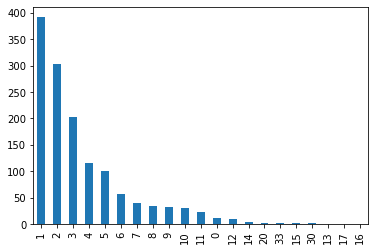

In [20]:
dfe3['sub_num_sense'].value_counts(normalize=True).plot(kind='bar')

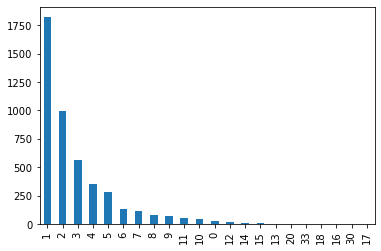

In [21]:
dataset_to_df['ALL']['sub_num_sense'] = dataset_to_df['ALL']['sub_label_sg'].apply(lambda x:  len(wn.synsets(x, pos='n')))
dataset_to_df['ALL']['sub_num_sense'].value_counts().plot(kind='bar')

In [24]:
display( dataset_to_df['ALL']['sub_num_sense'].value_counts(normalize=True))
display( dfe3['sub_num_sense'].value_counts(normalize=True))

1     0.397556
2     0.217325
3     0.123718
4     0.077242
5     0.061532
6     0.028148
7     0.024875
8     0.017456
9     0.015928
11    0.011128
10    0.009164
0     0.005673
12    0.003709
14    0.001527
15    0.001309
13    0.000873
20    0.000655
33    0.000655
18    0.000436
16    0.000436
30    0.000436
17    0.000218
Name: sub_num_sense, dtype: float64

1     0.287601
2     0.222304
3     0.148936
4     0.084373
5     0.073368
6     0.041820
7     0.029347
8     0.024945
9     0.023478
10    0.022010
11    0.016875
0     0.008070
12    0.006603
14    0.002201
20    0.001467
33    0.001467
15    0.001467
30    0.001467
13    0.000734
17    0.000734
16    0.000734
Name: sub_num_sense, dtype: float64

## Frequency

#Vocab: 74093


<ipython-input-53-1e189bfaaf16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe3['sub_freq'] = dfe3['sub_label_sg'].apply(lambda x: word_to_freq.get(x))
<ipython-input-53-1e189bfaaf16>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfe3['obj_freq'] = dfe3['obj_label'].apply(lambda x: word_to_freq.get(x))
<ipython-input-52-568b69fa0319>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [67]:
display(dfe3['sub_freq_level'].value_counts())
# dfe3.query("sub_freq_level == 'HIGH'")[['sub_label_sg', 'obj_label']]
# display(dfe3.query("obj_label=='artifact'")[['sub_label_sg', 'obj_label', 'obj_mask_def_sap', 'obj_mask_lsp_sap']])




HIGH      976
MEDI      219
LOW        84
UNSEEN     84
Name: sub_freq_level, dtype: int64

,word,error_rate,freq_wrong,freq_total
7,good,1.00,23,23
19,solid,1.00,12,12
23,construction,1.00,10,10
0,artifact,0.99,90,91
3,commodity,0.93,27,29
20,fluid,0.92,12,13
2,produce,0.87,27,31
18,entertainer,0.86,12,14
22,wear,0.83,10,12
25,gift,0.77,10,13


In [36]:
# dfe3['obj_freq_level'].value_counts()


HIGH      1126
MEDI       226
LOW         11
UNSEEN       0
Name: obj_freq_level, dtype: int64